In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import pickle
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "E://TFM/Flickr8k/captions.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to


In [3]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8091 


In [4]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [5]:
descriptions['1000268201_693b08cb0e']

['child in a pink dress is climbing up a set of stairs in an entry way .',
 'girl going into a wooden building .',
 'little girl climbing into a wooden playhouse .',
 'little girl climbing the stairs to her playhouse .',
 'little girl in a pink dress going into a wooden cabin .']

In [6]:
descriptions['1001773457_577c3a7d70']

['black dog and a spotted dog are fighting',
 'black dog and a tri-colored dog playing with each other on the road .',
 'black dog and a white dog with brown spots are staring at each other in the street .',
 'dogs of different breeds looking at each other on the road .',
 'dogs on pavement moving toward each other .']

In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'dogs of different breeds looking at each other on the road',
 'dogs on pavement moving toward each other']

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8680


In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'E://TFM/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [13]:
# Below path contains all the images
images = 'E://TFM/Flickr8k/Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [14]:
# Below file conatains the names of images to be used in train data
train_images_file = 'E://TFM/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [15]:
# Below file conatains the names of images to be used in test data
test_images_file = 'E://TFM/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [16]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [17]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [18]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [19]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [20]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [21]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
# start = time()
# encoding_train = {}
# for img in train_img:
#     encoding_train[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [22]:
# Save the bottleneck train features to disk
# with open("E://TFM/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

In [23]:
# Call the funtion to encode all the test images - Execute this only once
# start = time()
# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [24]:
# Save the bottleneck test features to disk
# with open("E://TFM/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [25]:
train_features = load(open("E://TFM/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [26]:
test_features = load(open("E://TFM/Pickle/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [27]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [28]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7506 -> 1631


In [29]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [30]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1632

In [31]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 33


In [32]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            print(key.__class__)
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [33]:
# Load Glove vectors
glove_dir = 'E://TFM/Glove/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [34]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(1632, 200)

In [36]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      326400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [38]:
model.get_layer(index=1)

In [39]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [41]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [42]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

<class 'str'>
<class 'str'>
<class 'str'>


C:\Users\rubio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 1:44:27 - loss: 7.4719<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:45 - loss: 7.4377   <class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:00 - loss: 7.3955<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 3:44 - loss: 7.3582<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 3:43 - loss: 7.3098<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 3:41 - loss: 7.2554<class 'str'>
<class 'str'>
<class 'str'>
   7/2000 [..............................] - ETA: 3:33 - loss: 7.2028<class 'str'>
<class 'str'>
<class 'str'>
   8/2000 [..............................] - ETA: 3:35 - loss: 7.1469<class 'str'>
<class 'str'>
<class 'str'>
   9/2000 [..............................] - ETA: 3:37 - loss: 7

  74/2000 [>.............................] - ETA: 3:18 - loss: 6.1905<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:18 - loss: 6.1843<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:18 - loss: 6.1781<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:18 - loss: 6.1720<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:19 - loss: 6.1661<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:18 - loss: 6.1602<class 'str'>
<class 'str'>
<class 'str'>
  80/2000 [>.............................] - ETA: 3:18 - loss: 6.1544<class 'str'>
<class 'str'>
<class 'str'>
  81/2000 [>.............................] - ETA: 3:18 - loss: 6.1487<class 'str'>
<class 'str'>
<class 'str'>
  82/2000 [>.............................] - ETA: 3:18 - loss: 6.1431<class 'str'>
<class 'str'>
<class 'str'>
 

 148/2000 [=>............................] - ETA: 3:11 - loss: 5.8757<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:10 - loss: 5.8728<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:10 - loss: 5.8698<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:10 - loss: 5.8668<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:10 - loss: 5.8639<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:10 - loss: 5.8609<class 'str'>
<class 'str'>
<class 'str'>
 154/2000 [=>............................] - ETA: 3:10 - loss: 5.8580<class 'str'>
<class 'str'>
<class 'str'>
 155/2000 [=>............................] - ETA: 3:10 - loss: 5.8551<class 'str'>
<class 'str'>
<class 'str'>
 156/2000 [=>............................] - ETA: 3:09 - loss: 5.8523<class 'str'>
<class 'str'>
<class 'str'>
 

 222/2000 [==>...........................] - ETA: 3:02 - loss: 5.6939<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:02 - loss: 5.6919<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:02 - loss: 5.6899<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 3:02 - loss: 5.6879<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 3:01 - loss: 5.6859<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 3:01 - loss: 5.6839<class 'str'>
<class 'str'>
<class 'str'>
 228/2000 [==>...........................] - ETA: 3:01 - loss: 5.6820<class 'str'>
<class 'str'>
<class 'str'>
 229/2000 [==>...........................] - ETA: 3:01 - loss: 5.6800<class 'str'>
<class 'str'>
<class 'str'>
 230/2000 [==>...........................] - ETA: 3:01 - loss: 5.6781<class 'str'>
<class 'str'>
<class 'str'>
 

 296/2000 [===>..........................] - ETA: 2:54 - loss: 5.5633<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:54 - loss: 5.5618<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:54 - loss: 5.5602<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:54 - loss: 5.5587<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 2:54 - loss: 5.5571<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 2:54 - loss: 5.5556<class 'str'>
<class 'str'>
<class 'str'>
 302/2000 [===>..........................] - ETA: 2:54 - loss: 5.5540<class 'str'>
<class 'str'>
<class 'str'>
 303/2000 [===>..........................] - ETA: 2:54 - loss: 5.5525<class 'str'>
<class 'str'>
<class 'str'>
 304/2000 [===>..........................] - ETA: 2:53 - loss: 5.5510<class 'str'>
<class 'str'>
<class 'str'>
 

 370/2000 [====>.........................] - ETA: 2:46 - loss: 5.4579<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:46 - loss: 5.4565<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:46 - loss: 5.4552<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:46 - loss: 5.4539<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:46 - loss: 5.4526<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:46 - loss: 5.4513<class 'str'>
<class 'str'>
<class 'str'>
 376/2000 [====>.........................] - ETA: 2:46 - loss: 5.4500<class 'str'>
<class 'str'>
<class 'str'>
 377/2000 [====>.........................] - ETA: 2:46 - loss: 5.4487<class 'str'>
<class 'str'>
<class 'str'>
 378/2000 [====>.........................] - ETA: 2:45 - loss: 5.4474<class 'str'>
<class 'str'>
<class 'str'>
 

 444/2000 [=====>........................] - ETA: 2:41 - loss: 5.3664<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:41 - loss: 5.3653<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:40 - loss: 5.3642<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:40 - loss: 5.3631<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:40 - loss: 5.3620<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:40 - loss: 5.3609<class 'str'>
<class 'str'>
<class 'str'>
 450/2000 [=====>........................] - ETA: 2:40 - loss: 5.3598<class 'str'>
<class 'str'>
<class 'str'>
 451/2000 [=====>........................] - ETA: 2:40 - loss: 5.3587<class 'str'>
<class 'str'>
<class 'str'>
 452/2000 [=====>........................] - ETA: 2:40 - loss: 5.3577<class 'str'>
<class 'str'>
<class 'str'>
 

 518/2000 [======>.......................] - ETA: 2:34 - loss: 5.2908<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:34 - loss: 5.2899<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:34 - loss: 5.2889<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:34 - loss: 5.2880<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:34 - loss: 5.2870<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:33 - loss: 5.2861<class 'str'>
<class 'str'>
<class 'str'>
 524/2000 [======>.......................] - ETA: 2:33 - loss: 5.2852<class 'str'>
<class 'str'>
<class 'str'>
 525/2000 [======>.......................] - ETA: 2:33 - loss: 5.2842<class 'str'>
<class 'str'>
<class 'str'>
 526/2000 [======>.......................] - ETA: 2:33 - loss: 5.2833<class 'str'>
<class 'str'>
<class 'str'>
 

 592/2000 [=======>......................] - ETA: 2:26 - loss: 5.2252<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:26 - loss: 5.2243<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:26 - loss: 5.2235<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:26 - loss: 5.2227<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:26 - loss: 5.2218<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:26 - loss: 5.2210<class 'str'>
<class 'str'>
<class 'str'>
 598/2000 [=======>......................] - ETA: 2:26 - loss: 5.2202<class 'str'>
<class 'str'>
<class 'str'>
 599/2000 [=======>......................] - ETA: 2:26 - loss: 5.2194<class 'str'>
<class 'str'>
<class 'str'>
 600/2000 [========>.....................] - ETA: 2:25 - loss: 5.2185<class 'str'>
<class 'str'>
<class 'str'>
 

 666/2000 [========>.....................] - ETA: 2:19 - loss: 5.1669<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:19 - loss: 5.1662<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:18 - loss: 5.1655<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:18 - loss: 5.1647<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:18 - loss: 5.1640<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:18 - loss: 5.1633<class 'str'>
<class 'str'>
<class 'str'>
 672/2000 [=========>....................] - ETA: 2:18 - loss: 5.1625<class 'str'>
<class 'str'>
<class 'str'>
 673/2000 [=========>....................] - ETA: 2:18 - loss: 5.1618<class 'str'>
<class 'str'>
<class 'str'>
 674/2000 [=========>....................] - ETA: 2:18 - loss: 5.1610<class 'str'>
<class 'str'>
<class 'str'>
 

 740/2000 [==========>...................] - ETA: 2:11 - loss: 5.1154<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:11 - loss: 5.1147<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:11 - loss: 5.1140<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:10 - loss: 5.1134<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:10 - loss: 5.1127<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:10 - loss: 5.1121<class 'str'>
<class 'str'>
<class 'str'>
 746/2000 [==========>...................] - ETA: 2:10 - loss: 5.1114<class 'str'>
<class 'str'>
<class 'str'>
 747/2000 [==========>...................] - ETA: 2:10 - loss: 5.1108<class 'str'>
<class 'str'>
<class 'str'>
 748/2000 [==========>...................] - ETA: 2:10 - loss: 5.1101<class 'str'>
<class 'str'>
<class 'str'>
 

 814/2000 [===========>..................] - ETA: 2:03 - loss: 5.0689<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:03 - loss: 5.0683<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:03 - loss: 5.0677<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 2:03 - loss: 5.0671<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 2:03 - loss: 5.0665<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 2:02 - loss: 5.0659<class 'str'>
<class 'str'>
<class 'str'>
 820/2000 [===========>..................] - ETA: 2:02 - loss: 5.0653<class 'str'>
<class 'str'>
<class 'str'>
 821/2000 [===========>..................] - ETA: 2:02 - loss: 5.0647<class 'str'>
<class 'str'>
<class 'str'>
 822/2000 [===========>..................] - ETA: 2:02 - loss: 5.0642<class 'str'>
<class 'str'>
<class 'str'>
 

 888/2000 [============>.................] - ETA: 1:55 - loss: 5.0271<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:55 - loss: 5.0265<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:55 - loss: 5.0260<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:55 - loss: 5.0255<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:55 - loss: 5.0249<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 1:55 - loss: 5.0244<class 'str'>
<class 'str'>
<class 'str'>
 894/2000 [============>.................] - ETA: 1:54 - loss: 5.0239<class 'str'>
<class 'str'>
<class 'str'>
 895/2000 [============>.................] - ETA: 1:54 - loss: 5.0233<class 'str'>
<class 'str'>
<class 'str'>
 896/2000 [============>.................] - ETA: 1:54 - loss: 5.0228<class 'str'>
<class 'str'>
<class 'str'>
 

 962/2000 [=============>................] - ETA: 1:47 - loss: 4.9895<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:47 - loss: 4.9890<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:47 - loss: 4.9885<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:47 - loss: 4.9880<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:47 - loss: 4.9875<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:47 - loss: 4.9871<class 'str'>
<class 'str'>
<class 'str'>
 968/2000 [=============>................] - ETA: 1:47 - loss: 4.9866<class 'str'>
<class 'str'>
<class 'str'>
 969/2000 [=============>................] - ETA: 1:46 - loss: 4.9861<class 'str'>
<class 'str'>
<class 'str'>
 970/2000 [=============>................] - ETA: 1:46 - loss: 4.9856<class 'str'>
<class 'str'>
<class 'str'>
 

1036/2000 [==============>...............] - ETA: 1:39 - loss: 4.9553<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:39 - loss: 4.9548<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:39 - loss: 4.9544<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:39 - loss: 4.9540<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:39 - loss: 4.9535<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:39 - loss: 4.9531<class 'str'>
<class 'str'>
<class 'str'>
1042/2000 [==============>...............] - ETA: 1:39 - loss: 4.9526<class 'str'>
<class 'str'>
<class 'str'>
1043/2000 [==============>...............] - ETA: 1:39 - loss: 4.9522<class 'str'>
<class 'str'>
<class 'str'>
1044/2000 [==============>...............] - ETA: 1:38 - loss: 4.9518<class 'str'>
<class 'str'>
<class 'str'>
1

1110/2000 [===============>..............] - ETA: 1:31 - loss: 4.9237<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:31 - loss: 4.9233<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:31 - loss: 4.9229<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:31 - loss: 4.9225<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:31 - loss: 4.9221<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:31 - loss: 4.9217<class 'str'>
<class 'str'>
<class 'str'>
1116/2000 [===============>..............] - ETA: 1:31 - loss: 4.9213<class 'str'>
<class 'str'>
<class 'str'>
1117/2000 [===============>..............] - ETA: 1:31 - loss: 4.9209<class 'str'>
<class 'str'>
<class 'str'>
1118/2000 [===============>..............] - ETA: 1:31 - loss: 4.9205<class 'str'>
<class 'str'>
<class 'str'>
1

1184/2000 [================>.............] - ETA: 1:24 - loss: 4.8945<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:23 - loss: 4.8941<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:23 - loss: 4.8937<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:23 - loss: 4.8933<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:23 - loss: 4.8930<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:23 - loss: 4.8926<class 'str'>
<class 'str'>
<class 'str'>
1190/2000 [================>.............] - ETA: 1:23 - loss: 4.8922<class 'str'>
<class 'str'>
<class 'str'>
1191/2000 [================>.............] - ETA: 1:23 - loss: 4.8918<class 'str'>
<class 'str'>
<class 'str'>
1192/2000 [================>.............] - ETA: 1:23 - loss: 4.8914<class 'str'>
<class 'str'>
<class 'str'>
1

1258/2000 [=================>............] - ETA: 1:16 - loss: 4.8670<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:16 - loss: 4.8667<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:16 - loss: 4.8663<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:16 - loss: 4.8660<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:15 - loss: 4.8656<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:15 - loss: 4.8652<class 'str'>
<class 'str'>
<class 'str'>
1264/2000 [=================>............] - ETA: 1:15 - loss: 4.8649<class 'str'>
<class 'str'>
<class 'str'>
1265/2000 [=================>............] - ETA: 1:15 - loss: 4.8645<class 'str'>
<class 'str'>
<class 'str'>
1266/2000 [=================>............] - ETA: 1:15 - loss: 4.8641<class 'str'>
<class 'str'>
<class 'str'>
1

1332/2000 [==================>...........] - ETA: 1:08 - loss: 4.8408<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:08 - loss: 4.8405<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:08 - loss: 4.8402<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:08 - loss: 4.8398<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:08 - loss: 4.8395<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:08 - loss: 4.8391<class 'str'>
<class 'str'>
<class 'str'>
1338/2000 [===================>..........] - ETA: 1:08 - loss: 4.8388<class 'str'>
<class 'str'>
<class 'str'>
1339/2000 [===================>..........] - ETA: 1:07 - loss: 4.8384<class 'str'>
<class 'str'>
<class 'str'>
1340/2000 [===================>..........] - ETA: 1:07 - loss: 4.8381<class 'str'>
<class 'str'>
<class 'str'>
1

1406/2000 [====================>.........] - ETA: 1:00 - loss: 4.8159<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 1:00 - loss: 4.8155<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 1:00 - loss: 4.8152<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 1:00 - loss: 4.8149<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 1:00 - loss: 4.8146<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 1:00 - loss: 4.8142<class 'str'>
<class 'str'>
<class 'str'>
1412/2000 [====================>.........] - ETA: 1:00 - loss: 4.8139<class 'str'>
<class 'str'>
<class 'str'>
1413/2000 [====================>.........] - ETA: 1:00 - loss: 4.8136<class 'str'>
<class 'str'>
<class 'str'>
1414/2000 [====================>.........] - ETA: 1:00 - loss: 4.8132<class 'str'>
<class 'str'>
<class 'str'>
1

1480/2000 [=====================>........] - ETA: 53s - loss: 4.7921<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 53s - loss: 4.7918<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 53s - loss: 4.7915<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 52s - loss: 4.7912<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 52s - loss: 4.7909<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 52s - loss: 4.7906<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 [=====================>........] - ETA: 52s - loss: 4.7903<class 'str'>
<class 'str'>
<class 'str'>
1487/2000 [=====================>........] - ETA: 52s - loss: 4.7900<class 'str'>
<class 'str'>
<class 'str'>
1488/2000 [=====================>........] - ETA: 52s - loss: 4.7897<class 'str'>
<class 'str'>
<class 'str'>
1489/2000 

1554/2000 [======================>.......] - ETA: 45s - loss: 4.7696<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 45s - loss: 4.7693<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 45s - loss: 4.7690<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 45s - loss: 4.7687<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 45s - loss: 4.7684<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 45s - loss: 4.7682<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 [======================>.......] - ETA: 45s - loss: 4.7679<class 'str'>
<class 'str'>
<class 'str'>
1561/2000 [======================>.......] - ETA: 44s - loss: 4.7676<class 'str'>
<class 'str'>
<class 'str'>
1562/2000 [======================>.......] - ETA: 44s - loss: 4.7673<class 'str'>
<class 'str'>
<class 'str'>
1563/2000 

1628/2000 [=======================>......] - ETA: 38s - loss: 4.7482<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 37s - loss: 4.7479<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 37s - loss: 4.7477<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 37s - loss: 4.7474<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 37s - loss: 4.7471<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 37s - loss: 4.7468<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 [=======================>......] - ETA: 37s - loss: 4.7465<class 'str'>
<class 'str'>
<class 'str'>
1635/2000 [=======================>......] - ETA: 37s - loss: 4.7463<class 'str'>
<class 'str'>
<class 'str'>
1636/2000 [=======================>......] - ETA: 37s - loss: 4.7460<class 'str'>
<class 'str'>
<class 'str'>
1637/2000 

1702/2000 [========================>.....] - ETA: 30s - loss: 4.7279<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 30s - loss: 4.7276<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 30s - loss: 4.7273<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 30s - loss: 4.7271<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 30s - loss: 4.7268<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 29s - loss: 4.7265<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 [========================>.....] - ETA: 29s - loss: 4.7263<class 'str'>
<class 'str'>
<class 'str'>
1709/2000 [========================>.....] - ETA: 29s - loss: 4.7260<class 'str'>
<class 'str'>
<class 'str'>
1710/2000 [========================>.....] - ETA: 29s - loss: 4.7257<class 'str'>
<class 'str'>
<class 'str'>
1711/2000 

1776/2000 [=========================>....] - ETA: 22s - loss: 4.7085<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 4.7082<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 22s - loss: 4.7080<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 22s - loss: 4.7077<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 22s - loss: 4.7074<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 22s - loss: 4.7072<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 [=========================>....] - ETA: 22s - loss: 4.7069<class 'str'>
<class 'str'>
<class 'str'>
1783/2000 [=========================>....] - ETA: 22s - loss: 4.7067<class 'str'>
<class 'str'>
<class 'str'>
1784/2000 [=========================>....] - ETA: 22s - loss: 4.7064<class 'str'>
<class 'str'>
<class 'str'>
1785/2000 

1850/2000 [==========================>...] - ETA: 15s - loss: 4.6897<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 15s - loss: 4.6895<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 15s - loss: 4.6892<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 15s - loss: 4.6890<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 14s - loss: 4.6887<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 14s - loss: 4.6885<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 [==========================>...] - ETA: 14s - loss: 4.6882<class 'str'>
<class 'str'>
<class 'str'>
1857/2000 [==========================>...] - ETA: 14s - loss: 4.6880<class 'str'>
<class 'str'>
<class 'str'>
1858/2000 [==========================>...] - ETA: 14s - loss: 4.6877<class 'str'>
<class 'str'>
<class 'str'>
1859/2000 

1925/2000 [===========================>..] - ETA: 7s - loss: 4.6714<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 4.6711<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 4.6709<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 4.6707<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 4.6704<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [===========================>..] - ETA: 7s - loss: 4.6702<class 'str'>
<class 'str'>
<class 'str'>
1931/2000 [===========================>..] - ETA: 7s - loss: 4.6699<class 'str'>
<class 'str'>
<class 'str'>
1932/2000 [===========================>..] - ETA: 6s - loss: 4.6697<class 'str'>
<class 'str'>
<class 'str'>
1933/2000 [===========================>..] - ETA: 6s - loss: 4.6695<class 'str'>
<class 'str'>
<class 'str'>
1934/2000 [========

2000/2000 [==============================] - 208s 103ms/step - loss: 4.6535
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:54 - loss: 3.7175<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:42 - loss: 3.7134<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:04 - loss: 3.5023<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 3:47 - loss: 3.3725<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 3:47 - loss: 3.3398<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 3:46 - loss: 3.3120<class 'str'>
<class 'str'>
<class 'str'>
   7/2000 [..............................] - ETA: 3:36 - loss: 3.3522<class 'str'>
<class 'str'>
<class 'str'>
   8/2000 [..............................] - ETA: 3:36 - loss: 

  73/2000 [>.............................] - ETA: 3:18 - loss: 3.6207<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:18 - loss: 3.6063<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:18 - loss: 3.6085<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:18 - loss: 3.6074<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:18 - loss: 3.6185<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:19 - loss: 3.6159<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:18 - loss: 3.6175<class 'str'>
<class 'str'>
<class 'str'>
  80/2000 [>.............................] - ETA: 3:18 - loss: 3.6248<class 'str'>
<class 'str'>
<class 'str'>
  81/2000 [>.............................] - ETA: 3:18 - loss: 3.6191<class 'str'>
<class 'str'>
<class 'str'>
 

 147/2000 [=>............................] - ETA: 3:09 - loss: 3.6570<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:09 - loss: 3.6583<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:09 - loss: 3.6590<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:09 - loss: 3.6573<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:09 - loss: 3.6620<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:08 - loss: 3.6618<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:08 - loss: 3.6617<class 'str'>
<class 'str'>
<class 'str'>
 154/2000 [=>............................] - ETA: 3:08 - loss: 3.6653<class 'str'>
<class 'str'>
<class 'str'>
 155/2000 [=>............................] - ETA: 3:08 - loss: 3.6653<class 'str'>
<class 'str'>
<class 'str'>
 

 221/2000 [==>...........................] - ETA: 3:00 - loss: 3.6680<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 2:59 - loss: 3.6686<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 2:59 - loss: 3.6661<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 2:59 - loss: 3.6681<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 2:59 - loss: 3.6692<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 2:59 - loss: 3.6654<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 2:59 - loss: 3.6643<class 'str'>
<class 'str'>
<class 'str'>
 228/2000 [==>...........................] - ETA: 2:59 - loss: 3.6653<class 'str'>
<class 'str'>
<class 'str'>
 229/2000 [==>...........................] - ETA: 2:59 - loss: 3.6646<class 'str'>
<class 'str'>
<class 'str'>
 

 295/2000 [===>..........................] - ETA: 2:53 - loss: 3.6547<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:53 - loss: 3.6534<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:53 - loss: 3.6511<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:53 - loss: 3.6514<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:52 - loss: 3.6519<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 2:52 - loss: 3.6506<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 2:52 - loss: 3.6500<class 'str'>
<class 'str'>
<class 'str'>
 302/2000 [===>..........................] - ETA: 2:52 - loss: 3.6512<class 'str'>
<class 'str'>
<class 'str'>
 303/2000 [===>..........................] - ETA: 2:52 - loss: 3.6499<class 'str'>
<class 'str'>
<class 'str'>
 

 369/2000 [====>.........................] - ETA: 2:45 - loss: 3.6177<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:45 - loss: 3.6178<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:45 - loss: 3.6167<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:45 - loss: 3.6144<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:45 - loss: 3.6121<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:45 - loss: 3.6113<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:45 - loss: 3.6114<class 'str'>
<class 'str'>
<class 'str'>
 376/2000 [====>.........................] - ETA: 2:44 - loss: 3.6112<class 'str'>
<class 'str'>
<class 'str'>
 377/2000 [====>.........................] - ETA: 2:44 - loss: 3.6092<class 'str'>
<class 'str'>
<class 'str'>
 

 443/2000 [=====>........................] - ETA: 2:38 - loss: 3.5921<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:38 - loss: 3.5916<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:37 - loss: 3.5919<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:37 - loss: 3.5912<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:37 - loss: 3.5908<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:37 - loss: 3.5896<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:37 - loss: 3.5898<class 'str'>
<class 'str'>
<class 'str'>
 450/2000 [=====>........................] - ETA: 2:37 - loss: 3.5892<class 'str'>
<class 'str'>
<class 'str'>
 451/2000 [=====>........................] - ETA: 2:37 - loss: 3.5884<class 'str'>
<class 'str'>
<class 'str'>
 

 517/2000 [======>.......................] - ETA: 2:30 - loss: 3.5781<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:30 - loss: 3.5762<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:30 - loss: 3.5769<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:30 - loss: 3.5776<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:30 - loss: 3.5761<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:30 - loss: 3.5749<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:30 - loss: 3.5737<class 'str'>
<class 'str'>
<class 'str'>
 524/2000 [======>.......................] - ETA: 2:30 - loss: 3.5739<class 'str'>
<class 'str'>
<class 'str'>
 525/2000 [======>.......................] - ETA: 2:29 - loss: 3.5735<class 'str'>
<class 'str'>
<class 'str'>
 

 591/2000 [=======>......................] - ETA: 2:23 - loss: 3.5609<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:23 - loss: 3.5602<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:23 - loss: 3.5601<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:22 - loss: 3.5607<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:22 - loss: 3.5604<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:22 - loss: 3.5612<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:22 - loss: 3.5608<class 'str'>
<class 'str'>
<class 'str'>
 598/2000 [=======>......................] - ETA: 2:22 - loss: 3.5607<class 'str'>
<class 'str'>
<class 'str'>
 599/2000 [=======>......................] - ETA: 2:22 - loss: 3.5607<class 'str'>
<class 'str'>
<class 'str'>
 

 665/2000 [========>.....................] - ETA: 2:15 - loss: 3.5553<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:15 - loss: 3.5554<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:15 - loss: 3.5560<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:15 - loss: 3.5559<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:15 - loss: 3.5551<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:15 - loss: 3.5548<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:14 - loss: 3.5547<class 'str'>
<class 'str'>
<class 'str'>
 672/2000 [=========>....................] - ETA: 2:14 - loss: 3.5539<class 'str'>
<class 'str'>
<class 'str'>
 673/2000 [=========>....................] - ETA: 2:14 - loss: 3.5538<class 'str'>
<class 'str'>
<class 'str'>
 

 739/2000 [==========>...................] - ETA: 2:07 - loss: 3.5490<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:07 - loss: 3.5486<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:07 - loss: 3.5482<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:07 - loss: 3.5487<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:07 - loss: 3.5494<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:07 - loss: 3.5510<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:07 - loss: 3.5517<class 'str'>
<class 'str'>
<class 'str'>
 746/2000 [==========>...................] - ETA: 2:07 - loss: 3.5509<class 'str'>
<class 'str'>
<class 'str'>
 747/2000 [==========>...................] - ETA: 2:07 - loss: 3.5502<class 'str'>
<class 'str'>
<class 'str'>
 

 813/2000 [===========>..................] - ETA: 2:00 - loss: 3.5402<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 2:00 - loss: 3.5399<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:00 - loss: 3.5399<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:00 - loss: 3.5401<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 2:00 - loss: 3.5399<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 2:00 - loss: 3.5394<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 1:59 - loss: 3.5388<class 'str'>
<class 'str'>
<class 'str'>
 820/2000 [===========>..................] - ETA: 1:59 - loss: 3.5385<class 'str'>
<class 'str'>
<class 'str'>
 821/2000 [===========>..................] - ETA: 1:59 - loss: 3.5385<class 'str'>
<class 'str'>
<class 'str'>
 

 887/2000 [============>.................] - ETA: 1:53 - loss: 3.5349<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:52 - loss: 3.5345<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:52 - loss: 3.5341<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:52 - loss: 3.5343<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:52 - loss: 3.5348<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:52 - loss: 3.5340<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 1:52 - loss: 3.5337<class 'str'>
<class 'str'>
<class 'str'>
 894/2000 [============>.................] - ETA: 1:52 - loss: 3.5339<class 'str'>
<class 'str'>
<class 'str'>
 895/2000 [============>.................] - ETA: 1:52 - loss: 3.5342<class 'str'>
<class 'str'>
<class 'str'>
 

 961/2000 [=============>................] - ETA: 1:45 - loss: 3.5370<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:45 - loss: 3.5369<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:45 - loss: 3.5372<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:44 - loss: 3.5370<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:44 - loss: 3.5367<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:44 - loss: 3.5364<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:44 - loss: 3.5362<class 'str'>
<class 'str'>
<class 'str'>
 968/2000 [=============>................] - ETA: 1:44 - loss: 3.5363<class 'str'>
<class 'str'>
<class 'str'>
 969/2000 [=============>................] - ETA: 1:44 - loss: 3.5359<class 'str'>
<class 'str'>
<class 'str'>
 

1035/2000 [==============>...............] - ETA: 1:37 - loss: 3.5356<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:37 - loss: 3.5357<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:37 - loss: 3.5357<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:37 - loss: 3.5357<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:37 - loss: 3.5357<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:37 - loss: 3.5354<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:37 - loss: 3.5355<class 'str'>
<class 'str'>
<class 'str'>
1042/2000 [==============>...............] - ETA: 1:37 - loss: 3.5357<class 'str'>
<class 'str'>
<class 'str'>
1043/2000 [==============>...............] - ETA: 1:37 - loss: 3.5360<class 'str'>
<class 'str'>
<class 'str'>
1

1109/2000 [===============>..............] - ETA: 1:30 - loss: 3.5320<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:30 - loss: 3.5315<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:30 - loss: 3.5321<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:29 - loss: 3.5322<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:29 - loss: 3.5322<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:29 - loss: 3.5317<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:29 - loss: 3.5321<class 'str'>
<class 'str'>
<class 'str'>
1116/2000 [===============>..............] - ETA: 1:29 - loss: 3.5325<class 'str'>
<class 'str'>
<class 'str'>
1117/2000 [===============>..............] - ETA: 1:29 - loss: 3.5326<class 'str'>
<class 'str'>
<class 'str'>
1

1183/2000 [================>.............] - ETA: 1:22 - loss: 3.5332<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:22 - loss: 3.5326<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:22 - loss: 3.5325<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:22 - loss: 3.5327<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:22 - loss: 3.5329<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:22 - loss: 3.5329<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:21 - loss: 3.5327<class 'str'>
<class 'str'>
<class 'str'>
1190/2000 [================>.............] - ETA: 1:21 - loss: 3.5326<class 'str'>
<class 'str'>
<class 'str'>
1191/2000 [================>.............] - ETA: 1:21 - loss: 3.5327<class 'str'>
<class 'str'>
<class 'str'>
1

1257/2000 [=================>............] - ETA: 1:15 - loss: 3.5244<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:14 - loss: 3.5242<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:14 - loss: 3.5238<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:14 - loss: 3.5238<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:14 - loss: 3.5239<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:14 - loss: 3.5237<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:14 - loss: 3.5238<class 'str'>
<class 'str'>
<class 'str'>
1264/2000 [=================>............] - ETA: 1:14 - loss: 3.5230<class 'str'>
<class 'str'>
<class 'str'>
1265/2000 [=================>............] - ETA: 1:14 - loss: 3.5227<class 'str'>
<class 'str'>
<class 'str'>
1

1331/2000 [==================>...........] - ETA: 1:07 - loss: 3.5156<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:07 - loss: 3.5157<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:07 - loss: 3.5156<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:07 - loss: 3.5152<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:07 - loss: 3.5150<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:06 - loss: 3.5147<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:06 - loss: 3.5144<class 'str'>
<class 'str'>
<class 'str'>
1338/2000 [===================>..........] - ETA: 1:06 - loss: 3.5143<class 'str'>
<class 'str'>
<class 'str'>
1339/2000 [===================>..........] - ETA: 1:06 - loss: 3.5143<class 'str'>
<class 'str'>
<class 'str'>
1

1405/2000 [====================>.........] - ETA: 1:00 - loss: 3.5098<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 59s - loss: 3.5096 <class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 59s - loss: 3.5097<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 59s - loss: 3.5094<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 59s - loss: 3.5093<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 59s - loss: 3.5094<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 59s - loss: 3.5089<class 'str'>
<class 'str'>
<class 'str'>
1412/2000 [====================>.........] - ETA: 59s - loss: 3.5086<class 'str'>
<class 'str'>
<class 'str'>
1413/2000 [====================>.........] - ETA: 59s - loss: 3.5084<class 'str'>
<class 'str'>
<class 'str'>
1414/200

1479/2000 [=====================>........] - ETA: 52s - loss: 3.5072<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 52s - loss: 3.5068<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 52s - loss: 3.5067<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 52s - loss: 3.5069<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 52s - loss: 3.5070<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 52s - loss: 3.5071<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 52s - loss: 3.5068<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 [=====================>........] - ETA: 51s - loss: 3.5067<class 'str'>
<class 'str'>
<class 'str'>
1487/2000 [=====================>........] - ETA: 51s - loss: 3.5061<class 'str'>
<class 'str'>
<class 'str'>
1488/2000 

1553/2000 [======================>.......] - ETA: 45s - loss: 3.5026<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 45s - loss: 3.5023<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 45s - loss: 3.5020<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 44s - loss: 3.5021<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 44s - loss: 3.5022<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 44s - loss: 3.5022<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 44s - loss: 3.5021<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 [======================>.......] - ETA: 44s - loss: 3.5021<class 'str'>
<class 'str'>
<class 'str'>
1561/2000 [======================>.......] - ETA: 44s - loss: 3.5021<class 'str'>
<class 'str'>
<class 'str'>
1562/2000 

1627/2000 [=======================>......] - ETA: 37s - loss: 3.5015<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 37s - loss: 3.5018<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 37s - loss: 3.5020<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 37s - loss: 3.5020<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 37s - loss: 3.5020<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 37s - loss: 3.5022<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 37s - loss: 3.5021<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 [=======================>......] - ETA: 37s - loss: 3.5022<class 'str'>
<class 'str'>
<class 'str'>
1635/2000 [=======================>......] - ETA: 36s - loss: 3.5026<class 'str'>
<class 'str'>
<class 'str'>
1636/2000 

1701/2000 [========================>.....] - ETA: 30s - loss: 3.5021<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 30s - loss: 3.5024<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 30s - loss: 3.5023<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 29s - loss: 3.5025<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 29s - loss: 3.5025<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 29s - loss: 3.5026<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 29s - loss: 3.5023<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 [========================>.....] - ETA: 29s - loss: 3.5024<class 'str'>
<class 'str'>
<class 'str'>
1709/2000 [========================>.....] - ETA: 29s - loss: 3.5025<class 'str'>
<class 'str'>
<class 'str'>
1710/2000 

1775/2000 [=========================>....] - ETA: 22s - loss: 3.4978<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 3.4977<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 3.4976<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 22s - loss: 3.4977<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 22s - loss: 3.4975<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 22s - loss: 3.4978<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 22s - loss: 3.4975<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 [=========================>....] - ETA: 22s - loss: 3.4973<class 'str'>
<class 'str'>
<class 'str'>
1783/2000 [=========================>....] - ETA: 21s - loss: 3.4974<class 'str'>
<class 'str'>
<class 'str'>
1784/2000 

1849/2000 [==========================>...] - ETA: 15s - loss: 3.4903<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 15s - loss: 3.4903<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 15s - loss: 3.4899<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 14s - loss: 3.4902<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 14s - loss: 3.4903<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 14s - loss: 3.4904<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 14s - loss: 3.4901<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 [==========================>...] - ETA: 14s - loss: 3.4898<class 'str'>
<class 'str'>
<class 'str'>
1857/2000 [==========================>...] - ETA: 14s - loss: 3.4898<class 'str'>
<class 'str'>
<class 'str'>
1858/2000 

1924/2000 [===========================>..] - ETA: 7s - loss: 3.4865<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 7s - loss: 3.4867<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 3.4867<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 3.4870<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 3.4870<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 3.4870<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [===========================>..] - ETA: 7s - loss: 3.4871<class 'str'>
<class 'str'>
<class 'str'>
1931/2000 [===========================>..] - ETA: 6s - loss: 3.4869<class 'str'>
<class 'str'>
<class 'str'>
1932/2000 [===========================>..] - ETA: 6s - loss: 3.4871<class 'str'>
<class 'str'>
<class 'str'>
1933/2000 [========

1999/2000 [============================>.] - ETA: 0s - loss: 3.4844<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 202s 101ms/step - loss: 3.4844
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:39 - loss: 3.4240<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:29 - loss: 3.4158<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 3:55 - loss: 3.2789<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 3:41 - loss: 3.1492<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 3:38 - loss: 3.1194<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 3:37 - loss: 3.0821<class 'str'>
<class 'str'>
<class 'str'>
   7/2000 [..............................] - ETA: 3:28 - loss: 3.

  72/2000 [>.............................] - ETA: 3:20 - loss: 3.3213<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:20 - loss: 3.3257<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:21 - loss: 3.3114<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:21 - loss: 3.3149<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:21 - loss: 3.3129<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:22 - loss: 3.3247<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:23 - loss: 3.3224<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:22 - loss: 3.3234<class 'str'>
<class 'str'>
<class 'str'>
  80/2000 [>.............................] - ETA: 3:22 - loss: 3.3303<class 'str'>
<class 'str'>
<class 'str'>
 

 146/2000 [=>............................] - ETA: 3:15 - loss: 3.3620<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:15 - loss: 3.3639<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:15 - loss: 3.3657<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:14 - loss: 3.3676<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:14 - loss: 3.3661<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:14 - loss: 3.3720<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:14 - loss: 3.3710<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:14 - loss: 3.3712<class 'str'>
<class 'str'>
<class 'str'>
 154/2000 [=>............................] - ETA: 3:14 - loss: 3.3749<class 'str'>
<class 'str'>
<class 'str'>
 

 220/2000 [==>...........................] - ETA: 3:05 - loss: 3.3774<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 3:05 - loss: 3.3817<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 3:05 - loss: 3.3824<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:05 - loss: 3.3803<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:05 - loss: 3.3813<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 3:05 - loss: 3.3823<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 3:04 - loss: 3.3793<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 3:04 - loss: 3.3789<class 'str'>
<class 'str'>
<class 'str'>
 228/2000 [==>...........................] - ETA: 3:04 - loss: 3.3800<class 'str'>
<class 'str'>
<class 'str'>
 

 294/2000 [===>..........................] - ETA: 2:58 - loss: 3.3711<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 2:58 - loss: 3.3741<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:58 - loss: 3.3727<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:58 - loss: 3.3706<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:57 - loss: 3.3706<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:57 - loss: 3.3710<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 2:57 - loss: 3.3697<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 2:57 - loss: 3.3694<class 'str'>
<class 'str'>
<class 'str'>
 302/2000 [===>..........................] - ETA: 2:57 - loss: 3.3700<class 'str'>
<class 'str'>
<class 'str'>
 

 368/2000 [====>.........................] - ETA: 2:49 - loss: 3.3439<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:49 - loss: 3.3449<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:49 - loss: 3.3449<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:49 - loss: 3.3437<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:49 - loss: 3.3414<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:49 - loss: 3.3393<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:49 - loss: 3.3385<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:49 - loss: 3.3387<class 'str'>
<class 'str'>
<class 'str'>
 376/2000 [====>.........................] - ETA: 2:48 - loss: 3.3385<class 'str'>
<class 'str'>
<class 'str'>
 

 442/2000 [=====>........................] - ETA: 2:41 - loss: 3.3223<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:41 - loss: 3.3220<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:41 - loss: 3.3212<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:41 - loss: 3.3213<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:41 - loss: 3.3202<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:41 - loss: 3.3199<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:41 - loss: 3.3181<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:41 - loss: 3.3188<class 'str'>
<class 'str'>
<class 'str'>
 450/2000 [=====>........................] - ETA: 2:40 - loss: 3.3183<class 'str'>
<class 'str'>
<class 'str'>
 

 516/2000 [======>.......................] - ETA: 2:33 - loss: 3.3090<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:33 - loss: 3.3098<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:33 - loss: 3.3080<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:33 - loss: 3.3087<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:33 - loss: 3.3096<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:33 - loss: 3.3082<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:33 - loss: 3.3071<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:33 - loss: 3.3061<class 'str'>
<class 'str'>
<class 'str'>
 524/2000 [======>.......................] - ETA: 2:32 - loss: 3.3063<class 'str'>
<class 'str'>
<class 'str'>
 

 590/2000 [=======>......................] - ETA: 2:25 - loss: 3.2959<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:25 - loss: 3.2961<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:25 - loss: 3.2956<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:25 - loss: 3.2955<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:25 - loss: 3.2960<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:25 - loss: 3.2958<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:25 - loss: 3.2967<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:24 - loss: 3.2964<class 'str'>
<class 'str'>
<class 'str'>
 598/2000 [=======>......................] - ETA: 2:24 - loss: 3.2964<class 'str'>
<class 'str'>
<class 'str'>
 

 664/2000 [========>.....................] - ETA: 2:18 - loss: 3.2963<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:17 - loss: 3.2948<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:17 - loss: 3.2950<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:17 - loss: 3.2958<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:17 - loss: 3.2958<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:17 - loss: 3.2952<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:17 - loss: 3.2950<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:17 - loss: 3.2948<class 'str'>
<class 'str'>
<class 'str'>
 672/2000 [=========>....................] - ETA: 2:17 - loss: 3.2941<class 'str'>
<class 'str'>
<class 'str'>
 

 738/2000 [==========>...................] - ETA: 2:10 - loss: 3.2909<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:10 - loss: 3.2909<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:09 - loss: 3.2906<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:09 - loss: 3.2904<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:09 - loss: 3.2907<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:09 - loss: 3.2914<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:09 - loss: 3.2927<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:09 - loss: 3.2932<class 'str'>
<class 'str'>
<class 'str'>
 746/2000 [==========>...................] - ETA: 2:09 - loss: 3.2925<class 'str'>
<class 'str'>
<class 'str'>
 

 812/2000 [===========>..................] - ETA: 2:02 - loss: 3.2849<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 2:02 - loss: 3.2842<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 2:02 - loss: 3.2840<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:02 - loss: 3.2841<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:02 - loss: 3.2843<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 2:02 - loss: 3.2843<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 2:01 - loss: 3.2839<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 2:01 - loss: 3.2831<class 'str'>
<class 'str'>
<class 'str'>
 820/2000 [===========>..................] - ETA: 2:01 - loss: 3.2826<class 'str'>
<class 'str'>
<class 'str'>
 

 886/2000 [============>.................] - ETA: 1:54 - loss: 3.2816<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:54 - loss: 3.2815<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:54 - loss: 3.2812<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:54 - loss: 3.2808<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:54 - loss: 3.2811<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:54 - loss: 3.2815<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:54 - loss: 3.2807<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 1:54 - loss: 3.2804<class 'str'>
<class 'str'>
<class 'str'>
 894/2000 [============>.................] - ETA: 1:53 - loss: 3.2806<class 'str'>
<class 'str'>
<class 'str'>
 

 960/2000 [=============>................] - ETA: 1:47 - loss: 3.2858<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:46 - loss: 3.2854<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:46 - loss: 3.2854<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:46 - loss: 3.2857<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:46 - loss: 3.2855<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:46 - loss: 3.2853<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:46 - loss: 3.2851<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:46 - loss: 3.2849<class 'str'>
<class 'str'>
<class 'str'>
 968/2000 [=============>................] - ETA: 1:46 - loss: 3.2849<class 'str'>
<class 'str'>
<class 'str'>
 

1034/2000 [==============>...............] - ETA: 1:39 - loss: 3.2870<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:39 - loss: 3.2868<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:39 - loss: 3.2869<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:38 - loss: 3.2871<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:38 - loss: 3.2872<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:38 - loss: 3.2871<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:38 - loss: 3.2868<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:38 - loss: 3.2869<class 'str'>
<class 'str'>
<class 'str'>
1042/2000 [==============>...............] - ETA: 1:38 - loss: 3.2872<class 'str'>
<class 'str'>
<class 'str'>
1

1108/2000 [===============>..............] - ETA: 1:31 - loss: 3.2867<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:31 - loss: 3.2870<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:31 - loss: 3.2865<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:31 - loss: 3.2871<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:31 - loss: 3.2872<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:30 - loss: 3.2872<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:30 - loss: 3.2868<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:30 - loss: 3.2871<class 'str'>
<class 'str'>
<class 'str'>
1116/2000 [===============>..............] - ETA: 1:30 - loss: 3.2875<class 'str'>
<class 'str'>
<class 'str'>
1

1182/2000 [================>.............] - ETA: 1:23 - loss: 3.2903<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:23 - loss: 3.2904<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:23 - loss: 3.2898<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:23 - loss: 3.2898<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:23 - loss: 3.2900<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:23 - loss: 3.2901<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:22 - loss: 3.2900<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:22 - loss: 3.2899<class 'str'>
<class 'str'>
<class 'str'>
1190/2000 [================>.............] - ETA: 1:22 - loss: 3.2898<class 'str'>
<class 'str'>
<class 'str'>
1

1256/2000 [=================>............] - ETA: 1:16 - loss: 3.2833<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:16 - loss: 3.2835<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:16 - loss: 3.2834<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:15 - loss: 3.2829<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:15 - loss: 3.2829<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:15 - loss: 3.2830<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:15 - loss: 3.2829<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:15 - loss: 3.2830<class 'str'>
<class 'str'>
<class 'str'>
1264/2000 [=================>............] - ETA: 1:15 - loss: 3.2823<class 'str'>
<class 'str'>
<class 'str'>
1

1330/2000 [==================>...........] - ETA: 1:08 - loss: 3.2774<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:08 - loss: 3.2773<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:08 - loss: 3.2775<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:08 - loss: 3.2774<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:08 - loss: 3.2770<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:08 - loss: 3.2768<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:08 - loss: 3.2766<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:07 - loss: 3.2763<class 'str'>
<class 'str'>
<class 'str'>
1338/2000 [===================>..........] - ETA: 1:07 - loss: 3.2763<class 'str'>
<class 'str'>
<class 'str'>
1

1404/2000 [====================>.........] - ETA: 1:01 - loss: 3.2733<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 1:01 - loss: 3.2733<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 1:00 - loss: 3.2731<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 1:00 - loss: 3.2732<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 1:00 - loss: 3.2730<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 1:00 - loss: 3.2729<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 1:00 - loss: 3.2730<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 1:00 - loss: 3.2725<class 'str'>
<class 'str'>
<class 'str'>
1412/2000 [====================>.........] - ETA: 1:00 - loss: 3.2724<class 'str'>
<class 'str'>
<class 'str'>
1

1478/2000 [=====================>........] - ETA: 53s - loss: 3.2728<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 53s - loss: 3.2726<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 53s - loss: 3.2723<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 53s - loss: 3.2722<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 53s - loss: 3.2723<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 53s - loss: 3.2724<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 52s - loss: 3.2725<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 52s - loss: 3.2723<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 [=====================>........] - ETA: 52s - loss: 3.2722<class 'str'>
<class 'str'>
<class 'str'>
1487/2000 

1552/2000 [======================>.......] - ETA: 45s - loss: 3.2712<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 45s - loss: 3.2709<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 45s - loss: 3.2706<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 45s - loss: 3.2703<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 45s - loss: 3.2705<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 45s - loss: 3.2706<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 45s - loss: 3.2705<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 45s - loss: 3.2703<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 [======================>.......] - ETA: 45s - loss: 3.2703<class 'str'>
<class 'str'>
<class 'str'>
1561/2000 

1626/2000 [=======================>......] - ETA: 38s - loss: 3.2719<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 38s - loss: 3.2719<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 38s - loss: 3.2722<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 38s - loss: 3.2724<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 37s - loss: 3.2724<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 37s - loss: 3.2725<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 37s - loss: 3.2727<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 37s - loss: 3.2727<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 [=======================>......] - ETA: 37s - loss: 3.2728<class 'str'>
<class 'str'>
<class 'str'>
1635/2000 

1700/2000 [========================>.....] - ETA: 30s - loss: 3.2747<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 30s - loss: 3.2747<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 30s - loss: 3.2751<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 30s - loss: 3.2750<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 30s - loss: 3.2754<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 30s - loss: 3.2754<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 30s - loss: 3.2755<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 30s - loss: 3.2753<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 [========================>.....] - ETA: 29s - loss: 3.2754<class 'str'>
<class 'str'>
<class 'str'>
1709/2000 

1774/2000 [=========================>....] - ETA: 23s - loss: 3.2723<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 23s - loss: 3.2722<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 3.2721<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 3.2719<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 22s - loss: 3.2721<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 22s - loss: 3.2719<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 22s - loss: 3.2722<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 22s - loss: 3.2719<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 [=========================>....] - ETA: 22s - loss: 3.2717<class 'str'>
<class 'str'>
<class 'str'>
1783/2000 

1848/2000 [==========================>...] - ETA: 15s - loss: 3.2669<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 15s - loss: 3.2667<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 15s - loss: 3.2667<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 15s - loss: 3.2663<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 15s - loss: 3.2666<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 15s - loss: 3.2667<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 14s - loss: 3.2669<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 14s - loss: 3.2665<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 [==========================>...] - ETA: 14s - loss: 3.2663<class 'str'>
<class 'str'>
<class 'str'>
1857/2000 

1923/2000 [===========================>..] - ETA: 7s - loss: 3.2647<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 7s - loss: 3.2645<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 7s - loss: 3.2646<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 3.2646<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 3.2649<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 3.2649<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 3.2649<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [===========================>..] - ETA: 7s - loss: 3.2650<class 'str'>
<class 'str'>
<class 'str'>
1931/2000 [===========================>..] - ETA: 7s - loss: 3.2649<class 'str'>
<class 'str'>
<class 'str'>
1932/2000 [========

1998/2000 [============================>.] - ETA: 0s - loss: 3.2650<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 3.2646<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 205s 103ms/step - loss: 3.2646
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 4:17 - loss: 3.2071<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:59 - loss: 3.2592<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:29 - loss: 3.1416<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 4:09 - loss: 3.0076<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 4:07 - loss: 2.9808<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 4:03 - loss: 2.94

  71/2000 [>.............................] - ETA: 3:22 - loss: 3.1627<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:22 - loss: 3.1685<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:21 - loss: 3.1727<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:21 - loss: 3.1573<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:21 - loss: 3.1612<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:21 - loss: 3.1596<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:22 - loss: 3.1702<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:22 - loss: 3.1667<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:21 - loss: 3.1680<class 'str'>
<class 'str'>
<class 'str'>
 

 145/2000 [=>............................] - ETA: 3:11 - loss: 3.2035<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:11 - loss: 3.2029<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:11 - loss: 3.2045<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:11 - loss: 3.2052<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:10 - loss: 3.2075<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:10 - loss: 3.2060<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:10 - loss: 3.2123<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:10 - loss: 3.2109<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:10 - loss: 3.2116<class 'str'>
<class 'str'>
<class 'str'>
 

 219/2000 [==>...........................] - ETA: 3:01 - loss: 3.2194<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 3:01 - loss: 3.2167<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 3:01 - loss: 3.2214<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 3:01 - loss: 3.2222<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:01 - loss: 3.2204<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:01 - loss: 3.2214<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 3:00 - loss: 3.2224<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 3:00 - loss: 3.2192<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 3:00 - loss: 3.2190<class 'str'>
<class 'str'>
<class 'str'>
 

 293/2000 [===>..........................] - ETA: 2:54 - loss: 3.2120<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 2:54 - loss: 3.2123<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 2:53 - loss: 3.2151<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:53 - loss: 3.2137<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:53 - loss: 3.2115<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:53 - loss: 3.2118<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:53 - loss: 3.2126<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 2:53 - loss: 3.2113<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 2:53 - loss: 3.2111<class 'str'>
<class 'str'>
<class 'str'>
 

 367/2000 [====>.........................] - ETA: 2:47 - loss: 3.1888<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:47 - loss: 3.1872<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:47 - loss: 3.1885<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:47 - loss: 3.1884<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:47 - loss: 3.1874<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:46 - loss: 3.1852<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:46 - loss: 3.1831<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:46 - loss: 3.1824<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:46 - loss: 3.1826<class 'str'>
<class 'str'>
<class 'str'>
 

 441/2000 [=====>........................] - ETA: 2:38 - loss: 3.1686<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:38 - loss: 3.1693<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:38 - loss: 3.1687<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:38 - loss: 3.1680<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:38 - loss: 3.1681<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:38 - loss: 3.1668<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:38 - loss: 3.1664<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:38 - loss: 3.1648<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:38 - loss: 3.1655<class 'str'>
<class 'str'>
<class 'str'>
 

 515/2000 [======>.......................] - ETA: 2:30 - loss: 3.1568<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:30 - loss: 3.1568<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:30 - loss: 3.1575<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:30 - loss: 3.1558<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:30 - loss: 3.1564<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:30 - loss: 3.1574<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:30 - loss: 3.1561<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:30 - loss: 3.1552<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:30 - loss: 3.1542<class 'str'>
<class 'str'>
<class 'str'>
 

 589/2000 [=======>......................] - ETA: 2:22 - loss: 3.1461<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:22 - loss: 3.1461<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:22 - loss: 3.1463<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:22 - loss: 3.1457<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:22 - loss: 3.1458<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:22 - loss: 3.1463<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:22 - loss: 3.1459<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:21 - loss: 3.1464<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:21 - loss: 3.1464<class 'str'>
<class 'str'>
<class 'str'>
 

 663/2000 [========>.....................] - ETA: 2:14 - loss: 3.1479<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:14 - loss: 3.1483<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:14 - loss: 3.1468<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:14 - loss: 3.1470<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:14 - loss: 3.1477<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:14 - loss: 3.1478<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:14 - loss: 3.1472<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:13 - loss: 3.1470<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:13 - loss: 3.1470<class 'str'>
<class 'str'>
<class 'str'>
 

 737/2000 [==========>...................] - ETA: 2:06 - loss: 3.1438<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:06 - loss: 3.1432<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:06 - loss: 3.1433<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:06 - loss: 3.1429<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:06 - loss: 3.1427<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:06 - loss: 3.1431<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:06 - loss: 3.1437<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:06 - loss: 3.1448<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:05 - loss: 3.1452<class 'str'>
<class 'str'>
<class 'str'>
 

 811/2000 [===========>..................] - ETA: 1:59 - loss: 3.1382<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 1:59 - loss: 3.1380<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 1:59 - loss: 3.1372<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 1:58 - loss: 3.1372<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 1:58 - loss: 3.1372<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 1:58 - loss: 3.1374<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 1:58 - loss: 3.1375<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 1:58 - loss: 3.1372<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 1:58 - loss: 3.1364<class 'str'>
<class 'str'>
<class 'str'>
 

 885/2000 [============>.................] - ETA: 1:51 - loss: 3.1351<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:51 - loss: 3.1350<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:51 - loss: 3.1350<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:51 - loss: 3.1346<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:51 - loss: 3.1344<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:51 - loss: 3.1346<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:50 - loss: 3.1351<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:50 - loss: 3.1342<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 1:50 - loss: 3.1341<class 'str'>
<class 'str'>
<class 'str'>
 

 959/2000 [=============>................] - ETA: 1:43 - loss: 3.1407<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:43 - loss: 3.1406<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:43 - loss: 3.1401<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:43 - loss: 3.1402<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:43 - loss: 3.1405<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:43 - loss: 3.1404<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:43 - loss: 3.1401<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:43 - loss: 3.1400<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:43 - loss: 3.1398<class 'str'>
<class 'str'>
<class 'str'>
 

1033/2000 [==============>...............] - ETA: 1:36 - loss: 3.1426<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:36 - loss: 3.1428<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:36 - loss: 3.1426<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:35 - loss: 3.1428<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:35 - loss: 3.1429<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:35 - loss: 3.1429<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:35 - loss: 3.1429<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:35 - loss: 3.1426<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:35 - loss: 3.1427<class 'str'>
<class 'str'>
<class 'str'>
1

1107/2000 [===============>..............] - ETA: 1:28 - loss: 3.1418<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:28 - loss: 3.1423<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:28 - loss: 3.1426<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:28 - loss: 3.1421<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:28 - loss: 3.1426<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:28 - loss: 3.1428<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:28 - loss: 3.1427<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:27 - loss: 3.1423<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:27 - loss: 3.1425<class 'str'>
<class 'str'>
<class 'str'>
1

1181/2000 [================>.............] - ETA: 1:21 - loss: 3.1461<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:21 - loss: 3.1459<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:21 - loss: 3.1460<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:20 - loss: 3.1455<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:20 - loss: 3.1455<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:20 - loss: 3.1457<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:20 - loss: 3.1459<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:20 - loss: 3.1458<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:20 - loss: 3.1458<class 'str'>
<class 'str'>
<class 'str'>
1

1255/2000 [=================>............] - ETA: 1:13 - loss: 3.1403<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:13 - loss: 3.1405<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:13 - loss: 3.1406<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:13 - loss: 3.1405<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:13 - loss: 3.1401<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:13 - loss: 3.1401<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:13 - loss: 3.1401<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:13 - loss: 3.1401<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:13 - loss: 3.1403<class 'str'>
<class 'str'>
<class 'str'>
1

1329/2000 [==================>...........] - ETA: 1:06 - loss: 3.1354<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:06 - loss: 3.1354<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:06 - loss: 3.1352<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:06 - loss: 3.1355<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:06 - loss: 3.1355<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:05 - loss: 3.1351<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:05 - loss: 3.1350<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:05 - loss: 3.1348<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:05 - loss: 3.1345<class 'str'>
<class 'str'>
<class 'str'>
1

1403/2000 [====================>.........] - ETA: 59s - loss: 3.1321<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 58s - loss: 3.1324<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 58s - loss: 3.1324<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 58s - loss: 3.1322<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 58s - loss: 3.1324<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 58s - loss: 3.1322<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 58s - loss: 3.1323<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 58s - loss: 3.1324<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 58s - loss: 3.1319<class 'str'>
<class 'str'>
<class 'str'>
1412/2000 

1477/2000 [=====================>........] - ETA: 51s - loss: 3.1327<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 51s - loss: 3.1329<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 51s - loss: 3.1326<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 51s - loss: 3.1323<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 51s - loss: 3.1322<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 51s - loss: 3.1323<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 51s - loss: 3.1325<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 50s - loss: 3.1325<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 50s - loss: 3.1323<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 

1551/2000 [======================>.......] - ETA: 44s - loss: 3.1319<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 44s - loss: 3.1317<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 44s - loss: 3.1315<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 44s - loss: 3.1313<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 44s - loss: 3.1310<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 43s - loss: 3.1312<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 43s - loss: 3.1312<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 43s - loss: 3.1311<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 43s - loss: 3.1310<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 

1625/2000 [=======================>......] - ETA: 37s - loss: 3.1339<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 37s - loss: 3.1341<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 36s - loss: 3.1341<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 36s - loss: 3.1344<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 36s - loss: 3.1346<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 36s - loss: 3.1347<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 36s - loss: 3.1347<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 36s - loss: 3.1349<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 36s - loss: 3.1350<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 

1699/2000 [========================>.....] - ETA: 29s - loss: 3.1370<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 29s - loss: 3.1373<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 29s - loss: 3.1373<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 29s - loss: 3.1378<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 29s - loss: 3.1378<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 29s - loss: 3.1381<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 29s - loss: 3.1382<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 29s - loss: 3.1383<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 28s - loss: 3.1381<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 

1773/2000 [=========================>....] - ETA: 22s - loss: 3.1361<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 22s - loss: 3.1361<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 22s - loss: 3.1358<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 3.1359<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 3.1357<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 21s - loss: 3.1358<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 21s - loss: 3.1357<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 21s - loss: 3.1359<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 21s - loss: 3.1357<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 

1847/2000 [==========================>...] - ETA: 15s - loss: 3.1320<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 15s - loss: 3.1322<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 14s - loss: 3.1321<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 14s - loss: 3.1321<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 14s - loss: 3.1317<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 14s - loss: 3.1320<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 14s - loss: 3.1322<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 14s - loss: 3.1322<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 14s - loss: 3.1319<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 

1922/2000 [===========================>..] - ETA: 7s - loss: 3.1309<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 7s - loss: 3.1305<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 7s - loss: 3.1304<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 7s - loss: 3.1305<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 3.1305<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 3.1308<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 3.1309<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 3.1309<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [===========================>..] - ETA: 6s - loss: 3.1310<class 'str'>
<class 'str'>
<class 'str'>
1931/2000 [========

1997/2000 [============================>.] - ETA: 0s - loss: 3.1315<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 3.1316<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 3.1313<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 199s 99ms/step - loss: 3.1313
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:46 - loss: 3.1075<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:29 - loss: 3.1181<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 3:54 - loss: 3.0027<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 3:39 - loss: 2.8955<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 3:38 - loss: 2.8812<

  70/2000 [>.............................] - ETA: 3:17 - loss: 3.0490<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:17 - loss: 3.0562<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:17 - loss: 3.0623<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:16 - loss: 3.0665<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:16 - loss: 3.0523<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:16 - loss: 3.0562<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:16 - loss: 3.0539<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:17 - loss: 3.0650<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:17 - loss: 3.0625<class 'str'>
<class 'str'>
<class 'str'>
 

 144/2000 [=>............................] - ETA: 3:08 - loss: 3.0998<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:08 - loss: 3.0970<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:08 - loss: 3.0964<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:08 - loss: 3.0981<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:08 - loss: 3.0996<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:07 - loss: 3.1018<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:07 - loss: 3.1005<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:07 - loss: 3.1070<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:07 - loss: 3.1061<class 'str'>
<class 'str'>
<class 'str'>
 

 218/2000 [==>...........................] - ETA: 2:59 - loss: 3.1129<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 2:59 - loss: 3.1129<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 2:59 - loss: 3.1103<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 2:59 - loss: 3.1146<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 2:58 - loss: 3.1154<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 2:58 - loss: 3.1138<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 2:58 - loss: 3.1153<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 2:58 - loss: 3.1164<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 2:58 - loss: 3.1131<class 'str'>
<class 'str'>
<class 'str'>
 

 292/2000 [===>..........................] - ETA: 2:52 - loss: 3.1063<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 2:51 - loss: 3.1078<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 2:51 - loss: 3.1077<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 2:51 - loss: 3.1106<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:51 - loss: 3.1089<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:51 - loss: 3.1070<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:51 - loss: 3.1074<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:51 - loss: 3.1080<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 2:51 - loss: 3.1070<class 'str'>
<class 'str'>
<class 'str'>
 

 366/2000 [====>.........................] - ETA: 2:44 - loss: 3.0888<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:44 - loss: 3.0873<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:44 - loss: 3.0858<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:44 - loss: 3.0871<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:44 - loss: 3.0868<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:43 - loss: 3.0859<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:43 - loss: 3.0839<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:43 - loss: 3.0820<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:43 - loss: 3.0814<class 'str'>
<class 'str'>
<class 'str'>
 

 440/2000 [=====>........................] - ETA: 2:37 - loss: 3.0675<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:36 - loss: 3.0675<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:36 - loss: 3.0680<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:36 - loss: 3.0677<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:36 - loss: 3.0669<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:36 - loss: 3.0667<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:36 - loss: 3.0654<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:36 - loss: 3.0651<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:36 - loss: 3.0635<class 'str'>
<class 'str'>
<class 'str'>
 

 514/2000 [======>.......................] - ETA: 2:29 - loss: 3.0540<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:29 - loss: 3.0542<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:29 - loss: 3.0543<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:29 - loss: 3.0549<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:29 - loss: 3.0534<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:29 - loss: 3.0540<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:29 - loss: 3.0549<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:28 - loss: 3.0536<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:28 - loss: 3.0527<class 'str'>
<class 'str'>
<class 'str'>
 

 588/2000 [=======>......................] - ETA: 2:22 - loss: 3.0442<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:22 - loss: 3.0439<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:22 - loss: 3.0438<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:22 - loss: 3.0439<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:22 - loss: 3.0433<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:21 - loss: 3.0434<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:21 - loss: 3.0441<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:21 - loss: 3.0435<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:21 - loss: 3.0441<class 'str'>
<class 'str'>
<class 'str'>
 

 662/2000 [========>.....................] - ETA: 2:14 - loss: 3.0481<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:14 - loss: 3.0471<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:14 - loss: 3.0474<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:14 - loss: 3.0460<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:14 - loss: 3.0462<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:14 - loss: 3.0468<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:14 - loss: 3.0467<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:14 - loss: 3.0461<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:13 - loss: 3.0459<class 'str'>
<class 'str'>
<class 'str'>
 

 736/2000 [==========>...................] - ETA: 2:07 - loss: 3.0414<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:07 - loss: 3.0420<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:07 - loss: 3.0417<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:06 - loss: 3.0417<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:06 - loss: 3.0414<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:06 - loss: 3.0412<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:06 - loss: 3.0415<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:06 - loss: 3.0423<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:06 - loss: 3.0435<class 'str'>
<class 'str'>
<class 'str'>
 

 810/2000 [===========>..................] - ETA: 1:59 - loss: 3.0382<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 1:59 - loss: 3.0385<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 1:59 - loss: 3.0383<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 1:59 - loss: 3.0375<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 1:59 - loss: 3.0375<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 1:59 - loss: 3.0375<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 1:59 - loss: 3.0379<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 1:59 - loss: 3.0380<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 1:59 - loss: 3.0378<class 'str'>
<class 'str'>
<class 'str'>
 

 884/2000 [============>.................] - ETA: 1:52 - loss: 3.0362<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:52 - loss: 3.0359<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:52 - loss: 3.0359<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:52 - loss: 3.0360<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:51 - loss: 3.0357<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:51 - loss: 3.0355<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:51 - loss: 3.0356<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:51 - loss: 3.0362<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:51 - loss: 3.0353<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:44 - loss: 3.0409<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:44 - loss: 3.0415<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:44 - loss: 3.0414<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:44 - loss: 3.0410<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:44 - loss: 3.0411<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:44 - loss: 3.0415<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:44 - loss: 3.0415<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:43 - loss: 3.0413<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:43 - loss: 3.0410<class 'str'>
<

1031/2000 [==============>...............] - ETA: 1:37 - loss: 3.0452<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:37 - loss: 3.0448<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:36 - loss: 3.0451<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:36 - loss: 3.0453<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:36 - loss: 3.0451<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:36 - loss: 3.0451<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:36 - loss: 3.0453<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:36 - loss: 3.0453<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:36 - loss: 3.0452<class 'str'>
<class 'str'>
<class 'str'>
1

1105/2000 [===============>..............] - ETA: 1:29 - loss: 3.0463<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:29 - loss: 3.0459<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:29 - loss: 3.0458<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:29 - loss: 3.0463<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:29 - loss: 3.0466<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:29 - loss: 3.0462<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:29 - loss: 3.0467<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:28 - loss: 3.0468<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:28 - loss: 3.0467<class 'str'>
<class 'str'>
<class 'str'>
1

1179/2000 [================>.............] - ETA: 1:22 - loss: 3.0494<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:21 - loss: 3.0495<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:21 - loss: 3.0497<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:21 - loss: 3.0496<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:21 - loss: 3.0497<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:21 - loss: 3.0491<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:21 - loss: 3.0491<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:21 - loss: 3.0494<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:21 - loss: 3.0495<class 'str'>
<class 'str'>
<class 'str'>
1

1253/2000 [=================>............] - ETA: 1:14 - loss: 3.0452<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:14 - loss: 3.0446<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:14 - loss: 3.0445<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:14 - loss: 3.0446<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:14 - loss: 3.0446<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:14 - loss: 3.0446<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:14 - loss: 3.0441<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:13 - loss: 3.0441<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:13 - loss: 3.0442<class 'str'>
<class 'str'>
<class 'str'>
1

1327/2000 [==================>...........] - ETA: 1:07 - loss: 3.0408<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:07 - loss: 3.0407<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:06 - loss: 3.0402<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:06 - loss: 3.0402<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:06 - loss: 3.0400<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:06 - loss: 3.0403<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:06 - loss: 3.0403<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:06 - loss: 3.0399<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:06 - loss: 3.0398<class 'str'>
<class 'str'>
<class 'str'>
1

1401/2000 [====================>.........] - ETA: 1:00 - loss: 3.0377<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 1:00 - loss: 3.0379<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 1:00 - loss: 3.0378<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 1:00 - loss: 3.0380<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 1:00 - loss: 3.0379<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 59s - loss: 3.0377 <class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 59s - loss: 3.0378<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 59s - loss: 3.0376<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 59s - loss: 3.0377<class 'str'>
<class 'str'>
<class 'str'>
1410

1475/2000 [=====================>........] - ETA: 53s - loss: 3.0389<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 53s - loss: 3.0388<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 53s - loss: 3.0390<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 53s - loss: 3.0392<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 52s - loss: 3.0389<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 52s - loss: 3.0386<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 52s - loss: 3.0384<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 52s - loss: 3.0385<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 52s - loss: 3.0387<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 

1549/2000 [======================>.......] - ETA: 45s - loss: 3.0388<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 45s - loss: 3.0386<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 45s - loss: 3.0388<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 45s - loss: 3.0387<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 45s - loss: 3.0384<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 45s - loss: 3.0383<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 45s - loss: 3.0380<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 45s - loss: 3.0382<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 45s - loss: 3.0383<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 

1623/2000 [=======================>......] - ETA: 38s - loss: 3.0404<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 38s - loss: 3.0405<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 38s - loss: 3.0410<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 38s - loss: 3.0411<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 38s - loss: 3.0412<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 37s - loss: 3.0415<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 37s - loss: 3.0417<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 37s - loss: 3.0417<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 37s - loss: 3.0418<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 

1697/2000 [========================>.....] - ETA: 30s - loss: 3.0438<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 30s - loss: 3.0437<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 30s - loss: 3.0439<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 30s - loss: 3.0441<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 30s - loss: 3.0441<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 30s - loss: 3.0445<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 30s - loss: 3.0446<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 30s - loss: 3.0449<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 30s - loss: 3.0449<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 

1771/2000 [=========================>....] - ETA: 23s - loss: 3.0428<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 23s - loss: 3.0428<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 23s - loss: 3.0425<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 23s - loss: 3.0425<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 22s - loss: 3.0423<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 3.0423<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 3.0421<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 22s - loss: 3.0423<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 22s - loss: 3.0422<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 

1845/2000 [==========================>...] - ETA: 15s - loss: 3.0393<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 15s - loss: 3.0389<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 15s - loss: 3.0391<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 15s - loss: 3.0393<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 15s - loss: 3.0391<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 15s - loss: 3.0391<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 15s - loss: 3.0387<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 15s - loss: 3.0391<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 15s - loss: 3.0391<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 

1920/2000 [===========================>..] - ETA: 8s - loss: 3.0385<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 8s - loss: 3.0385<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 7s - loss: 3.0383<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 7s - loss: 3.0379<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 7s - loss: 3.0377<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 7s - loss: 3.0378<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 3.0378<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 3.0381<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 3.0382<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [========

1995/2000 [============================>.] - ETA: 0s - loss: 3.0383<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 3.0387<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 3.0388<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 3.0389<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 3.0386<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 205s 103ms/step - loss: 3.0387
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 4:08 - loss: 3.0357<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:59 - loss: 3.1083<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:31 - loss: 3.0225<cla

  68/2000 [>.............................] - ETA: 3:28 - loss: 2.9563<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:28 - loss: 2.9584<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:28 - loss: 2.9656<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:29 - loss: 2.9706<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:28 - loss: 2.9772<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:28 - loss: 2.9821<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:28 - loss: 2.9679<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:28 - loss: 2.9705<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:28 - loss: 2.9676<class 'str'>
<class 'str'>
<class 'str'>
 

 142/2000 [=>............................] - ETA: 3:19 - loss: 3.0192<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:19 - loss: 3.0184<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:19 - loss: 3.0221<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:19 - loss: 3.0196<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:19 - loss: 3.0188<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:19 - loss: 3.0207<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:19 - loss: 3.0217<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:18 - loss: 3.0237<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:18 - loss: 3.0220<class 'str'>
<class 'str'>
<class 'str'>
 

 216/2000 [==>...........................] - ETA: 3:10 - loss: 3.0397<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 3:10 - loss: 3.0362<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 3:10 - loss: 3.0355<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 3:10 - loss: 3.0357<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 3:10 - loss: 3.0330<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 3:10 - loss: 3.0370<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 3:10 - loss: 3.0382<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:10 - loss: 3.0368<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:09 - loss: 3.0379<class 'str'>
<class 'str'>
<class 'str'>
 

 290/2000 [===>..........................] - ETA: 3:02 - loss: 3.0301<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 3:02 - loss: 3.0287<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 3:02 - loss: 3.0288<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 3:02 - loss: 3.0300<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 3:02 - loss: 3.0306<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 3:02 - loss: 3.0334<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 3:01 - loss: 3.0318<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 3:01 - loss: 3.0297<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 3:01 - loss: 3.0298<class 'str'>
<class 'str'>
<class 'str'>
 

 364/2000 [====>.........................] - ETA: 2:54 - loss: 3.0134<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:54 - loss: 3.0120<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:54 - loss: 3.0110<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:53 - loss: 3.0096<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:53 - loss: 3.0082<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:53 - loss: 3.0096<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:53 - loss: 3.0092<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:53 - loss: 3.0081<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:53 - loss: 3.0065<class 'str'>
<class 'str'>
<class 'str'>
 

 438/2000 [=====>........................] - ETA: 2:45 - loss: 2.9910<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:45 - loss: 2.9913<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:45 - loss: 2.9908<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:45 - loss: 2.9908<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:45 - loss: 2.9913<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:45 - loss: 2.9909<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:45 - loss: 2.9902<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:45 - loss: 2.9898<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:45 - loss: 2.9885<class 'str'>
<class 'str'>
<class 'str'>
 

 512/2000 [======>.......................] - ETA: 2:38 - loss: 2.9792<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:38 - loss: 2.9785<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:38 - loss: 2.9772<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:37 - loss: 2.9774<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:37 - loss: 2.9773<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:37 - loss: 2.9780<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:37 - loss: 2.9767<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:37 - loss: 2.9772<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:37 - loss: 2.9782<class 'str'>
<class 'str'>
<class 'str'>
 

 586/2000 [=======>......................] - ETA: 2:30 - loss: 2.9706<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:30 - loss: 2.9694<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:30 - loss: 2.9698<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:30 - loss: 2.9694<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:30 - loss: 2.9693<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:29 - loss: 2.9693<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:29 - loss: 2.9687<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:29 - loss: 2.9688<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:29 - loss: 2.9694<class 'str'>
<class 'str'>
<class 'str'>
 

 660/2000 [========>.....................] - ETA: 2:22 - loss: 2.9724<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:22 - loss: 2.9730<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:22 - loss: 2.9731<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:22 - loss: 2.9720<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:22 - loss: 2.9726<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:21 - loss: 2.9713<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:21 - loss: 2.9715<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:21 - loss: 2.9719<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:21 - loss: 2.9721<class 'str'>
<class 'str'>
<class 'str'>
 

 734/2000 [==========>...................] - ETA: 2:14 - loss: 2.9670<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:14 - loss: 2.9671<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:14 - loss: 2.9667<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:14 - loss: 2.9674<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:14 - loss: 2.9670<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:14 - loss: 2.9668<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:13 - loss: 2.9666<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:13 - loss: 2.9664<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:13 - loss: 2.9667<class 'str'>
<class 'str'>
<class 'str'>
 

 808/2000 [===========>..................] - ETA: 2:06 - loss: 2.9627<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 2:06 - loss: 2.9627<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 2:06 - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 2:06 - loss: 2.9633<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 2:06 - loss: 2.9628<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 2:06 - loss: 2.9622<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 2:06 - loss: 2.9622<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:06 - loss: 2.9621<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:06 - loss: 2.9624<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:59 - loss: 2.9608<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:59 - loss: 2.9607<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 1:58 - loss: 2.9607<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:58 - loss: 2.9604<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:58 - loss: 2.9605<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:58 - loss: 2.9606<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:58 - loss: 2.9604<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:58 - loss: 2.9603<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:58 - loss: 2.9604<class 'str'>
<

 955/2000 [=============>................] - ETA: 1:51 - loss: 2.9652<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:51 - loss: 2.9650<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:50 - loss: 2.9650<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:50 - loss: 2.9652<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:50 - loss: 2.9660<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:50 - loss: 2.9658<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:50 - loss: 2.9654<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:50 - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:50 - loss: 2.9658<class 'str'>
<class 'str'>
<class 'str'>
 

1029/2000 [==============>...............] - ETA: 1:43 - loss: 2.9696<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:43 - loss: 2.9693<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:43 - loss: 2.9695<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:43 - loss: 2.9691<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:42 - loss: 2.9696<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:42 - loss: 2.9699<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:42 - loss: 2.9698<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:42 - loss: 2.9698<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:42 - loss: 2.9701<class 'str'>
<class 'str'>
<class 'str'>
1

1103/2000 [===============>..............] - ETA: 1:35 - loss: 2.9710<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:35 - loss: 2.9713<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:35 - loss: 2.9710<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:35 - loss: 2.9706<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:34 - loss: 2.9705<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:34 - loss: 2.9709<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:34 - loss: 2.9712<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:34 - loss: 2.9708<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:34 - loss: 2.9712<class 'str'>
<class 'str'>
<class 'str'>
1

1177/2000 [================>.............] - ETA: 1:27 - loss: 2.9740<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:27 - loss: 2.9738<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:27 - loss: 2.9739<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:27 - loss: 2.9739<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:26 - loss: 2.9742<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:26 - loss: 2.9740<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:26 - loss: 2.9741<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:26 - loss: 2.9736<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:26 - loss: 2.9735<class 'str'>
<class 'str'>
<class 'str'>
1

1251/2000 [=================>............] - ETA: 1:19 - loss: 2.9699<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:19 - loss: 2.9698<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:19 - loss: 2.9699<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:19 - loss: 2.9693<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:19 - loss: 2.9692<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:19 - loss: 2.9695<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:19 - loss: 2.9696<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:18 - loss: 2.9696<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:18 - loss: 2.9692<class 'str'>
<class 'str'>
<class 'str'>
1

1325/2000 [==================>...........] - ETA: 1:11 - loss: 2.9663<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:11 - loss: 2.9662<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:11 - loss: 2.9661<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:11 - loss: 2.9659<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:11 - loss: 2.9654<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:11 - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:11 - loss: 2.9652<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:11 - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:11 - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
1

1399/2000 [===================>..........] - ETA: 1:04 - loss: 2.9626<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 1:03 - loss: 2.9626<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 1:03 - loss: 2.9629<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 1:03 - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 1:03 - loss: 2.9628<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 1:03 - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 1:03 - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 1:03 - loss: 2.9628<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 1:03 - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
1

1473/2000 [=====================>........] - ETA: 56s - loss: 2.9628<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 56s - loss: 2.9631<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 56s - loss: 2.9635<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 55s - loss: 2.9634<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 55s - loss: 2.9637<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 55s - loss: 2.9638<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 55s - loss: 2.9635<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 55s - loss: 2.9631<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 55s - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 

1547/2000 [======================>.......] - ETA: 48s - loss: 2.9631<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 48s - loss: 2.9631<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 48s - loss: 2.9634<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 48s - loss: 2.9633<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 47s - loss: 2.9634<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 47s - loss: 2.9633<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 47s - loss: 2.9630<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 47s - loss: 2.9629<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 47s - loss: 2.9626<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 

1621/2000 [=======================>......] - ETA: 40s - loss: 2.9651<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 40s - loss: 2.9651<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 40s - loss: 2.9653<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 40s - loss: 2.9654<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 40s - loss: 2.9658<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 40s - loss: 2.9660<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 39s - loss: 2.9660<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 39s - loss: 2.9664<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 39s - loss: 2.9665<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 

1695/2000 [========================>.....] - ETA: 32s - loss: 2.9682<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 32s - loss: 2.9685<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 32s - loss: 2.9684<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 32s - loss: 2.9683<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 32s - loss: 2.9685<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 32s - loss: 2.9687<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 32s - loss: 2.9687<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 31s - loss: 2.9692<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 31s - loss: 2.9692<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 

1769/2000 [=========================>....] - ETA: 24s - loss: 2.9679<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 24s - loss: 2.9681<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 24s - loss: 2.9680<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 24s - loss: 2.9680<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 24s - loss: 2.9677<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 24s - loss: 2.9677<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 24s - loss: 2.9675<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 24s - loss: 2.9675<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 23s - loss: 2.9673<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 

1843/2000 [==========================>...] - ETA: 16s - loss: 2.9654<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 16s - loss: 2.9653<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 16s - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 16s - loss: 2.9652<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 16s - loss: 2.9654<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 16s - loss: 2.9657<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 16s - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 16s - loss: 2.9655<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 16s - loss: 2.9651<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 

1917/2000 [===========================>..] - ETA: 8s - loss: 2.9651<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.9649<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.9648<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 8s - loss: 2.9648<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 8s - loss: 2.9649<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 8s - loss: 2.9646<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 8s - loss: 2.9643<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 8s - loss: 2.9641<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 8s - loss: 2.9642<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [========

1992/2000 [============================>.] - ETA: 0s - loss: 2.9658<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.9661<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.9659<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.9658<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.9662<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.9663<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 2.9664<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 2.9661<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 216s 108ms/step - loss: 2.9661
<class 'str'>
<class 'str'>
<class 'str'>
<class 'st

  65/2000 [..............................] - ETA: 3:24 - loss: 2.8893<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:24 - loss: 2.8902<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:25 - loss: 2.8957<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:24 - loss: 2.9009<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:24 - loss: 2.9011<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:24 - loss: 2.9075<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:25 - loss: 2.9109<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:24 - loss: 2.9161<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:24 - loss: 2.9194<class 'str'>
<class 'str'>
<class 'str'>
 

 139/2000 [=>............................] - ETA: 3:20 - loss: 2.9471<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:20 - loss: 2.9479<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:20 - loss: 2.9456<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:20 - loss: 2.9430<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:20 - loss: 2.9427<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:20 - loss: 2.9464<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:19 - loss: 2.9435<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:19 - loss: 2.9432<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:19 - loss: 2.9463<class 'str'>
<class 'str'>
<class 'str'>
 

 213/2000 [==>...........................] - ETA: 3:12 - loss: 2.9651<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 3:12 - loss: 2.9639<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 3:12 - loss: 2.9661<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 3:11 - loss: 2.9664<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 3:11 - loss: 2.9624<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 3:11 - loss: 2.9620<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 3:11 - loss: 2.9622<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 3:11 - loss: 2.9596<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 3:11 - loss: 2.9636<class 'str'>
<class 'str'>
<class 'str'>
 

 287/2000 [===>..........................] - ETA: 3:04 - loss: 2.9539<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 3:04 - loss: 2.9564<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 3:04 - loss: 2.9561<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 3:04 - loss: 2.9569<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 3:04 - loss: 2.9557<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 3:04 - loss: 2.9558<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 3:04 - loss: 2.9573<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 3:04 - loss: 2.9580<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 3:03 - loss: 2.9605<class 'str'>
<class 'str'>
<class 'str'>
 

 361/2000 [====>.........................] - ETA: 2:56 - loss: 2.9470<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:56 - loss: 2.9462<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:56 - loss: 2.9463<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:56 - loss: 2.9452<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:55 - loss: 2.9436<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:55 - loss: 2.9430<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:55 - loss: 2.9417<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:55 - loss: 2.9403<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:55 - loss: 2.9413<class 'str'>
<class 'str'>
<class 'str'>
 

 435/2000 [=====>........................] - ETA: 2:47 - loss: 2.9254<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:47 - loss: 2.9240<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:47 - loss: 2.9234<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:47 - loss: 2.9231<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:47 - loss: 2.9230<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:47 - loss: 2.9224<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:47 - loss: 2.9224<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:47 - loss: 2.9229<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:46 - loss: 2.9225<class 'str'>
<class 'str'>
<class 'str'>
 

 509/2000 [======>.......................] - ETA: 2:41 - loss: 2.9124<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:41 - loss: 2.9131<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:41 - loss: 2.9125<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:40 - loss: 2.9135<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:40 - loss: 2.9128<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:40 - loss: 2.9117<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:40 - loss: 2.9120<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:40 - loss: 2.9120<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:40 - loss: 2.9127<class 'str'>
<class 'str'>
<class 'str'>
 

 583/2000 [=======>......................] - ETA: 2:33 - loss: 2.9046<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:33 - loss: 2.9049<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:33 - loss: 2.9052<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:33 - loss: 2.9054<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:32 - loss: 2.9042<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:32 - loss: 2.9046<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:32 - loss: 2.9043<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:32 - loss: 2.9039<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:32 - loss: 2.9041<class 'str'>
<class 'str'>
<class 'str'>
 

 657/2000 [========>.....................] - ETA: 2:25 - loss: 2.9079<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:25 - loss: 2.9083<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:24 - loss: 2.9087<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:24 - loss: 2.9089<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:24 - loss: 2.9096<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:24 - loss: 2.9096<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:24 - loss: 2.9086<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:24 - loss: 2.9091<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:24 - loss: 2.9077<class 'str'>
<class 'str'>
<class 'str'>
 

 731/2000 [=========>....................] - ETA: 2:17 - loss: 2.9043<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:17 - loss: 2.9036<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:17 - loss: 2.9037<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:17 - loss: 2.9033<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:17 - loss: 2.9032<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:17 - loss: 2.9028<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:17 - loss: 2.9034<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:17 - loss: 2.9032<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:17 - loss: 2.9031<class 'str'>
<class 'str'>
<class 'str'>
 

 805/2000 [===========>..................] - ETA: 2:10 - loss: 2.8983<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 2:10 - loss: 2.8988<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 2:10 - loss: 2.8992<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 2:10 - loss: 2.8994<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 2:10 - loss: 2.8994<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 2:10 - loss: 2.8997<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 2:10 - loss: 2.8999<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 2:09 - loss: 2.8995<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 2:09 - loss: 2.8986<class 'str'>
<class 'str'>
<class 'str'>
 

 879/2000 [============>.................] - ETA: 2:02 - loss: 2.8978<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 2:02 - loss: 2.8983<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 2:02 - loss: 2.8981<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 2:02 - loss: 2.8974<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 2:01 - loss: 2.8974<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 2:01 - loss: 2.8973<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 2:01 - loss: 2.8971<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 2:01 - loss: 2.8971<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 2:01 - loss: 2.8971<class 'str'>
<class 'str'>
<class 'str'>
 

 953/2000 [=============>................] - ETA: 1:53 - loss: 2.9012<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:53 - loss: 2.9013<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:53 - loss: 2.9016<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:53 - loss: 2.9014<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:53 - loss: 2.9015<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:53 - loss: 2.9016<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:53 - loss: 2.9024<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:52 - loss: 2.9023<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:52 - loss: 2.9018<class 'str'>
<class 'str'>
<class 'str'>
 

1027/2000 [==============>...............] - ETA: 1:45 - loss: 2.9067<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:45 - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:45 - loss: 2.9064<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:45 - loss: 2.9061<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:44 - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:44 - loss: 2.9058<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:44 - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:44 - loss: 2.9064<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:44 - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1

1101/2000 [===============>..............] - ETA: 1:36 - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:36 - loss: 2.9068<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:36 - loss: 2.9070<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:36 - loss: 2.9074<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:36 - loss: 2.9071<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:36 - loss: 2.9068<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:36 - loss: 2.9067<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:36 - loss: 2.9071<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:36 - loss: 2.9074<class 'str'>
<class 'str'>
<class 'str'>
1

1175/2000 [================>.............] - ETA: 1:28 - loss: 2.9107<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:28 - loss: 2.9106<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:28 - loss: 2.9105<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:28 - loss: 2.9104<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:28 - loss: 2.9104<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:28 - loss: 2.9104<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:27 - loss: 2.9107<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:27 - loss: 2.9105<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:27 - loss: 2.9105<class 'str'>
<class 'str'>
<class 'str'>
1

1249/2000 [=================>............] - ETA: 1:20 - loss: 2.9057<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:20 - loss: 2.9059<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:20 - loss: 2.9061<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:20 - loss: 2.9059<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:20 - loss: 2.9060<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:20 - loss: 2.9054<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:19 - loss: 2.9053<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:19 - loss: 2.9054<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:19 - loss: 2.9054<class 'str'>
<class 'str'>
<class 'str'>
1

1323/2000 [==================>...........] - ETA: 1:12 - loss: 2.9024<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:12 - loss: 2.9026<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:12 - loss: 2.9029<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:12 - loss: 2.9028<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:12 - loss: 2.9027<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:11 - loss: 2.9027<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:11 - loss: 2.9021<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:11 - loss: 2.9023<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:11 - loss: 2.9021<class 'str'>
<class 'str'>
<class 'str'>
1

1397/2000 [===================>..........] - ETA: 1:04 - loss: 2.8986<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 1:04 - loss: 2.8990<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 1:04 - loss: 2.8990<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 1:04 - loss: 2.8990<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 1:03 - loss: 2.8994<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 1:03 - loss: 2.8996<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 1:03 - loss: 2.8994<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 1:03 - loss: 2.8997<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 1:03 - loss: 2.8997<class 'str'>
<class 'str'>
<class 'str'>
1

1471/2000 [=====================>........] - ETA: 56s - loss: 2.8997<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 56s - loss: 2.8994<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 56s - loss: 2.8995<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 56s - loss: 2.8997<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 56s - loss: 2.9001<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 55s - loss: 2.9001<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 55s - loss: 2.9004<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 55s - loss: 2.9005<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 55s - loss: 2.9003<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 

1545/2000 [======================>.......] - ETA: 48s - loss: 2.9009<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 48s - loss: 2.9011<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 48s - loss: 2.9010<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 48s - loss: 2.9009<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 48s - loss: 2.9011<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 48s - loss: 2.9010<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 47s - loss: 2.9012<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 47s - loss: 2.9011<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 47s - loss: 2.9008<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 

1619/2000 [=======================>......] - ETA: 40s - loss: 2.9029<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 40s - loss: 2.9030<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 40s - loss: 2.9029<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 40s - loss: 2.9029<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 40s - loss: 2.9032<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 40s - loss: 2.9033<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 39s - loss: 2.9037<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 39s - loss: 2.9040<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 39s - loss: 2.9040<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 

1693/2000 [========================>.....] - ETA: 32s - loss: 2.9059<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 32s - loss: 2.9064<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 32s - loss: 2.9062<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 32s - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 32s - loss: 2.9064<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 32s - loss: 2.9063<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 32s - loss: 2.9064<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 32s - loss: 2.9067<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 31s - loss: 2.9068<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 

1767/2000 [=========================>....] - ETA: 24s - loss: 2.9065<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 24s - loss: 2.9060<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 24s - loss: 2.9060<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 24s - loss: 2.9062<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 24s - loss: 2.9061<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 24s - loss: 2.9061<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 24s - loss: 2.9059<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 24s - loss: 2.9058<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 24s - loss: 2.9057<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 

1841/2000 [==========================>...] - ETA: 17s - loss: 2.9040<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 16s - loss: 2.9038<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 16s - loss: 2.9036<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 16s - loss: 2.9036<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 16s - loss: 2.9037<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 16s - loss: 2.9033<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 16s - loss: 2.9035<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 16s - loss: 2.9038<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 16s - loss: 2.9037<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 

1915/2000 [===========================>..] - ETA: 9s - loss: 2.9033<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 9s - loss: 2.9031<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.9032<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.9030<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.9029<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 8s - loss: 2.9029<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 8s - loss: 2.9030<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 8s - loss: 2.9027<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 8s - loss: 2.9023<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [========

1990/2000 [============================>.] - ETA: 1s - loss: 2.9036<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.9037<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.9039<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.9041<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.9040<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.9039<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.9042<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.9043<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 2.9044<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [========

  63/2000 [..............................] - ETA: 3:23 - loss: 2.8397<class 'str'>
<class 'str'>
<class 'str'>
  64/2000 [..............................] - ETA: 3:23 - loss: 2.8447<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:23 - loss: 2.8336<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:23 - loss: 2.8334<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:24 - loss: 2.8383<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:23 - loss: 2.8420<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:23 - loss: 2.8445<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:23 - loss: 2.8510<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:23 - loss: 2.8539<class 'str'>
<class 'str'>
<class 'str'>
 

 137/2000 [=>............................] - ETA: 3:16 - loss: 2.8885<class 'str'>
<class 'str'>
<class 'str'>
 138/2000 [=>............................] - ETA: 3:16 - loss: 2.8903<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:16 - loss: 2.8918<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:16 - loss: 2.8921<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:16 - loss: 2.8902<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:16 - loss: 2.8874<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:16 - loss: 2.8875<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:16 - loss: 2.8907<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:16 - loss: 2.8883<class 'str'>
<class 'str'>
<class 'str'>
 

 211/2000 [==>...........................] - ETA: 3:08 - loss: 2.9042<class 'str'>
<class 'str'>
<class 'str'>
 212/2000 [==>...........................] - ETA: 3:08 - loss: 2.9060<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 3:07 - loss: 2.9064<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 3:07 - loss: 2.9052<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 3:07 - loss: 2.9076<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 3:07 - loss: 2.9082<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 3:07 - loss: 2.9046<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 3:07 - loss: 2.9040<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 3:07 - loss: 2.9039<class 'str'>
<class 'str'>
<class 'str'>
 

 285/2000 [===>..........................] - ETA: 3:00 - loss: 2.8971<class 'str'>
<class 'str'>
<class 'str'>
 286/2000 [===>..........................] - ETA: 3:00 - loss: 2.8978<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 3:00 - loss: 2.8980<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 3:00 - loss: 2.9005<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 3:00 - loss: 2.9003<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 3:00 - loss: 2.9007<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 3:00 - loss: 2.8996<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 2:59 - loss: 2.8998<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 2:59 - loss: 2.9017<class 'str'>
<class 'str'>
<class 'str'>
 

 359/2000 [====>.........................] - ETA: 2:52 - loss: 2.8926<class 'str'>
<class 'str'>
<class 'str'>
 360/2000 [====>.........................] - ETA: 2:52 - loss: 2.8922<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 2:52 - loss: 2.8913<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:52 - loss: 2.8908<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:52 - loss: 2.8907<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:51 - loss: 2.8895<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:51 - loss: 2.8880<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:51 - loss: 2.8872<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:51 - loss: 2.8861<class 'str'>
<class 'str'>
<class 'str'>
 

 433/2000 [=====>........................] - ETA: 2:44 - loss: 2.8743<class 'str'>
<class 'str'>
<class 'str'>
 434/2000 [=====>........................] - ETA: 2:44 - loss: 2.8729<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:44 - loss: 2.8723<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:44 - loss: 2.8710<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:43 - loss: 2.8706<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:43 - loss: 2.8705<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:43 - loss: 2.8709<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:43 - loss: 2.8704<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:43 - loss: 2.8702<class 'str'>
<class 'str'>
<class 'str'>
 

 507/2000 [======>.......................] - ETA: 2:36 - loss: 2.8612<class 'str'>
<class 'str'>
<class 'str'>
 508/2000 [======>.......................] - ETA: 2:36 - loss: 2.8604<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:36 - loss: 2.8590<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:36 - loss: 2.8598<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:36 - loss: 2.8592<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:36 - loss: 2.8601<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:35 - loss: 2.8595<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:35 - loss: 2.8582<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:35 - loss: 2.8585<class 'str'>
<class 'str'>
<class 'str'>
 

 581/2000 [=======>......................] - ETA: 2:29 - loss: 2.8519<class 'str'>
<class 'str'>
<class 'str'>
 582/2000 [=======>......................] - ETA: 2:28 - loss: 2.8518<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:28 - loss: 2.8522<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:28 - loss: 2.8527<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:28 - loss: 2.8531<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:28 - loss: 2.8535<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:28 - loss: 2.8524<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:28 - loss: 2.8528<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:28 - loss: 2.8524<class 'str'>
<class 'str'>
<class 'str'>
 

 655/2000 [========>.....................] - ETA: 2:21 - loss: 2.8563<class 'str'>
<class 'str'>
<class 'str'>
 656/2000 [========>.....................] - ETA: 2:21 - loss: 2.8559<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:21 - loss: 2.8557<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:21 - loss: 2.8563<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:21 - loss: 2.8566<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:21 - loss: 2.8567<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:20 - loss: 2.8575<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:20 - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:20 - loss: 2.8569<class 'str'>
<class 'str'>
<class 'str'>
 

 729/2000 [=========>....................] - ETA: 2:14 - loss: 2.8539<class 'str'>
<class 'str'>
<class 'str'>
 730/2000 [=========>....................] - ETA: 2:14 - loss: 2.8533<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:13 - loss: 2.8531<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:13 - loss: 2.8524<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:13 - loss: 2.8526<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:13 - loss: 2.8522<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:13 - loss: 2.8522<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:13 - loss: 2.8520<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:13 - loss: 2.8527<class 'str'>
<class 'str'>
<class 'str'>
 

 803/2000 [===========>..................] - ETA: 2:07 - loss: 2.8474<class 'str'>
<class 'str'>
<class 'str'>
 804/2000 [===========>..................] - ETA: 2:07 - loss: 2.8471<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 2:07 - loss: 2.8471<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 2:06 - loss: 2.8477<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 2:06 - loss: 2.8481<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 2:06 - loss: 2.8482<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 2:06 - loss: 2.8481<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 2:06 - loss: 2.8483<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 2:06 - loss: 2.8486<class 'str'>
<class 'str'>
<class 'str'>
 

 877/2000 [============>.................] - ETA: 1:59 - loss: 2.8467<class 'str'>
<class 'str'>
<class 'str'>
 878/2000 [============>.................] - ETA: 1:59 - loss: 2.8469<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 1:59 - loss: 2.8474<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 1:59 - loss: 2.8479<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 1:59 - loss: 2.8477<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:59 - loss: 2.8470<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:58 - loss: 2.8469<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 1:58 - loss: 2.8468<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:58 - loss: 2.8467<class 'str'>
<class 'str'>
<class 'str'>
 

 951/2000 [=============>................] - ETA: 1:51 - loss: 2.8499<class 'str'>
<class 'str'>
<class 'str'>
 952/2000 [=============>................] - ETA: 1:51 - loss: 2.8507<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:51 - loss: 2.8512<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:51 - loss: 2.8514<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:51 - loss: 2.8518<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:51 - loss: 2.8516<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:50 - loss: 2.8517<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:50 - loss: 2.8519<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:50 - loss: 2.8526<class 'str'>
<class 'str'>
<class 'str'>
 

1025/2000 [==============>...............] - ETA: 1:44 - loss: 2.8567<class 'str'>
<class 'str'>
<class 'str'>
1026/2000 [==============>...............] - ETA: 1:43 - loss: 2.8570<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:43 - loss: 2.8567<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:43 - loss: 2.8563<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:43 - loss: 2.8564<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:43 - loss: 2.8561<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:43 - loss: 2.8564<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:43 - loss: 2.8559<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:43 - loss: 2.8563<class 'str'>
<class 'str'>
<class 'str'>
1

1099/2000 [===============>..............] - ETA: 1:36 - loss: 2.8560<class 'str'>
<class 'str'>
<class 'str'>
1100/2000 [===============>..............] - ETA: 1:36 - loss: 2.8562<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:35 - loss: 2.8566<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:35 - loss: 2.8571<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:35 - loss: 2.8574<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:35 - loss: 2.8576<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:35 - loss: 2.8574<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:35 - loss: 2.8571<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:35 - loss: 2.8571<class 'str'>
<class 'str'>
<class 'str'>
1

1173/2000 [================>.............] - ETA: 1:28 - loss: 2.8607<class 'str'>
<class 'str'>
<class 'str'>
1174/2000 [================>.............] - ETA: 1:28 - loss: 2.8609<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:28 - loss: 2.8610<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:28 - loss: 2.8609<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:27 - loss: 2.8609<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:27 - loss: 2.8607<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:27 - loss: 2.8606<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:27 - loss: 2.8607<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:27 - loss: 2.8610<class 'str'>
<class 'str'>
<class 'str'>
1

1247/2000 [=================>............] - ETA: 1:20 - loss: 2.8576<class 'str'>
<class 'str'>
<class 'str'>
1248/2000 [=================>............] - ETA: 1:20 - loss: 2.8574<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:20 - loss: 2.8572<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:20 - loss: 2.8574<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:19 - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:19 - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:19 - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:19 - loss: 2.8572<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:19 - loss: 2.8571<class 'str'>
<class 'str'>
<class 'str'>
1

1321/2000 [==================>...........] - ETA: 1:12 - loss: 2.8537<class 'str'>
<class 'str'>
<class 'str'>
1322/2000 [==================>...........] - ETA: 1:12 - loss: 2.8540<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:12 - loss: 2.8544<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:12 - loss: 2.8546<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:12 - loss: 2.8549<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:12 - loss: 2.8548<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:11 - loss: 2.8546<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:11 - loss: 2.8545<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:11 - loss: 2.8540<class 'str'>
<class 'str'>
<class 'str'>
1

1395/2000 [===================>..........] - ETA: 1:04 - loss: 2.8515<class 'str'>
<class 'str'>
<class 'str'>
1396/2000 [===================>..........] - ETA: 1:04 - loss: 2.8516<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 1:04 - loss: 2.8513<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 1:04 - loss: 2.8518<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 1:04 - loss: 2.8517<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 1:04 - loss: 2.8518<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 1:03 - loss: 2.8521<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 1:03 - loss: 2.8523<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 1:03 - loss: 2.8521<class 'str'>
<class 'str'>
<class 'str'>
1

1469/2000 [=====================>........] - ETA: 56s - loss: 2.8534<class 'str'>
<class 'str'>
<class 'str'>
1470/2000 [=====================>........] - ETA: 56s - loss: 2.8532<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 56s - loss: 2.8533<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 56s - loss: 2.8529<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 56s - loss: 2.8530<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 56s - loss: 2.8532<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 56s - loss: 2.8536<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 56s - loss: 2.8536<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 55s - loss: 2.8539<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 

1543/2000 [======================>.......] - ETA: 48s - loss: 2.8542<class 'str'>
<class 'str'>
<class 'str'>
1544/2000 [======================>.......] - ETA: 48s - loss: 2.8543<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 48s - loss: 2.8542<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 48s - loss: 2.8544<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 48s - loss: 2.8543<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 48s - loss: 2.8542<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 48s - loss: 2.8544<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 48s - loss: 2.8544<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 48s - loss: 2.8546<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 

1617/2000 [=======================>......] - ETA: 41s - loss: 2.8561<class 'str'>
<class 'str'>
<class 'str'>
1618/2000 [=======================>......] - ETA: 40s - loss: 2.8561<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 40s - loss: 2.8561<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 40s - loss: 2.8563<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 40s - loss: 2.8561<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 40s - loss: 2.8561<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 40s - loss: 2.8564<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 40s - loss: 2.8565<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 40s - loss: 2.8569<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 

1691/2000 [========================>.....] - ETA: 33s - loss: 2.8591<class 'str'>
<class 'str'>
<class 'str'>
1692/2000 [========================>.....] - ETA: 33s - loss: 2.8593<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 32s - loss: 2.8596<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 32s - loss: 2.8600<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 32s - loss: 2.8598<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 32s - loss: 2.8601<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 32s - loss: 2.8601<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 32s - loss: 2.8600<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 32s - loss: 2.8601<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 

1765/2000 [=========================>....] - ETA: 25s - loss: 2.8599<class 'str'>
<class 'str'>
<class 'str'>
1766/2000 [=========================>....] - ETA: 25s - loss: 2.8601<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 24s - loss: 2.8600<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 24s - loss: 2.8596<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 24s - loss: 2.8596<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 24s - loss: 2.8599<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 24s - loss: 2.8598<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 24s - loss: 2.8598<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 24s - loss: 2.8596<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 

1839/2000 [==========================>...] - ETA: 17s - loss: 2.8579<class 'str'>
<class 'str'>
<class 'str'>
1840/2000 [==========================>...] - ETA: 17s - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 17s - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 16s - loss: 2.8575<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 16s - loss: 2.8574<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 16s - loss: 2.8574<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 16s - loss: 2.8575<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 16s - loss: 2.8571<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 16s - loss: 2.8573<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 

1913/2000 [===========================>..] - ETA: 9s - loss: 2.8573<class 'str'>
<class 'str'>
<class 'str'>
1914/2000 [===========================>..] - ETA: 9s - loss: 2.8572<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 9s - loss: 2.8572<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 9s - loss: 2.8570<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.8571<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.8570<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.8569<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 8s - loss: 2.8569<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 8s - loss: 2.8570<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [========

1988/2000 [============================>.] - ETA: 1s - loss: 2.8576<class 'str'>
<class 'str'>
<class 'str'>
1989/2000 [============================>.] - ETA: 1s - loss: 2.8580<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 1s - loss: 2.8580<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.8581<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.8582<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.8585<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.8584<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.8582<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.8585<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [========

  61/2000 [..............................] - ETA: 3:31 - loss: 2.7984<class 'str'>
<class 'str'>
<class 'str'>
  62/2000 [..............................] - ETA: 3:31 - loss: 2.8052<class 'str'>
<class 'str'>
<class 'str'>
  63/2000 [..............................] - ETA: 3:31 - loss: 2.8065<class 'str'>
<class 'str'>
<class 'str'>
  64/2000 [..............................] - ETA: 3:30 - loss: 2.8132<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:30 - loss: 2.8025<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:32 - loss: 2.8017<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:33 - loss: 2.8070<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:33 - loss: 2.8119<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:33 - loss: 2.8136<class 'str'>
<class 'str'>
<class 'str'>
 

 135/2000 [=>............................] - ETA: 3:33 - loss: 2.8540<class 'str'>
<class 'str'>
<class 'str'>
 136/2000 [=>............................] - ETA: 3:33 - loss: 2.8582<class 'str'>
<class 'str'>
<class 'str'>
 137/2000 [=>............................] - ETA: 3:33 - loss: 2.8577<class 'str'>
<class 'str'>
<class 'str'>
 138/2000 [=>............................] - ETA: 3:33 - loss: 2.8606<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:33 - loss: 2.8618<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:32 - loss: 2.8627<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:32 - loss: 2.8603<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:32 - loss: 2.8572<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:32 - loss: 2.8575<class 'str'>
<class 'str'>
<class 'str'>
 

 209/2000 [==>...........................] - ETA: 3:22 - loss: 2.8735<class 'str'>
<class 'str'>
<class 'str'>
 210/2000 [==>...........................] - ETA: 3:22 - loss: 2.8732<class 'str'>
<class 'str'>
<class 'str'>
 211/2000 [==>...........................] - ETA: 3:22 - loss: 2.8745<class 'str'>
<class 'str'>
<class 'str'>
 212/2000 [==>...........................] - ETA: 3:22 - loss: 2.8764<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 3:21 - loss: 2.8775<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 3:21 - loss: 2.8768<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 3:21 - loss: 2.8788<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 3:21 - loss: 2.8792<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 3:21 - loss: 2.8757<class 'str'>
<class 'str'>
<class 'str'>
 

 283/2000 [===>..........................] - ETA: 3:13 - loss: 2.8668<class 'str'>
<class 'str'>
<class 'str'>
 284/2000 [===>..........................] - ETA: 3:13 - loss: 2.8665<class 'str'>
<class 'str'>
<class 'str'>
 285/2000 [===>..........................] - ETA: 3:12 - loss: 2.8661<class 'str'>
<class 'str'>
<class 'str'>
 286/2000 [===>..........................] - ETA: 3:12 - loss: 2.8677<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 3:12 - loss: 2.8679<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 3:12 - loss: 2.8700<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 3:12 - loss: 2.8702<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 3:12 - loss: 2.8705<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 3:12 - loss: 2.8690<class 'str'>
<class 'str'>
<class 'str'>
 

 357/2000 [====>.........................] - ETA: 3:03 - loss: 2.8615<class 'str'>
<class 'str'>
<class 'str'>
 358/2000 [====>.........................] - ETA: 3:03 - loss: 2.8618<class 'str'>
<class 'str'>
<class 'str'>
 359/2000 [====>.........................] - ETA: 3:03 - loss: 2.8614<class 'str'>
<class 'str'>
<class 'str'>
 360/2000 [====>.........................] - ETA: 3:03 - loss: 2.8611<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 3:03 - loss: 2.8601<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 3:03 - loss: 2.8596<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 3:03 - loss: 2.8594<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 3:02 - loss: 2.8579<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 3:02 - loss: 2.8564<class 'str'>
<class 'str'>
<class 'str'>
 

 431/2000 [=====>........................] - ETA: 2:55 - loss: 2.8406<class 'str'>
<class 'str'>
<class 'str'>
 432/2000 [=====>........................] - ETA: 2:54 - loss: 2.8405<class 'str'>
<class 'str'>
<class 'str'>
 433/2000 [=====>........................] - ETA: 2:54 - loss: 2.8401<class 'str'>
<class 'str'>
<class 'str'>
 434/2000 [=====>........................] - ETA: 2:54 - loss: 2.8389<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:54 - loss: 2.8385<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:54 - loss: 2.8371<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:54 - loss: 2.8367<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:54 - loss: 2.8363<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:53 - loss: 2.8361<class 'str'>
<class 'str'>
<class 'str'>
 

 505/2000 [======>.......................] - ETA: 2:47 - loss: 2.8252<class 'str'>
<class 'str'>
<class 'str'>
 506/2000 [======>.......................] - ETA: 2:46 - loss: 2.8250<class 'str'>
<class 'str'>
<class 'str'>
 507/2000 [======>.......................] - ETA: 2:46 - loss: 2.8244<class 'str'>
<class 'str'>
<class 'str'>
 508/2000 [======>.......................] - ETA: 2:46 - loss: 2.8238<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:46 - loss: 2.8226<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:46 - loss: 2.8233<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:46 - loss: 2.8227<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:46 - loss: 2.8236<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:45 - loss: 2.8231<class 'str'>
<class 'str'>
<class 'str'>
 

 579/2000 [=======>......................] - ETA: 2:39 - loss: 2.8167<class 'str'>
<class 'str'>
<class 'str'>
 580/2000 [=======>......................] - ETA: 2:38 - loss: 2.8162<class 'str'>
<class 'str'>
<class 'str'>
 581/2000 [=======>......................] - ETA: 2:38 - loss: 2.8156<class 'str'>
<class 'str'>
<class 'str'>
 582/2000 [=======>......................] - ETA: 2:38 - loss: 2.8155<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:38 - loss: 2.8158<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:38 - loss: 2.8160<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:38 - loss: 2.8164<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:38 - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:38 - loss: 2.8158<class 'str'>
<class 'str'>
<class 'str'>
 

 653/2000 [========>.....................] - ETA: 2:30 - loss: 2.8188<class 'str'>
<class 'str'>
<class 'str'>
 654/2000 [========>.....................] - ETA: 2:30 - loss: 2.8192<class 'str'>
<class 'str'>
<class 'str'>
 655/2000 [========>.....................] - ETA: 2:30 - loss: 2.8189<class 'str'>
<class 'str'>
<class 'str'>
 656/2000 [========>.....................] - ETA: 2:30 - loss: 2.8185<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:30 - loss: 2.8183<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:30 - loss: 2.8190<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:30 - loss: 2.8194<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:30 - loss: 2.8195<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:29 - loss: 2.8202<class 'str'>
<class 'str'>
<class 'str'>
 

 727/2000 [=========>....................] - ETA: 2:21 - loss: 2.8166<class 'str'>
<class 'str'>
<class 'str'>
 728/2000 [=========>....................] - ETA: 2:21 - loss: 2.8161<class 'str'>
<class 'str'>
<class 'str'>
 729/2000 [=========>....................] - ETA: 2:21 - loss: 2.8156<class 'str'>
<class 'str'>
<class 'str'>
 730/2000 [=========>....................] - ETA: 2:21 - loss: 2.8149<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:21 - loss: 2.8147<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:21 - loss: 2.8141<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:21 - loss: 2.8142<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:21 - loss: 2.8139<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:21 - loss: 2.8140<class 'str'>
<class 'str'>
<class 'str'>
 

 801/2000 [===========>..................] - ETA: 2:13 - loss: 2.8096<class 'str'>
<class 'str'>
<class 'str'>
 802/2000 [===========>..................] - ETA: 2:13 - loss: 2.8102<class 'str'>
<class 'str'>
<class 'str'>
 803/2000 [===========>..................] - ETA: 2:13 - loss: 2.8102<class 'str'>
<class 'str'>
<class 'str'>
 804/2000 [===========>..................] - ETA: 2:13 - loss: 2.8098<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 2:13 - loss: 2.8098<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 2:12 - loss: 2.8103<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 2:12 - loss: 2.8107<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 2:12 - loss: 2.8108<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 2:12 - loss: 2.8107<class 'str'>
<class 'str'>
<class 'str'>
 

 875/2000 [============>.................] - ETA: 2:05 - loss: 2.8091<class 'str'>
<class 'str'>
<class 'str'>
 876/2000 [============>.................] - ETA: 2:05 - loss: 2.8089<class 'str'>
<class 'str'>
<class 'str'>
 877/2000 [============>.................] - ETA: 2:05 - loss: 2.8092<class 'str'>
<class 'str'>
<class 'str'>
 878/2000 [============>.................] - ETA: 2:05 - loss: 2.8096<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 2:05 - loss: 2.8104<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 2:05 - loss: 2.8108<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 2:04 - loss: 2.8109<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 2:04 - loss: 2.8102<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 2:04 - loss: 2.8101<class 'str'>
<class 'str'>
<class 'str'>
 

 949/2000 [=============>................] - ETA: 1:57 - loss: 2.8128<class 'str'>
<class 'str'>
<class 'str'>
 950/2000 [=============>................] - ETA: 1:57 - loss: 2.8130<class 'str'>
<class 'str'>
<class 'str'>
 951/2000 [=============>................] - ETA: 1:56 - loss: 2.8130<class 'str'>
<class 'str'>
<class 'str'>
 952/2000 [=============>................] - ETA: 1:56 - loss: 2.8138<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:56 - loss: 2.8142<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:56 - loss: 2.8144<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:56 - loss: 2.8146<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:56 - loss: 2.8143<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:56 - loss: 2.8144<class 'str'>
<class 'str'>
<class 'str'>
 

1023/2000 [==============>...............] - ETA: 1:48 - loss: 2.8190<class 'str'>
<class 'str'>
<class 'str'>
1024/2000 [==============>...............] - ETA: 1:48 - loss: 2.8190<class 'str'>
<class 'str'>
<class 'str'>
1025/2000 [==============>...............] - ETA: 1:48 - loss: 2.8194<class 'str'>
<class 'str'>
<class 'str'>
1026/2000 [==============>...............] - ETA: 1:47 - loss: 2.8196<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:47 - loss: 2.8194<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:47 - loss: 2.8190<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:47 - loss: 2.8192<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:47 - loss: 2.8187<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:47 - loss: 2.8189<class 'str'>
<class 'str'>
<class 'str'>
1

1097/2000 [===============>..............] - ETA: 1:39 - loss: 2.8179<class 'str'>
<class 'str'>
<class 'str'>
1098/2000 [===============>..............] - ETA: 1:39 - loss: 2.8179<class 'str'>
<class 'str'>
<class 'str'>
1099/2000 [===============>..............] - ETA: 1:39 - loss: 2.8175<class 'str'>
<class 'str'>
<class 'str'>
1100/2000 [===============>..............] - ETA: 1:39 - loss: 2.8176<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:39 - loss: 2.8181<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:39 - loss: 2.8185<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:38 - loss: 2.8188<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:38 - loss: 2.8190<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:38 - loss: 2.8188<class 'str'>
<class 'str'>
<class 'str'>
1

1171/2000 [================>.............] - ETA: 1:31 - loss: 2.8206<class 'str'>
<class 'str'>
<class 'str'>
1172/2000 [================>.............] - ETA: 1:30 - loss: 2.8209<class 'str'>
<class 'str'>
<class 'str'>
1173/2000 [================>.............] - ETA: 1:30 - loss: 2.8206<class 'str'>
<class 'str'>
<class 'str'>
1174/2000 [================>.............] - ETA: 1:30 - loss: 2.8210<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:30 - loss: 2.8211<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:30 - loss: 2.8210<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:30 - loss: 2.8209<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:30 - loss: 2.8208<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:30 - loss: 2.8209<class 'str'>
<class 'str'>
<class 'str'>
1

1245/2000 [=================>............] - ETA: 1:22 - loss: 2.8187<class 'str'>
<class 'str'>
<class 'str'>
1246/2000 [=================>............] - ETA: 1:22 - loss: 2.8184<class 'str'>
<class 'str'>
<class 'str'>
1247/2000 [=================>............] - ETA: 1:22 - loss: 2.8178<class 'str'>
<class 'str'>
<class 'str'>
1248/2000 [=================>............] - ETA: 1:22 - loss: 2.8175<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:22 - loss: 2.8174<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:22 - loss: 2.8175<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:22 - loss: 2.8178<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:22 - loss: 2.8176<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:22 - loss: 2.8178<class 'str'>
<class 'str'>
<class 'str'>
1

1319/2000 [==================>...........] - ETA: 1:14 - loss: 2.8141<class 'str'>
<class 'str'>
<class 'str'>
1320/2000 [==================>...........] - ETA: 1:14 - loss: 2.8143<class 'str'>
<class 'str'>
<class 'str'>
1321/2000 [==================>...........] - ETA: 1:14 - loss: 2.8143<class 'str'>
<class 'str'>
<class 'str'>
1322/2000 [==================>...........] - ETA: 1:14 - loss: 2.8146<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:14 - loss: 2.8151<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:14 - loss: 2.8153<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:14 - loss: 2.8155<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:13 - loss: 2.8155<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:13 - loss: 2.8153<class 'str'>
<class 'str'>
<class 'str'>
1

1393/2000 [===================>..........] - ETA: 1:06 - loss: 2.8122<class 'str'>
<class 'str'>
<class 'str'>
1394/2000 [===================>..........] - ETA: 1:06 - loss: 2.8120<class 'str'>
<class 'str'>
<class 'str'>
1395/2000 [===================>..........] - ETA: 1:06 - loss: 2.8120<class 'str'>
<class 'str'>
<class 'str'>
1396/2000 [===================>..........] - ETA: 1:06 - loss: 2.8122<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 1:06 - loss: 2.8120<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 1:05 - loss: 2.8124<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 1:05 - loss: 2.8123<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 1:05 - loss: 2.8124<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 1:05 - loss: 2.8128<class 'str'>
<class 'str'>
<class 'str'>
1

1467/2000 [=====================>........] - ETA: 58s - loss: 2.8142<class 'str'>
<class 'str'>
<class 'str'>
1468/2000 [=====================>........] - ETA: 58s - loss: 2.8140<class 'str'>
<class 'str'>
<class 'str'>
1469/2000 [=====================>........] - ETA: 58s - loss: 2.8138<class 'str'>
<class 'str'>
<class 'str'>
1470/2000 [=====================>........] - ETA: 58s - loss: 2.8136<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 57s - loss: 2.8136<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 57s - loss: 2.8133<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 57s - loss: 2.8135<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 57s - loss: 2.8138<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 57s - loss: 2.8142<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 

1541/2000 [======================>.......] - ETA: 50s - loss: 2.8150<class 'str'>
<class 'str'>
<class 'str'>
1542/2000 [======================>.......] - ETA: 50s - loss: 2.8148<class 'str'>
<class 'str'>
<class 'str'>
1543/2000 [======================>.......] - ETA: 50s - loss: 2.8147<class 'str'>
<class 'str'>
<class 'str'>
1544/2000 [======================>.......] - ETA: 50s - loss: 2.8147<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 49s - loss: 2.8147<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 49s - loss: 2.8149<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 49s - loss: 2.8148<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 49s - loss: 2.8147<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 49s - loss: 2.8149<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 

1615/2000 [=======================>......] - ETA: 42s - loss: 2.8171<class 'str'>
<class 'str'>
<class 'str'>
1616/2000 [=======================>......] - ETA: 42s - loss: 2.8167<class 'str'>
<class 'str'>
<class 'str'>
1617/2000 [=======================>......] - ETA: 42s - loss: 2.8167<class 'str'>
<class 'str'>
<class 'str'>
1618/2000 [=======================>......] - ETA: 42s - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 41s - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 41s - loss: 2.8170<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 41s - loss: 2.8169<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 41s - loss: 2.8169<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 41s - loss: 2.8171<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 

1689/2000 [========================>.....] - ETA: 34s - loss: 2.8188<class 'str'>
<class 'str'>
<class 'str'>
1690/2000 [========================>.....] - ETA: 34s - loss: 2.8189<class 'str'>
<class 'str'>
<class 'str'>
1691/2000 [========================>.....] - ETA: 33s - loss: 2.8191<class 'str'>
<class 'str'>
<class 'str'>
1692/2000 [========================>.....] - ETA: 33s - loss: 2.8192<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 33s - loss: 2.8194<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 33s - loss: 2.8199<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 33s - loss: 2.8197<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 33s - loss: 2.8199<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 33s - loss: 2.8199<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 

1763/2000 [=========================>....] - ETA: 26s - loss: 2.8188<class 'str'>
<class 'str'>
<class 'str'>
1764/2000 [=========================>....] - ETA: 25s - loss: 2.8191<class 'str'>
<class 'str'>
<class 'str'>
1765/2000 [=========================>....] - ETA: 25s - loss: 2.8192<class 'str'>
<class 'str'>
<class 'str'>
1766/2000 [=========================>....] - ETA: 25s - loss: 2.8194<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 25s - loss: 2.8193<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 25s - loss: 2.8189<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 25s - loss: 2.8189<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 25s - loss: 2.8192<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 25s - loss: 2.8191<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 

1837/2000 [==========================>...] - ETA: 17s - loss: 2.8172<class 'str'>
<class 'str'>
<class 'str'>
1838/2000 [==========================>...] - ETA: 17s - loss: 2.8172<class 'str'>
<class 'str'>
<class 'str'>
1839/2000 [==========================>...] - ETA: 17s - loss: 2.8172<class 'str'>
<class 'str'>
<class 'str'>
1840/2000 [==========================>...] - ETA: 17s - loss: 2.8170<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 17s - loss: 2.8171<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 17s - loss: 2.8169<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 17s - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 17s - loss: 2.8167<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 17s - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 

1911/2000 [===========================>..] - ETA: 9s - loss: 2.8171<class 'str'>
<class 'str'>
<class 'str'>
1912/2000 [===========================>..] - ETA: 9s - loss: 2.8169<class 'str'>
<class 'str'>
<class 'str'>
1913/2000 [===========================>..] - ETA: 9s - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
1914/2000 [===========================>..] - ETA: 9s - loss: 2.8167<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 9s - loss: 2.8168<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 9s - loss: 2.8166<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 9s - loss: 2.8167<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 9s - loss: 2.8166<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.8165<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [========

1986/2000 [============================>.] - ETA: 1s - loss: 2.8177<class 'str'>
<class 'str'>
<class 'str'>
1987/2000 [============================>.] - ETA: 1s - loss: 2.8177<class 'str'>
<class 'str'>
<class 'str'>
1988/2000 [============================>.] - ETA: 1s - loss: 2.8177<class 'str'>
<class 'str'>
<class 'str'>
1989/2000 [============================>.] - ETA: 1s - loss: 2.8181<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 1s - loss: 2.8182<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.8184<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.8186<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.8188<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.8187<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [========

  59/2000 [..............................] - ETA: 3:28 - loss: 2.7512<class 'str'>
<class 'str'>
<class 'str'>
  60/2000 [..............................] - ETA: 3:28 - loss: 2.7603<class 'str'>
<class 'str'>
<class 'str'>
  61/2000 [..............................] - ETA: 3:28 - loss: 2.7557<class 'str'>
<class 'str'>
<class 'str'>
  62/2000 [..............................] - ETA: 3:27 - loss: 2.7631<class 'str'>
<class 'str'>
<class 'str'>
  63/2000 [..............................] - ETA: 3:26 - loss: 2.7648<class 'str'>
<class 'str'>
<class 'str'>
  64/2000 [..............................] - ETA: 3:26 - loss: 2.7697<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:26 - loss: 2.7618<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:26 - loss: 2.7636<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:27 - loss: 2.7689<class 'str'>
<class 'str'>
<class 'str'>
 

 133/2000 [>.............................] - ETA: 3:21 - loss: 2.8153<class 'str'>
<class 'str'>
<class 'str'>
 134/2000 [=>............................] - ETA: 3:21 - loss: 2.8160<class 'str'>
<class 'str'>
<class 'str'>
 135/2000 [=>............................] - ETA: 3:21 - loss: 2.8176<class 'str'>
<class 'str'>
<class 'str'>
 136/2000 [=>............................] - ETA: 3:21 - loss: 2.8216<class 'str'>
<class 'str'>
<class 'str'>
 137/2000 [=>............................] - ETA: 3:21 - loss: 2.8212<class 'str'>
<class 'str'>
<class 'str'>
 138/2000 [=>............................] - ETA: 3:20 - loss: 2.8234<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:21 - loss: 2.8248<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:20 - loss: 2.8250<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:20 - loss: 2.8235<class 'str'>
<class 'str'>
<class 'str'>
 

 207/2000 [==>...........................] - ETA: 3:12 - loss: 2.8318<class 'str'>
<class 'str'>
<class 'str'>
 208/2000 [==>...........................] - ETA: 3:12 - loss: 2.8325<class 'str'>
<class 'str'>
<class 'str'>
 209/2000 [==>...........................] - ETA: 3:12 - loss: 2.8350<class 'str'>
<class 'str'>
<class 'str'>
 210/2000 [==>...........................] - ETA: 3:12 - loss: 2.8350<class 'str'>
<class 'str'>
<class 'str'>
 211/2000 [==>...........................] - ETA: 3:12 - loss: 2.8360<class 'str'>
<class 'str'>
<class 'str'>
 212/2000 [==>...........................] - ETA: 3:12 - loss: 2.8375<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 3:12 - loss: 2.8381<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 3:12 - loss: 2.8372<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 3:12 - loss: 2.8389<class 'str'>
<class 'str'>
<class 'str'>
 

 281/2000 [===>..........................] - ETA: 3:06 - loss: 2.8296<class 'str'>
<class 'str'>
<class 'str'>
 282/2000 [===>..........................] - ETA: 3:06 - loss: 2.8301<class 'str'>
<class 'str'>
<class 'str'>
 283/2000 [===>..........................] - ETA: 3:06 - loss: 2.8291<class 'str'>
<class 'str'>
<class 'str'>
 284/2000 [===>..........................] - ETA: 3:06 - loss: 2.8286<class 'str'>
<class 'str'>
<class 'str'>
 285/2000 [===>..........................] - ETA: 3:06 - loss: 2.8284<class 'str'>
<class 'str'>
<class 'str'>
 286/2000 [===>..........................] - ETA: 3:06 - loss: 2.8297<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 3:06 - loss: 2.8301<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 3:06 - loss: 2.8319<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 3:05 - loss: 2.8316<class 'str'>
<class 'str'>
<class 'str'>
 

 355/2000 [====>.........................] - ETA: 2:57 - loss: 2.8267<class 'str'>
<class 'str'>
<class 'str'>
 356/2000 [====>.........................] - ETA: 2:57 - loss: 2.8258<class 'str'>
<class 'str'>
<class 'str'>
 357/2000 [====>.........................] - ETA: 2:57 - loss: 2.8261<class 'str'>
<class 'str'>
<class 'str'>
 358/2000 [====>.........................] - ETA: 2:56 - loss: 2.8261<class 'str'>
<class 'str'>
<class 'str'>
 359/2000 [====>.........................] - ETA: 2:56 - loss: 2.8255<class 'str'>
<class 'str'>
<class 'str'>
 360/2000 [====>.........................] - ETA: 2:56 - loss: 2.8253<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 2:56 - loss: 2.8243<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:56 - loss: 2.8239<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:56 - loss: 2.8239<class 'str'>
<class 'str'>
<class 'str'>
 

 429/2000 [=====>........................] - ETA: 2:48 - loss: 2.8071<class 'str'>
<class 'str'>
<class 'str'>
 430/2000 [=====>........................] - ETA: 2:48 - loss: 2.8067<class 'str'>
<class 'str'>
<class 'str'>
 431/2000 [=====>........................] - ETA: 2:48 - loss: 2.8060<class 'str'>
<class 'str'>
<class 'str'>
 432/2000 [=====>........................] - ETA: 2:47 - loss: 2.8056<class 'str'>
<class 'str'>
<class 'str'>
 433/2000 [=====>........................] - ETA: 2:47 - loss: 2.8049<class 'str'>
<class 'str'>
<class 'str'>
 434/2000 [=====>........................] - ETA: 2:47 - loss: 2.8034<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:47 - loss: 2.8029<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:47 - loss: 2.8016<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:47 - loss: 2.8012<class 'str'>
<class 'str'>
<class 'str'>
 

 503/2000 [======>.......................] - ETA: 2:40 - loss: 2.7900<class 'str'>
<class 'str'>
<class 'str'>
 504/2000 [======>.......................] - ETA: 2:40 - loss: 2.7899<class 'str'>
<class 'str'>
<class 'str'>
 505/2000 [======>.......................] - ETA: 2:40 - loss: 2.7894<class 'str'>
<class 'str'>
<class 'str'>
 506/2000 [======>.......................] - ETA: 2:40 - loss: 2.7891<class 'str'>
<class 'str'>
<class 'str'>
 507/2000 [======>.......................] - ETA: 2:40 - loss: 2.7884<class 'str'>
<class 'str'>
<class 'str'>
 508/2000 [======>.......................] - ETA: 2:39 - loss: 2.7879<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:39 - loss: 2.7866<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:39 - loss: 2.7873<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:39 - loss: 2.7868<class 'str'>
<class 'str'>
<class 'str'>
 

 577/2000 [=======>......................] - ETA: 2:33 - loss: 2.7820<class 'str'>
<class 'str'>
<class 'str'>
 578/2000 [=======>......................] - ETA: 2:33 - loss: 2.7808<class 'str'>
<class 'str'>
<class 'str'>
 579/2000 [=======>......................] - ETA: 2:33 - loss: 2.7808<class 'str'>
<class 'str'>
<class 'str'>
 580/2000 [=======>......................] - ETA: 2:33 - loss: 2.7804<class 'str'>
<class 'str'>
<class 'str'>
 581/2000 [=======>......................] - ETA: 2:33 - loss: 2.7800<class 'str'>
<class 'str'>
<class 'str'>
 582/2000 [=======>......................] - ETA: 2:33 - loss: 2.7799<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:33 - loss: 2.7804<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:33 - loss: 2.7807<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:33 - loss: 2.7812<class 'str'>
<class 'str'>
<class 'str'>
 

 651/2000 [========>.....................] - ETA: 2:26 - loss: 2.7805<class 'str'>
<class 'str'>
<class 'str'>
 652/2000 [========>.....................] - ETA: 2:26 - loss: 2.7820<class 'str'>
<class 'str'>
<class 'str'>
 653/2000 [========>.....................] - ETA: 2:25 - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
 654/2000 [========>.....................] - ETA: 2:25 - loss: 2.7829<class 'str'>
<class 'str'>
<class 'str'>
 655/2000 [========>.....................] - ETA: 2:25 - loss: 2.7828<class 'str'>
<class 'str'>
<class 'str'>
 656/2000 [========>.....................] - ETA: 2:25 - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:25 - loss: 2.7823<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:25 - loss: 2.7829<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:25 - loss: 2.7833<class 'str'>
<class 'str'>
<class 'str'>
 

 725/2000 [=========>....................] - ETA: 2:17 - loss: 2.7812<class 'str'>
<class 'str'>
<class 'str'>
 726/2000 [=========>....................] - ETA: 2:17 - loss: 2.7815<class 'str'>
<class 'str'>
<class 'str'>
 727/2000 [=========>....................] - ETA: 2:17 - loss: 2.7807<class 'str'>
<class 'str'>
<class 'str'>
 728/2000 [=========>....................] - ETA: 2:17 - loss: 2.7804<class 'str'>
<class 'str'>
<class 'str'>
 729/2000 [=========>....................] - ETA: 2:17 - loss: 2.7799<class 'str'>
<class 'str'>
<class 'str'>
 730/2000 [=========>....................] - ETA: 2:17 - loss: 2.7792<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:17 - loss: 2.7791<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:17 - loss: 2.7785<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:16 - loss: 2.7785<class 'str'>
<class 'str'>
<class 'str'>
 

 799/2000 [==========>...................] - ETA: 2:09 - loss: 2.7738<class 'str'>
<class 'str'>
<class 'str'>
 800/2000 [===========>..................] - ETA: 2:09 - loss: 2.7740<class 'str'>
<class 'str'>
<class 'str'>
 801/2000 [===========>..................] - ETA: 2:09 - loss: 2.7743<class 'str'>
<class 'str'>
<class 'str'>
 802/2000 [===========>..................] - ETA: 2:09 - loss: 2.7749<class 'str'>
<class 'str'>
<class 'str'>
 803/2000 [===========>..................] - ETA: 2:09 - loss: 2.7750<class 'str'>
<class 'str'>
<class 'str'>
 804/2000 [===========>..................] - ETA: 2:09 - loss: 2.7746<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 2:08 - loss: 2.7747<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 2:08 - loss: 2.7751<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 2:08 - loss: 2.7756<class 'str'>
<class 'str'>
<class 'str'>
 

 873/2000 [============>.................] - ETA: 2:01 - loss: 2.7730<class 'str'>
<class 'str'>
<class 'str'>
 874/2000 [============>.................] - ETA: 2:01 - loss: 2.7733<class 'str'>
<class 'str'>
<class 'str'>
 875/2000 [============>.................] - ETA: 2:01 - loss: 2.7731<class 'str'>
<class 'str'>
<class 'str'>
 876/2000 [============>.................] - ETA: 2:01 - loss: 2.7730<class 'str'>
<class 'str'>
<class 'str'>
 877/2000 [============>.................] - ETA: 2:00 - loss: 2.7735<class 'str'>
<class 'str'>
<class 'str'>
 878/2000 [============>.................] - ETA: 2:00 - loss: 2.7737<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 2:00 - loss: 2.7744<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 2:00 - loss: 2.7748<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 2:00 - loss: 2.7748<class 'str'>
<class 'str'>
<class 'str'>
 

 947/2000 [=============>................] - ETA: 1:53 - loss: 2.7763<class 'str'>
<class 'str'>
<class 'str'>
 948/2000 [=============>................] - ETA: 1:52 - loss: 2.7763<class 'str'>
<class 'str'>
<class 'str'>
 949/2000 [=============>................] - ETA: 1:52 - loss: 2.7763<class 'str'>
<class 'str'>
<class 'str'>
 950/2000 [=============>................] - ETA: 1:52 - loss: 2.7764<class 'str'>
<class 'str'>
<class 'str'>
 951/2000 [=============>................] - ETA: 1:52 - loss: 2.7766<class 'str'>
<class 'str'>
<class 'str'>
 952/2000 [=============>................] - ETA: 1:52 - loss: 2.7773<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:52 - loss: 2.7778<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:52 - loss: 2.7780<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:52 - loss: 2.7782<class 'str'>
<class 'str'>
<class 'str'>
 

1021/2000 [==============>...............] - ETA: 1:44 - loss: 2.7829<class 'str'>
<class 'str'>
<class 'str'>
1022/2000 [==============>...............] - ETA: 1:44 - loss: 2.7827<class 'str'>
<class 'str'>
<class 'str'>
1023/2000 [==============>...............] - ETA: 1:44 - loss: 2.7824<class 'str'>
<class 'str'>
<class 'str'>
1024/2000 [==============>...............] - ETA: 1:44 - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
1025/2000 [==============>...............] - ETA: 1:44 - loss: 2.7829<class 'str'>
<class 'str'>
<class 'str'>
1026/2000 [==============>...............] - ETA: 1:44 - loss: 2.7831<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:44 - loss: 2.7828<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:44 - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:44 - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
1

1095/2000 [===============>..............] - ETA: 1:36 - loss: 2.7828<class 'str'>
<class 'str'>
<class 'str'>
1096/2000 [===============>..............] - ETA: 1:36 - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1097/2000 [===============>..............] - ETA: 1:36 - loss: 2.7822<class 'str'>
<class 'str'>
<class 'str'>
1098/2000 [===============>..............] - ETA: 1:36 - loss: 2.7822<class 'str'>
<class 'str'>
<class 'str'>
1099/2000 [===============>..............] - ETA: 1:36 - loss: 2.7818<class 'str'>
<class 'str'>
<class 'str'>
1100/2000 [===============>..............] - ETA: 1:36 - loss: 2.7819<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:36 - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:35 - loss: 2.7830<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:35 - loss: 2.7832<class 'str'>
<class 'str'>
<class 'str'>
1

1169/2000 [================>.............] - ETA: 1:28 - loss: 2.7844<class 'str'>
<class 'str'>
<class 'str'>
1170/2000 [================>.............] - ETA: 1:28 - loss: 2.7849<class 'str'>
<class 'str'>
<class 'str'>
1171/2000 [================>.............] - ETA: 1:28 - loss: 2.7850<class 'str'>
<class 'str'>
<class 'str'>
1172/2000 [================>.............] - ETA: 1:28 - loss: 2.7853<class 'str'>
<class 'str'>
<class 'str'>
1173/2000 [================>.............] - ETA: 1:28 - loss: 2.7852<class 'str'>
<class 'str'>
<class 'str'>
1174/2000 [================>.............] - ETA: 1:27 - loss: 2.7854<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:27 - loss: 2.7855<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:27 - loss: 2.7854<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:27 - loss: 2.7852<class 'str'>
<class 'str'>
<class 'str'>
1

1243/2000 [=================>............] - ETA: 1:20 - loss: 2.7836<class 'str'>
<class 'str'>
<class 'str'>
1244/2000 [=================>............] - ETA: 1:20 - loss: 2.7834<class 'str'>
<class 'str'>
<class 'str'>
1245/2000 [=================>............] - ETA: 1:20 - loss: 2.7828<class 'str'>
<class 'str'>
<class 'str'>
1246/2000 [=================>............] - ETA: 1:20 - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1247/2000 [=================>............] - ETA: 1:19 - loss: 2.7819<class 'str'>
<class 'str'>
<class 'str'>
1248/2000 [=================>............] - ETA: 1:19 - loss: 2.7815<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:19 - loss: 2.7814<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:19 - loss: 2.7816<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:19 - loss: 2.7818<class 'str'>
<class 'str'>
<class 'str'>
1

1317/2000 [==================>...........] - ETA: 1:12 - loss: 2.7783<class 'str'>
<class 'str'>
<class 'str'>
1318/2000 [==================>...........] - ETA: 1:12 - loss: 2.7779<class 'str'>
<class 'str'>
<class 'str'>
1319/2000 [==================>...........] - ETA: 1:12 - loss: 2.7780<class 'str'>
<class 'str'>
<class 'str'>
1320/2000 [==================>...........] - ETA: 1:12 - loss: 2.7781<class 'str'>
<class 'str'>
<class 'str'>
1321/2000 [==================>...........] - ETA: 1:11 - loss: 2.7782<class 'str'>
<class 'str'>
<class 'str'>
1322/2000 [==================>...........] - ETA: 1:11 - loss: 2.7784<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:11 - loss: 2.7788<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:11 - loss: 2.7791<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:11 - loss: 2.7792<class 'str'>
<class 'str'>
<class 'str'>
1

1391/2000 [===================>..........] - ETA: 1:04 - loss: 2.7765<class 'str'>
<class 'str'>
<class 'str'>
1392/2000 [===================>..........] - ETA: 1:04 - loss: 2.7763<class 'str'>
<class 'str'>
<class 'str'>
1393/2000 [===================>..........] - ETA: 1:04 - loss: 2.7764<class 'str'>
<class 'str'>
<class 'str'>
1394/2000 [===================>..........] - ETA: 1:04 - loss: 2.7762<class 'str'>
<class 'str'>
<class 'str'>
1395/2000 [===================>..........] - ETA: 1:04 - loss: 2.7763<class 'str'>
<class 'str'>
<class 'str'>
1396/2000 [===================>..........] - ETA: 1:04 - loss: 2.7764<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 1:03 - loss: 2.7763<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 1:03 - loss: 2.7768<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 1:03 - loss: 2.7768<class 'str'>
<class 'str'>
<class 'str'>
1

1465/2000 [====================>.........] - ETA: 56s - loss: 2.7786<class 'str'>
<class 'str'>
<class 'str'>
1466/2000 [====================>.........] - ETA: 56s - loss: 2.7784<class 'str'>
<class 'str'>
<class 'str'>
1467/2000 [=====================>........] - ETA: 56s - loss: 2.7784<class 'str'>
<class 'str'>
<class 'str'>
1468/2000 [=====================>........] - ETA: 56s - loss: 2.7782<class 'str'>
<class 'str'>
<class 'str'>
1469/2000 [=====================>........] - ETA: 56s - loss: 2.7781<class 'str'>
<class 'str'>
<class 'str'>
1470/2000 [=====================>........] - ETA: 56s - loss: 2.7779<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 56s - loss: 2.7778<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 55s - loss: 2.7776<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 55s - loss: 2.7777<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 

1539/2000 [======================>.......] - ETA: 48s - loss: 2.7801<class 'str'>
<class 'str'>
<class 'str'>
1540/2000 [======================>.......] - ETA: 48s - loss: 2.7802<class 'str'>
<class 'str'>
<class 'str'>
1541/2000 [======================>.......] - ETA: 48s - loss: 2.7800<class 'str'>
<class 'str'>
<class 'str'>
1542/2000 [======================>.......] - ETA: 48s - loss: 2.7798<class 'str'>
<class 'str'>
<class 'str'>
1543/2000 [======================>.......] - ETA: 48s - loss: 2.7797<class 'str'>
<class 'str'>
<class 'str'>
1544/2000 [======================>.......] - ETA: 48s - loss: 2.7797<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 48s - loss: 2.7796<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 48s - loss: 2.7798<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 47s - loss: 2.7796<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 

1613/2000 [=======================>......] - ETA: 40s - loss: 2.7816<class 'str'>
<class 'str'>
<class 'str'>
1614/2000 [=======================>......] - ETA: 40s - loss: 2.7819<class 'str'>
<class 'str'>
<class 'str'>
1615/2000 [=======================>......] - ETA: 40s - loss: 2.7814<class 'str'>
<class 'str'>
<class 'str'>
1616/2000 [=======================>......] - ETA: 40s - loss: 2.7811<class 'str'>
<class 'str'>
<class 'str'>
1617/2000 [=======================>......] - ETA: 40s - loss: 2.7810<class 'str'>
<class 'str'>
<class 'str'>
1618/2000 [=======================>......] - ETA: 40s - loss: 2.7811<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 40s - loss: 2.7811<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 40s - loss: 2.7812<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 40s - loss: 2.7811<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 

1687/2000 [========================>.....] - ETA: 33s - loss: 2.7834<class 'str'>
<class 'str'>
<class 'str'>
1688/2000 [========================>.....] - ETA: 32s - loss: 2.7832<class 'str'>
<class 'str'>
<class 'str'>
1689/2000 [========================>.....] - ETA: 32s - loss: 2.7832<class 'str'>
<class 'str'>
<class 'str'>
1690/2000 [========================>.....] - ETA: 32s - loss: 2.7832<class 'str'>
<class 'str'>
<class 'str'>
1691/2000 [========================>.....] - ETA: 32s - loss: 2.7835<class 'str'>
<class 'str'>
<class 'str'>
1692/2000 [========================>.....] - ETA: 32s - loss: 2.7837<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 32s - loss: 2.7839<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 32s - loss: 2.7843<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 32s - loss: 2.7841<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 

1761/2000 [=========================>....] - ETA: 25s - loss: 2.7841<class 'str'>
<class 'str'>
<class 'str'>
1762/2000 [=========================>....] - ETA: 25s - loss: 2.7837<class 'str'>
<class 'str'>
<class 'str'>
1763/2000 [=========================>....] - ETA: 25s - loss: 2.7837<class 'str'>
<class 'str'>
<class 'str'>
1764/2000 [=========================>....] - ETA: 24s - loss: 2.7842<class 'str'>
<class 'str'>
<class 'str'>
1765/2000 [=========================>....] - ETA: 24s - loss: 2.7844<class 'str'>
<class 'str'>
<class 'str'>
1766/2000 [=========================>....] - ETA: 24s - loss: 2.7847<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 24s - loss: 2.7846<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 24s - loss: 2.7842<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 24s - loss: 2.7843<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 

1835/2000 [==========================>...] - ETA: 17s - loss: 2.7822<class 'str'>
<class 'str'>
<class 'str'>
1836/2000 [==========================>...] - ETA: 17s - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1837/2000 [==========================>...] - ETA: 17s - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
1838/2000 [==========================>...] - ETA: 17s - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
1839/2000 [==========================>...] - ETA: 17s - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
1840/2000 [==========================>...] - ETA: 16s - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 16s - loss: 2.7824<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 16s - loss: 2.7822<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 16s - loss: 2.7822<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 

1909/2000 [===========================>..] - ETA: 9s - loss: 2.7827<class 'str'>
<class 'str'>
<class 'str'>
1910/2000 [===========================>..] - ETA: 9s - loss: 2.7828<class 'str'>
<class 'str'>
<class 'str'>
1911/2000 [===========================>..] - ETA: 9s - loss: 2.7828<class 'str'>
<class 'str'>
<class 'str'>
1912/2000 [===========================>..] - ETA: 9s - loss: 2.7826<class 'str'>
<class 'str'>
<class 'str'>
1913/2000 [===========================>..] - ETA: 9s - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1914/2000 [===========================>..] - ETA: 9s - loss: 2.7824<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 8s - loss: 2.7825<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 8s - loss: 2.7822<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.7823<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [========

1984/2000 [============================>.] - ETA: 1s - loss: 2.7834<class 'str'>
<class 'str'>
<class 'str'>
1985/2000 [============================>.] - ETA: 1s - loss: 2.7833<class 'str'>
<class 'str'>
<class 'str'>
1986/2000 [============================>.] - ETA: 1s - loss: 2.7831<class 'str'>
<class 'str'>
<class 'str'>
1987/2000 [============================>.] - ETA: 1s - loss: 2.7830<class 'str'>
<class 'str'>
<class 'str'>
1988/2000 [============================>.] - ETA: 1s - loss: 2.7830<class 'str'>
<class 'str'>
<class 'str'>
1989/2000 [============================>.] - ETA: 1s - loss: 2.7834<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 1s - loss: 2.7835<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.7837<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.7839<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [========

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 4:27 - loss: 2.7853<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 4:04 - loss: 2.8474<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:25 - loss: 2.7892<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 4:04 - loss: 2.6708<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 4:00 - loss: 2.6566<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 3:57 - loss: 2.6339<class 'str'>
<class 'str'>
<class 'str'>
   7/2000 [..............................] - ETA: 3:46 - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
   8/2000 [..............................] - ETA: 3:45 - loss: 2.6173<class 'str'>
<class 'str'>
<class 'str'>
   9/2000 [.................

  74/2000 [>.............................] - ETA: 3:22 - loss: 2.7560<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:22 - loss: 2.7604<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:22 - loss: 2.7578<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:22 - loss: 2.7664<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:23 - loss: 2.7650<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:22 - loss: 2.7671<class 'str'>
<class 'str'>
<class 'str'>
  80/2000 [>.............................] - ETA: 3:22 - loss: 2.7759<class 'str'>
<class 'str'>
<class 'str'>
  81/2000 [>.............................] - ETA: 3:22 - loss: 2.7734<class 'str'>
<class 'str'>
<class 'str'>
  82/2000 [>.............................] - ETA: 3:22 - loss: 2.7755<class 'str'>
<class 'str'>
<class 'str'>
 

 148/2000 [=>............................] - ETA: 3:14 - loss: 2.7984<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:14 - loss: 2.8009<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:14 - loss: 2.7995<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:14 - loss: 2.8046<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:14 - loss: 2.8034<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:14 - loss: 2.8047<class 'str'>
<class 'str'>
<class 'str'>
 154/2000 [=>............................] - ETA: 3:14 - loss: 2.8075<class 'str'>
<class 'str'>
<class 'str'>
 155/2000 [=>............................] - ETA: 3:14 - loss: 2.8060<class 'str'>
<class 'str'>
<class 'str'>
 156/2000 [=>............................] - ETA: 3:13 - loss: 2.8041<class 'str'>
<class 'str'>
<class 'str'>
 

 222/2000 [==>...........................] - ETA: 3:07 - loss: 2.8007<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:07 - loss: 2.7994<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:07 - loss: 2.8003<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 3:06 - loss: 2.8013<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 3:06 - loss: 2.7986<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 3:06 - loss: 2.7992<class 'str'>
<class 'str'>
<class 'str'>
 228/2000 [==>...........................] - ETA: 3:06 - loss: 2.7995<class 'str'>
<class 'str'>
<class 'str'>
 229/2000 [==>...........................] - ETA: 3:06 - loss: 2.7981<class 'str'>
<class 'str'>
<class 'str'>
 230/2000 [==>...........................] - ETA: 3:06 - loss: 2.7973<class 'str'>
<class 'str'>
<class 'str'>
 

 296/2000 [===>..........................] - ETA: 2:59 - loss: 2.7957<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:59 - loss: 2.7937<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:59 - loss: 2.7941<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:59 - loss: 2.7951<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 2:59 - loss: 2.7938<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 2:59 - loss: 2.7939<class 'str'>
<class 'str'>
<class 'str'>
 302/2000 [===>..........................] - ETA: 2:59 - loss: 2.7947<class 'str'>
<class 'str'>
<class 'str'>
 303/2000 [===>..........................] - ETA: 2:59 - loss: 2.7939<class 'str'>
<class 'str'>
<class 'str'>
 304/2000 [===>..........................] - ETA: 2:59 - loss: 2.7920<class 'str'>
<class 'str'>
<class 'str'>
 

 370/2000 [====>.........................] - ETA: 2:51 - loss: 2.7824<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:51 - loss: 2.7817<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:51 - loss: 2.7801<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:51 - loss: 2.7782<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:51 - loss: 2.7777<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:51 - loss: 2.7784<class 'str'>
<class 'str'>
<class 'str'>
 376/2000 [====>.........................] - ETA: 2:50 - loss: 2.7780<class 'str'>
<class 'str'>
<class 'str'>
 377/2000 [====>.........................] - ETA: 2:50 - loss: 2.7765<class 'str'>
<class 'str'>
<class 'str'>
 378/2000 [====>.........................] - ETA: 2:50 - loss: 2.7760<class 'str'>
<class 'str'>
<class 'str'>
 

 444/2000 [=====>........................] - ETA: 2:43 - loss: 2.7646<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:43 - loss: 2.7640<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:43 - loss: 2.7625<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:43 - loss: 2.7619<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:43 - loss: 2.7604<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:43 - loss: 2.7607<class 'str'>
<class 'str'>
<class 'str'>
 450/2000 [=====>........................] - ETA: 2:42 - loss: 2.7603<class 'str'>
<class 'str'>
<class 'str'>
 451/2000 [=====>........................] - ETA: 2:42 - loss: 2.7596<class 'str'>
<class 'str'>
<class 'str'>
 452/2000 [=====>........................] - ETA: 2:42 - loss: 2.7599<class 'str'>
<class 'str'>
<class 'str'>
 

 518/2000 [======>.......................] - ETA: 2:35 - loss: 2.7511<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:35 - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:35 - loss: 2.7523<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:35 - loss: 2.7513<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:35 - loss: 2.7504<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:35 - loss: 2.7495<class 'str'>
<class 'str'>
<class 'str'>
 524/2000 [======>.......................] - ETA: 2:35 - loss: 2.7497<class 'str'>
<class 'str'>
<class 'str'>
 525/2000 [======>.......................] - ETA: 2:35 - loss: 2.7494<class 'str'>
<class 'str'>
<class 'str'>
 526/2000 [======>.......................] - ETA: 2:34 - loss: 2.7494<class 'str'>
<class 'str'>
<class 'str'>
 

 592/2000 [=======>......................] - ETA: 2:28 - loss: 2.7457<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:28 - loss: 2.7460<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:28 - loss: 2.7466<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:28 - loss: 2.7462<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:27 - loss: 2.7465<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:27 - loss: 2.7464<class 'str'>
<class 'str'>
<class 'str'>
 598/2000 [=======>......................] - ETA: 2:27 - loss: 2.7465<class 'str'>
<class 'str'>
<class 'str'>
 599/2000 [=======>......................] - ETA: 2:27 - loss: 2.7466<class 'str'>
<class 'str'>
<class 'str'>
 600/2000 [========>.....................] - ETA: 2:27 - loss: 2.7465<class 'str'>
<class 'str'>
<class 'str'>
 

 666/2000 [========>.....................] - ETA: 2:21 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:20 - loss: 2.7511<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:20 - loss: 2.7512<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:20 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:20 - loss: 2.7506<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:20 - loss: 2.7506<class 'str'>
<class 'str'>
<class 'str'>
 672/2000 [=========>....................] - ETA: 2:20 - loss: 2.7501<class 'str'>
<class 'str'>
<class 'str'>
 673/2000 [=========>....................] - ETA: 2:20 - loss: 2.7501<class 'str'>
<class 'str'>
<class 'str'>
 674/2000 [=========>....................] - ETA: 2:20 - loss: 2.7494<class 'str'>
<class 'str'>
<class 'str'>
 

 740/2000 [==========>...................] - ETA: 2:13 - loss: 2.7464<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:13 - loss: 2.7462<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:13 - loss: 2.7466<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:13 - loss: 2.7472<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:13 - loss: 2.7480<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:12 - loss: 2.7482<class 'str'>
<class 'str'>
<class 'str'>
 746/2000 [==========>...................] - ETA: 2:12 - loss: 2.7477<class 'str'>
<class 'str'>
<class 'str'>
 747/2000 [==========>...................] - ETA: 2:12 - loss: 2.7469<class 'str'>
<class 'str'>
<class 'str'>
 748/2000 [==========>...................] - ETA: 2:12 - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
 

 814/2000 [===========>..................] - ETA: 2:06 - loss: 2.7426<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:06 - loss: 2.7425<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:06 - loss: 2.7427<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 2:06 - loss: 2.7429<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 2:06 - loss: 2.7430<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 2:06 - loss: 2.7424<class 'str'>
<class 'str'>
<class 'str'>
 820/2000 [===========>..................] - ETA: 2:05 - loss: 2.7420<class 'str'>
<class 'str'>
<class 'str'>
 821/2000 [===========>..................] - ETA: 2:05 - loss: 2.7422<class 'str'>
<class 'str'>
<class 'str'>
 822/2000 [===========>..................] - ETA: 2:05 - loss: 2.7422<class 'str'>
<class 'str'>
<class 'str'>
 

 888/2000 [============>.................] - ETA: 1:59 - loss: 2.7415<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:58 - loss: 2.7414<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:58 - loss: 2.7415<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:58 - loss: 2.7421<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:58 - loss: 2.7413<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 1:58 - loss: 2.7413<class 'str'>
<class 'str'>
<class 'str'>
 894/2000 [============>.................] - ETA: 1:58 - loss: 2.7414<class 'str'>
<class 'str'>
<class 'str'>
 895/2000 [============>.................] - ETA: 1:58 - loss: 2.7417<class 'str'>
<class 'str'>
<class 'str'>
 896/2000 [============>.................] - ETA: 1:58 - loss: 2.7416<class 'str'>
<class 'str'>
<class 'str'>
 

 962/2000 [=============>................] - ETA: 1:51 - loss: 2.7465<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:51 - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:51 - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:51 - loss: 2.7465<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:50 - loss: 2.7463<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:50 - loss: 2.7462<class 'str'>
<class 'str'>
<class 'str'>
 968/2000 [=============>................] - ETA: 1:50 - loss: 2.7461<class 'str'>
<class 'str'>
<class 'str'>
 969/2000 [=============>................] - ETA: 1:50 - loss: 2.7459<class 'str'>
<class 'str'>
<class 'str'>
 970/2000 [=============>................] - ETA: 1:50 - loss: 2.7459<class 'str'>
<class 'str'>
<class 'str'>
 

1036/2000 [==============>...............] - ETA: 1:43 - loss: 2.7504<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:43 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:43 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:43 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:43 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:43 - loss: 2.7506<class 'str'>
<class 'str'>
<class 'str'>
1042/2000 [==============>...............] - ETA: 1:43 - loss: 2.7512<class 'str'>
<class 'str'>
<class 'str'>
1043/2000 [==============>...............] - ETA: 1:42 - loss: 2.7514<class 'str'>
<class 'str'>
<class 'str'>
1044/2000 [==============>...............] - ETA: 1:42 - loss: 2.7516<class 'str'>
<class 'str'>
<class 'str'>
1

1110/2000 [===============>..............] - ETA: 1:35 - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:35 - loss: 2.7521<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:35 - loss: 2.7521<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:35 - loss: 2.7519<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:35 - loss: 2.7516<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:35 - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
1116/2000 [===============>..............] - ETA: 1:35 - loss: 2.7519<class 'str'>
<class 'str'>
<class 'str'>
1117/2000 [===============>..............] - ETA: 1:35 - loss: 2.7516<class 'str'>
<class 'str'>
<class 'str'>
1118/2000 [===============>..............] - ETA: 1:34 - loss: 2.7514<class 'str'>
<class 'str'>
<class 'str'>
1

1184/2000 [================>.............] - ETA: 1:27 - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:27 - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:27 - loss: 2.7537<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:27 - loss: 2.7537<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:27 - loss: 2.7533<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:27 - loss: 2.7533<class 'str'>
<class 'str'>
<class 'str'>
1190/2000 [================>.............] - ETA: 1:26 - loss: 2.7533<class 'str'>
<class 'str'>
<class 'str'>
1191/2000 [================>.............] - ETA: 1:26 - loss: 2.7535<class 'str'>
<class 'str'>
<class 'str'>
1192/2000 [================>.............] - ETA: 1:26 - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1

1258/2000 [=================>............] - ETA: 1:19 - loss: 2.7501<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:19 - loss: 2.7496<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:19 - loss: 2.7496<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:19 - loss: 2.7497<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:19 - loss: 2.7497<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:19 - loss: 2.7500<class 'str'>
<class 'str'>
<class 'str'>
1264/2000 [=================>............] - ETA: 1:18 - loss: 2.7494<class 'str'>
<class 'str'>
<class 'str'>
1265/2000 [=================>............] - ETA: 1:18 - loss: 2.7494<class 'str'>
<class 'str'>
<class 'str'>
1266/2000 [=================>............] - ETA: 1:18 - loss: 2.7495<class 'str'>
<class 'str'>
<class 'str'>
1

1332/2000 [==================>...........] - ETA: 1:11 - loss: 2.7476<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:11 - loss: 2.7475<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:11 - loss: 2.7471<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:11 - loss: 2.7470<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:11 - loss: 2.7468<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:10 - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
1338/2000 [===================>..........] - ETA: 1:10 - loss: 2.7468<class 'str'>
<class 'str'>
<class 'str'>
1339/2000 [===================>..........] - ETA: 1:10 - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
1340/2000 [===================>..........] - ETA: 1:10 - loss: 2.7470<class 'str'>
<class 'str'>
<class 'str'>
1

1406/2000 [====================>.........] - ETA: 1:03 - loss: 2.7457<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 1:03 - loss: 2.7458<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 1:03 - loss: 2.7457<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 1:03 - loss: 2.7458<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 1:02 - loss: 2.7458<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 1:02 - loss: 2.7453<class 'str'>
<class 'str'>
<class 'str'>
1412/2000 [====================>.........] - ETA: 1:02 - loss: 2.7451<class 'str'>
<class 'str'>
<class 'str'>
1413/2000 [====================>.........] - ETA: 1:02 - loss: 2.7448<class 'str'>
<class 'str'>
<class 'str'>
1414/2000 [====================>.........] - ETA: 1:02 - loss: 2.7445<class 'str'>
<class 'str'>
<class 'str'>
1

1480/2000 [=====================>........] - ETA: 55s - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 55s - loss: 2.7465<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 55s - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 55s - loss: 2.7468<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 54s - loss: 2.7468<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 54s - loss: 2.7466<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 [=====================>........] - ETA: 54s - loss: 2.7467<class 'str'>
<class 'str'>
<class 'str'>
1487/2000 [=====================>........] - ETA: 54s - loss: 2.7462<class 'str'>
<class 'str'>
<class 'str'>
1488/2000 [=====================>........] - ETA: 54s - loss: 2.7464<class 'str'>
<class 'str'>
<class 'str'>
1489/2000 

1554/2000 [======================>.......] - ETA: 47s - loss: 2.7476<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 47s - loss: 2.7473<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 47s - loss: 2.7476<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 47s - loss: 2.7475<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 47s - loss: 2.7473<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 46s - loss: 2.7473<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 [======================>.......] - ETA: 46s - loss: 2.7473<class 'str'>
<class 'str'>
<class 'str'>
1561/2000 [======================>.......] - ETA: 46s - loss: 2.7473<class 'str'>
<class 'str'>
<class 'str'>
1562/2000 [======================>.......] - ETA: 46s - loss: 2.7471<class 'str'>
<class 'str'>
<class 'str'>
1563/2000 

1628/2000 [=======================>......] - ETA: 39s - loss: 2.7513<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 39s - loss: 2.7514<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 39s - loss: 2.7515<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 39s - loss: 2.7516<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 39s - loss: 2.7519<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 39s - loss: 2.7519<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 [=======================>......] - ETA: 38s - loss: 2.7520<class 'str'>
<class 'str'>
<class 'str'>
1635/2000 [=======================>......] - ETA: 38s - loss: 2.7522<class 'str'>
<class 'str'>
<class 'str'>
1636/2000 [=======================>......] - ETA: 38s - loss: 2.7522<class 'str'>
<class 'str'>
<class 'str'>
1637/2000 

1702/2000 [========================>.....] - ETA: 31s - loss: 2.7531<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 31s - loss: 2.7533<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 31s - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 31s - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 31s - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 31s - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 [========================>.....] - ETA: 31s - loss: 2.7536<class 'str'>
<class 'str'>
<class 'str'>
1709/2000 [========================>.....] - ETA: 30s - loss: 2.7537<class 'str'>
<class 'str'>
<class 'str'>
1710/2000 [========================>.....] - ETA: 30s - loss: 2.7539<class 'str'>
<class 'str'>
<class 'str'>
1711/2000 

1776/2000 [=========================>....] - ETA: 23s - loss: 2.7520<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 23s - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 23s - loss: 2.7519<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 23s - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 23s - loss: 2.7520<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 23s - loss: 2.7517<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 [=========================>....] - ETA: 23s - loss: 2.7517<class 'str'>
<class 'str'>
<class 'str'>
1783/2000 [=========================>....] - ETA: 23s - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
1784/2000 [=========================>....] - ETA: 22s - loss: 2.7518<class 'str'>
<class 'str'>
<class 'str'>
1785/2000 

1850/2000 [==========================>...] - ETA: 15s - loss: 2.7509<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 15s - loss: 2.7506<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 15s - loss: 2.7508<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 15s - loss: 2.7509<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 15s - loss: 2.7510<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 15s - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 [==========================>...] - ETA: 15s - loss: 2.7506<class 'str'>
<class 'str'>
<class 'str'>
1857/2000 [==========================>...] - ETA: 15s - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1858/2000 [==========================>...] - ETA: 15s - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
1859/2000 

1925/2000 [===========================>..] - ETA: 7s - loss: 2.7497<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 2.7496<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 2.7499<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 2.7500<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 2.7500<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [===========================>..] - ETA: 7s - loss: 2.7501<class 'str'>
<class 'str'>
<class 'str'>
1931/2000 [===========================>..] - ETA: 7s - loss: 2.7501<class 'str'>
<class 'str'>
<class 'str'>
1932/2000 [===========================>..] - ETA: 7s - loss: 2.7503<class 'str'>
<class 'str'>
<class 'str'>
1933/2000 [===========================>..] - ETA: 7s - loss: 2.7501<class 'str'>
<class 'str'>
<class 'str'>
1934/2000 [========

2000/2000 [==============================] - 213s 106ms/step - loss: 2.7522
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:52 - loss: 2.8986<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:37 - loss: 2.8735<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:05 - loss: 2.7700<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 3:51 - loss: 2.6571<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 3:48 - loss: 2.6583<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 3:47 - loss: 2.6270<class 'str'>
<class 'str'>
<class 'str'>
   7/2000 [..............................] - ETA: 3:39 - loss: 2.6415<class 'str'>
<class 'str'>
<class 'str'>
   8/2000 [..............................] - ETA: 3:39 - loss: 

  73/2000 [>.............................] - ETA: 3:22 - loss: 2.7304<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:22 - loss: 2.7165<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:22 - loss: 2.7187<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:23 - loss: 2.7165<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:23 - loss: 2.7247<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:24 - loss: 2.7227<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:23 - loss: 2.7247<class 'str'>
<class 'str'>
<class 'str'>
  80/2000 [>.............................] - ETA: 3:23 - loss: 2.7352<class 'str'>
<class 'str'>
<class 'str'>
  81/2000 [>.............................] - ETA: 3:23 - loss: 2.7326<class 'str'>
<class 'str'>
<class 'str'>
 

 147/2000 [=>............................] - ETA: 3:17 - loss: 2.7631<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:17 - loss: 2.7644<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:17 - loss: 2.7663<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:17 - loss: 2.7654<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:17 - loss: 2.7713<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:17 - loss: 2.7706<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:17 - loss: 2.7720<class 'str'>
<class 'str'>
<class 'str'>
 154/2000 [=>............................] - ETA: 3:17 - loss: 2.7743<class 'str'>
<class 'str'>
<class 'str'>
 155/2000 [=>............................] - ETA: 3:17 - loss: 2.7736<class 'str'>
<class 'str'>
<class 'str'>
 

 221/2000 [==>...........................] - ETA: 3:09 - loss: 2.7724<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 3:09 - loss: 2.7731<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:09 - loss: 2.7721<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:09 - loss: 2.7724<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 3:08 - loss: 2.7737<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 3:08 - loss: 2.7706<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 3:08 - loss: 2.7707<class 'str'>
<class 'str'>
<class 'str'>
 228/2000 [==>...........................] - ETA: 3:08 - loss: 2.7705<class 'str'>
<class 'str'>
<class 'str'>
 229/2000 [==>...........................] - ETA: 3:08 - loss: 2.7690<class 'str'>
<class 'str'>
<class 'str'>
 

 295/2000 [===>..........................] - ETA: 3:02 - loss: 2.7690<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 3:02 - loss: 2.7679<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 3:02 - loss: 2.7662<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 3:02 - loss: 2.7663<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 3:02 - loss: 2.7671<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 3:02 - loss: 2.7662<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 3:02 - loss: 2.7665<class 'str'>
<class 'str'>
<class 'str'>
 302/2000 [===>..........................] - ETA: 3:02 - loss: 2.7673<class 'str'>
<class 'str'>
<class 'str'>
 303/2000 [===>..........................] - ETA: 3:01 - loss: 2.7664<class 'str'>
<class 'str'>
<class 'str'>
 

 369/2000 [====>.........................] - ETA: 2:54 - loss: 2.7509<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:54 - loss: 2.7507<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:54 - loss: 2.7496<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:54 - loss: 2.7480<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:54 - loss: 2.7464<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:54 - loss: 2.7459<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:53 - loss: 2.7466<class 'str'>
<class 'str'>
<class 'str'>
 376/2000 [====>.........................] - ETA: 2:53 - loss: 2.7459<class 'str'>
<class 'str'>
<class 'str'>
 377/2000 [====>.........................] - ETA: 2:53 - loss: 2.7446<class 'str'>
<class 'str'>
<class 'str'>
 

 443/2000 [=====>........................] - ETA: 2:46 - loss: 2.7348<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:45 - loss: 2.7340<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:45 - loss: 2.7333<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:45 - loss: 2.7318<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:45 - loss: 2.7315<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:45 - loss: 2.7299<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:45 - loss: 2.7307<class 'str'>
<class 'str'>
<class 'str'>
 450/2000 [=====>........................] - ETA: 2:45 - loss: 2.7300<class 'str'>
<class 'str'>
<class 'str'>
 451/2000 [=====>........................] - ETA: 2:45 - loss: 2.7294<class 'str'>
<class 'str'>
<class 'str'>
 

 517/2000 [======>.......................] - ETA: 2:37 - loss: 2.7236<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:37 - loss: 2.7225<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:37 - loss: 2.7227<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:37 - loss: 2.7233<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:37 - loss: 2.7225<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:37 - loss: 2.7216<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:36 - loss: 2.7206<class 'str'>
<class 'str'>
<class 'str'>
 524/2000 [======>.......................] - ETA: 2:36 - loss: 2.7209<class 'str'>
<class 'str'>
<class 'str'>
 525/2000 [======>.......................] - ETA: 2:36 - loss: 2.7205<class 'str'>
<class 'str'>
<class 'str'>
 

 591/2000 [=======>......................] - ETA: 2:29 - loss: 2.7180<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:29 - loss: 2.7176<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:29 - loss: 2.7178<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:29 - loss: 2.7184<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:29 - loss: 2.7179<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:29 - loss: 2.7180<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:28 - loss: 2.7180<class 'str'>
<class 'str'>
<class 'str'>
 598/2000 [=======>......................] - ETA: 2:28 - loss: 2.7183<class 'str'>
<class 'str'>
<class 'str'>
 599/2000 [=======>......................] - ETA: 2:28 - loss: 2.7184<class 'str'>
<class 'str'>
<class 'str'>
 

 665/2000 [========>.....................] - ETA: 2:21 - loss: 2.7214<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:21 - loss: 2.7218<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:21 - loss: 2.7221<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:21 - loss: 2.7221<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:21 - loss: 2.7217<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:21 - loss: 2.7217<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:21 - loss: 2.7218<class 'str'>
<class 'str'>
<class 'str'>
 672/2000 [=========>....................] - ETA: 2:21 - loss: 2.7213<class 'str'>
<class 'str'>
<class 'str'>
 673/2000 [=========>....................] - ETA: 2:20 - loss: 2.7213<class 'str'>
<class 'str'>
<class 'str'>
 

 739/2000 [==========>...................] - ETA: 2:14 - loss: 2.7183<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:14 - loss: 2.7180<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:14 - loss: 2.7178<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:14 - loss: 2.7180<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:13 - loss: 2.7184<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:13 - loss: 2.7191<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:13 - loss: 2.7192<class 'str'>
<class 'str'>
<class 'str'>
 746/2000 [==========>...................] - ETA: 2:13 - loss: 2.7188<class 'str'>
<class 'str'>
<class 'str'>
 747/2000 [==========>...................] - ETA: 2:13 - loss: 2.7181<class 'str'>
<class 'str'>
<class 'str'>
 

 813/2000 [===========>..................] - ETA: 2:07 - loss: 2.7132<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 2:07 - loss: 2.7132<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:07 - loss: 2.7131<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:07 - loss: 2.7132<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 2:07 - loss: 2.7134<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 2:07 - loss: 2.7136<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 2:06 - loss: 2.7130<class 'str'>
<class 'str'>
<class 'str'>
 820/2000 [===========>..................] - ETA: 2:06 - loss: 2.7127<class 'str'>
<class 'str'>
<class 'str'>
 821/2000 [===========>..................] - ETA: 2:06 - loss: 2.7130<class 'str'>
<class 'str'>
<class 'str'>
 

 887/2000 [============>.................] - ETA: 1:59 - loss: 2.7122<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:59 - loss: 2.7120<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:59 - loss: 2.7119<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:59 - loss: 2.7120<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 1:59 - loss: 2.7124<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 1:59 - loss: 2.7116<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 1:59 - loss: 2.7115<class 'str'>
<class 'str'>
<class 'str'>
 894/2000 [============>.................] - ETA: 1:58 - loss: 2.7117<class 'str'>
<class 'str'>
<class 'str'>
 895/2000 [============>.................] - ETA: 1:58 - loss: 2.7120<class 'str'>
<class 'str'>
<class 'str'>
 

 961/2000 [=============>................] - ETA: 1:51 - loss: 2.7171<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:51 - loss: 2.7171<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:51 - loss: 2.7172<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:51 - loss: 2.7171<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:51 - loss: 2.7170<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:51 - loss: 2.7167<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:50 - loss: 2.7167<class 'str'>
<class 'str'>
<class 'str'>
 968/2000 [=============>................] - ETA: 1:50 - loss: 2.7166<class 'str'>
<class 'str'>
<class 'str'>
 969/2000 [=============>................] - ETA: 1:50 - loss: 2.7164<class 'str'>
<class 'str'>
<class 'str'>
 

1035/2000 [==============>...............] - ETA: 1:43 - loss: 2.7217<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:43 - loss: 2.7218<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:43 - loss: 2.7219<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:43 - loss: 2.7220<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:43 - loss: 2.7219<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:43 - loss: 2.7218<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:42 - loss: 2.7220<class 'str'>
<class 'str'>
<class 'str'>
1042/2000 [==============>...............] - ETA: 1:42 - loss: 2.7226<class 'str'>
<class 'str'>
<class 'str'>
1043/2000 [==============>...............] - ETA: 1:42 - loss: 2.7228<class 'str'>
<class 'str'>
<class 'str'>
1

1109/2000 [===============>..............] - ETA: 1:35 - loss: 2.7229<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:35 - loss: 2.7225<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:35 - loss: 2.7228<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:35 - loss: 2.7229<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:35 - loss: 2.7227<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:35 - loss: 2.7224<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:35 - loss: 2.7226<class 'str'>
<class 'str'>
<class 'str'>
1116/2000 [===============>..............] - ETA: 1:34 - loss: 2.7227<class 'str'>
<class 'str'>
<class 'str'>
1117/2000 [===============>..............] - ETA: 1:34 - loss: 2.7223<class 'str'>
<class 'str'>
<class 'str'>
1

1183/2000 [================>.............] - ETA: 1:27 - loss: 2.7250<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:27 - loss: 2.7245<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:27 - loss: 2.7244<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:27 - loss: 2.7245<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:27 - loss: 2.7246<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:27 - loss: 2.7243<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:27 - loss: 2.7244<class 'str'>
<class 'str'>
<class 'str'>
1190/2000 [================>.............] - ETA: 1:27 - loss: 2.7244<class 'str'>
<class 'str'>
<class 'str'>
1191/2000 [================>.............] - ETA: 1:26 - loss: 2.7245<class 'str'>
<class 'str'>
<class 'str'>
1

1257/2000 [=================>............] - ETA: 1:19 - loss: 2.7212<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:19 - loss: 2.7213<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:19 - loss: 2.7210<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:19 - loss: 2.7210<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:19 - loss: 2.7212<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:19 - loss: 2.7211<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:19 - loss: 2.7214<class 'str'>
<class 'str'>
<class 'str'>
1264/2000 [=================>............] - ETA: 1:19 - loss: 2.7208<class 'str'>
<class 'str'>
<class 'str'>
1265/2000 [=================>............] - ETA: 1:18 - loss: 2.7207<class 'str'>
<class 'str'>
<class 'str'>
1

1331/2000 [==================>...........] - ETA: 1:11 - loss: 2.7192<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:11 - loss: 2.7195<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:11 - loss: 2.7195<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:11 - loss: 2.7192<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:11 - loss: 2.7190<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:11 - loss: 2.7187<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:11 - loss: 2.7186<class 'str'>
<class 'str'>
<class 'str'>
1338/2000 [===================>..........] - ETA: 1:11 - loss: 2.7188<class 'str'>
<class 'str'>
<class 'str'>
1339/2000 [===================>..........] - ETA: 1:11 - loss: 2.7186<class 'str'>
<class 'str'>
<class 'str'>
1

1405/2000 [====================>.........] - ETA: 1:04 - loss: 2.7182<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 1:03 - loss: 2.7181<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 1:03 - loss: 2.7182<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 1:03 - loss: 2.7182<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 1:03 - loss: 2.7182<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 1:03 - loss: 2.7182<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 1:03 - loss: 2.7177<class 'str'>
<class 'str'>
<class 'str'>
1412/2000 [====================>.........] - ETA: 1:03 - loss: 2.7174<class 'str'>
<class 'str'>
<class 'str'>
1413/2000 [====================>.........] - ETA: 1:03 - loss: 2.7172<class 'str'>
<class 'str'>
<class 'str'>
1

1479/2000 [=====================>........] - ETA: 56s - loss: 2.7193<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 56s - loss: 2.7191<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 55s - loss: 2.7189<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 55s - loss: 2.7190<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 55s - loss: 2.7190<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 55s - loss: 2.7190<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 55s - loss: 2.7189<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 [=====================>........] - ETA: 55s - loss: 2.7189<class 'str'>
<class 'str'>
<class 'str'>
1487/2000 [=====================>........] - ETA: 55s - loss: 2.7184<class 'str'>
<class 'str'>
<class 'str'>
1488/2000 

1553/2000 [======================>.......] - ETA: 48s - loss: 2.7203<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 48s - loss: 2.7201<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 47s - loss: 2.7199<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 47s - loss: 2.7202<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 47s - loss: 2.7201<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 47s - loss: 2.7199<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 47s - loss: 2.7197<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 [======================>.......] - ETA: 47s - loss: 2.7198<class 'str'>
<class 'str'>
<class 'str'>
1561/2000 [======================>.......] - ETA: 47s - loss: 2.7198<class 'str'>
<class 'str'>
<class 'str'>
1562/2000 

1627/2000 [=======================>......] - ETA: 40s - loss: 2.7236<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 40s - loss: 2.7239<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 39s - loss: 2.7241<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 39s - loss: 2.7242<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 39s - loss: 2.7242<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 39s - loss: 2.7245<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 39s - loss: 2.7246<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 [=======================>......] - ETA: 39s - loss: 2.7247<class 'str'>
<class 'str'>
<class 'str'>
1635/2000 [=======================>......] - ETA: 39s - loss: 2.7248<class 'str'>
<class 'str'>
<class 'str'>
1636/2000 

1701/2000 [========================>.....] - ETA: 32s - loss: 2.7261<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 32s - loss: 2.7266<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 32s - loss: 2.7266<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 31s - loss: 2.7269<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 31s - loss: 2.7269<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 31s - loss: 2.7270<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 31s - loss: 2.7269<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 [========================>.....] - ETA: 31s - loss: 2.7270<class 'str'>
<class 'str'>
<class 'str'>
1709/2000 [========================>.....] - ETA: 31s - loss: 2.7270<class 'str'>
<class 'str'>
<class 'str'>
1710/2000 

1775/2000 [=========================>....] - ETA: 24s - loss: 2.7252<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 24s - loss: 2.7252<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 24s - loss: 2.7250<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 23s - loss: 2.7251<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 23s - loss: 2.7250<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 23s - loss: 2.7251<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 23s - loss: 2.7249<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 [=========================>....] - ETA: 23s - loss: 2.7247<class 'str'>
<class 'str'>
<class 'str'>
1783/2000 [=========================>....] - ETA: 23s - loss: 2.7250<class 'str'>
<class 'str'>
<class 'str'>
1784/2000 

1849/2000 [==========================>...] - ETA: 16s - loss: 2.7236<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 16s - loss: 2.7235<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 16s - loss: 2.7232<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 16s - loss: 2.7236<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 15s - loss: 2.7236<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 15s - loss: 2.7237<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 15s - loss: 2.7234<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 [==========================>...] - ETA: 15s - loss: 2.7233<class 'str'>
<class 'str'>
<class 'str'>
1857/2000 [==========================>...] - ETA: 15s - loss: 2.7234<class 'str'>
<class 'str'>
<class 'str'>
1858/2000 

1923/2000 [===========================>..] - ETA: 8s - loss: 2.7226<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 8s - loss: 2.7225<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 8s - loss: 2.7225<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 8s - loss: 2.7226<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 2.7228<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 2.7230<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 2.7230<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [===========================>..] - ETA: 7s - loss: 2.7231<class 'str'>
<class 'str'>
<class 'str'>
1931/2000 [===========================>..] - ETA: 7s - loss: 2.7230<class 'str'>
<class 'str'>
<class 'str'>
1932/2000 [========

1998/2000 [============================>.] - ETA: 0s - loss: 2.7257<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 2.7254<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 217s 109ms/step - loss: 2.7255
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:55 - loss: 2.7718<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:54 - loss: 2.7390<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:21 - loss: 2.6894<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 4:06 - loss: 2.5708<class 'str'>
<class 'str'>
<class 'str'>
   5/2000 [..............................] - ETA: 4:06 - loss: 2.5824<class 'str'>
<class 'str'>
<class 'str'>
   6/2000 [..............................] - ETA: 4:06 - loss: 2.57

  71/2000 [>.............................] - ETA: 3:35 - loss: 2.6936<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:34 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:34 - loss: 2.7039<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:34 - loss: 2.6908<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:34 - loss: 2.6956<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:34 - loss: 2.6938<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:35 - loss: 2.7033<class 'str'>
<class 'str'>
<class 'str'>
  78/2000 [>.............................] - ETA: 3:36 - loss: 2.7025<class 'str'>
<class 'str'>
<class 'str'>
  79/2000 [>.............................] - ETA: 3:35 - loss: 2.7029<class 'str'>
<class 'str'>
<class 'str'>
 

 145/2000 [=>............................] - ETA: 3:25 - loss: 2.7324<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:25 - loss: 2.7330<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:25 - loss: 2.7362<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:25 - loss: 2.7372<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:25 - loss: 2.7394<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:25 - loss: 2.7390<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:25 - loss: 2.7454<class 'str'>
<class 'str'>
<class 'str'>
 152/2000 [=>............................] - ETA: 3:24 - loss: 2.7443<class 'str'>
<class 'str'>
<class 'str'>
 153/2000 [=>............................] - ETA: 3:24 - loss: 2.7468<class 'str'>
<class 'str'>
<class 'str'>
 

 219/2000 [==>...........................] - ETA: 3:15 - loss: 2.7430<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 3:15 - loss: 2.7408<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 3:14 - loss: 2.7437<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 3:14 - loss: 2.7443<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 3:14 - loss: 2.7433<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 3:14 - loss: 2.7438<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 3:13 - loss: 2.7454<class 'str'>
<class 'str'>
<class 'str'>
 226/2000 [==>...........................] - ETA: 3:13 - loss: 2.7420<class 'str'>
<class 'str'>
<class 'str'>
 227/2000 [==>...........................] - ETA: 3:13 - loss: 2.7425<class 'str'>
<class 'str'>
<class 'str'>
 

 293/2000 [===>..........................] - ETA: 3:06 - loss: 2.7380<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 3:06 - loss: 2.7380<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 3:06 - loss: 2.7402<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 3:05 - loss: 2.7388<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 3:05 - loss: 2.7371<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 3:05 - loss: 2.7374<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 3:05 - loss: 2.7382<class 'str'>
<class 'str'>
<class 'str'>
 300/2000 [===>..........................] - ETA: 3:05 - loss: 2.7372<class 'str'>
<class 'str'>
<class 'str'>
 301/2000 [===>..........................] - ETA: 3:05 - loss: 2.7373<class 'str'>
<class 'str'>
<class 'str'>
 

 367/2000 [====>.........................] - ETA: 2:58 - loss: 2.7257<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:58 - loss: 2.7248<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:58 - loss: 2.7262<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:57 - loss: 2.7259<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:57 - loss: 2.7251<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:57 - loss: 2.7238<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:57 - loss: 2.7223<class 'str'>
<class 'str'>
<class 'str'>
 374/2000 [====>.........................] - ETA: 2:57 - loss: 2.7217<class 'str'>
<class 'str'>
<class 'str'>
 375/2000 [====>.........................] - ETA: 2:57 - loss: 2.7222<class 'str'>
<class 'str'>
<class 'str'>
 

 441/2000 [=====>........................] - ETA: 2:49 - loss: 2.7096<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:49 - loss: 2.7099<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:49 - loss: 2.7098<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:49 - loss: 2.7092<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:49 - loss: 2.7086<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:49 - loss: 2.7073<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:49 - loss: 2.7068<class 'str'>
<class 'str'>
<class 'str'>
 448/2000 [=====>........................] - ETA: 2:49 - loss: 2.7052<class 'str'>
<class 'str'>
<class 'str'>
 449/2000 [=====>........................] - ETA: 2:49 - loss: 2.7059<class 'str'>
<class 'str'>
<class 'str'>
 

 515/2000 [======>.......................] - ETA: 2:42 - loss: 2.6982<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:41 - loss: 2.6982<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:41 - loss: 2.6988<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:41 - loss: 2.6977<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:41 - loss: 2.6986<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:41 - loss: 2.6991<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:41 - loss: 2.6981<class 'str'>
<class 'str'>
<class 'str'>
 522/2000 [======>.......................] - ETA: 2:41 - loss: 2.6972<class 'str'>
<class 'str'>
<class 'str'>
 523/2000 [======>.......................] - ETA: 2:41 - loss: 2.6962<class 'str'>
<class 'str'>
<class 'str'>
 

 589/2000 [=======>......................] - ETA: 2:33 - loss: 2.6942<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:33 - loss: 2.6939<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:33 - loss: 2.6941<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:33 - loss: 2.6936<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:33 - loss: 2.6939<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:33 - loss: 2.6945<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:32 - loss: 2.6940<class 'str'>
<class 'str'>
<class 'str'>
 596/2000 [=======>......................] - ETA: 2:32 - loss: 2.6941<class 'str'>
<class 'str'>
<class 'str'>
 597/2000 [=======>......................] - ETA: 2:32 - loss: 2.6942<class 'str'>
<class 'str'>
<class 'str'>
 

 663/2000 [========>.....................] - ETA: 2:24 - loss: 2.6989<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:24 - loss: 2.6993<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:24 - loss: 2.6981<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:24 - loss: 2.6983<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:24 - loss: 2.6986<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:24 - loss: 2.6985<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:24 - loss: 2.6982<class 'str'>
<class 'str'>
<class 'str'>
 670/2000 [=========>....................] - ETA: 2:23 - loss: 2.6980<class 'str'>
<class 'str'>
<class 'str'>
 671/2000 [=========>....................] - ETA: 2:23 - loss: 2.6980<class 'str'>
<class 'str'>
<class 'str'>
 

 737/2000 [==========>...................] - ETA: 2:16 - loss: 2.6954<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:16 - loss: 2.6951<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:16 - loss: 2.6951<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:16 - loss: 2.6949<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:16 - loss: 2.6948<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:16 - loss: 2.6948<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:16 - loss: 2.6953<class 'str'>
<class 'str'>
<class 'str'>
 744/2000 [==========>...................] - ETA: 2:15 - loss: 2.6961<class 'str'>
<class 'str'>
<class 'str'>
 745/2000 [==========>...................] - ETA: 2:15 - loss: 2.6964<class 'str'>
<class 'str'>
<class 'str'>
 

 811/2000 [===========>..................] - ETA: 2:09 - loss: 2.6921<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 2:09 - loss: 2.6918<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 2:09 - loss: 2.6909<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 2:08 - loss: 2.6911<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 2:08 - loss: 2.6909<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 2:08 - loss: 2.6911<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 2:08 - loss: 2.6915<class 'str'>
<class 'str'>
<class 'str'>
 818/2000 [===========>..................] - ETA: 2:08 - loss: 2.6915<class 'str'>
<class 'str'>
<class 'str'>
 819/2000 [===========>..................] - ETA: 2:08 - loss: 2.6909<class 'str'>
<class 'str'>
<class 'str'>
 

 885/2000 [============>.................] - ETA: 2:01 - loss: 2.6897<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 2:01 - loss: 2.6896<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 2:01 - loss: 2.6897<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 2:01 - loss: 2.6896<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 2:00 - loss: 2.6895<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 2:00 - loss: 2.6895<class 'str'>
<class 'str'>
<class 'str'>
 891/2000 [============>.................] - ETA: 2:00 - loss: 2.6900<class 'str'>
<class 'str'>
<class 'str'>
 892/2000 [============>.................] - ETA: 2:00 - loss: 2.6891<class 'str'>
<class 'str'>
<class 'str'>
 893/2000 [============>.................] - ETA: 2:00 - loss: 2.6891<class 'str'>
<class 'str'>
<class 'str'>
 

 959/2000 [=============>................] - ETA: 1:53 - loss: 2.6952<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:52 - loss: 2.6950<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:52 - loss: 2.6947<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:52 - loss: 2.6948<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:52 - loss: 2.6949<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:52 - loss: 2.6949<class 'str'>
<class 'str'>
<class 'str'>
 965/2000 [=============>................] - ETA: 1:52 - loss: 2.6948<class 'str'>
<class 'str'>
<class 'str'>
 966/2000 [=============>................] - ETA: 1:52 - loss: 2.6945<class 'str'>
<class 'str'>
<class 'str'>
 967/2000 [=============>................] - ETA: 1:52 - loss: 2.6944<class 'str'>
<class 'str'>
<class 'str'>
 

1033/2000 [==============>...............] - ETA: 1:44 - loss: 2.6995<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:44 - loss: 2.6997<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:44 - loss: 2.6996<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:44 - loss: 2.6996<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:44 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:44 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
1039/2000 [==============>...............] - ETA: 1:43 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
1040/2000 [==============>...............] - ETA: 1:43 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
1041/2000 [==============>...............] - ETA: 1:43 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
1

1107/2000 [===============>..............] - ETA: 1:36 - loss: 2.7008<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:36 - loss: 2.7011<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:36 - loss: 2.7014<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:36 - loss: 2.7009<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:35 - loss: 2.7013<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:35 - loss: 2.7014<class 'str'>
<class 'str'>
<class 'str'>
1113/2000 [===============>..............] - ETA: 1:35 - loss: 2.7011<class 'str'>
<class 'str'>
<class 'str'>
1114/2000 [===============>..............] - ETA: 1:35 - loss: 2.7008<class 'str'>
<class 'str'>
<class 'str'>
1115/2000 [===============>..............] - ETA: 1:35 - loss: 2.7010<class 'str'>
<class 'str'>
<class 'str'>
1

1181/2000 [================>.............] - ETA: 1:28 - loss: 2.7026<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:28 - loss: 2.7025<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:28 - loss: 2.7026<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:28 - loss: 2.7020<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:27 - loss: 2.7020<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:27 - loss: 2.7021<class 'str'>
<class 'str'>
<class 'str'>
1187/2000 [================>.............] - ETA: 1:27 - loss: 2.7021<class 'str'>
<class 'str'>
<class 'str'>
1188/2000 [================>.............] - ETA: 1:27 - loss: 2.7017<class 'str'>
<class 'str'>
<class 'str'>
1189/2000 [================>.............] - ETA: 1:27 - loss: 2.7018<class 'str'>
<class 'str'>
<class 'str'>
1

1255/2000 [=================>............] - ETA: 1:20 - loss: 2.6988<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:20 - loss: 2.6989<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:20 - loss: 2.6989<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:20 - loss: 2.6989<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:20 - loss: 2.6986<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:19 - loss: 2.6986<class 'str'>
<class 'str'>
<class 'str'>
1261/2000 [=================>............] - ETA: 1:19 - loss: 2.6987<class 'str'>
<class 'str'>
<class 'str'>
1262/2000 [=================>............] - ETA: 1:19 - loss: 2.6987<class 'str'>
<class 'str'>
<class 'str'>
1263/2000 [=================>............] - ETA: 1:19 - loss: 2.6991<class 'str'>
<class 'str'>
<class 'str'>
1

1329/2000 [==================>...........] - ETA: 1:12 - loss: 2.6968<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:12 - loss: 2.6969<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:12 - loss: 2.6967<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:11 - loss: 2.6970<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:11 - loss: 2.6970<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:11 - loss: 2.6966<class 'str'>
<class 'str'>
<class 'str'>
1335/2000 [===================>..........] - ETA: 1:11 - loss: 2.6965<class 'str'>
<class 'str'>
<class 'str'>
1336/2000 [===================>..........] - ETA: 1:11 - loss: 2.6963<class 'str'>
<class 'str'>
<class 'str'>
1337/2000 [===================>..........] - ETA: 1:11 - loss: 2.6961<class 'str'>
<class 'str'>
<class 'str'>
1

1403/2000 [====================>.........] - ETA: 1:04 - loss: 2.6955<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 1:04 - loss: 2.6957<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 1:03 - loss: 2.6956<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 1:03 - loss: 2.6954<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 1:03 - loss: 2.6956<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 1:03 - loss: 2.6956<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 [====================>.........] - ETA: 1:03 - loss: 2.6956<class 'str'>
<class 'str'>
<class 'str'>
1410/2000 [====================>.........] - ETA: 1:03 - loss: 2.6957<class 'str'>
<class 'str'>
<class 'str'>
1411/2000 [====================>.........] - ETA: 1:03 - loss: 2.6952<class 'str'>
<class 'str'>
<class 'str'>
1

1477/2000 [=====================>........] - ETA: 56s - loss: 2.6968<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 55s - loss: 2.6970<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 55s - loss: 2.6968<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 55s - loss: 2.6965<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 55s - loss: 2.6963<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 55s - loss: 2.6964<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 [=====================>........] - ETA: 55s - loss: 2.6964<class 'str'>
<class 'str'>
<class 'str'>
1484/2000 [=====================>........] - ETA: 55s - loss: 2.6965<class 'str'>
<class 'str'>
<class 'str'>
1485/2000 [=====================>........] - ETA: 55s - loss: 2.6963<class 'str'>
<class 'str'>
<class 'str'>
1486/2000 

1551/2000 [======================>.......] - ETA: 48s - loss: 2.6979<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 48s - loss: 2.6979<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 47s - loss: 2.6976<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 47s - loss: 2.6974<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 47s - loss: 2.6972<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 47s - loss: 2.6976<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 [======================>.......] - ETA: 47s - loss: 2.6975<class 'str'>
<class 'str'>
<class 'str'>
1558/2000 [======================>.......] - ETA: 47s - loss: 2.6973<class 'str'>
<class 'str'>
<class 'str'>
1559/2000 [======================>.......] - ETA: 47s - loss: 2.6973<class 'str'>
<class 'str'>
<class 'str'>
1560/2000 

1625/2000 [=======================>......] - ETA: 40s - loss: 2.7006<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 40s - loss: 2.7007<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 39s - loss: 2.7008<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 39s - loss: 2.7011<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 39s - loss: 2.7013<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 39s - loss: 2.7013<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 [=======================>......] - ETA: 39s - loss: 2.7014<class 'str'>
<class 'str'>
<class 'str'>
1632/2000 [=======================>......] - ETA: 39s - loss: 2.7016<class 'str'>
<class 'str'>
<class 'str'>
1633/2000 [=======================>......] - ETA: 39s - loss: 2.7017<class 'str'>
<class 'str'>
<class 'str'>
1634/2000 

1699/2000 [========================>.....] - ETA: 32s - loss: 2.7032<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 32s - loss: 2.7035<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 31s - loss: 2.7035<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 31s - loss: 2.7039<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 31s - loss: 2.7040<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 31s - loss: 2.7044<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 [========================>.....] - ETA: 31s - loss: 2.7044<class 'str'>
<class 'str'>
<class 'str'>
1706/2000 [========================>.....] - ETA: 31s - loss: 2.7044<class 'str'>
<class 'str'>
<class 'str'>
1707/2000 [========================>.....] - ETA: 31s - loss: 2.7043<class 'str'>
<class 'str'>
<class 'str'>
1708/2000 

1773/2000 [=========================>....] - ETA: 24s - loss: 2.7029<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 24s - loss: 2.7029<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 24s - loss: 2.7026<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 23s - loss: 2.7027<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 23s - loss: 2.7025<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 23s - loss: 2.7025<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 [=========================>....] - ETA: 23s - loss: 2.7024<class 'str'>
<class 'str'>
<class 'str'>
1780/2000 [=========================>....] - ETA: 23s - loss: 2.7025<class 'str'>
<class 'str'>
<class 'str'>
1781/2000 [=========================>....] - ETA: 23s - loss: 2.7023<class 'str'>
<class 'str'>
<class 'str'>
1782/2000 

1847/2000 [==========================>...] - ETA: 16s - loss: 2.7016<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 16s - loss: 2.7019<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 16s - loss: 2.7017<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 16s - loss: 2.7017<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 15s - loss: 2.7014<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 15s - loss: 2.7018<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 [==========================>...] - ETA: 15s - loss: 2.7018<class 'str'>
<class 'str'>
<class 'str'>
1854/2000 [==========================>...] - ETA: 15s - loss: 2.7018<class 'str'>
<class 'str'>
<class 'str'>
1855/2000 [==========================>...] - ETA: 15s - loss: 2.7016<class 'str'>
<class 'str'>
<class 'str'>
1856/2000 

1921/2000 [===========================>..] - ETA: 8s - loss: 2.7018<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 8s - loss: 2.7015<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 8s - loss: 2.7011<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 8s - loss: 2.7010<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 8s - loss: 2.7010<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 2.7010<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 2.7013<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [===========================>..] - ETA: 7s - loss: 2.7014<class 'str'>
<class 'str'>
<class 'str'>
1929/2000 [===========================>..] - ETA: 7s - loss: 2.7015<class 'str'>
<class 'str'>
<class 'str'>
1930/2000 [========

1996/2000 [============================>.] - ETA: 0s - loss: 2.7038<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.7040<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 2.7041<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 2.7038<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 214s 107ms/step - loss: 2.7039
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 4:04 - loss: 2.7948<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:33 - loss: 2.7713<class 'str'>
<class 'str'>
<class 'str'>
   3/2000 [..............................] - ETA: 4:01 - loss: 2.7233<class 'str'>
<class 'str'>
<class 'str'>
   4/2000 [..............................] - ETA: 3:44 - loss: 2.6223<c

  69/2000 [>.............................] - ETA: 3:14 - loss: 2.6748<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:14 - loss: 2.6817<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:14 - loss: 2.6844<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:13 - loss: 2.6900<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:13 - loss: 2.6952<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:13 - loss: 2.6814<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:13 - loss: 2.6853<class 'str'>
<class 'str'>
<class 'str'>
  76/2000 [>.............................] - ETA: 3:14 - loss: 2.6823<class 'str'>
<class 'str'>
<class 'str'>
  77/2000 [>.............................] - ETA: 3:14 - loss: 2.6914<class 'str'>
<class 'str'>
<class 'str'>
 

 143/2000 [=>............................] - ETA: 3:08 - loss: 2.7125<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:08 - loss: 2.7158<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:07 - loss: 2.7138<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:07 - loss: 2.7144<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:07 - loss: 2.7170<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:07 - loss: 2.7181<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:07 - loss: 2.7212<class 'str'>
<class 'str'>
<class 'str'>
 150/2000 [=>............................] - ETA: 3:07 - loss: 2.7212<class 'str'>
<class 'str'>
<class 'str'>
 151/2000 [=>............................] - ETA: 3:07 - loss: 2.7267<class 'str'>
<class 'str'>
<class 'str'>
 

 217/2000 [==>...........................] - ETA: 2:59 - loss: 2.7300<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 2:59 - loss: 2.7295<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 2:59 - loss: 2.7294<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 2:59 - loss: 2.7269<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 2:59 - loss: 2.7298<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 2:59 - loss: 2.7309<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 2:59 - loss: 2.7294<class 'str'>
<class 'str'>
<class 'str'>
 224/2000 [==>...........................] - ETA: 2:59 - loss: 2.7303<class 'str'>
<class 'str'>
<class 'str'>
 225/2000 [==>...........................] - ETA: 2:58 - loss: 2.7314<class 'str'>
<class 'str'>
<class 'str'>
 

 291/2000 [===>..........................] - ETA: 2:52 - loss: 2.7245<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 2:52 - loss: 2.7238<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 2:52 - loss: 2.7257<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 2:52 - loss: 2.7255<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 2:51 - loss: 2.7274<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:51 - loss: 2.7263<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:51 - loss: 2.7248<class 'str'>
<class 'str'>
<class 'str'>
 298/2000 [===>..........................] - ETA: 2:51 - loss: 2.7250<class 'str'>
<class 'str'>
<class 'str'>
 299/2000 [===>..........................] - ETA: 2:51 - loss: 2.7259<class 'str'>
<class 'str'>
<class 'str'>
 

 365/2000 [====>.........................] - ETA: 2:44 - loss: 2.7098<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:44 - loss: 2.7094<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:44 - loss: 2.7083<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:44 - loss: 2.7073<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:44 - loss: 2.7084<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:44 - loss: 2.7080<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:44 - loss: 2.7072<class 'str'>
<class 'str'>
<class 'str'>
 372/2000 [====>.........................] - ETA: 2:43 - loss: 2.7056<class 'str'>
<class 'str'>
<class 'str'>
 373/2000 [====>.........................] - ETA: 2:43 - loss: 2.7042<class 'str'>
<class 'str'>
<class 'str'>
 

 439/2000 [=====>........................] - ETA: 2:37 - loss: 2.6926<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:36 - loss: 2.6922<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:36 - loss: 2.6917<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:36 - loss: 2.6917<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:36 - loss: 2.6917<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:36 - loss: 2.6911<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:36 - loss: 2.6901<class 'str'>
<class 'str'>
<class 'str'>
 446/2000 [=====>........................] - ETA: 2:36 - loss: 2.6888<class 'str'>
<class 'str'>
<class 'str'>
 447/2000 [=====>........................] - ETA: 2:36 - loss: 2.6882<class 'str'>
<class 'str'>
<class 'str'>
 

 513/2000 [======>.......................] - ETA: 2:29 - loss: 2.6806<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:29 - loss: 2.6796<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:29 - loss: 2.6796<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:29 - loss: 2.6797<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:29 - loss: 2.6805<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:29 - loss: 2.6794<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:29 - loss: 2.6801<class 'str'>
<class 'str'>
<class 'str'>
 520/2000 [======>.......................] - ETA: 2:29 - loss: 2.6809<class 'str'>
<class 'str'>
<class 'str'>
 521/2000 [======>.......................] - ETA: 2:29 - loss: 2.6801<class 'str'>
<class 'str'>
<class 'str'>
 

 587/2000 [=======>......................] - ETA: 2:22 - loss: 2.6752<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:22 - loss: 2.6756<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:22 - loss: 2.6749<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:22 - loss: 2.6746<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:22 - loss: 2.6747<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:21 - loss: 2.6744<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:21 - loss: 2.6747<class 'str'>
<class 'str'>
<class 'str'>
 594/2000 [=======>......................] - ETA: 2:21 - loss: 2.6754<class 'str'>
<class 'str'>
<class 'str'>
 595/2000 [=======>......................] - ETA: 2:21 - loss: 2.6750<class 'str'>
<class 'str'>
<class 'str'>
 

 661/2000 [========>.....................] - ETA: 2:14 - loss: 2.6787<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:14 - loss: 2.6789<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:14 - loss: 2.6781<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:14 - loss: 2.6787<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:14 - loss: 2.6775<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:14 - loss: 2.6778<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:14 - loss: 2.6781<class 'str'>
<class 'str'>
<class 'str'>
 668/2000 [=========>....................] - ETA: 2:14 - loss: 2.6780<class 'str'>
<class 'str'>
<class 'str'>
 669/2000 [=========>....................] - ETA: 2:14 - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
 

 735/2000 [==========>...................] - ETA: 2:07 - loss: 2.6742<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:07 - loss: 2.6741<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:06 - loss: 2.6746<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:06 - loss: 2.6744<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:06 - loss: 2.6744<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:06 - loss: 2.6741<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:06 - loss: 2.6738<class 'str'>
<class 'str'>
<class 'str'>
 742/2000 [==========>...................] - ETA: 2:06 - loss: 2.6741<class 'str'>
<class 'str'>
<class 'str'>
 743/2000 [==========>...................] - ETA: 2:06 - loss: 2.6744<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
 809/2000 [===========>..................] - ETA: 1:59 - loss: 2.6706<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 1:59 - loss: 2.6708<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 1:59 - loss: 2.6709<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 1:59 - loss: 2.6706<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 1:59 - loss: 2.6698<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 1:59 - loss: 2.6699<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 1:59 - loss: 2.6697<class 'str'>
<class 'str'>
<class 'str'>
 816/2000 [===========>..................] - ETA: 1:59 - loss: 2.6699<class 'str'>
<class 'str'>
<class 'str'>
 817/2000 [===========>..................] - ETA: 1:59 - loss: 2.6700<class 'str'>
<class 'str'>
<

 882/2000 [============>.................] - ETA: 1:52 - loss: 2.6688<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:52 - loss: 2.6688<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 1:52 - loss: 2.6688<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:52 - loss: 2.6685<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:52 - loss: 2.6686<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:52 - loss: 2.6689<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:51 - loss: 2.6687<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:51 - loss: 2.6686<class 'str'>
<class 'str'>
<class 'str'>
 890/2000 [============>.................] - ETA: 1:51 - loss: 2.6687<class 'str'>
<class 'str'>
<class 'str'>
 

 956/2000 [=============>................] - ETA: 1:44 - loss: 2.6720<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:44 - loss: 2.6721<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:44 - loss: 2.6722<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:44 - loss: 2.6729<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:44 - loss: 2.6727<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:44 - loss: 2.6724<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:44 - loss: 2.6724<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:44 - loss: 2.6726<class 'str'>
<class 'str'>
<class 'str'>
 964/2000 [=============>................] - ETA: 1:43 - loss: 2.6726<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
1030/2000 [==============>...............] - ETA: 1:37 - loss: 2.6765<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:37 - loss: 2.6767<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:37 - loss: 2.6763<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:36 - loss: 2.6766<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:36 - loss: 2.6768<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:36 - loss: 2.6768<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:36 - loss: 2.6768<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:36 - loss: 2.6772<class 'str'>
<class 'str'>
<class 'str'>
1038/2000 [==============>...............] - ETA: 1:36 - loss: 2.6771<class 'str'>
<class 'str'>
<

1104/2000 [===============>..............] - ETA: 1:29 - loss: 2.6779<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:29 - loss: 2.6777<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:29 - loss: 2.6775<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:29 - loss: 2.6774<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:29 - loss: 2.6777<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:29 - loss: 2.6779<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:29 - loss: 2.6774<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:29 - loss: 2.6778<class 'str'>
<class 'str'>
<class 'str'>
1112/2000 [===============>..............] - ETA: 1:28 - loss: 2.6777<class 'str'>
<class 'str'>
<class 'str'>
1

1178/2000 [================>.............] - ETA: 1:22 - loss: 2.6787<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:22 - loss: 2.6786<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:22 - loss: 2.6786<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:21 - loss: 2.6789<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:21 - loss: 2.6789<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:21 - loss: 2.6790<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:21 - loss: 2.6785<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:21 - loss: 2.6784<class 'str'>
<class 'str'>
<class 'str'>
1186/2000 [================>.............] - ETA: 1:21 - loss: 2.6785<class 'str'>
<class 'str'>
<class 'str'>
1

1252/2000 [=================>............] - ETA: 1:14 - loss: 2.6758<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:14 - loss: 2.6759<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:14 - loss: 2.6755<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:14 - loss: 2.6754<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:14 - loss: 2.6755<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:14 - loss: 2.6755<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:14 - loss: 2.6755<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:14 - loss: 2.6751<class 'str'>
<class 'str'>
<class 'str'>
1260/2000 [=================>............] - ETA: 1:14 - loss: 2.6752<class 'str'>
<class 'str'>
<class 'str'>
1

1326/2000 [==================>...........] - ETA: 1:07 - loss: 2.6733<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:07 - loss: 2.6730<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:07 - loss: 2.6729<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:07 - loss: 2.6724<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:06 - loss: 2.6725<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:06 - loss: 2.6723<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:06 - loss: 2.6726<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:06 - loss: 2.6726<class 'str'>
<class 'str'>
<class 'str'>
1334/2000 [===================>..........] - ETA: 1:06 - loss: 2.6722<class 'str'>
<class 'str'>
<class 'str'>
1

1400/2000 [====================>.........] - ETA: 59s - loss: 2.6715<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 59s - loss: 2.6718<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 59s - loss: 2.6720<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 59s - loss: 2.6719<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 59s - loss: 2.6722<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 59s - loss: 2.6722<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 59s - loss: 2.6721<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 59s - loss: 2.6723<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 [====================>.........] - ETA: 59s - loss: 2.6723<class 'str'>
<class 'str'>
<class 'str'>
1409/2000 

1474/2000 [=====================>........] - ETA: 52s - loss: 2.6731<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 52s - loss: 2.6735<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 52s - loss: 2.6735<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 52s - loss: 2.6738<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 52s - loss: 2.6740<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 51s - loss: 2.6737<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 51s - loss: 2.6734<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 51s - loss: 2.6732<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 [=====================>........] - ETA: 51s - loss: 2.6733<class 'str'>
<class 'str'>
<class 'str'>
1483/2000 

1548/2000 [======================>.......] - ETA: 45s - loss: 2.6745<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 45s - loss: 2.6746<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 44s - loss: 2.6747<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 44s - loss: 2.6748<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 44s - loss: 2.6748<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 44s - loss: 2.6745<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 44s - loss: 2.6743<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 44s - loss: 2.6741<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 [======================>.......] - ETA: 44s - loss: 2.6743<class 'str'>
<class 'str'>
<class 'str'>
1557/2000 

1622/2000 [=======================>......] - ETA: 37s - loss: 2.6768<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 37s - loss: 2.6770<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 37s - loss: 2.6771<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 37s - loss: 2.6774<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 37s - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 37s - loss: 2.6775<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 37s - loss: 2.6779<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 37s - loss: 2.6780<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 [=======================>......] - ETA: 36s - loss: 2.6781<class 'str'>
<class 'str'>
<class 'str'>
1631/2000 

1696/2000 [========================>.....] - ETA: 30s - loss: 2.6797<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 30s - loss: 2.6797<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 30s - loss: 2.6796<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 30s - loss: 2.6797<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 29s - loss: 2.6799<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 29s - loss: 2.6800<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 29s - loss: 2.6803<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 29s - loss: 2.6804<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 [========================>.....] - ETA: 29s - loss: 2.6807<class 'str'>
<class 'str'>
<class 'str'>
1705/2000 

1770/2000 [=========================>....] - ETA: 22s - loss: 2.6795<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 22s - loss: 2.6794<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 22s - loss: 2.6793<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 22s - loss: 2.6791<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 22s - loss: 2.6791<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 22s - loss: 2.6789<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 2.6790<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 2.6787<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 [=========================>....] - ETA: 22s - loss: 2.6789<class 'str'>
<class 'str'>
<class 'str'>
1779/2000 

1844/2000 [==========================>...] - ETA: 15s - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 15s - loss: 2.6777<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 15s - loss: 2.6775<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 15s - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 15s - loss: 2.6780<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 15s - loss: 2.6778<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 14s - loss: 2.6777<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 14s - loss: 2.6774<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 [==========================>...] - ETA: 14s - loss: 2.6777<class 'str'>
<class 'str'>
<class 'str'>
1853/2000 

1919/2000 [===========================>..] - ETA: 8s - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 7s - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 7s - loss: 2.6776<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 7s - loss: 2.6774<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 7s - loss: 2.6771<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 7s - loss: 2.6770<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 7s - loss: 2.6770<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 2.6771<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [===========================>..] - ETA: 7s - loss: 2.6774<class 'str'>
<class 'str'>
<class 'str'>
1928/2000 [========

1994/2000 [============================>.] - ETA: 0s - loss: 2.6792<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.6791<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.6793<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.6794<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 2.6795<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 2.6792<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 200s 100ms/step - loss: 2.6794
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:51 - loss: 2.7447<class 'str'>
<class 'str'>
<class 'str'>
   2/2000 [..............................] - ETA: 3:46 - loss: 2.7840<class

  67/2000 [>.............................] - ETA: 3:13 - loss: 2.6337<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:13 - loss: 2.6380<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:13 - loss: 2.6387<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:13 - loss: 2.6462<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:13 - loss: 2.6499<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:13 - loss: 2.6550<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:12 - loss: 2.6600<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:13 - loss: 2.6472<class 'str'>
<class 'str'>
<class 'str'>
  75/2000 [>.............................] - ETA: 3:13 - loss: 2.6496<class 'str'>
<class 'str'>
<class 'str'>
 

 141/2000 [=>............................] - ETA: 3:07 - loss: 2.6859<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:07 - loss: 2.6834<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:07 - loss: 2.6836<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:07 - loss: 2.6865<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:07 - loss: 2.6848<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:07 - loss: 2.6853<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:07 - loss: 2.6884<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:07 - loss: 2.6894<class 'str'>
<class 'str'>
<class 'str'>
 149/2000 [=>............................] - ETA: 3:06 - loss: 2.6912<class 'str'>
<class 'str'>
<class 'str'>
 

 215/2000 [==>...........................] - ETA: 2:58 - loss: 2.7029<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 2:58 - loss: 2.7033<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 2:58 - loss: 2.7002<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 2:58 - loss: 2.7005<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 2:58 - loss: 2.7005<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 2:58 - loss: 2.6975<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 2:58 - loss: 2.7003<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 2:58 - loss: 2.7010<class 'str'>
<class 'str'>
<class 'str'>
 223/2000 [==>...........................] - ETA: 2:58 - loss: 2.6998<class 'str'>
<class 'str'>
<class 'str'>
 

 289/2000 [===>..........................] - ETA: 2:52 - loss: 2.6957<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 2:51 - loss: 2.6962<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 2:51 - loss: 2.6951<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 2:51 - loss: 2.6950<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 2:51 - loss: 2.6964<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 2:51 - loss: 2.6967<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 2:51 - loss: 2.6990<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:51 - loss: 2.6976<class 'str'>
<class 'str'>
<class 'str'>
 297/2000 [===>..........................] - ETA: 2:51 - loss: 2.6961<class 'str'>
<class 'str'>
<class 'str'>
 

 363/2000 [====>.........................] - ETA: 2:44 - loss: 2.6881<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:44 - loss: 2.6868<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:44 - loss: 2.6855<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:44 - loss: 2.6849<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:44 - loss: 2.6841<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:44 - loss: 2.6829<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:44 - loss: 2.6838<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:43 - loss: 2.6835<class 'str'>
<class 'str'>
<class 'str'>
 371/2000 [====>.........................] - ETA: 2:43 - loss: 2.6826<class 'str'>
<class 'str'>
<class 'str'>
 

 437/2000 [=====>........................] - ETA: 2:37 - loss: 2.6683<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:37 - loss: 2.6683<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:37 - loss: 2.6682<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:37 - loss: 2.6680<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:36 - loss: 2.6673<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:36 - loss: 2.6673<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:36 - loss: 2.6669<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:36 - loss: 2.6663<class 'str'>
<class 'str'>
<class 'str'>
 445/2000 [=====>........................] - ETA: 2:36 - loss: 2.6657<class 'str'>
<class 'str'>
<class 'str'>
 

 511/2000 [======>.......................] - ETA: 2:29 - loss: 2.6577<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:29 - loss: 2.6586<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:29 - loss: 2.6583<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:29 - loss: 2.6572<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:29 - loss: 2.6576<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:29 - loss: 2.6577<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:29 - loss: 2.6585<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:29 - loss: 2.6574<class 'str'>
<class 'str'>
<class 'str'>
 519/2000 [======>.......................] - ETA: 2:29 - loss: 2.6581<class 'str'>
<class 'str'>
<class 'str'>
 

 585/2000 [=======>......................] - ETA: 2:22 - loss: 2.6536<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:22 - loss: 2.6539<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:22 - loss: 2.6530<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:22 - loss: 2.6536<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:22 - loss: 2.6530<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:22 - loss: 2.6528<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:21 - loss: 2.6532<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:21 - loss: 2.6528<class 'str'>
<class 'str'>
<class 'str'>
 593/2000 [=======>......................] - ETA: 2:21 - loss: 2.6531<class 'str'>
<class 'str'>
<class 'str'>
 

 659/2000 [========>.....................] - ETA: 2:15 - loss: 2.6572<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:14 - loss: 2.6571<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:14 - loss: 2.6579<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:14 - loss: 2.6580<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:14 - loss: 2.6573<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:14 - loss: 2.6577<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:14 - loss: 2.6565<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:14 - loss: 2.6568<class 'str'>
<class 'str'>
<class 'str'>
 667/2000 [=========>....................] - ETA: 2:14 - loss: 2.6571<class 'str'>
<class 'str'>
<class 'str'>
 

 733/2000 [=========>....................] - ETA: 2:07 - loss: 2.6520<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:07 - loss: 2.6516<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:07 - loss: 2.6516<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:06 - loss: 2.6515<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:06 - loss: 2.6520<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:06 - loss: 2.6517<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:06 - loss: 2.6517<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:06 - loss: 2.6515<class 'str'>
<class 'str'>
<class 'str'>
 741/2000 [==========>...................] - ETA: 2:06 - loss: 2.6512<class 'str'>
<class 'str'>
<class 'str'>
 

 807/2000 [===========>..................] - ETA: 2:00 - loss: 2.6486<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 1:59 - loss: 2.6486<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 1:59 - loss: 2.6485<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 1:59 - loss: 2.6487<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 1:59 - loss: 2.6489<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 1:59 - loss: 2.6486<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 1:59 - loss: 2.6478<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 1:59 - loss: 2.6479<class 'str'>
<class 'str'>
<class 'str'>
 815/2000 [===========>..................] - ETA: 1:59 - loss: 2.6479<class 'str'>
<class 'str'>
<class 'str'>
 

 881/2000 [============>.................] - ETA: 1:52 - loss: 2.6472<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:52 - loss: 2.6466<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:52 - loss: 2.6466<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 1:52 - loss: 2.6465<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:52 - loss: 2.6462<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:51 - loss: 2.6461<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:51 - loss: 2.6463<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:51 - loss: 2.6462<class 'str'>
<class 'str'>
<class 'str'>
 889/2000 [============>.................] - ETA: 1:51 - loss: 2.6461<class 'str'>
<class 'str'>
<class 'str'>
 

 955/2000 [=============>................] - ETA: 1:44 - loss: 2.6510<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:44 - loss: 2.6508<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:44 - loss: 2.6509<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:44 - loss: 2.6511<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:44 - loss: 2.6518<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:44 - loss: 2.6517<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:44 - loss: 2.6513<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:44 - loss: 2.6514<class 'str'>
<class 'str'>
<class 'str'>
 963/2000 [=============>................] - ETA: 1:43 - loss: 2.6517<class 'str'>
<class 'str'>
<class 'str'>
 

1029/2000 [==============>...............] - ETA: 1:37 - loss: 2.6558<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:37 - loss: 2.6555<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:37 - loss: 2.6557<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:36 - loss: 2.6554<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:36 - loss: 2.6556<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:36 - loss: 2.6558<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:36 - loss: 2.6557<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:36 - loss: 2.6558<class 'str'>
<class 'str'>
<class 'str'>
1037/2000 [==============>...............] - ETA: 1:36 - loss: 2.6560<class 'str'>
<class 'str'>
<class 'str'>
1

1103/2000 [===============>..............] - ETA: 1:29 - loss: 2.6580<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:29 - loss: 2.6584<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:29 - loss: 2.6582<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:29 - loss: 2.6579<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:29 - loss: 2.6578<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:29 - loss: 2.6580<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:29 - loss: 2.6582<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:28 - loss: 2.6579<class 'str'>
<class 'str'>
<class 'str'>
1111/2000 [===============>..............] - ETA: 1:28 - loss: 2.6583<class 'str'>
<class 'str'>
<class 'str'>
1

1177/2000 [================>.............] - ETA: 1:22 - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:21 - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:21 - loss: 2.6592<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:21 - loss: 2.6591<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:21 - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:21 - loss: 2.6591<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:21 - loss: 2.6591<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:21 - loss: 2.6586<class 'str'>
<class 'str'>
<class 'str'>
1185/2000 [================>.............] - ETA: 1:21 - loss: 2.6586<class 'str'>
<class 'str'>
<class 'str'>
1

1251/2000 [=================>............] - ETA: 1:14 - loss: 2.6564<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:14 - loss: 2.6562<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:14 - loss: 2.6565<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:14 - loss: 2.6560<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:14 - loss: 2.6559<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:14 - loss: 2.6561<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:14 - loss: 2.6560<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:14 - loss: 2.6560<class 'str'>
<class 'str'>
<class 'str'>
1259/2000 [=================>............] - ETA: 1:13 - loss: 2.6557<class 'str'>
<class 'str'>
<class 'str'>
1

1325/2000 [==================>...........] - ETA: 1:07 - loss: 2.6541<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:07 - loss: 2.6542<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:07 - loss: 2.6539<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:07 - loss: 2.6539<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:06 - loss: 2.6534<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:06 - loss: 2.6536<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:06 - loss: 2.6533<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:06 - loss: 2.6536<class 'str'>
<class 'str'>
<class 'str'>
1333/2000 [==================>...........] - ETA: 1:06 - loss: 2.6536<class 'str'>
<class 'str'>
<class 'str'>
1

1399/2000 [===================>..........] - ETA: 59s - loss: 2.6519<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 59s - loss: 2.6520<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 59s - loss: 2.6523<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 59s - loss: 2.6526<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 59s - loss: 2.6524<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 59s - loss: 2.6526<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 59s - loss: 2.6526<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 59s - loss: 2.6525<class 'str'>
<class 'str'>
<class 'str'>
1407/2000 [====================>.........] - ETA: 59s - loss: 2.6526<class 'str'>
<class 'str'>
<class 'str'>
1408/2000 

1473/2000 [=====================>........] - ETA: 52s - loss: 2.6532<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 52s - loss: 2.6535<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 52s - loss: 2.6538<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 52s - loss: 2.6537<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 52s - loss: 2.6539<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 51s - loss: 2.6541<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 51s - loss: 2.6538<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 51s - loss: 2.6537<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 [=====================>........] - ETA: 51s - loss: 2.6536<class 'str'>
<class 'str'>
<class 'str'>
1482/2000 

1547/2000 [======================>.......] - ETA: 45s - loss: 2.6548<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 45s - loss: 2.6548<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 44s - loss: 2.6549<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 44s - loss: 2.6550<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 44s - loss: 2.6551<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 44s - loss: 2.6551<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 44s - loss: 2.6548<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 44s - loss: 2.6547<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 [======================>.......] - ETA: 44s - loss: 2.6544<class 'str'>
<class 'str'>
<class 'str'>
1556/2000 

1621/2000 [=======================>......] - ETA: 37s - loss: 2.6577<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 37s - loss: 2.6577<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 37s - loss: 2.6580<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 37s - loss: 2.6581<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 37s - loss: 2.6584<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 37s - loss: 2.6586<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 37s - loss: 2.6587<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 37s - loss: 2.6589<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 [=======================>......] - ETA: 36s - loss: 2.6590<class 'str'>
<class 'str'>
<class 'str'>
1630/2000 

1695/2000 [========================>.....] - ETA: 30s - loss: 2.6599<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 30s - loss: 2.6600<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 30s - loss: 2.6600<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 30s - loss: 2.6599<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 29s - loss: 2.6600<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 29s - loss: 2.6602<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 29s - loss: 2.6603<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 29s - loss: 2.6608<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 [========================>.....] - ETA: 29s - loss: 2.6609<class 'str'>
<class 'str'>
<class 'str'>
1704/2000 

1769/2000 [=========================>....] - ETA: 22s - loss: 2.6596<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 22s - loss: 2.6599<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 22s - loss: 2.6598<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 22s - loss: 2.6598<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 22s - loss: 2.6596<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 22s - loss: 2.6596<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 22s - loss: 2.6594<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 2.6595<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 [=========================>....] - ETA: 22s - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
1778/2000 

1843/2000 [==========================>...] - ETA: 15s - loss: 2.6585<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 15s - loss: 2.6585<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 15s - loss: 2.6587<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 15s - loss: 2.6584<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 15s - loss: 2.6585<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 15s - loss: 2.6589<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 15s - loss: 2.6588<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 14s - loss: 2.6587<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 [==========================>...] - ETA: 14s - loss: 2.6585<class 'str'>
<class 'str'>
<class 'str'>
1852/2000 

1918/2000 [===========================>..] - ETA: 8s - loss: 2.6592<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.6592<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 7s - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 7s - loss: 2.6593<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 7s - loss: 2.6591<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 7s - loss: 2.6588<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 7s - loss: 2.6586<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [===========================>..] - ETA: 7s - loss: 2.6587<class 'str'>
<class 'str'>
<class 'str'>
1926/2000 [===========================>..] - ETA: 7s - loss: 2.6587<class 'str'>
<class 'str'>
<class 'str'>
1927/2000 [========

1993/2000 [============================>.] - ETA: 0s - loss: 2.6613<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.6612<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.6611<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.6614<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.6615<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 2.6615<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 2.6612<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [==============================] - 200s 100ms/step - loss: 2.6613
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/2000 [..............................] - ETA: 3:49 - loss: 2.6974<class '

  66/2000 [..............................] - ETA: 3:18 - loss: 2.6071<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:18 - loss: 2.6122<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:18 - loss: 2.6152<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:18 - loss: 2.6154<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:18 - loss: 2.6226<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:19 - loss: 2.6259<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:18 - loss: 2.6306<class 'str'>
<class 'str'>
<class 'str'>
  73/2000 [>.............................] - ETA: 3:18 - loss: 2.6344<class 'str'>
<class 'str'>
<class 'str'>
  74/2000 [>.............................] - ETA: 3:18 - loss: 2.6213<class 'str'>
<class 'str'>
<class 'str'>
 

 140/2000 [=>............................] - ETA: 3:12 - loss: 2.6694<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:12 - loss: 2.6680<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:12 - loss: 2.6655<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:12 - loss: 2.6658<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:11 - loss: 2.6679<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:11 - loss: 2.6657<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:11 - loss: 2.6654<class 'str'>
<class 'str'>
<class 'str'>
 147/2000 [=>............................] - ETA: 3:11 - loss: 2.6681<class 'str'>
<class 'str'>
<class 'str'>
 148/2000 [=>............................] - ETA: 3:11 - loss: 2.6700<class 'str'>
<class 'str'>
<class 'str'>
 

 214/2000 [==>...........................] - ETA: 3:04 - loss: 2.6821<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 3:04 - loss: 2.6841<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 3:03 - loss: 2.6851<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 3:03 - loss: 2.6819<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 3:03 - loss: 2.6819<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 3:03 - loss: 2.6820<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 3:03 - loss: 2.6800<class 'str'>
<class 'str'>
<class 'str'>
 221/2000 [==>...........................] - ETA: 3:03 - loss: 2.6831<class 'str'>
<class 'str'>
<class 'str'>
 222/2000 [==>...........................] - ETA: 3:03 - loss: 2.6839<class 'str'>
<class 'str'>
<class 'str'>
 

 288/2000 [===>..........................] - ETA: 2:57 - loss: 2.6804<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 2:57 - loss: 2.6803<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 2:57 - loss: 2.6807<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 2:57 - loss: 2.6795<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 2:57 - loss: 2.6789<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 2:56 - loss: 2.6804<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 2:56 - loss: 2.6804<class 'str'>
<class 'str'>
<class 'str'>
 295/2000 [===>..........................] - ETA: 2:56 - loss: 2.6822<class 'str'>
<class 'str'>
<class 'str'>
 296/2000 [===>..........................] - ETA: 2:56 - loss: 2.6806<class 'str'>
<class 'str'>
<class 'str'>
 

 362/2000 [====>.........................] - ETA: 2:49 - loss: 2.6705<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:49 - loss: 2.6702<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:49 - loss: 2.6691<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:49 - loss: 2.6676<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:49 - loss: 2.6669<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:48 - loss: 2.6658<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:48 - loss: 2.6646<class 'str'>
<class 'str'>
<class 'str'>
 369/2000 [====>.........................] - ETA: 2:48 - loss: 2.6655<class 'str'>
<class 'str'>
<class 'str'>
 370/2000 [====>.........................] - ETA: 2:48 - loss: 2.6649<class 'str'>
<class 'str'>
<class 'str'>
 

 436/2000 [=====>........................] - ETA: 2:41 - loss: 2.6507<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:41 - loss: 2.6506<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:41 - loss: 2.6504<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:40 - loss: 2.6500<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:40 - loss: 2.6494<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:40 - loss: 2.6491<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:40 - loss: 2.6492<class 'str'>
<class 'str'>
<class 'str'>
 443/2000 [=====>........................] - ETA: 2:40 - loss: 2.6491<class 'str'>
<class 'str'>
<class 'str'>
 444/2000 [=====>........................] - ETA: 2:40 - loss: 2.6487<class 'str'>
<class 'str'>
<class 'str'>
 

 510/2000 [======>.......................] - ETA: 2:33 - loss: 2.6404<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:33 - loss: 2.6396<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:32 - loss: 2.6405<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:32 - loss: 2.6401<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:32 - loss: 2.6391<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:32 - loss: 2.6392<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:32 - loss: 2.6392<class 'str'>
<class 'str'>
<class 'str'>
 517/2000 [======>.......................] - ETA: 2:32 - loss: 2.6399<class 'str'>
<class 'str'>
<class 'str'>
 518/2000 [======>.......................] - ETA: 2:32 - loss: 2.6390<class 'str'>
<class 'str'>
<class 'str'>
 

 584/2000 [=======>......................] - ETA: 2:25 - loss: 2.6358<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:25 - loss: 2.6363<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:25 - loss: 2.6366<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:25 - loss: 2.6357<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:24 - loss: 2.6360<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:24 - loss: 2.6352<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:24 - loss: 2.6348<class 'str'>
<class 'str'>
<class 'str'>
 591/2000 [=======>......................] - ETA: 2:24 - loss: 2.6350<class 'str'>
<class 'str'>
<class 'str'>
 592/2000 [=======>......................] - ETA: 2:24 - loss: 2.6346<class 'str'>
<class 'str'>
<class 'str'>
 

 658/2000 [========>.....................] - ETA: 2:17 - loss: 2.6390<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:17 - loss: 2.6393<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:17 - loss: 2.6392<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:17 - loss: 2.6397<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:17 - loss: 2.6396<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:17 - loss: 2.6387<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:17 - loss: 2.6392<class 'str'>
<class 'str'>
<class 'str'>
 665/2000 [========>.....................] - ETA: 2:16 - loss: 2.6381<class 'str'>
<class 'str'>
<class 'str'>
 666/2000 [========>.....................] - ETA: 2:16 - loss: 2.6385<class 'str'>
<class 'str'>
<class 'str'>
 

 732/2000 [=========>....................] - ETA: 2:10 - loss: 2.6340<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:10 - loss: 2.6340<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:10 - loss: 2.6336<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:10 - loss: 2.6337<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:10 - loss: 2.6335<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:10 - loss: 2.6339<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:10 - loss: 2.6338<class 'str'>
<class 'str'>
<class 'str'>
 739/2000 [==========>...................] - ETA: 2:10 - loss: 2.6338<class 'str'>
<class 'str'>
<class 'str'>
 740/2000 [==========>...................] - ETA: 2:09 - loss: 2.6336<class 'str'>
<class 'str'>
<class 'str'>
 

 806/2000 [===========>..................] - ETA: 2:03 - loss: 2.6288<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 2:03 - loss: 2.6293<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 2:02 - loss: 2.6294<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 2:02 - loss: 2.6295<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 2:02 - loss: 2.6297<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 2:02 - loss: 2.6300<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 2:02 - loss: 2.6298<class 'str'>
<class 'str'>
<class 'str'>
 813/2000 [===========>..................] - ETA: 2:02 - loss: 2.6291<class 'str'>
<class 'str'>
<class 'str'>
 814/2000 [===========>..................] - ETA: 2:02 - loss: 2.6292<class 'str'>
<class 'str'>
<class 'str'>
 

 880/2000 [============>.................] - ETA: 1:55 - loss: 2.6284<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 1:55 - loss: 2.6284<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:55 - loss: 2.6278<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:55 - loss: 2.6276<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 1:55 - loss: 2.6276<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:54 - loss: 2.6273<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:54 - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
 887/2000 [============>.................] - ETA: 1:54 - loss: 2.6274<class 'str'>
<class 'str'>
<class 'str'>
 888/2000 [============>.................] - ETA: 1:54 - loss: 2.6273<class 'str'>
<class 'str'>
<class 'str'>
 

 954/2000 [=============>................] - ETA: 1:47 - loss: 2.6318<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:47 - loss: 2.6319<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:47 - loss: 2.6318<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:47 - loss: 2.6319<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:47 - loss: 2.6322<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:47 - loss: 2.6329<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:46 - loss: 2.6329<class 'str'>
<class 'str'>
<class 'str'>
 961/2000 [=============>................] - ETA: 1:46 - loss: 2.6327<class 'str'>
<class 'str'>
<class 'str'>
 962/2000 [=============>................] - ETA: 1:46 - loss: 2.6327<class 'str'>
<class 'str'>
<class 'str'>
 

1028/2000 [==============>...............] - ETA: 1:39 - loss: 2.6369<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:39 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:39 - loss: 2.6367<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:39 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:39 - loss: 2.6365<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:39 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:39 - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1035/2000 [==============>...............] - ETA: 1:38 - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1036/2000 [==============>...............] - ETA: 1:38 - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1

1102/2000 [===============>..............] - ETA: 1:31 - loss: 2.6375<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:31 - loss: 2.6378<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:31 - loss: 2.6380<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:31 - loss: 2.6378<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:31 - loss: 2.6376<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:31 - loss: 2.6375<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:31 - loss: 2.6377<class 'str'>
<class 'str'>
<class 'str'>
1109/2000 [===============>..............] - ETA: 1:31 - loss: 2.6380<class 'str'>
<class 'str'>
<class 'str'>
1110/2000 [===============>..............] - ETA: 1:31 - loss: 2.6376<class 'str'>
<class 'str'>
<class 'str'>
1

<class 'str'>
1176/2000 [================>.............] - ETA: 1:23 - loss: 2.6399<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:23 - loss: 2.6398<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:23 - loss: 2.6397<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:23 - loss: 2.6396<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:23 - loss: 2.6398<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:23 - loss: 2.6400<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:23 - loss: 2.6399<class 'str'>
<class 'str'>
<class 'str'>
1183/2000 [================>.............] - ETA: 1:23 - loss: 2.6400<class 'str'>
<class 'str'>
<class 'str'>
1184/2000 [================>.............] - ETA: 1:23 - loss: 2.6394<class 'str'>
<class 'str'>
<

1250/2000 [=================>............] - ETA: 1:16 - loss: 2.6372<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:16 - loss: 2.6376<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:16 - loss: 2.6375<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:16 - loss: 2.6376<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:15 - loss: 2.6371<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:15 - loss: 2.6371<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:15 - loss: 2.6372<class 'str'>
<class 'str'>
<class 'str'>
1257/2000 [=================>............] - ETA: 1:15 - loss: 2.6371<class 'str'>
<class 'str'>
<class 'str'>
1258/2000 [=================>............] - ETA: 1:15 - loss: 2.6372<class 'str'>
<class 'str'>
<class 'str'>
1

1324/2000 [==================>...........] - ETA: 1:08 - loss: 2.6357<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:08 - loss: 2.6358<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:08 - loss: 2.6358<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:08 - loss: 2.6356<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:08 - loss: 2.6355<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:08 - loss: 2.6351<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:08 - loss: 2.6352<class 'str'>
<class 'str'>
<class 'str'>
1331/2000 [==================>...........] - ETA: 1:07 - loss: 2.6350<class 'str'>
<class 'str'>
<class 'str'>
1332/2000 [==================>...........] - ETA: 1:07 - loss: 2.6354<class 'str'>
<class 'str'>
<class 'str'>
1

1398/2000 [===================>..........] - ETA: 1:00 - loss: 2.6343<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 1:00 - loss: 2.6342<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 1:00 - loss: 2.6342<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 1:00 - loss: 2.6346<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 1:00 - loss: 2.6348<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 1:00 - loss: 2.6346<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 1:00 - loss: 2.6349<class 'str'>
<class 'str'>
<class 'str'>
1405/2000 [====================>.........] - ETA: 1:00 - loss: 2.6348<class 'str'>
<class 'str'>
<class 'str'>
1406/2000 [====================>.........] - ETA: 1:00 - loss: 2.6346<class 'str'>
<class 'str'>
<class 'str'>
1

1472/2000 [=====================>........] - ETA: 53s - loss: 2.6357<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 53s - loss: 2.6358<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 53s - loss: 2.6360<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 53s - loss: 2.6364<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 53s - loss: 2.6364<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 52s - loss: 2.6367<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 52s - loss: 2.6367<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 [=====================>........] - ETA: 52s - loss: 2.6364<class 'str'>
<class 'str'>
<class 'str'>
1480/2000 [=====================>........] - ETA: 52s - loss: 2.6361<class 'str'>
<class 'str'>
<class 'str'>
1481/2000 

1546/2000 [======================>.......] - ETA: 45s - loss: 2.6372<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 45s - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 45s - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 45s - loss: 2.6371<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 45s - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 45s - loss: 2.6372<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 45s - loss: 2.6372<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 [======================>.......] - ETA: 45s - loss: 2.6370<class 'str'>
<class 'str'>
<class 'str'>
1554/2000 [======================>.......] - ETA: 45s - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
1555/2000 

1620/2000 [=======================>......] - ETA: 38s - loss: 2.6400<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 38s - loss: 2.6400<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 38s - loss: 2.6400<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 38s - loss: 2.6403<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 38s - loss: 2.6404<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 37s - loss: 2.6407<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 37s - loss: 2.6409<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 [=======================>......] - ETA: 37s - loss: 2.6408<class 'str'>
<class 'str'>
<class 'str'>
1628/2000 [=======================>......] - ETA: 37s - loss: 2.6411<class 'str'>
<class 'str'>
<class 'str'>
1629/2000 

1694/2000 [========================>.....] - ETA: 30s - loss: 2.6424<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 30s - loss: 2.6422<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 30s - loss: 2.6423<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 30s - loss: 2.6423<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 30s - loss: 2.6423<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 30s - loss: 2.6423<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 30s - loss: 2.6426<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 [========================>.....] - ETA: 30s - loss: 2.6427<class 'str'>
<class 'str'>
<class 'str'>
1702/2000 [========================>.....] - ETA: 30s - loss: 2.6431<class 'str'>
<class 'str'>
<class 'str'>
1703/2000 

1768/2000 [=========================>....] - ETA: 23s - loss: 2.6420<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 23s - loss: 2.6421<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 23s - loss: 2.6422<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 23s - loss: 2.6421<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 23s - loss: 2.6420<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 22s - loss: 2.6419<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 22s - loss: 2.6419<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 [=========================>....] - ETA: 22s - loss: 2.6418<class 'str'>
<class 'str'>
<class 'str'>
1776/2000 [=========================>....] - ETA: 22s - loss: 2.6419<class 'str'>
<class 'str'>
<class 'str'>
1777/2000 

1842/2000 [==========================>...] - ETA: 15s - loss: 2.6409<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 15s - loss: 2.6409<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 15s - loss: 2.6409<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 15s - loss: 2.6412<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 15s - loss: 2.6409<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 15s - loss: 2.6410<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 15s - loss: 2.6413<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 [==========================>...] - ETA: 15s - loss: 2.6411<class 'str'>
<class 'str'>
<class 'str'>
1850/2000 [==========================>...] - ETA: 15s - loss: 2.6411<class 'str'>
<class 'str'>
<class 'str'>
1851/2000 

1916/2000 [===========================>..] - ETA: 8s - loss: 2.6412<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.6413<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.6411<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.6410<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 8s - loss: 2.6410<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 7s - loss: 2.6411<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 7s - loss: 2.6409<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [===========================>..] - ETA: 7s - loss: 2.6406<class 'str'>
<class 'str'>
<class 'str'>
1924/2000 [===========================>..] - ETA: 7s - loss: 2.6404<class 'str'>
<class 'str'>
<class 'str'>
1925/2000 [========

1991/2000 [============================>.] - ETA: 0s - loss: 2.6424<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.6426<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.6428<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.6427<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.6427<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.6429<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.6430<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [============================>.] - ETA: 0s - loss: 2.6431<class 'str'>
<class 'str'>
<class 'str'>
1999/2000 [============================>.] - ETA: 0s - loss: 2.6428<class 'str'>
<class 'str'>
<class 'str'>
2000/2000 [========

  64/2000 [..............................] - ETA: 3:15 - loss: 2.6043<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:16 - loss: 2.5958<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:16 - loss: 2.5980<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:16 - loss: 2.6039<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:16 - loss: 2.6072<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:16 - loss: 2.6074<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:16 - loss: 2.6127<class 'str'>
<class 'str'>
<class 'str'>
  71/2000 [>.............................] - ETA: 3:16 - loss: 2.6150<class 'str'>
<class 'str'>
<class 'str'>
  72/2000 [>.............................] - ETA: 3:15 - loss: 2.6179<class 'str'>
<class 'str'>
<class 'str'>
 

 138/2000 [=>............................] - ETA: 3:13 - loss: 2.6528<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:13 - loss: 2.6543<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:13 - loss: 2.6547<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:13 - loss: 2.6532<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:13 - loss: 2.6509<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:13 - loss: 2.6499<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:13 - loss: 2.6526<class 'str'>
<class 'str'>
<class 'str'>
 145/2000 [=>............................] - ETA: 3:13 - loss: 2.6503<class 'str'>
<class 'str'>
<class 'str'>
 146/2000 [=>............................] - ETA: 3:13 - loss: 2.6495<class 'str'>
<class 'str'>
<class 'str'>
 

 212/2000 [==>...........................] - ETA: 3:07 - loss: 2.6655<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 3:07 - loss: 2.6661<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 3:07 - loss: 2.6659<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 3:07 - loss: 2.6674<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 3:06 - loss: 2.6677<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 3:07 - loss: 2.6646<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 3:07 - loss: 2.6646<class 'str'>
<class 'str'>
<class 'str'>
 219/2000 [==>...........................] - ETA: 3:07 - loss: 2.6649<class 'str'>
<class 'str'>
<class 'str'>
 220/2000 [==>...........................] - ETA: 3:06 - loss: 2.6626<class 'str'>
<class 'str'>
<class 'str'>
 

 286/2000 [===>..........................] - ETA: 3:00 - loss: 2.6602<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 3:00 - loss: 2.6605<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 3:00 - loss: 2.6623<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 3:00 - loss: 2.6624<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 2:59 - loss: 2.6624<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 2:59 - loss: 2.6611<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 2:59 - loss: 2.6604<class 'str'>
<class 'str'>
<class 'str'>
 293/2000 [===>..........................] - ETA: 2:59 - loss: 2.6619<class 'str'>
<class 'str'>
<class 'str'>
 294/2000 [===>..........................] - ETA: 2:59 - loss: 2.6619<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
 360/2000 [====>.........................] - ETA: 2:52 - loss: 2.6522<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 2:52 - loss: 2.6514<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:51 - loss: 2.6510<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:51 - loss: 2.6504<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:51 - loss: 2.6490<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:51 - loss: 2.6478<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:51 - loss: 2.6472<class 'str'>
<class 'str'>
<class 'str'>
 367/2000 [====>.........................] - ETA: 2:51 - loss: 2.6463<class 'str'>
<class 'str'>
<class 'str'>
 368/2000 [====>.........................] - ETA: 2:51 - loss: 2.6451<class 'str'>
<class 'str'>
<

 434/2000 [=====>........................] - ETA: 2:44 - loss: 2.6342<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:44 - loss: 2.6338<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:44 - loss: 2.6327<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:44 - loss: 2.6325<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:44 - loss: 2.6324<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:44 - loss: 2.6328<class 'str'>
<class 'str'>
<class 'str'>
 440/2000 [=====>........................] - ETA: 2:44 - loss: 2.6323<class 'str'>
<class 'str'>
<class 'str'>
 441/2000 [=====>........................] - ETA: 2:43 - loss: 2.6320<class 'str'>
<class 'str'>
<class 'str'>
 442/2000 [=====>........................] - ETA: 2:43 - loss: 2.6324<class 'str'>
<class 'str'>
<class 'str'>
 

 508/2000 [======>.......................] - ETA: 2:37 - loss: 2.6226<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:37 - loss: 2.6217<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:37 - loss: 2.6224<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:37 - loss: 2.6220<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:37 - loss: 2.6230<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:37 - loss: 2.6225<class 'str'>
<class 'str'>
<class 'str'>
 514/2000 [======>.......................] - ETA: 2:37 - loss: 2.6215<class 'str'>
<class 'str'>
<class 'str'>
 515/2000 [======>.......................] - ETA: 2:36 - loss: 2.6218<class 'str'>
<class 'str'>
<class 'str'>
 516/2000 [======>.......................] - ETA: 2:36 - loss: 2.6218<class 'str'>
<class 'str'>
<class 'str'>
 

 582/2000 [=======>......................] - ETA: 2:30 - loss: 2.6203<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:30 - loss: 2.6208<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:30 - loss: 2.6214<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:30 - loss: 2.6220<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:30 - loss: 2.6222<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:30 - loss: 2.6211<class 'str'>
<class 'str'>
<class 'str'>
 588/2000 [=======>......................] - ETA: 2:30 - loss: 2.6215<class 'str'>
<class 'str'>
<class 'str'>
 589/2000 [=======>......................] - ETA: 2:30 - loss: 2.6209<class 'str'>
<class 'str'>
<class 'str'>
 590/2000 [=======>......................] - ETA: 2:29 - loss: 2.6205<class 'str'>
<class 'str'>
<class 'str'>
 

 656/2000 [========>.....................] - ETA: 2:23 - loss: 2.6245<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:22 - loss: 2.6245<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:22 - loss: 2.6251<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:22 - loss: 2.6253<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:22 - loss: 2.6251<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:22 - loss: 2.6258<class 'str'>
<class 'str'>
<class 'str'>
 662/2000 [========>.....................] - ETA: 2:22 - loss: 2.6258<class 'str'>
<class 'str'>
<class 'str'>
 663/2000 [========>.....................] - ETA: 2:22 - loss: 2.6251<class 'str'>
<class 'str'>
<class 'str'>
 664/2000 [========>.....................] - ETA: 2:22 - loss: 2.6256<class 'str'>
<class 'str'>
<class 'str'>
 

 730/2000 [=========>....................] - ETA: 2:14 - loss: 2.6225<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:14 - loss: 2.6224<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:14 - loss: 2.6220<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:14 - loss: 2.6219<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:14 - loss: 2.6216<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:14 - loss: 2.6216<class 'str'>
<class 'str'>
<class 'str'>
 736/2000 [==========>...................] - ETA: 2:14 - loss: 2.6213<class 'str'>
<class 'str'>
<class 'str'>
 737/2000 [==========>...................] - ETA: 2:14 - loss: 2.6217<class 'str'>
<class 'str'>
<class 'str'>
 738/2000 [==========>...................] - ETA: 2:13 - loss: 2.6215<class 'str'>
<class 'str'>
<class 'str'>
 

 804/2000 [===========>..................] - ETA: 2:06 - loss: 2.6160<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 2:06 - loss: 2.6162<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 2:06 - loss: 2.6167<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 2:06 - loss: 2.6171<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 2:06 - loss: 2.6171<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 2:06 - loss: 2.6171<class 'str'>
<class 'str'>
<class 'str'>
 810/2000 [===========>..................] - ETA: 2:06 - loss: 2.6172<class 'str'>
<class 'str'>
<class 'str'>
 811/2000 [===========>..................] - ETA: 2:06 - loss: 2.6173<class 'str'>
<class 'str'>
<class 'str'>
 812/2000 [===========>..................] - ETA: 2:06 - loss: 2.6170<class 'str'>
<class 'str'>
<class 'str'>
 

 878/2000 [============>.................] - ETA: 1:58 - loss: 2.6147<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 1:58 - loss: 2.6156<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 1:58 - loss: 2.6160<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 1:58 - loss: 2.6162<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:58 - loss: 2.6156<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:58 - loss: 2.6157<class 'str'>
<class 'str'>
<class 'str'>
 884/2000 [============>.................] - ETA: 1:58 - loss: 2.6156<class 'str'>
<class 'str'>
<class 'str'>
 885/2000 [============>.................] - ETA: 1:58 - loss: 2.6155<class 'str'>
<class 'str'>
<class 'str'>
 886/2000 [============>.................] - ETA: 1:57 - loss: 2.6153<class 'str'>
<class 'str'>
<class 'str'>
 

 952/2000 [=============>................] - ETA: 1:50 - loss: 2.6172<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:50 - loss: 2.6178<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:50 - loss: 2.6179<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:50 - loss: 2.6182<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:50 - loss: 2.6180<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:50 - loss: 2.6183<class 'str'>
<class 'str'>
<class 'str'>
 958/2000 [=============>................] - ETA: 1:50 - loss: 2.6184<class 'str'>
<class 'str'>
<class 'str'>
 959/2000 [=============>................] - ETA: 1:50 - loss: 2.6190<class 'str'>
<class 'str'>
<class 'str'>
 960/2000 [=============>................] - ETA: 1:50 - loss: 2.6190<class 'str'>
<class 'str'>
<class 'str'>
 

1026/2000 [==============>...............] - ETA: 1:42 - loss: 2.6246<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:42 - loss: 2.6244<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:42 - loss: 2.6241<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:42 - loss: 2.6241<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:42 - loss: 2.6237<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:42 - loss: 2.6240<class 'str'>
<class 'str'>
<class 'str'>
1032/2000 [==============>...............] - ETA: 1:42 - loss: 2.6237<class 'str'>
<class 'str'>
<class 'str'>
1033/2000 [==============>...............] - ETA: 1:42 - loss: 2.6238<class 'str'>
<class 'str'>
<class 'str'>
1034/2000 [==============>...............] - ETA: 1:41 - loss: 2.6240<class 'str'>
<class 'str'>
<class 'str'>
1

1100/2000 [===============>..............] - ETA: 1:34 - loss: 2.6248<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:34 - loss: 2.6253<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:34 - loss: 2.6257<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:34 - loss: 2.6259<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:34 - loss: 2.6261<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:34 - loss: 2.6259<class 'str'>
<class 'str'>
<class 'str'>
1106/2000 [===============>..............] - ETA: 1:34 - loss: 2.6257<class 'str'>
<class 'str'>
<class 'str'>
1107/2000 [===============>..............] - ETA: 1:34 - loss: 2.6256<class 'str'>
<class 'str'>
<class 'str'>
1108/2000 [===============>..............] - ETA: 1:34 - loss: 2.6258<class 'str'>
<class 'str'>
<class 'str'>
1

1174/2000 [================>.............] - ETA: 1:26 - loss: 2.6277<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:26 - loss: 2.6276<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:26 - loss: 2.6276<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:26 - loss: 2.6274<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:26 - loss: 2.6274<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:26 - loss: 2.6273<class 'str'>
<class 'str'>
<class 'str'>
1180/2000 [================>.............] - ETA: 1:26 - loss: 2.6273<class 'str'>
<class 'str'>
<class 'str'>
1181/2000 [================>.............] - ETA: 1:26 - loss: 2.6275<class 'str'>
<class 'str'>
<class 'str'>
1182/2000 [================>.............] - ETA: 1:26 - loss: 2.6273<class 'str'>
<class 'str'>
<class 'str'>
1

1248/2000 [=================>............] - ETA: 1:19 - loss: 2.6241<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:18 - loss: 2.6240<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:18 - loss: 2.6242<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:18 - loss: 2.6244<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:18 - loss: 2.6244<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:18 - loss: 2.6245<class 'str'>
<class 'str'>
<class 'str'>
1254/2000 [=================>............] - ETA: 1:18 - loss: 2.6240<class 'str'>
<class 'str'>
<class 'str'>
1255/2000 [=================>............] - ETA: 1:18 - loss: 2.6240<class 'str'>
<class 'str'>
<class 'str'>
1256/2000 [=================>............] - ETA: 1:18 - loss: 2.6241<class 'str'>
<class 'str'>
<class 'str'>
1

1322/2000 [==================>...........] - ETA: 1:11 - loss: 2.6220<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:11 - loss: 2.6224<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:10 - loss: 2.6226<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:10 - loss: 2.6227<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:10 - loss: 2.6227<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:10 - loss: 2.6224<class 'str'>
<class 'str'>
<class 'str'>
1328/2000 [==================>...........] - ETA: 1:10 - loss: 2.6223<class 'str'>
<class 'str'>
<class 'str'>
1329/2000 [==================>...........] - ETA: 1:10 - loss: 2.6219<class 'str'>
<class 'str'>
<class 'str'>
1330/2000 [==================>...........] - ETA: 1:10 - loss: 2.6220<class 'str'>
<class 'str'>
<class 'str'>
1

1396/2000 [===================>..........] - ETA: 1:03 - loss: 2.6204<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 1:03 - loss: 2.6203<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 1:03 - loss: 2.6207<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 1:02 - loss: 2.6206<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 1:02 - loss: 2.6206<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 1:02 - loss: 2.6210<class 'str'>
<class 'str'>
<class 'str'>
1402/2000 [====================>.........] - ETA: 1:02 - loss: 2.6212<class 'str'>
<class 'str'>
<class 'str'>
1403/2000 [====================>.........] - ETA: 1:02 - loss: 2.6210<class 'str'>
<class 'str'>
<class 'str'>
1404/2000 [====================>.........] - ETA: 1:02 - loss: 2.6212<class 'str'>
<class 'str'>
<class 'str'>
1

1470/2000 [=====================>........] - ETA: 55s - loss: 2.6219<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 55s - loss: 2.6219<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 55s - loss: 2.6216<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 55s - loss: 2.6217<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 55s - loss: 2.6219<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 54s - loss: 2.6221<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 [=====================>........] - ETA: 54s - loss: 2.6221<class 'str'>
<class 'str'>
<class 'str'>
1477/2000 [=====================>........] - ETA: 54s - loss: 2.6223<class 'str'>
<class 'str'>
<class 'str'>
1478/2000 [=====================>........] - ETA: 54s - loss: 2.6224<class 'str'>
<class 'str'>
<class 'str'>
1479/2000 

1544/2000 [======================>.......] - ETA: 47s - loss: 2.6230<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 47s - loss: 2.6229<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 47s - loss: 2.6230<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 47s - loss: 2.6228<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 47s - loss: 2.6227<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 47s - loss: 2.6229<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 [======================>.......] - ETA: 47s - loss: 2.6229<class 'str'>
<class 'str'>
<class 'str'>
1551/2000 [======================>.......] - ETA: 47s - loss: 2.6231<class 'str'>
<class 'str'>
<class 'str'>
1552/2000 [======================>.......] - ETA: 46s - loss: 2.6230<class 'str'>
<class 'str'>
<class 'str'>
1553/2000 

1618/2000 [=======================>......] - ETA: 40s - loss: 2.6256<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 39s - loss: 2.6256<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 39s - loss: 2.6257<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 39s - loss: 2.6256<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 39s - loss: 2.6256<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 39s - loss: 2.6259<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 [=======================>......] - ETA: 39s - loss: 2.6259<class 'str'>
<class 'str'>
<class 'str'>
1625/2000 [=======================>......] - ETA: 39s - loss: 2.6262<class 'str'>
<class 'str'>
<class 'str'>
1626/2000 [=======================>......] - ETA: 39s - loss: 2.6264<class 'str'>
<class 'str'>
<class 'str'>
1627/2000 

1692/2000 [========================>.....] - ETA: 32s - loss: 2.6277<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 32s - loss: 2.6279<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 32s - loss: 2.6283<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 31s - loss: 2.6281<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 31s - loss: 2.6282<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 31s - loss: 2.6282<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 [========================>.....] - ETA: 31s - loss: 2.6282<class 'str'>
<class 'str'>
<class 'str'>
1699/2000 [========================>.....] - ETA: 31s - loss: 2.6283<class 'str'>
<class 'str'>
<class 'str'>
1700/2000 [========================>.....] - ETA: 31s - loss: 2.6286<class 'str'>
<class 'str'>
<class 'str'>
1701/2000 

1766/2000 [=========================>....] - ETA: 24s - loss: 2.6282<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 24s - loss: 2.6281<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 24s - loss: 2.6277<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 24s - loss: 2.6278<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 24s - loss: 2.6281<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 23s - loss: 2.6280<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 [=========================>....] - ETA: 23s - loss: 2.6280<class 'str'>
<class 'str'>
<class 'str'>
1773/2000 [=========================>....] - ETA: 23s - loss: 2.6279<class 'str'>
<class 'str'>
<class 'str'>
1774/2000 [=========================>....] - ETA: 23s - loss: 2.6279<class 'str'>
<class 'str'>
<class 'str'>
1775/2000 

1840/2000 [==========================>...] - ETA: 16s - loss: 2.6266<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 16s - loss: 2.6266<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 16s - loss: 2.6264<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 16s - loss: 2.6264<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 16s - loss: 2.6264<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 16s - loss: 2.6266<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 [==========================>...] - ETA: 16s - loss: 2.6262<class 'str'>
<class 'str'>
<class 'str'>
1847/2000 [==========================>...] - ETA: 16s - loss: 2.6264<class 'str'>
<class 'str'>
<class 'str'>
1848/2000 [==========================>...] - ETA: 15s - loss: 2.6267<class 'str'>
<class 'str'>
<class 'str'>
1849/2000 

1914/2000 [===========================>..] - ETA: 8s - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 8s - loss: 2.6273<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 8s - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.6272<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [===========================>..] - ETA: 8s - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
1921/2000 [===========================>..] - ETA: 8s - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
1922/2000 [===========================>..] - ETA: 8s - loss: 2.6268<class 'str'>
<class 'str'>
<class 'str'>
1923/2000 [========

1989/2000 [============================>.] - ETA: 1s - loss: 2.6285<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 1s - loss: 2.6285<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.6286<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.6288<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.6291<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.6290<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [============================>.] - ETA: 0s - loss: 2.6289<class 'str'>
<class 'str'>
<class 'str'>
1996/2000 [============================>.] - ETA: 0s - loss: 2.6292<class 'str'>
<class 'str'>
<class 'str'>
1997/2000 [============================>.] - ETA: 0s - loss: 2.6293<class 'str'>
<class 'str'>
<class 'str'>
1998/2000 [========

  62/2000 [..............................] - ETA: 3:13 - loss: 2.5738<class 'str'>
<class 'str'>
<class 'str'>
  63/2000 [..............................] - ETA: 3:12 - loss: 2.5764<class 'str'>
<class 'str'>
<class 'str'>
  64/2000 [..............................] - ETA: 3:12 - loss: 2.5834<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:13 - loss: 2.5749<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:13 - loss: 2.5728<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:13 - loss: 2.5808<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:12 - loss: 2.5830<class 'str'>
<class 'str'>
<class 'str'>
  69/2000 [>.............................] - ETA: 3:12 - loss: 2.5837<class 'str'>
<class 'str'>
<class 'str'>
  70/2000 [>.............................] - ETA: 3:12 - loss: 2.5895<class 'str'>
<class 'str'>
<class 'str'>
 

 136/2000 [=>............................] - ETA: 3:07 - loss: 2.6312<class 'str'>
<class 'str'>
<class 'str'>
 137/2000 [=>............................] - ETA: 3:06 - loss: 2.6310<class 'str'>
<class 'str'>
<class 'str'>
 138/2000 [=>............................] - ETA: 3:06 - loss: 2.6347<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:06 - loss: 2.6352<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:06 - loss: 2.6358<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:06 - loss: 2.6343<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:06 - loss: 2.6321<class 'str'>
<class 'str'>
<class 'str'>
 143/2000 [=>............................] - ETA: 3:06 - loss: 2.6318<class 'str'>
<class 'str'>
<class 'str'>
 144/2000 [=>............................] - ETA: 3:06 - loss: 2.6349<class 'str'>
<class 'str'>
<class 'str'>
 

 210/2000 [==>...........................] - ETA: 2:58 - loss: 2.6478<class 'str'>
<class 'str'>
<class 'str'>
 211/2000 [==>...........................] - ETA: 2:58 - loss: 2.6484<class 'str'>
<class 'str'>
<class 'str'>
 212/2000 [==>...........................] - ETA: 2:58 - loss: 2.6500<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 2:58 - loss: 2.6509<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 2:58 - loss: 2.6509<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 2:58 - loss: 2.6531<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 2:57 - loss: 2.6533<class 'str'>
<class 'str'>
<class 'str'>
 217/2000 [==>...........................] - ETA: 2:57 - loss: 2.6507<class 'str'>
<class 'str'>
<class 'str'>
 218/2000 [==>...........................] - ETA: 2:57 - loss: 2.6508<class 'str'>
<class 'str'>
<class 'str'>
 

 284/2000 [===>..........................] - ETA: 2:52 - loss: 2.6492<class 'str'>
<class 'str'>
<class 'str'>
 285/2000 [===>..........................] - ETA: 2:51 - loss: 2.6493<class 'str'>
<class 'str'>
<class 'str'>
 286/2000 [===>..........................] - ETA: 2:51 - loss: 2.6498<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 2:51 - loss: 2.6502<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 2:51 - loss: 2.6514<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 2:51 - loss: 2.6514<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 2:51 - loss: 2.6519<class 'str'>
<class 'str'>
<class 'str'>
 291/2000 [===>..........................] - ETA: 2:51 - loss: 2.6504<class 'str'>
<class 'str'>
<class 'str'>
 292/2000 [===>..........................] - ETA: 2:51 - loss: 2.6500<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
<class 'str'>
 358/2000 [====>.........................] - ETA: 2:44 - loss: 2.6433<class 'str'>
<class 'str'>
<class 'str'>
 359/2000 [====>.........................] - ETA: 2:44 - loss: 2.6430<class 'str'>
<class 'str'>
<class 'str'>
 360/2000 [====>.........................] - ETA: 2:44 - loss: 2.6428<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 2:44 - loss: 2.6422<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:43 - loss: 2.6417<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:43 - loss: 2.6412<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:43 - loss: 2.6401<class 'str'>
<class 'str'>
<class 'str'>
 365/2000 [====>.........................] - ETA: 2:43 - loss: 2.6389<class 'str'>
<class 'str'>
<class 'str'>
 366/2000 [====>.........................] - ETA: 2:43 - loss: 2.6384<class 'str'>
<

 431/2000 [=====>........................] - ETA: 2:36 - loss: 2.6263<class 'str'>
<class 'str'>
<class 'str'>
 432/2000 [=====>........................] - ETA: 2:36 - loss: 2.6262<class 'str'>
<class 'str'>
<class 'str'>
 433/2000 [=====>........................] - ETA: 2:36 - loss: 2.6260<class 'str'>
<class 'str'>
<class 'str'>
 434/2000 [=====>........................] - ETA: 2:36 - loss: 2.6245<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:36 - loss: 2.6239<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:36 - loss: 2.6229<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:36 - loss: 2.6226<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:36 - loss: 2.6225<class 'str'>
<class 'str'>
<class 'str'>
 439/2000 [=====>........................] - ETA: 2:36 - loss: 2.6224<class 'str'>
<class 'str'>
<class 'str'>
 

 505/2000 [======>.......................] - ETA: 2:29 - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
 506/2000 [======>.......................] - ETA: 2:29 - loss: 2.6124<class 'str'>
<class 'str'>
<class 'str'>
 507/2000 [======>.......................] - ETA: 2:29 - loss: 2.6121<class 'str'>
<class 'str'>
<class 'str'>
 508/2000 [======>.......................] - ETA: 2:29 - loss: 2.6115<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:29 - loss: 2.6104<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:29 - loss: 2.6111<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:29 - loss: 2.6105<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:28 - loss: 2.6111<class 'str'>
<class 'str'>
<class 'str'>
 513/2000 [======>.......................] - ETA: 2:28 - loss: 2.6107<class 'str'>
<class 'str'>
<class 'str'>
 

 579/2000 [=======>......................] - ETA: 2:22 - loss: 2.6062<class 'str'>
<class 'str'>
<class 'str'>
 580/2000 [=======>......................] - ETA: 2:21 - loss: 2.6059<class 'str'>
<class 'str'>
<class 'str'>
 581/2000 [=======>......................] - ETA: 2:21 - loss: 2.6056<class 'str'>
<class 'str'>
<class 'str'>
 582/2000 [=======>......................] - ETA: 2:21 - loss: 2.6055<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:21 - loss: 2.6058<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:21 - loss: 2.6064<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:21 - loss: 2.6070<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:21 - loss: 2.6073<class 'str'>
<class 'str'>
<class 'str'>
 587/2000 [=======>......................] - ETA: 2:21 - loss: 2.6063<class 'str'>
<class 'str'>
<class 'str'>
 

 653/2000 [========>.....................] - ETA: 2:14 - loss: 2.6106<class 'str'>
<class 'str'>
<class 'str'>
 654/2000 [========>.....................] - ETA: 2:14 - loss: 2.6110<class 'str'>
<class 'str'>
<class 'str'>
 655/2000 [========>.....................] - ETA: 2:14 - loss: 2.6111<class 'str'>
<class 'str'>
<class 'str'>
 656/2000 [========>.....................] - ETA: 2:14 - loss: 2.6109<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:14 - loss: 2.6107<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:14 - loss: 2.6113<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:14 - loss: 2.6113<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:13 - loss: 2.6113<class 'str'>
<class 'str'>
<class 'str'>
 661/2000 [========>.....................] - ETA: 2:13 - loss: 2.6119<class 'str'>
<class 'str'>
<class 'str'>
 

 727/2000 [=========>....................] - ETA: 2:07 - loss: 2.6103<class 'str'>
<class 'str'>
<class 'str'>
 728/2000 [=========>....................] - ETA: 2:07 - loss: 2.6099<class 'str'>
<class 'str'>
<class 'str'>
 729/2000 [=========>....................] - ETA: 2:06 - loss: 2.6093<class 'str'>
<class 'str'>
<class 'str'>
 730/2000 [=========>....................] - ETA: 2:06 - loss: 2.6088<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:06 - loss: 2.6087<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:06 - loss: 2.6083<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:06 - loss: 2.6085<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:06 - loss: 2.6082<class 'str'>
<class 'str'>
<class 'str'>
 735/2000 [==========>...................] - ETA: 2:06 - loss: 2.6084<class 'str'>
<class 'str'>
<class 'str'>
 

 801/2000 [===========>..................] - ETA: 1:59 - loss: 2.6039<class 'str'>
<class 'str'>
<class 'str'>
 802/2000 [===========>..................] - ETA: 1:59 - loss: 2.6044<class 'str'>
<class 'str'>
<class 'str'>
 803/2000 [===========>..................] - ETA: 1:59 - loss: 2.6043<class 'str'>
<class 'str'>
<class 'str'>
 804/2000 [===========>..................] - ETA: 1:59 - loss: 2.6042<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 1:59 - loss: 2.6043<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 1:59 - loss: 2.6048<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 1:59 - loss: 2.6052<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 1:59 - loss: 2.6053<class 'str'>
<class 'str'>
<class 'str'>
 809/2000 [===========>..................] - ETA: 1:58 - loss: 2.6053<class 'str'>
<class 'str'>
<class 'str'>
 

 875/2000 [============>.................] - ETA: 1:52 - loss: 2.6019<class 'str'>
<class 'str'>
<class 'str'>
 876/2000 [============>.................] - ETA: 1:52 - loss: 2.6016<class 'str'>
<class 'str'>
<class 'str'>
 877/2000 [============>.................] - ETA: 1:52 - loss: 2.6018<class 'str'>
<class 'str'>
<class 'str'>
 878/2000 [============>.................] - ETA: 1:52 - loss: 2.6020<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 1:52 - loss: 2.6028<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 1:51 - loss: 2.6031<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 1:51 - loss: 2.6031<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:51 - loss: 2.6025<class 'str'>
<class 'str'>
<class 'str'>
 883/2000 [============>.................] - ETA: 1:51 - loss: 2.6025<class 'str'>
<class 'str'>
<class 'str'>
 

 949/2000 [=============>................] - ETA: 1:44 - loss: 2.6056<class 'str'>
<class 'str'>
<class 'str'>
 950/2000 [=============>................] - ETA: 1:44 - loss: 2.6057<class 'str'>
<class 'str'>
<class 'str'>
 951/2000 [=============>................] - ETA: 1:44 - loss: 2.6059<class 'str'>
<class 'str'>
<class 'str'>
 952/2000 [=============>................] - ETA: 1:44 - loss: 2.6065<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:44 - loss: 2.6070<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:44 - loss: 2.6072<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:44 - loss: 2.6074<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:44 - loss: 2.6072<class 'str'>
<class 'str'>
<class 'str'>
 957/2000 [=============>................] - ETA: 1:43 - loss: 2.6075<class 'str'>
<class 'str'>
<class 'str'>
 

1023/2000 [==============>...............] - ETA: 1:37 - loss: 2.6121<class 'str'>
<class 'str'>
<class 'str'>
1024/2000 [==============>...............] - ETA: 1:37 - loss: 2.6122<class 'str'>
<class 'str'>
<class 'str'>
1025/2000 [==============>...............] - ETA: 1:37 - loss: 2.6125<class 'str'>
<class 'str'>
<class 'str'>
1026/2000 [==============>...............] - ETA: 1:37 - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:36 - loss: 2.6126<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:36 - loss: 2.6122<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:36 - loss: 2.6122<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:36 - loss: 2.6119<class 'str'>
<class 'str'>
<class 'str'>
1031/2000 [==============>...............] - ETA: 1:36 - loss: 2.6121<class 'str'>
<class 'str'>
<class 'str'>
1

1097/2000 [===============>..............] - ETA: 1:29 - loss: 2.6118<class 'str'>
<class 'str'>
<class 'str'>
1098/2000 [===============>..............] - ETA: 1:29 - loss: 2.6118<class 'str'>
<class 'str'>
<class 'str'>
1099/2000 [===============>..............] - ETA: 1:29 - loss: 2.6113<class 'str'>
<class 'str'>
<class 'str'>
1100/2000 [===============>..............] - ETA: 1:29 - loss: 2.6114<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:29 - loss: 2.6119<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:29 - loss: 2.6124<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:29 - loss: 2.6126<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:29 - loss: 2.6129<class 'str'>
<class 'str'>
<class 'str'>
1105/2000 [===============>..............] - ETA: 1:29 - loss: 2.6127<class 'str'>
<class 'str'>
<class 'str'>
1

1171/2000 [================>.............] - ETA: 1:22 - loss: 2.6137<class 'str'>
<class 'str'>
<class 'str'>
1172/2000 [================>.............] - ETA: 1:22 - loss: 2.6140<class 'str'>
<class 'str'>
<class 'str'>
1173/2000 [================>.............] - ETA: 1:22 - loss: 2.6139<class 'str'>
<class 'str'>
<class 'str'>
1174/2000 [================>.............] - ETA: 1:22 - loss: 2.6140<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:21 - loss: 2.6139<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:21 - loss: 2.6139<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:21 - loss: 2.6138<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:21 - loss: 2.6139<class 'str'>
<class 'str'>
<class 'str'>
1179/2000 [================>.............] - ETA: 1:21 - loss: 2.6139<class 'str'>
<class 'str'>
<class 'str'>
1

1245/2000 [=================>............] - ETA: 1:14 - loss: 2.6121<class 'str'>
<class 'str'>
<class 'str'>
1246/2000 [=================>............] - ETA: 1:14 - loss: 2.6117<class 'str'>
<class 'str'>
<class 'str'>
1247/2000 [=================>............] - ETA: 1:14 - loss: 2.6112<class 'str'>
<class 'str'>
<class 'str'>
1248/2000 [=================>............] - ETA: 1:14 - loss: 2.6109<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:14 - loss: 2.6107<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:14 - loss: 2.6109<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:14 - loss: 2.6113<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:14 - loss: 2.6113<class 'str'>
<class 'str'>
<class 'str'>
1253/2000 [=================>............] - ETA: 1:14 - loss: 2.6115<class 'str'>
<class 'str'>
<class 'str'>
1

1319/2000 [==================>...........] - ETA: 1:07 - loss: 2.6088<class 'str'>
<class 'str'>
<class 'str'>
1320/2000 [==================>...........] - ETA: 1:07 - loss: 2.6089<class 'str'>
<class 'str'>
<class 'str'>
1321/2000 [==================>...........] - ETA: 1:07 - loss: 2.6091<class 'str'>
<class 'str'>
<class 'str'>
1322/2000 [==================>...........] - ETA: 1:07 - loss: 2.6093<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:07 - loss: 2.6097<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:07 - loss: 2.6100<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:06 - loss: 2.6100<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:06 - loss: 2.6100<class 'str'>
<class 'str'>
<class 'str'>
1327/2000 [==================>...........] - ETA: 1:06 - loss: 2.6098<class 'str'>
<class 'str'>
<class 'str'>
1

1393/2000 [===================>..........] - ETA: 1:00 - loss: 2.6075<class 'str'>
<class 'str'>
<class 'str'>
1394/2000 [===================>..........] - ETA: 59s - loss: 2.6073 <class 'str'>
<class 'str'>
<class 'str'>
1395/2000 [===================>..........] - ETA: 59s - loss: 2.6073<class 'str'>
<class 'str'>
<class 'str'>
1396/2000 [===================>..........] - ETA: 59s - loss: 2.6074<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 59s - loss: 2.6073<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 59s - loss: 2.6078<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 59s - loss: 2.6078<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 59s - loss: 2.6078<class 'str'>
<class 'str'>
<class 'str'>
1401/2000 [====================>.........] - ETA: 59s - loss: 2.6081<class 'str'>
<class 'str'>
<class 'str'>
1402/200

1467/2000 [=====================>........] - ETA: 52s - loss: 2.6105<class 'str'>
<class 'str'>
<class 'str'>
1468/2000 [=====================>........] - ETA: 52s - loss: 2.6103<class 'str'>
<class 'str'>
<class 'str'>
1469/2000 [=====================>........] - ETA: 52s - loss: 2.6101<class 'str'>
<class 'str'>
<class 'str'>
1470/2000 [=====================>........] - ETA: 52s - loss: 2.6100<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 52s - loss: 2.6100<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 52s - loss: 2.6097<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 52s - loss: 2.6098<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 51s - loss: 2.6099<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 [=====================>........] - ETA: 51s - loss: 2.6102<class 'str'>
<class 'str'>
<class 'str'>
1476/2000 

1541/2000 [======================>.......] - ETA: 45s - loss: 2.6110<class 'str'>
<class 'str'>
<class 'str'>
1542/2000 [======================>.......] - ETA: 45s - loss: 2.6108<class 'str'>
<class 'str'>
<class 'str'>
1543/2000 [======================>.......] - ETA: 45s - loss: 2.6106<class 'str'>
<class 'str'>
<class 'str'>
1544/2000 [======================>.......] - ETA: 45s - loss: 2.6107<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 44s - loss: 2.6106<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 44s - loss: 2.6107<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 44s - loss: 2.6105<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 44s - loss: 2.6104<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 [======================>.......] - ETA: 44s - loss: 2.6106<class 'str'>
<class 'str'>
<class 'str'>
1550/2000 

1615/2000 [=======================>......] - ETA: 38s - loss: 2.6132<class 'str'>
<class 'str'>
<class 'str'>
1616/2000 [=======================>......] - ETA: 37s - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
1617/2000 [=======================>......] - ETA: 37s - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
1618/2000 [=======================>......] - ETA: 37s - loss: 2.6129<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 37s - loss: 2.6129<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 37s - loss: 2.6130<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 37s - loss: 2.6129<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 37s - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 [=======================>......] - ETA: 37s - loss: 2.6130<class 'str'>
<class 'str'>
<class 'str'>
1624/2000 

1689/2000 [========================>.....] - ETA: 30s - loss: 2.6145<class 'str'>
<class 'str'>
<class 'str'>
1690/2000 [========================>.....] - ETA: 30s - loss: 2.6145<class 'str'>
<class 'str'>
<class 'str'>
1691/2000 [========================>.....] - ETA: 30s - loss: 2.6147<class 'str'>
<class 'str'>
<class 'str'>
1692/2000 [========================>.....] - ETA: 30s - loss: 2.6149<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 30s - loss: 2.6151<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 30s - loss: 2.6155<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 30s - loss: 2.6153<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 30s - loss: 2.6155<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 [========================>.....] - ETA: 29s - loss: 2.6155<class 'str'>
<class 'str'>
<class 'str'>
1698/2000 

1763/2000 [=========================>....] - ETA: 23s - loss: 2.6147<class 'str'>
<class 'str'>
<class 'str'>
1764/2000 [=========================>....] - ETA: 23s - loss: 2.6150<class 'str'>
<class 'str'>
<class 'str'>
1765/2000 [=========================>....] - ETA: 23s - loss: 2.6153<class 'str'>
<class 'str'>
<class 'str'>
1766/2000 [=========================>....] - ETA: 23s - loss: 2.6155<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 23s - loss: 2.6153<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 22s - loss: 2.6149<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 22s - loss: 2.6150<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 22s - loss: 2.6152<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 [=========================>....] - ETA: 22s - loss: 2.6151<class 'str'>
<class 'str'>
<class 'str'>
1772/2000 

1837/2000 [==========================>...] - ETA: 16s - loss: 2.6142<class 'str'>
<class 'str'>
<class 'str'>
1838/2000 [==========================>...] - ETA: 16s - loss: 2.6141<class 'str'>
<class 'str'>
<class 'str'>
1839/2000 [==========================>...] - ETA: 15s - loss: 2.6141<class 'str'>
<class 'str'>
<class 'str'>
1840/2000 [==========================>...] - ETA: 15s - loss: 2.6140<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 15s - loss: 2.6140<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 15s - loss: 2.6138<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 15s - loss: 2.6137<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 15s - loss: 2.6137<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 [==========================>...] - ETA: 15s - loss: 2.6139<class 'str'>
<class 'str'>
<class 'str'>
1846/2000 

1911/2000 [===========================>..] - ETA: 8s - loss: 2.6151<class 'str'>
<class 'str'>
<class 'str'>
1912/2000 [===========================>..] - ETA: 8s - loss: 2.6149<class 'str'>
<class 'str'>
<class 'str'>
1913/2000 [===========================>..] - ETA: 8s - loss: 2.6148<class 'str'>
<class 'str'>
<class 'str'>
1914/2000 [===========================>..] - ETA: 8s - loss: 2.6147<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 8s - loss: 2.6148<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 8s - loss: 2.6146<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.6147<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.6145<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [===========================>..] - ETA: 8s - loss: 2.6144<class 'str'>
<class 'str'>
<class 'str'>
1920/2000 [========

1986/2000 [============================>.] - ETA: 1s - loss: 2.6152<class 'str'>
<class 'str'>
<class 'str'>
1987/2000 [============================>.] - ETA: 1s - loss: 2.6152<class 'str'>
<class 'str'>
<class 'str'>
1988/2000 [============================>.] - ETA: 1s - loss: 2.6153<class 'str'>
<class 'str'>
<class 'str'>
1989/2000 [============================>.] - ETA: 1s - loss: 2.6156<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 0s - loss: 2.6156<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.6158<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.6159<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.6163<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [============================>.] - ETA: 0s - loss: 2.6161<class 'str'>
<class 'str'>
<class 'str'>
1995/2000 [========

  60/2000 [..............................] - ETA: 3:12 - loss: 2.5713<class 'str'>
<class 'str'>
<class 'str'>
  61/2000 [..............................] - ETA: 3:12 - loss: 2.5701<class 'str'>
<class 'str'>
<class 'str'>
  62/2000 [..............................] - ETA: 3:12 - loss: 2.5731<class 'str'>
<class 'str'>
<class 'str'>
  63/2000 [..............................] - ETA: 3:11 - loss: 2.5742<class 'str'>
<class 'str'>
<class 'str'>
  64/2000 [..............................] - ETA: 3:11 - loss: 2.5796<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:11 - loss: 2.5701<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:12 - loss: 2.5702<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:12 - loss: 2.5754<class 'str'>
<class 'str'>
<class 'str'>
  68/2000 [>.............................] - ETA: 3:12 - loss: 2.5781<class 'str'>
<class 'str'>
<class 'str'>
 

 134/2000 [=>............................] - ETA: 3:07 - loss: 2.6263<class 'str'>
<class 'str'>
<class 'str'>
 135/2000 [=>............................] - ETA: 3:07 - loss: 2.6266<class 'str'>
<class 'str'>
<class 'str'>
 136/2000 [=>............................] - ETA: 3:07 - loss: 2.6297<class 'str'>
<class 'str'>
<class 'str'>
 137/2000 [=>............................] - ETA: 3:06 - loss: 2.6290<class 'str'>
<class 'str'>
<class 'str'>
 138/2000 [=>............................] - ETA: 3:06 - loss: 2.6329<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:06 - loss: 2.6335<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:06 - loss: 2.6331<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:06 - loss: 2.6315<class 'str'>
<class 'str'>
<class 'str'>
 142/2000 [=>............................] - ETA: 3:05 - loss: 2.6297<class 'str'>
<class 'str'>
<class 'str'>
 

 208/2000 [==>...........................] - ETA: 2:58 - loss: 2.6423<class 'str'>
<class 'str'>
<class 'str'>
 209/2000 [==>...........................] - ETA: 2:58 - loss: 2.6448<class 'str'>
<class 'str'>
<class 'str'>
 210/2000 [==>...........................] - ETA: 2:58 - loss: 2.6447<class 'str'>
<class 'str'>
<class 'str'>
 211/2000 [==>...........................] - ETA: 2:58 - loss: 2.6449<class 'str'>
<class 'str'>
<class 'str'>
 212/2000 [==>...........................] - ETA: 2:57 - loss: 2.6461<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 2:57 - loss: 2.6468<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 2:57 - loss: 2.6459<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 2:57 - loss: 2.6473<class 'str'>
<class 'str'>
<class 'str'>
 216/2000 [==>...........................] - ETA: 2:57 - loss: 2.6475<class 'str'>
<class 'str'>
<class 'str'>
 

 282/2000 [===>..........................] - ETA: 2:52 - loss: 2.6401<class 'str'>
<class 'str'>
<class 'str'>
 283/2000 [===>..........................] - ETA: 2:52 - loss: 2.6392<class 'str'>
<class 'str'>
<class 'str'>
 284/2000 [===>..........................] - ETA: 2:51 - loss: 2.6385<class 'str'>
<class 'str'>
<class 'str'>
 285/2000 [===>..........................] - ETA: 2:51 - loss: 2.6381<class 'str'>
<class 'str'>
<class 'str'>
 286/2000 [===>..........................] - ETA: 2:51 - loss: 2.6391<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 2:51 - loss: 2.6391<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 2:51 - loss: 2.6414<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 2:51 - loss: 2.6414<class 'str'>
<class 'str'>
<class 'str'>
 290/2000 [===>..........................] - ETA: 2:51 - loss: 2.6419<class 'str'>
<class 'str'>
<class 'str'>
 

 356/2000 [====>.........................] - ETA: 2:44 - loss: 2.6312<class 'str'>
<class 'str'>
<class 'str'>
 357/2000 [====>.........................] - ETA: 2:44 - loss: 2.6316<class 'str'>
<class 'str'>
<class 'str'>
 358/2000 [====>.........................] - ETA: 2:44 - loss: 2.6316<class 'str'>
<class 'str'>
<class 'str'>
 359/2000 [====>.........................] - ETA: 2:44 - loss: 2.6316<class 'str'>
<class 'str'>
<class 'str'>
 360/2000 [====>.........................] - ETA: 2:44 - loss: 2.6313<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 2:44 - loss: 2.6305<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:44 - loss: 2.6297<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:43 - loss: 2.6294<class 'str'>
<class 'str'>
<class 'str'>
 364/2000 [====>.........................] - ETA: 2:43 - loss: 2.6279<class 'str'>
<class 'str'>
<class 'str'>
 

 430/2000 [=====>........................] - ETA: 2:37 - loss: 2.6135<class 'str'>
<class 'str'>
<class 'str'>
 431/2000 [=====>........................] - ETA: 2:36 - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
 432/2000 [=====>........................] - ETA: 2:36 - loss: 2.6128<class 'str'>
<class 'str'>
<class 'str'>
 433/2000 [=====>........................] - ETA: 2:36 - loss: 2.6125<class 'str'>
<class 'str'>
<class 'str'>
 434/2000 [=====>........................] - ETA: 2:36 - loss: 2.6112<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:36 - loss: 2.6106<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:36 - loss: 2.6097<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:36 - loss: 2.6094<class 'str'>
<class 'str'>
<class 'str'>
 438/2000 [=====>........................] - ETA: 2:36 - loss: 2.6094<class 'str'>
<class 'str'>
<class 'str'>
 

 504/2000 [======>.......................] - ETA: 2:29 - loss: 2.6006<class 'str'>
<class 'str'>
<class 'str'>
 505/2000 [======>.......................] - ETA: 2:29 - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
 506/2000 [======>.......................] - ETA: 2:29 - loss: 2.5998<class 'str'>
<class 'str'>
<class 'str'>
 507/2000 [======>.......................] - ETA: 2:29 - loss: 2.5993<class 'str'>
<class 'str'>
<class 'str'>
 508/2000 [======>.......................] - ETA: 2:29 - loss: 2.5988<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:29 - loss: 2.5979<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:29 - loss: 2.5984<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:29 - loss: 2.5979<class 'str'>
<class 'str'>
<class 'str'>
 512/2000 [======>.......................] - ETA: 2:28 - loss: 2.5987<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
 578/2000 [=======>......................] - ETA: 2:22 - loss: 2.5952<class 'str'>
<class 'str'>
<class 'str'>
 579/2000 [=======>......................] - ETA: 2:22 - loss: 2.5954<class 'str'>
<class 'str'>
<class 'str'>
 580/2000 [=======>......................] - ETA: 2:22 - loss: 2.5951<class 'str'>
<class 'str'>
<class 'str'>
 581/2000 [=======>......................] - ETA: 2:22 - loss: 2.5947<class 'str'>
<class 'str'>
<class 'str'>
 582/2000 [=======>......................] - ETA: 2:22 - loss: 2.5946<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:22 - loss: 2.5949<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:22 - loss: 2.5953<class 'str'>
<class 'str'>
<class 'str'>
 585/2000 [=======>......................] - ETA: 2:22 - loss: 2.5962<class 'str'>
<class 'str'>
<class 'str'>
 586/2000 [=======>......................] - ETA: 2:22 - loss: 2.5964<class 'str'>
<class 'str'>
<

 652/2000 [========>.....................] - ETA: 2:15 - loss: 2.5990<class 'str'>
<class 'str'>
<class 'str'>
 653/2000 [========>.....................] - ETA: 2:15 - loss: 2.5993<class 'str'>
<class 'str'>
<class 'str'>
 654/2000 [========>.....................] - ETA: 2:15 - loss: 2.5999<class 'str'>
<class 'str'>
<class 'str'>
 655/2000 [========>.....................] - ETA: 2:14 - loss: 2.5998<class 'str'>
<class 'str'>
<class 'str'>
 656/2000 [========>.....................] - ETA: 2:14 - loss: 2.5996<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:14 - loss: 2.5994<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:14 - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
 659/2000 [========>.....................] - ETA: 2:14 - loss: 2.5998<class 'str'>
<class 'str'>
<class 'str'>
 660/2000 [========>.....................] - ETA: 2:14 - loss: 2.5998<class 'str'>
<class 'str'>
<class 'str'>
 

 726/2000 [=========>....................] - ETA: 2:07 - loss: 2.5977<class 'str'>
<class 'str'>
<class 'str'>
 727/2000 [=========>....................] - ETA: 2:07 - loss: 2.5971<class 'str'>
<class 'str'>
<class 'str'>
 728/2000 [=========>....................] - ETA: 2:07 - loss: 2.5967<class 'str'>
<class 'str'>
<class 'str'>
 729/2000 [=========>....................] - ETA: 2:07 - loss: 2.5960<class 'str'>
<class 'str'>
<class 'str'>
 730/2000 [=========>....................] - ETA: 2:07 - loss: 2.5954<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:07 - loss: 2.5954<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:07 - loss: 2.5950<class 'str'>
<class 'str'>
<class 'str'>
 733/2000 [=========>....................] - ETA: 2:06 - loss: 2.5950<class 'str'>
<class 'str'>
<class 'str'>
 734/2000 [==========>...................] - ETA: 2:06 - loss: 2.5946<class 'str'>
<class 'str'>
<class 'str'>
 

 800/2000 [===========>..................] - ETA: 2:00 - loss: 2.5904<class 'str'>
<class 'str'>
<class 'str'>
 801/2000 [===========>..................] - ETA: 2:00 - loss: 2.5905<class 'str'>
<class 'str'>
<class 'str'>
 802/2000 [===========>..................] - ETA: 2:00 - loss: 2.5910<class 'str'>
<class 'str'>
<class 'str'>
 803/2000 [===========>..................] - ETA: 1:59 - loss: 2.5908<class 'str'>
<class 'str'>
<class 'str'>
 804/2000 [===========>..................] - ETA: 1:59 - loss: 2.5905<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 1:59 - loss: 2.5906<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 1:59 - loss: 2.5910<class 'str'>
<class 'str'>
<class 'str'>
 807/2000 [===========>..................] - ETA: 1:59 - loss: 2.5914<class 'str'>
<class 'str'>
<class 'str'>
 808/2000 [===========>..................] - ETA: 1:59 - loss: 2.5916<class 'str'>
<class 'str'>
<class 'str'>
 

 874/2000 [============>.................] - ETA: 1:52 - loss: 2.5886<class 'str'>
<class 'str'>
<class 'str'>
 875/2000 [============>.................] - ETA: 1:52 - loss: 2.5884<class 'str'>
<class 'str'>
<class 'str'>
 876/2000 [============>.................] - ETA: 1:52 - loss: 2.5881<class 'str'>
<class 'str'>
<class 'str'>
 877/2000 [============>.................] - ETA: 1:52 - loss: 2.5882<class 'str'>
<class 'str'>
<class 'str'>
 878/2000 [============>.................] - ETA: 1:52 - loss: 2.5882<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 1:52 - loss: 2.5890<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 1:52 - loss: 2.5893<class 'str'>
<class 'str'>
<class 'str'>
 881/2000 [============>.................] - ETA: 1:52 - loss: 2.5893<class 'str'>
<class 'str'>
<class 'str'>
 882/2000 [============>.................] - ETA: 1:52 - loss: 2.5887<class 'str'>
<class 'str'>
<class 'str'>
 

 948/2000 [=============>................] - ETA: 1:45 - loss: 2.5912<class 'str'>
<class 'str'>
<class 'str'>
 949/2000 [=============>................] - ETA: 1:45 - loss: 2.5911<class 'str'>
<class 'str'>
<class 'str'>
 950/2000 [=============>................] - ETA: 1:45 - loss: 2.5913<class 'str'>
<class 'str'>
<class 'str'>
 951/2000 [=============>................] - ETA: 1:44 - loss: 2.5917<class 'str'>
<class 'str'>
<class 'str'>
 952/2000 [=============>................] - ETA: 1:44 - loss: 2.5922<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:44 - loss: 2.5927<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:44 - loss: 2.5928<class 'str'>
<class 'str'>
<class 'str'>
 955/2000 [=============>................] - ETA: 1:44 - loss: 2.5931<class 'str'>
<class 'str'>
<class 'str'>
 956/2000 [=============>................] - ETA: 1:44 - loss: 2.5928<class 'str'>
<class 'str'>
<class 'str'>
 

1022/2000 [==============>...............] - ETA: 1:37 - loss: 2.5976<class 'str'>
<class 'str'>
<class 'str'>
1023/2000 [==============>...............] - ETA: 1:37 - loss: 2.5974<class 'str'>
<class 'str'>
<class 'str'>
1024/2000 [==============>...............] - ETA: 1:37 - loss: 2.5974<class 'str'>
<class 'str'>
<class 'str'>
1025/2000 [==============>...............] - ETA: 1:37 - loss: 2.5977<class 'str'>
<class 'str'>
<class 'str'>
1026/2000 [==============>...............] - ETA: 1:37 - loss: 2.5980<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:37 - loss: 2.5979<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:37 - loss: 2.5974<class 'str'>
<class 'str'>
<class 'str'>
1029/2000 [==============>...............] - ETA: 1:37 - loss: 2.5974<class 'str'>
<class 'str'>
<class 'str'>
1030/2000 [==============>...............] - ETA: 1:36 - loss: 2.5971<class 'str'>
<class 'str'>
<class 'str'>
1

1096/2000 [===============>..............] - ETA: 1:30 - loss: 2.5980<class 'str'>
<class 'str'>
<class 'str'>
1097/2000 [===============>..............] - ETA: 1:30 - loss: 2.5979<class 'str'>
<class 'str'>
<class 'str'>
1098/2000 [===============>..............] - ETA: 1:29 - loss: 2.5979<class 'str'>
<class 'str'>
<class 'str'>
1099/2000 [===============>..............] - ETA: 1:29 - loss: 2.5974<class 'str'>
<class 'str'>
<class 'str'>
1100/2000 [===============>..............] - ETA: 1:29 - loss: 2.5976<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:29 - loss: 2.5981<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:29 - loss: 2.5985<class 'str'>
<class 'str'>
<class 'str'>
1103/2000 [===============>..............] - ETA: 1:29 - loss: 2.5988<class 'str'>
<class 'str'>
<class 'str'>
1104/2000 [===============>..............] - ETA: 1:29 - loss: 2.5991<class 'str'>
<class 'str'>
<class 'str'>
1

1170/2000 [================>.............] - ETA: 1:22 - loss: 2.5995<class 'str'>
<class 'str'>
<class 'str'>
1171/2000 [================>.............] - ETA: 1:22 - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
1172/2000 [================>.............] - ETA: 1:22 - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1173/2000 [================>.............] - ETA: 1:22 - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
1174/2000 [================>.............] - ETA: 1:22 - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:22 - loss: 2.5999<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:21 - loss: 2.5999<class 'str'>
<class 'str'>
<class 'str'>
1177/2000 [================>.............] - ETA: 1:21 - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
1178/2000 [================>.............] - ETA: 1:21 - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
1

1244/2000 [=================>............] - ETA: 1:15 - loss: 2.5981<class 'str'>
<class 'str'>
<class 'str'>
1245/2000 [=================>............] - ETA: 1:15 - loss: 2.5977<class 'str'>
<class 'str'>
<class 'str'>
1246/2000 [=================>............] - ETA: 1:14 - loss: 2.5973<class 'str'>
<class 'str'>
<class 'str'>
1247/2000 [=================>............] - ETA: 1:14 - loss: 2.5968<class 'str'>
<class 'str'>
<class 'str'>
1248/2000 [=================>............] - ETA: 1:14 - loss: 2.5965<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:14 - loss: 2.5964<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:14 - loss: 2.5964<class 'str'>
<class 'str'>
<class 'str'>
1251/2000 [=================>............] - ETA: 1:14 - loss: 2.5967<class 'str'>
<class 'str'>
<class 'str'>
1252/2000 [=================>............] - ETA: 1:14 - loss: 2.5967<class 'str'>
<class 'str'>
<class 'str'>
1

1318/2000 [==================>...........] - ETA: 1:07 - loss: 2.5939<class 'str'>
<class 'str'>
<class 'str'>
1319/2000 [==================>...........] - ETA: 1:07 - loss: 2.5941<class 'str'>
<class 'str'>
<class 'str'>
1320/2000 [==================>...........] - ETA: 1:07 - loss: 2.5941<class 'str'>
<class 'str'>
<class 'str'>
1321/2000 [==================>...........] - ETA: 1:07 - loss: 2.5942<class 'str'>
<class 'str'>
<class 'str'>
1322/2000 [==================>...........] - ETA: 1:07 - loss: 2.5944<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:07 - loss: 2.5949<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:07 - loss: 2.5951<class 'str'>
<class 'str'>
<class 'str'>
1325/2000 [==================>...........] - ETA: 1:07 - loss: 2.5952<class 'str'>
<class 'str'>
<class 'str'>
1326/2000 [==================>...........] - ETA: 1:06 - loss: 2.5952<class 'str'>
<class 'str'>
<class 'str'>
1

1392/2000 [===================>..........] - ETA: 1:00 - loss: 2.5931<class 'str'>
<class 'str'>
<class 'str'>
1393/2000 [===================>..........] - ETA: 1:00 - loss: 2.5931<class 'str'>
<class 'str'>
<class 'str'>
1394/2000 [===================>..........] - ETA: 1:00 - loss: 2.5929<class 'str'>
<class 'str'>
<class 'str'>
1395/2000 [===================>..........] - ETA: 59s - loss: 2.5928 <class 'str'>
<class 'str'>
<class 'str'>
1396/2000 [===================>..........] - ETA: 59s - loss: 2.5930<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 59s - loss: 2.5929<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 59s - loss: 2.5933<class 'str'>
<class 'str'>
<class 'str'>
1399/2000 [===================>..........] - ETA: 59s - loss: 2.5933<class 'str'>
<class 'str'>
<class 'str'>
1400/2000 [====================>.........] - ETA: 59s - loss: 2.5934<class 'str'>
<class 'str'>
<class 'str'>
1401/2

1466/2000 [====================>.........] - ETA: 52s - loss: 2.5960<class 'str'>
<class 'str'>
<class 'str'>
1467/2000 [=====================>........] - ETA: 52s - loss: 2.5961<class 'str'>
<class 'str'>
<class 'str'>
1468/2000 [=====================>........] - ETA: 52s - loss: 2.5960<class 'str'>
<class 'str'>
<class 'str'>
1469/2000 [=====================>........] - ETA: 52s - loss: 2.5959<class 'str'>
<class 'str'>
<class 'str'>
1470/2000 [=====================>........] - ETA: 52s - loss: 2.5956<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 52s - loss: 2.5956<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 52s - loss: 2.5952<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 [=====================>........] - ETA: 52s - loss: 2.5953<class 'str'>
<class 'str'>
<class 'str'>
1474/2000 [=====================>........] - ETA: 52s - loss: 2.5955<class 'str'>
<class 'str'>
<class 'str'>
1475/2000 

1540/2000 [======================>.......] - ETA: 45s - loss: 2.5970<class 'str'>
<class 'str'>
<class 'str'>
1541/2000 [======================>.......] - ETA: 45s - loss: 2.5969<class 'str'>
<class 'str'>
<class 'str'>
1542/2000 [======================>.......] - ETA: 45s - loss: 2.5967<class 'str'>
<class 'str'>
<class 'str'>
1543/2000 [======================>.......] - ETA: 45s - loss: 2.5965<class 'str'>
<class 'str'>
<class 'str'>
1544/2000 [======================>.......] - ETA: 45s - loss: 2.5965<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 45s - loss: 2.5965<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 44s - loss: 2.5967<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 [======================>.......] - ETA: 44s - loss: 2.5965<class 'str'>
<class 'str'>
<class 'str'>
1548/2000 [======================>.......] - ETA: 44s - loss: 2.5964<class 'str'>
<class 'str'>
<class 'str'>
1549/2000 

1614/2000 [=======================>......] - ETA: 38s - loss: 2.5990<class 'str'>
<class 'str'>
<class 'str'>
1615/2000 [=======================>......] - ETA: 38s - loss: 2.5986<class 'str'>
<class 'str'>
<class 'str'>
1616/2000 [=======================>......] - ETA: 38s - loss: 2.5982<class 'str'>
<class 'str'>
<class 'str'>
1617/2000 [=======================>......] - ETA: 37s - loss: 2.5982<class 'str'>
<class 'str'>
<class 'str'>
1618/2000 [=======================>......] - ETA: 37s - loss: 2.5983<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 37s - loss: 2.5983<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 37s - loss: 2.5985<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 [=======================>......] - ETA: 37s - loss: 2.5983<class 'str'>
<class 'str'>
<class 'str'>
1622/2000 [=======================>......] - ETA: 37s - loss: 2.5985<class 'str'>
<class 'str'>
<class 'str'>
1623/2000 

1688/2000 [========================>.....] - ETA: 30s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1689/2000 [========================>.....] - ETA: 30s - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
1690/2000 [========================>.....] - ETA: 30s - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
1691/2000 [========================>.....] - ETA: 30s - loss: 2.6003<class 'str'>
<class 'str'>
<class 'str'>
1692/2000 [========================>.....] - ETA: 30s - loss: 2.6004<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 30s - loss: 2.6006<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 30s - loss: 2.6011<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 [========================>.....] - ETA: 30s - loss: 2.6009<class 'str'>
<class 'str'>
<class 'str'>
1696/2000 [========================>.....] - ETA: 30s - loss: 2.6010<class 'str'>
<class 'str'>
<class 'str'>
1697/2000 

1762/2000 [=========================>....] - ETA: 23s - loss: 2.6006<class 'str'>
<class 'str'>
<class 'str'>
1763/2000 [=========================>....] - ETA: 23s - loss: 2.6006<class 'str'>
<class 'str'>
<class 'str'>
1764/2000 [=========================>....] - ETA: 23s - loss: 2.6009<class 'str'>
<class 'str'>
<class 'str'>
1765/2000 [=========================>....] - ETA: 23s - loss: 2.6011<class 'str'>
<class 'str'>
<class 'str'>
1766/2000 [=========================>....] - ETA: 23s - loss: 2.6014<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 23s - loss: 2.6013<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 22s - loss: 2.6009<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 [=========================>....] - ETA: 22s - loss: 2.6009<class 'str'>
<class 'str'>
<class 'str'>
1770/2000 [=========================>....] - ETA: 22s - loss: 2.6011<class 'str'>
<class 'str'>
<class 'str'>
1771/2000 

1836/2000 [==========================>...] - ETA: 16s - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
1837/2000 [==========================>...] - ETA: 16s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1838/2000 [==========================>...] - ETA: 16s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1839/2000 [==========================>...] - ETA: 15s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1840/2000 [==========================>...] - ETA: 15s - loss: 2.5999<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 15s - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 15s - loss: 2.5998<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 [==========================>...] - ETA: 15s - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
1844/2000 [==========================>...] - ETA: 15s - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
1845/2000 

1910/2000 [===========================>..] - ETA: 8s - loss: 2.6003<class 'str'>
<class 'str'>
<class 'str'>
1911/2000 [===========================>..] - ETA: 8s - loss: 2.6004<class 'str'>
<class 'str'>
<class 'str'>
1912/2000 [===========================>..] - ETA: 8s - loss: 2.6002<class 'str'>
<class 'str'>
<class 'str'>
1913/2000 [===========================>..] - ETA: 8s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1914/2000 [===========================>..] - ETA: 8s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 8s - loss: 2.6003<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 8s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [===========================>..] - ETA: 8s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
1918/2000 [===========================>..] - ETA: 8s - loss: 2.5999<class 'str'>
<class 'str'>
<class 'str'>
1919/2000 [========

1985/2000 [============================>.] - ETA: 1s - loss: 2.6007<class 'str'>
<class 'str'>
<class 'str'>
1986/2000 [============================>.] - ETA: 1s - loss: 2.6005<class 'str'>
<class 'str'>
<class 'str'>
1987/2000 [============================>.] - ETA: 1s - loss: 2.6005<class 'str'>
<class 'str'>
<class 'str'>
1988/2000 [============================>.] - ETA: 1s - loss: 2.6005<class 'str'>
<class 'str'>
<class 'str'>
1989/2000 [============================>.] - ETA: 1s - loss: 2.6008<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 0s - loss: 2.6009<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.6010<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [============================>.] - ETA: 0s - loss: 2.6011<class 'str'>
<class 'str'>
<class 'str'>
1993/2000 [============================>.] - ETA: 0s - loss: 2.6014<class 'str'>
<class 'str'>
<class 'str'>
1994/2000 [========

  59/2000 [..............................] - ETA: 3:15 - loss: 2.5525<class 'str'>
<class 'str'>
<class 'str'>
  60/2000 [..............................] - ETA: 3:15 - loss: 2.5604<class 'str'>
<class 'str'>
<class 'str'>
  61/2000 [..............................] - ETA: 3:15 - loss: 2.5580<class 'str'>
<class 'str'>
<class 'str'>
  62/2000 [..............................] - ETA: 3:15 - loss: 2.5629<class 'str'>
<class 'str'>
<class 'str'>
  63/2000 [..............................] - ETA: 3:14 - loss: 2.5648<class 'str'>
<class 'str'>
<class 'str'>
  64/2000 [..............................] - ETA: 3:14 - loss: 2.5689<class 'str'>
<class 'str'>
<class 'str'>
  65/2000 [..............................] - ETA: 3:14 - loss: 2.5594<class 'str'>
<class 'str'>
<class 'str'>
  66/2000 [..............................] - ETA: 3:14 - loss: 2.5581<class 'str'>
<class 'str'>
<class 'str'>
  67/2000 [>.............................] - ETA: 3:14 - loss: 2.5625<class 'str'>
<class 'str'>
<class 'str'>
 

 133/2000 [>.............................] - ETA: 3:08 - loss: 2.6073<class 'str'>
<class 'str'>
<class 'str'>
 134/2000 [=>............................] - ETA: 3:08 - loss: 2.6080<class 'str'>
<class 'str'>
<class 'str'>
 135/2000 [=>............................] - ETA: 3:08 - loss: 2.6099<class 'str'>
<class 'str'>
<class 'str'>
 136/2000 [=>............................] - ETA: 3:08 - loss: 2.6123<class 'str'>
<class 'str'>
<class 'str'>
 137/2000 [=>............................] - ETA: 3:08 - loss: 2.6112<class 'str'>
<class 'str'>
<class 'str'>
 138/2000 [=>............................] - ETA: 3:07 - loss: 2.6142<class 'str'>
<class 'str'>
<class 'str'>
 139/2000 [=>............................] - ETA: 3:08 - loss: 2.6151<class 'str'>
<class 'str'>
<class 'str'>
 140/2000 [=>............................] - ETA: 3:07 - loss: 2.6153<class 'str'>
<class 'str'>
<class 'str'>
 141/2000 [=>............................] - ETA: 3:07 - loss: 2.6142<class 'str'>
<class 'str'>
<class 'str'>
 

 207/2000 [==>...........................] - ETA: 2:59 - loss: 2.6223<class 'str'>
<class 'str'>
<class 'str'>
 208/2000 [==>...........................] - ETA: 2:59 - loss: 2.6234<class 'str'>
<class 'str'>
<class 'str'>
 209/2000 [==>...........................] - ETA: 2:59 - loss: 2.6258<class 'str'>
<class 'str'>
<class 'str'>
 210/2000 [==>...........................] - ETA: 2:59 - loss: 2.6255<class 'str'>
<class 'str'>
<class 'str'>
 211/2000 [==>...........................] - ETA: 2:59 - loss: 2.6262<class 'str'>
<class 'str'>
<class 'str'>
 212/2000 [==>...........................] - ETA: 2:59 - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
 213/2000 [==>...........................] - ETA: 2:59 - loss: 2.6282<class 'str'>
<class 'str'>
<class 'str'>
 214/2000 [==>...........................] - ETA: 2:59 - loss: 2.6278<class 'str'>
<class 'str'>
<class 'str'>
 215/2000 [==>...........................] - ETA: 2:59 - loss: 2.6292<class 'str'>
<class 'str'>
<class 'str'>
 

 281/2000 [===>..........................] - ETA: 2:53 - loss: 2.6284<class 'str'>
<class 'str'>
<class 'str'>
 282/2000 [===>..........................] - ETA: 2:53 - loss: 2.6287<class 'str'>
<class 'str'>
<class 'str'>
 283/2000 [===>..........................] - ETA: 2:53 - loss: 2.6279<class 'str'>
<class 'str'>
<class 'str'>
 284/2000 [===>..........................] - ETA: 2:53 - loss: 2.6269<class 'str'>
<class 'str'>
<class 'str'>
 285/2000 [===>..........................] - ETA: 2:53 - loss: 2.6269<class 'str'>
<class 'str'>
<class 'str'>
 286/2000 [===>..........................] - ETA: 2:53 - loss: 2.6274<class 'str'>
<class 'str'>
<class 'str'>
 287/2000 [===>..........................] - ETA: 2:53 - loss: 2.6276<class 'str'>
<class 'str'>
<class 'str'>
 288/2000 [===>..........................] - ETA: 2:53 - loss: 2.6296<class 'str'>
<class 'str'>
<class 'str'>
 289/2000 [===>..........................] - ETA: 2:52 - loss: 2.6295<class 'str'>
<class 'str'>
<class 'str'>
 

 355/2000 [====>.........................] - ETA: 2:45 - loss: 2.6202<class 'str'>
<class 'str'>
<class 'str'>
 356/2000 [====>.........................] - ETA: 2:45 - loss: 2.6194<class 'str'>
<class 'str'>
<class 'str'>
 357/2000 [====>.........................] - ETA: 2:45 - loss: 2.6196<class 'str'>
<class 'str'>
<class 'str'>
 358/2000 [====>.........................] - ETA: 2:45 - loss: 2.6197<class 'str'>
<class 'str'>
<class 'str'>
 359/2000 [====>.........................] - ETA: 2:45 - loss: 2.6193<class 'str'>
<class 'str'>
<class 'str'>
 360/2000 [====>.........................] - ETA: 2:45 - loss: 2.6190<class 'str'>
<class 'str'>
<class 'str'>
 361/2000 [====>.........................] - ETA: 2:45 - loss: 2.6182<class 'str'>
<class 'str'>
<class 'str'>
 362/2000 [====>.........................] - ETA: 2:44 - loss: 2.6177<class 'str'>
<class 'str'>
<class 'str'>
 363/2000 [====>.........................] - ETA: 2:44 - loss: 2.6173<class 'str'>
<class 'str'>
<class 'str'>
 

 429/2000 [=====>........................] - ETA: 2:37 - loss: 2.6047<class 'str'>
<class 'str'>
<class 'str'>
 430/2000 [=====>........................] - ETA: 2:37 - loss: 2.6042<class 'str'>
<class 'str'>
<class 'str'>
 431/2000 [=====>........................] - ETA: 2:37 - loss: 2.6035<class 'str'>
<class 'str'>
<class 'str'>
 432/2000 [=====>........................] - ETA: 2:37 - loss: 2.6034<class 'str'>
<class 'str'>
<class 'str'>
 433/2000 [=====>........................] - ETA: 2:37 - loss: 2.6028<class 'str'>
<class 'str'>
<class 'str'>
 434/2000 [=====>........................] - ETA: 2:37 - loss: 2.6014<class 'str'>
<class 'str'>
<class 'str'>
 435/2000 [=====>........................] - ETA: 2:37 - loss: 2.6009<class 'str'>
<class 'str'>
<class 'str'>
 436/2000 [=====>........................] - ETA: 2:37 - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
 437/2000 [=====>........................] - ETA: 2:36 - loss: 2.5997<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
<class 'str'>
 503/2000 [======>.......................] - ETA: 2:30 - loss: 2.5903<class 'str'>
<class 'str'>
<class 'str'>
 504/2000 [======>.......................] - ETA: 2:30 - loss: 2.5904<class 'str'>
<class 'str'>
<class 'str'>
 505/2000 [======>.......................] - ETA: 2:30 - loss: 2.5897<class 'str'>
<class 'str'>
<class 'str'>
 506/2000 [======>.......................] - ETA: 2:30 - loss: 2.5895<class 'str'>
<class 'str'>
<class 'str'>
 507/2000 [======>.......................] - ETA: 2:30 - loss: 2.5890<class 'str'>
<class 'str'>
<class 'str'>
 508/2000 [======>.......................] - ETA: 2:29 - loss: 2.5883<class 'str'>
<class 'str'>
<class 'str'>
 509/2000 [======>.......................] - ETA: 2:29 - loss: 2.5873<class 'str'>
<class 'str'>
<class 'str'>
 510/2000 [======>.......................] - ETA: 2:29 - loss: 2.5880<class 'str'>
<class 'str'>
<class 'str'>
 511/2000 [======>.......................] - ETA: 2:29 - loss: 2.5874<class 'str'>
<

 576/2000 [=======>......................] - ETA: 2:22 - loss: 2.5842<class 'str'>
<class 'str'>
<class 'str'>
 577/2000 [=======>......................] - ETA: 2:22 - loss: 2.5840<class 'str'>
<class 'str'>
<class 'str'>
 578/2000 [=======>......................] - ETA: 2:22 - loss: 2.5830<class 'str'>
<class 'str'>
<class 'str'>
 579/2000 [=======>......................] - ETA: 2:22 - loss: 2.5832<class 'str'>
<class 'str'>
<class 'str'>
 580/2000 [=======>......................] - ETA: 2:22 - loss: 2.5830<class 'str'>
<class 'str'>
<class 'str'>
 581/2000 [=======>......................] - ETA: 2:22 - loss: 2.5825<class 'str'>
<class 'str'>
<class 'str'>
 582/2000 [=======>......................] - ETA: 2:22 - loss: 2.5826<class 'str'>
<class 'str'>
<class 'str'>
 583/2000 [=======>......................] - ETA: 2:22 - loss: 2.5828<class 'str'>
<class 'str'>
<class 'str'>
 584/2000 [=======>......................] - ETA: 2:22 - loss: 2.5833<class 'str'>
<class 'str'>
<class 'str'>
 

 650/2000 [========>.....................] - ETA: 2:15 - loss: 2.5849<class 'str'>
<class 'str'>
<class 'str'>
 651/2000 [========>.....................] - ETA: 2:15 - loss: 2.5847<class 'str'>
<class 'str'>
<class 'str'>
 652/2000 [========>.....................] - ETA: 2:15 - loss: 2.5860<class 'str'>
<class 'str'>
<class 'str'>
 653/2000 [========>.....................] - ETA: 2:15 - loss: 2.5865<class 'str'>
<class 'str'>
<class 'str'>
 654/2000 [========>.....................] - ETA: 2:15 - loss: 2.5871<class 'str'>
<class 'str'>
<class 'str'>
 655/2000 [========>.....................] - ETA: 2:14 - loss: 2.5870<class 'str'>
<class 'str'>
<class 'str'>
 656/2000 [========>.....................] - ETA: 2:14 - loss: 2.5870<class 'str'>
<class 'str'>
<class 'str'>
 657/2000 [========>.....................] - ETA: 2:14 - loss: 2.5869<class 'str'>
<class 'str'>
<class 'str'>
 658/2000 [========>.....................] - ETA: 2:14 - loss: 2.5875<class 'str'>
<class 'str'>
<class 'str'>
 

<class 'str'>
 724/2000 [=========>....................] - ETA: 2:07 - loss: 2.5865<class 'str'>
<class 'str'>
<class 'str'>
 725/2000 [=========>....................] - ETA: 2:07 - loss: 2.5862<class 'str'>
<class 'str'>
<class 'str'>
 726/2000 [=========>....................] - ETA: 2:07 - loss: 2.5862<class 'str'>
<class 'str'>
<class 'str'>
 727/2000 [=========>....................] - ETA: 2:07 - loss: 2.5855<class 'str'>
<class 'str'>
<class 'str'>
 728/2000 [=========>....................] - ETA: 2:07 - loss: 2.5851<class 'str'>
<class 'str'>
<class 'str'>
 729/2000 [=========>....................] - ETA: 2:07 - loss: 2.5845<class 'str'>
<class 'str'>
<class 'str'>
 730/2000 [=========>....................] - ETA: 2:07 - loss: 2.5839<class 'str'>
<class 'str'>
<class 'str'>
 731/2000 [=========>....................] - ETA: 2:07 - loss: 2.5838<class 'str'>
<class 'str'>
<class 'str'>
 732/2000 [=========>....................] - ETA: 2:07 - loss: 2.5833<class 'str'>
<class 'str'>
<

 798/2000 [==========>...................] - ETA: 2:00 - loss: 2.5772<class 'str'>
<class 'str'>
<class 'str'>
 799/2000 [==========>...................] - ETA: 2:00 - loss: 2.5773<class 'str'>
<class 'str'>
<class 'str'>
 800/2000 [===========>..................] - ETA: 2:00 - loss: 2.5774<class 'str'>
<class 'str'>
<class 'str'>
 801/2000 [===========>..................] - ETA: 2:00 - loss: 2.5775<class 'str'>
<class 'str'>
<class 'str'>
 802/2000 [===========>..................] - ETA: 2:00 - loss: 2.5779<class 'str'>
<class 'str'>
<class 'str'>
 803/2000 [===========>..................] - ETA: 2:00 - loss: 2.5778<class 'str'>
<class 'str'>
<class 'str'>
 804/2000 [===========>..................] - ETA: 2:00 - loss: 2.5776<class 'str'>
<class 'str'>
<class 'str'>
 805/2000 [===========>..................] - ETA: 2:00 - loss: 2.5778<class 'str'>
<class 'str'>
<class 'str'>
 806/2000 [===========>..................] - ETA: 2:00 - loss: 2.5781<class 'str'>
<class 'str'>
<class 'str'>
 

 872/2000 [============>.................] - ETA: 1:53 - loss: 2.5766<class 'str'>
<class 'str'>
<class 'str'>
 873/2000 [============>.................] - ETA: 1:53 - loss: 2.5767<class 'str'>
<class 'str'>
<class 'str'>
 874/2000 [============>.................] - ETA: 1:53 - loss: 2.5771<class 'str'>
<class 'str'>
<class 'str'>
 875/2000 [============>.................] - ETA: 1:53 - loss: 2.5769<class 'str'>
<class 'str'>
<class 'str'>
 876/2000 [============>.................] - ETA: 1:53 - loss: 2.5766<class 'str'>
<class 'str'>
<class 'str'>
 877/2000 [============>.................] - ETA: 1:53 - loss: 2.5768<class 'str'>
<class 'str'>
<class 'str'>
 878/2000 [============>.................] - ETA: 1:53 - loss: 2.5769<class 'str'>
<class 'str'>
<class 'str'>
 879/2000 [============>.................] - ETA: 1:53 - loss: 2.5777<class 'str'>
<class 'str'>
<class 'str'>
 880/2000 [============>.................] - ETA: 1:52 - loss: 2.5782<class 'str'>
<class 'str'>
<class 'str'>
 

 946/2000 [=============>................] - ETA: 1:46 - loss: 2.5790<class 'str'>
<class 'str'>
<class 'str'>
 947/2000 [=============>................] - ETA: 1:46 - loss: 2.5792<class 'str'>
<class 'str'>
<class 'str'>
 948/2000 [=============>................] - ETA: 1:45 - loss: 2.5791<class 'str'>
<class 'str'>
<class 'str'>
 949/2000 [=============>................] - ETA: 1:45 - loss: 2.5789<class 'str'>
<class 'str'>
<class 'str'>
 950/2000 [=============>................] - ETA: 1:45 - loss: 2.5790<class 'str'>
<class 'str'>
<class 'str'>
 951/2000 [=============>................] - ETA: 1:45 - loss: 2.5792<class 'str'>
<class 'str'>
<class 'str'>
 952/2000 [=============>................] - ETA: 1:45 - loss: 2.5799<class 'str'>
<class 'str'>
<class 'str'>
 953/2000 [=============>................] - ETA: 1:45 - loss: 2.5804<class 'str'>
<class 'str'>
<class 'str'>
 954/2000 [=============>................] - ETA: 1:45 - loss: 2.5806<class 'str'>
<class 'str'>
<class 'str'>
 

1020/2000 [==============>...............] - ETA: 1:38 - loss: 2.5855<class 'str'>
<class 'str'>
<class 'str'>
1021/2000 [==============>...............] - ETA: 1:38 - loss: 2.5851<class 'str'>
<class 'str'>
<class 'str'>
1022/2000 [==============>...............] - ETA: 1:38 - loss: 2.5848<class 'str'>
<class 'str'>
<class 'str'>
1023/2000 [==============>...............] - ETA: 1:38 - loss: 2.5847<class 'str'>
<class 'str'>
<class 'str'>
1024/2000 [==============>...............] - ETA: 1:38 - loss: 2.5847<class 'str'>
<class 'str'>
<class 'str'>
1025/2000 [==============>...............] - ETA: 1:38 - loss: 2.5851<class 'str'>
<class 'str'>
<class 'str'>
1026/2000 [==============>...............] - ETA: 1:38 - loss: 2.5855<class 'str'>
<class 'str'>
<class 'str'>
1027/2000 [==============>...............] - ETA: 1:38 - loss: 2.5854<class 'str'>
<class 'str'>
<class 'str'>
1028/2000 [==============>...............] - ETA: 1:38 - loss: 2.5850<class 'str'>
<class 'str'>
<class 'str'>
1

1094/2000 [===============>..............] - ETA: 1:31 - loss: 2.5856<class 'str'>
<class 'str'>
<class 'str'>
1095/2000 [===============>..............] - ETA: 1:31 - loss: 2.5854<class 'str'>
<class 'str'>
<class 'str'>
1096/2000 [===============>..............] - ETA: 1:31 - loss: 2.5853<class 'str'>
<class 'str'>
<class 'str'>
1097/2000 [===============>..............] - ETA: 1:31 - loss: 2.5851<class 'str'>
<class 'str'>
<class 'str'>
1098/2000 [===============>..............] - ETA: 1:31 - loss: 2.5850<class 'str'>
<class 'str'>
<class 'str'>
1099/2000 [===============>..............] - ETA: 1:31 - loss: 2.5847<class 'str'>
<class 'str'>
<class 'str'>
1100/2000 [===============>..............] - ETA: 1:31 - loss: 2.5849<class 'str'>
<class 'str'>
<class 'str'>
1101/2000 [===============>..............] - ETA: 1:30 - loss: 2.5855<class 'str'>
<class 'str'>
<class 'str'>
1102/2000 [===============>..............] - ETA: 1:30 - loss: 2.5860<class 'str'>
<class 'str'>
<class 'str'>
1

1168/2000 [================>.............] - ETA: 1:23 - loss: 2.5852<class 'str'>
<class 'str'>
<class 'str'>
1169/2000 [================>.............] - ETA: 1:23 - loss: 2.5857<class 'str'>
<class 'str'>
<class 'str'>
1170/2000 [================>.............] - ETA: 1:23 - loss: 2.5861<class 'str'>
<class 'str'>
<class 'str'>
1171/2000 [================>.............] - ETA: 1:23 - loss: 2.5862<class 'str'>
<class 'str'>
<class 'str'>
1172/2000 [================>.............] - ETA: 1:23 - loss: 2.5866<class 'str'>
<class 'str'>
<class 'str'>
1173/2000 [================>.............] - ETA: 1:23 - loss: 2.5867<class 'str'>
<class 'str'>
<class 'str'>
1174/2000 [================>.............] - ETA: 1:23 - loss: 2.5869<class 'str'>
<class 'str'>
<class 'str'>
1175/2000 [================>.............] - ETA: 1:23 - loss: 2.5867<class 'str'>
<class 'str'>
<class 'str'>
1176/2000 [================>.............] - ETA: 1:23 - loss: 2.5867<class 'str'>
<class 'str'>
<class 'str'>
1

1242/2000 [=================>............] - ETA: 1:16 - loss: 2.5843<class 'str'>
<class 'str'>
<class 'str'>
1243/2000 [=================>............] - ETA: 1:16 - loss: 2.5844<class 'str'>
<class 'str'>
<class 'str'>
1244/2000 [=================>............] - ETA: 1:16 - loss: 2.5842<class 'str'>
<class 'str'>
<class 'str'>
1245/2000 [=================>............] - ETA: 1:16 - loss: 2.5836<class 'str'>
<class 'str'>
<class 'str'>
1246/2000 [=================>............] - ETA: 1:15 - loss: 2.5833<class 'str'>
<class 'str'>
<class 'str'>
1247/2000 [=================>............] - ETA: 1:15 - loss: 2.5828<class 'str'>
<class 'str'>
<class 'str'>
1248/2000 [=================>............] - ETA: 1:15 - loss: 2.5825<class 'str'>
<class 'str'>
<class 'str'>
1249/2000 [=================>............] - ETA: 1:15 - loss: 2.5823<class 'str'>
<class 'str'>
<class 'str'>
1250/2000 [=================>............] - ETA: 1:15 - loss: 2.5825<class 'str'>
<class 'str'>
<class 'str'>
1

1316/2000 [==================>...........] - ETA: 1:08 - loss: 2.5809<class 'str'>
<class 'str'>
<class 'str'>
1317/2000 [==================>...........] - ETA: 1:08 - loss: 2.5808<class 'str'>
<class 'str'>
<class 'str'>
1318/2000 [==================>...........] - ETA: 1:08 - loss: 2.5805<class 'str'>
<class 'str'>
<class 'str'>
1319/2000 [==================>...........] - ETA: 1:08 - loss: 2.5806<class 'str'>
<class 'str'>
<class 'str'>
1320/2000 [==================>...........] - ETA: 1:08 - loss: 2.5807<class 'str'>
<class 'str'>
<class 'str'>
1321/2000 [==================>...........] - ETA: 1:08 - loss: 2.5808<class 'str'>
<class 'str'>
<class 'str'>
1322/2000 [==================>...........] - ETA: 1:08 - loss: 2.5810<class 'str'>
<class 'str'>
<class 'str'>
1323/2000 [==================>...........] - ETA: 1:08 - loss: 2.5815<class 'str'>
<class 'str'>
<class 'str'>
1324/2000 [==================>...........] - ETA: 1:07 - loss: 2.5817<class 'str'>
<class 'str'>
<class 'str'>
1

1390/2000 [===================>..........] - ETA: 1:01 - loss: 2.5799<class 'str'>
<class 'str'>
<class 'str'>
1391/2000 [===================>..........] - ETA: 1:01 - loss: 2.5800<class 'str'>
<class 'str'>
<class 'str'>
1392/2000 [===================>..........] - ETA: 1:00 - loss: 2.5799<class 'str'>
<class 'str'>
<class 'str'>
1393/2000 [===================>..........] - ETA: 1:00 - loss: 2.5800<class 'str'>
<class 'str'>
<class 'str'>
1394/2000 [===================>..........] - ETA: 1:00 - loss: 2.5798<class 'str'>
<class 'str'>
<class 'str'>
1395/2000 [===================>..........] - ETA: 1:00 - loss: 2.5798<class 'str'>
<class 'str'>
<class 'str'>
1396/2000 [===================>..........] - ETA: 1:00 - loss: 2.5800<class 'str'>
<class 'str'>
<class 'str'>
1397/2000 [===================>..........] - ETA: 1:00 - loss: 2.5799<class 'str'>
<class 'str'>
<class 'str'>
1398/2000 [===================>..........] - ETA: 1:00 - loss: 2.5803<class 'str'>
<class 'str'>
<class 'str'>
1

1464/2000 [====================>.........] - ETA: 53s - loss: 2.5825<class 'str'>
<class 'str'>
<class 'str'>
1465/2000 [====================>.........] - ETA: 53s - loss: 2.5832<class 'str'>
<class 'str'>
<class 'str'>
1466/2000 [====================>.........] - ETA: 53s - loss: 2.5831<class 'str'>
<class 'str'>
<class 'str'>
1467/2000 [=====================>........] - ETA: 53s - loss: 2.5830<class 'str'>
<class 'str'>
<class 'str'>
1468/2000 [=====================>........] - ETA: 53s - loss: 2.5828<class 'str'>
<class 'str'>
<class 'str'>
1469/2000 [=====================>........] - ETA: 53s - loss: 2.5827<class 'str'>
<class 'str'>
<class 'str'>
1470/2000 [=====================>........] - ETA: 53s - loss: 2.5826<class 'str'>
<class 'str'>
<class 'str'>
1471/2000 [=====================>........] - ETA: 53s - loss: 2.5824<class 'str'>
<class 'str'>
<class 'str'>
1472/2000 [=====================>........] - ETA: 52s - loss: 2.5821<class 'str'>
<class 'str'>
<class 'str'>
1473/2000 

1538/2000 [======================>.......] - ETA: 46s - loss: 2.5845<class 'str'>
<class 'str'>
<class 'str'>
1539/2000 [======================>.......] - ETA: 46s - loss: 2.5844<class 'str'>
<class 'str'>
<class 'str'>
1540/2000 [======================>.......] - ETA: 46s - loss: 2.5845<class 'str'>
<class 'str'>
<class 'str'>
1541/2000 [======================>.......] - ETA: 45s - loss: 2.5844<class 'str'>
<class 'str'>
<class 'str'>
1542/2000 [======================>.......] - ETA: 45s - loss: 2.5841<class 'str'>
<class 'str'>
<class 'str'>
1543/2000 [======================>.......] - ETA: 45s - loss: 2.5840<class 'str'>
<class 'str'>
<class 'str'>
1544/2000 [======================>.......] - ETA: 45s - loss: 2.5841<class 'str'>
<class 'str'>
<class 'str'>
1545/2000 [======================>.......] - ETA: 45s - loss: 2.5840<class 'str'>
<class 'str'>
<class 'str'>
1546/2000 [======================>.......] - ETA: 45s - loss: 2.5840<class 'str'>
<class 'str'>
<class 'str'>
1547/2000 

1612/2000 [=======================>......] - ETA: 38s - loss: 2.5867<class 'str'>
<class 'str'>
<class 'str'>
1613/2000 [=======================>......] - ETA: 38s - loss: 2.5871<class 'str'>
<class 'str'>
<class 'str'>
1614/2000 [=======================>......] - ETA: 38s - loss: 2.5874<class 'str'>
<class 'str'>
<class 'str'>
1615/2000 [=======================>......] - ETA: 38s - loss: 2.5869<class 'str'>
<class 'str'>
<class 'str'>
1616/2000 [=======================>......] - ETA: 38s - loss: 2.5865<class 'str'>
<class 'str'>
<class 'str'>
1617/2000 [=======================>......] - ETA: 38s - loss: 2.5865<class 'str'>
<class 'str'>
<class 'str'>
1618/2000 [=======================>......] - ETA: 38s - loss: 2.5867<class 'str'>
<class 'str'>
<class 'str'>
1619/2000 [=======================>......] - ETA: 38s - loss: 2.5866<class 'str'>
<class 'str'>
<class 'str'>
1620/2000 [=======================>......] - ETA: 38s - loss: 2.5868<class 'str'>
<class 'str'>
<class 'str'>
1621/2000 

1686/2000 [========================>.....] - ETA: 31s - loss: 2.5885<class 'str'>
<class 'str'>
<class 'str'>
1687/2000 [========================>.....] - ETA: 31s - loss: 2.5886<class 'str'>
<class 'str'>
<class 'str'>
1688/2000 [========================>.....] - ETA: 31s - loss: 2.5885<class 'str'>
<class 'str'>
<class 'str'>
1689/2000 [========================>.....] - ETA: 31s - loss: 2.5884<class 'str'>
<class 'str'>
<class 'str'>
1690/2000 [========================>.....] - ETA: 31s - loss: 2.5885<class 'str'>
<class 'str'>
<class 'str'>
1691/2000 [========================>.....] - ETA: 30s - loss: 2.5885<class 'str'>
<class 'str'>
<class 'str'>
1692/2000 [========================>.....] - ETA: 30s - loss: 2.5886<class 'str'>
<class 'str'>
<class 'str'>
1693/2000 [========================>.....] - ETA: 30s - loss: 2.5888<class 'str'>
<class 'str'>
<class 'str'>
1694/2000 [========================>.....] - ETA: 30s - loss: 2.5893<class 'str'>
<class 'str'>
<class 'str'>
1695/2000 

1760/2000 [=========================>....] - ETA: 23s - loss: 2.5893<class 'str'>
<class 'str'>
<class 'str'>
1761/2000 [=========================>....] - ETA: 23s - loss: 2.5893<class 'str'>
<class 'str'>
<class 'str'>
1762/2000 [=========================>....] - ETA: 23s - loss: 2.5889<class 'str'>
<class 'str'>
<class 'str'>
1763/2000 [=========================>....] - ETA: 23s - loss: 2.5890<class 'str'>
<class 'str'>
<class 'str'>
1764/2000 [=========================>....] - ETA: 23s - loss: 2.5894<class 'str'>
<class 'str'>
<class 'str'>
1765/2000 [=========================>....] - ETA: 23s - loss: 2.5897<class 'str'>
<class 'str'>
<class 'str'>
1766/2000 [=========================>....] - ETA: 23s - loss: 2.5899<class 'str'>
<class 'str'>
<class 'str'>
1767/2000 [=========================>....] - ETA: 23s - loss: 2.5898<class 'str'>
<class 'str'>
<class 'str'>
1768/2000 [=========================>....] - ETA: 23s - loss: 2.5894<class 'str'>
<class 'str'>
<class 'str'>
1769/2000 

1834/2000 [==========================>...] - ETA: 16s - loss: 2.5886<class 'str'>
<class 'str'>
<class 'str'>
1835/2000 [==========================>...] - ETA: 16s - loss: 2.5884<class 'str'>
<class 'str'>
<class 'str'>
1836/2000 [==========================>...] - ETA: 16s - loss: 2.5887<class 'str'>
<class 'str'>
<class 'str'>
1837/2000 [==========================>...] - ETA: 16s - loss: 2.5888<class 'str'>
<class 'str'>
<class 'str'>
1838/2000 [==========================>...] - ETA: 16s - loss: 2.5890<class 'str'>
<class 'str'>
<class 'str'>
1839/2000 [==========================>...] - ETA: 16s - loss: 2.5890<class 'str'>
<class 'str'>
<class 'str'>
1840/2000 [==========================>...] - ETA: 16s - loss: 2.5888<class 'str'>
<class 'str'>
<class 'str'>
1841/2000 [==========================>...] - ETA: 15s - loss: 2.5889<class 'str'>
<class 'str'>
<class 'str'>
1842/2000 [==========================>...] - ETA: 15s - loss: 2.5887<class 'str'>
<class 'str'>
<class 'str'>
1843/2000 

1908/2000 [===========================>..] - ETA: 9s - loss: 2.5898<class 'str'>
<class 'str'>
<class 'str'>
1909/2000 [===========================>..] - ETA: 9s - loss: 2.5899<class 'str'>
<class 'str'>
<class 'str'>
1910/2000 [===========================>..] - ETA: 9s - loss: 2.5900<class 'str'>
<class 'str'>
<class 'str'>
1911/2000 [===========================>..] - ETA: 8s - loss: 2.5900<class 'str'>
<class 'str'>
<class 'str'>
1912/2000 [===========================>..] - ETA: 8s - loss: 2.5898<class 'str'>
<class 'str'>
<class 'str'>
1913/2000 [===========================>..] - ETA: 8s - loss: 2.5897<class 'str'>
<class 'str'>
<class 'str'>
1914/2000 [===========================>..] - ETA: 8s - loss: 2.5896<class 'str'>
<class 'str'>
<class 'str'>
1915/2000 [===========================>..] - ETA: 8s - loss: 2.5898<class 'str'>
<class 'str'>
<class 'str'>
1916/2000 [===========================>..] - ETA: 8s - loss: 2.5895<class 'str'>
<class 'str'>
<class 'str'>
1917/2000 [========

1983/2000 [============================>.] - ETA: 1s - loss: 2.5902<class 'str'>
<class 'str'>
<class 'str'>
1984/2000 [============================>.] - ETA: 1s - loss: 2.5906<class 'str'>
<class 'str'>
<class 'str'>
1985/2000 [============================>.] - ETA: 1s - loss: 2.5904<class 'str'>
<class 'str'>
<class 'str'>
1986/2000 [============================>.] - ETA: 1s - loss: 2.5902<class 'str'>
<class 'str'>
<class 'str'>
1987/2000 [============================>.] - ETA: 1s - loss: 2.5902<class 'str'>
<class 'str'>
<class 'str'>
1988/2000 [============================>.] - ETA: 1s - loss: 2.5902<class 'str'>
<class 'str'>
<class 'str'>
1989/2000 [============================>.] - ETA: 1s - loss: 2.5906<class 'str'>
<class 'str'>
<class 'str'>
1990/2000 [============================>.] - ETA: 1s - loss: 2.5907<class 'str'>
<class 'str'>
<class 'str'>
1991/2000 [============================>.] - ETA: 0s - loss: 2.5908<class 'str'>
<class 'str'>
<class 'str'>
1992/2000 [========

In [44]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [45]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/1000 [..............................] - ETA: 3:30 - loss: 2.7157<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   2/1000 [..............................] - ETA: 3:34 - loss: 2.5581<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   3/1000 [..............................] - ETA: 3:34 - loss: 2.5068<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   4/1000 [..............................] - ETA: 3:34 - loss: 2.4500<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   5/1000 [..............................] - ETA: 3:39 - loss: 2.5643<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   6/1000 [..............................] - ETA: 3:26 - loss: 2.55

  53/1000 [>.............................] - ETA: 3:07 - loss: 2.6357<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  54/1000 [>.............................] - ETA: 3:06 - loss: 2.6391<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  55/1000 [>.............................] - ETA: 3:06 - loss: 2.6477<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  56/1000 [>.............................] - ETA: 3:06 - loss: 2.6500<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  57/1000 [>.............................] - ETA: 3:06 - loss: 2.6608<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  58/1000 [>.............................] - ETA: 3:05 - loss: 2.6613<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  59/1000 [>.............................] - ETA: 3:05 - loss: 2.6574<class 'str'>

 107/1000 [==>...........................] - ETA: 2:54 - loss: 2.6855<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 108/1000 [==>...........................] - ETA: 2:54 - loss: 2.6879<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 109/1000 [==>...........................] - ETA: 2:53 - loss: 2.6851<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 110/1000 [==>...........................] - ETA: 2:53 - loss: 2.6837<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 111/1000 [==>...........................] - ETA: 2:53 - loss: 2.6901<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 112/1000 [==>...........................] - ETA: 2:53 - loss: 2.6900<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 113/1000 [==>...........................] - ETA: 2:53 - loss: 2.6880<class 'str'>

 161/1000 [===>..........................] - ETA: 2:44 - loss: 2.6984<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 162/1000 [===>..........................] - ETA: 2:44 - loss: 2.6988<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 163/1000 [===>..........................] - ETA: 2:43 - loss: 2.6993<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 164/1000 [===>..........................] - ETA: 2:43 - loss: 2.7009<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 165/1000 [===>..........................] - ETA: 2:43 - loss: 2.7007<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 166/1000 [===>..........................] - ETA: 2:43 - loss: 2.7007<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 167/1000 [====>.........................] - ETA: 2:42 - loss: 2.6998<class 'str'>

 215/1000 [=====>........................] - ETA: 2:33 - loss: 2.6757<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 216/1000 [=====>........................] - ETA: 2:32 - loss: 2.6743<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 217/1000 [=====>........................] - ETA: 2:32 - loss: 2.6726<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 218/1000 [=====>........................] - ETA: 2:32 - loss: 2.6710<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 219/1000 [=====>........................] - ETA: 2:32 - loss: 2.6705<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 220/1000 [=====>........................] - ETA: 2:32 - loss: 2.6717<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 221/1000 [=====>........................] - ETA: 2:31 - loss: 2.6730<class 'str'>

 269/1000 [=======>......................] - ETA: 2:22 - loss: 2.6610<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 270/1000 [=======>......................] - ETA: 2:21 - loss: 2.6606<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 271/1000 [=======>......................] - ETA: 2:21 - loss: 2.6620<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 272/1000 [=======>......................] - ETA: 2:21 - loss: 2.6627<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 273/1000 [=======>......................] - ETA: 2:21 - loss: 2.6633<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 274/1000 [=======>......................] - ETA: 2:21 - loss: 2.6636<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 275/1000 [=======>......................] - ETA: 2:20 - loss: 2.6624<class 'str'>

 323/1000 [========>.....................] - ETA: 2:11 - loss: 2.6563<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 324/1000 [========>.....................] - ETA: 2:11 - loss: 2.6554<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 325/1000 [========>.....................] - ETA: 2:10 - loss: 2.6556<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 326/1000 [========>.....................] - ETA: 2:10 - loss: 2.6564<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 327/1000 [========>.....................] - ETA: 2:10 - loss: 2.6566<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 328/1000 [========>.....................] - ETA: 2:10 - loss: 2.6563<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 329/1000 [========>.....................] - ETA: 2:10 - loss: 2.6564<class 'str'>

 377/1000 [==========>...................] - ETA: 2:00 - loss: 2.6449<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 378/1000 [==========>...................] - ETA: 2:00 - loss: 2.6457<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 379/1000 [==========>...................] - ETA: 2:00 - loss: 2.6447<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 380/1000 [==========>...................] - ETA: 1:59 - loss: 2.6445<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 381/1000 [==========>...................] - ETA: 1:59 - loss: 2.6443<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 382/1000 [==========>...................] - ETA: 1:59 - loss: 2.6433<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 383/1000 [==========>...................] - ETA: 1:59 - loss: 2.6420<class 'str'>

 431/1000 [===========>..................] - ETA: 1:50 - loss: 2.6349<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 432/1000 [===========>..................] - ETA: 1:50 - loss: 2.6351<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 433/1000 [===========>..................] - ETA: 1:49 - loss: 2.6351<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 434/1000 [============>.................] - ETA: 1:49 - loss: 2.6346<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 435/1000 [============>.................] - ETA: 1:49 - loss: 2.6347<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 436/1000 [============>.................] - ETA: 1:49 - loss: 2.6349<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 437/1000 [============>.................] - ETA: 1:49 - loss: 2.6347<class 'str'>

 485/1000 [=============>................] - ETA: 1:39 - loss: 2.6361<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 486/1000 [=============>................] - ETA: 1:39 - loss: 2.6364<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 487/1000 [=============>................] - ETA: 1:39 - loss: 2.6369<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 488/1000 [=============>................] - ETA: 1:39 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 489/1000 [=============>................] - ETA: 1:38 - loss: 2.6366<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 490/1000 [=============>................] - ETA: 1:38 - loss: 2.6366<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 491/1000 [=============>................] - ETA: 1:38 - loss: 2.6373<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 539/1000 [===============>..............] - ETA: 1:29 - loss: 2.6363<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 540/1000 [===============>..............] - ETA: 1:28 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 541/1000 [===============>..............] - ETA: 1:28 - loss: 2.6365<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 542/1000 [===============>..............] - ETA: 1:28 - loss: 2.6365<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 543/1000 [===============>..............] - ETA: 1:28 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 544/1000 [===============>..............] - ETA: 1:28 - loss: 2.6376<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 545/1000 [===============

 592/1000 [================>.............] - ETA: 1:18 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 593/1000 [================>.............] - ETA: 1:18 - loss: 2.6368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 594/1000 [================>.............] - ETA: 1:18 - loss: 2.6365<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 595/1000 [================>.............] - ETA: 1:18 - loss: 2.6362<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 596/1000 [================>.............] - ETA: 1:17 - loss: 2.6363<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 597/1000 [================>.............] - ETA: 1:17 - loss: 2.6355<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 598/1000 [================>.............] - ETA: 1:17 - loss: 2.6347<class 'str'>

 646/1000 [==================>...........] - ETA: 1:08 - loss: 2.6258<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 647/1000 [==================>...........] - ETA: 1:07 - loss: 2.6249<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 648/1000 [==================>...........] - ETA: 1:07 - loss: 2.6247<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 649/1000 [==================>...........] - ETA: 1:07 - loss: 2.6243<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 650/1000 [==================>...........] - ETA: 1:07 - loss: 2.6241<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 651/1000 [==================>...........] - ETA: 1:07 - loss: 2.6231<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 652/1000 [==================>...........] - ETA: 1:06 - loss: 2.6229<class 'str'>

<class 'str'>
 700/1000 [====================>.........] - ETA: 57s - loss: 2.6134<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 701/1000 [====================>.........] - ETA: 57s - loss: 2.6137<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 702/1000 [====================>.........] - ETA: 57s - loss: 2.6137<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 703/1000 [====================>.........] - ETA: 56s - loss: 2.6133<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 704/1000 [====================>.........] - ETA: 56s - loss: 2.6134<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 705/1000 [====================>.........] - ETA: 56s - loss: 2.6132<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 706/1000 [====================>.........] - ETA: 56s - loss: 2.6123<class

 754/1000 [=====================>........] - ETA: 47s - loss: 2.6078<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 755/1000 [=====================>........] - ETA: 46s - loss: 2.6076<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 756/1000 [=====================>........] - ETA: 46s - loss: 2.6069<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 757/1000 [=====================>........] - ETA: 46s - loss: 2.6065<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 758/1000 [=====================>........] - ETA: 46s - loss: 2.6064<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 759/1000 [=====================>........] - ETA: 46s - loss: 2.6063<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 760/1000 [=====================>........] - ETA: 46s - loss: 2.6061<class 'str'>
<class

 808/1000 [=======================>......] - ETA: 36s - loss: 2.6003<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 809/1000 [=======================>......] - ETA: 36s - loss: 2.6001<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 810/1000 [=======================>......] - ETA: 36s - loss: 2.6000<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 811/1000 [=======================>......] - ETA: 36s - loss: 2.5998<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 812/1000 [=======================>......] - ETA: 36s - loss: 2.5999<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 813/1000 [=======================>......] - ETA: 35s - loss: 2.6002<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 814/1000 [=======================>......] - ETA: 35s - loss: 2.6004<class 'str'>
<class

 862/1000 [========================>.....] - ETA: 26s - loss: 2.5950<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 863/1000 [========================>.....] - ETA: 26s - loss: 2.5949<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 864/1000 [========================>.....] - ETA: 26s - loss: 2.5945<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 865/1000 [========================>.....] - ETA: 25s - loss: 2.5941<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 866/1000 [========================>.....] - ETA: 25s - loss: 2.5936<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 867/1000 [=========================>....] - ETA: 25s - loss: 2.5935<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 868/1000 [=========================>....] - ETA: 25s - loss: 2.5932<class 'str'>
<class

 916/1000 [==========================>...] - ETA: 16s - loss: 2.5827<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 917/1000 [==========================>...] - ETA: 15s - loss: 2.5822<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 918/1000 [==========================>...] - ETA: 15s - loss: 2.5821<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 919/1000 [==========================>...] - ETA: 15s - loss: 2.5821<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 920/1000 [==========================>...] - ETA: 15s - loss: 2.5817<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 921/1000 [==========================>...] - ETA: 15s - loss: 2.5815<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 922/1000 [==========================>...] - ETA: 14s - loss: 2.5812<class 'str'>
<class

 970/1000 [============================>.] - ETA: 5s - loss: 2.5715<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 971/1000 [============================>.] - ETA: 5s - loss: 2.5714<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 972/1000 [============================>.] - ETA: 5s - loss: 2.5708<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 973/1000 [============================>.] - ETA: 5s - loss: 2.5708<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 974/1000 [============================>.] - ETA: 4s - loss: 2.5706<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 975/1000 [============================>.] - ETA: 4s - loss: 2.5705<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 976/1000 [============================>.] - ETA: 4s - loss: 2.5701<class 'str'>
<class 'str'>

  23/1000 [..............................] - ETA: 3:06 - loss: 2.5691<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  24/1000 [..............................] - ETA: 3:06 - loss: 2.5665<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  25/1000 [..............................] - ETA: 3:06 - loss: 2.5583<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  26/1000 [..............................] - ETA: 3:06 - loss: 2.5560<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  27/1000 [..............................] - ETA: 3:05 - loss: 2.5487<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  28/1000 [..............................] - ETA: 3:05 - loss: 2.5434<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  29/1000 [..............................] - ETA: 3:05 - loss: 2.5494<class 'str'>

  77/1000 [=>............................] - ETA: 2:58 - loss: 2.6313<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  78/1000 [=>............................] - ETA: 2:57 - loss: 2.6283<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  79/1000 [=>............................] - ETA: 2:57 - loss: 2.6302<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  80/1000 [=>............................] - ETA: 2:56 - loss: 2.6298<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  81/1000 [=>............................] - ETA: 2:56 - loss: 2.6254<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  82/1000 [=>............................] - ETA: 2:56 - loss: 2.6216<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  83/1000 [=>............................] - ETA: 2:56 - loss: 2.6199<class 'str'>

 131/1000 [==>...........................] - ETA: 2:47 - loss: 2.6246<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 132/1000 [==>...........................] - ETA: 2:47 - loss: 2.6259<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 133/1000 [==>...........................] - ETA: 2:47 - loss: 2.6272<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 134/1000 [===>..........................] - ETA: 2:47 - loss: 2.6265<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 135/1000 [===>..........................] - ETA: 2:46 - loss: 2.6257<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 136/1000 [===>..........................] - ETA: 2:46 - loss: 2.6271<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 137/1000 [===>..........................] - ETA: 2:46 - loss: 2.6284<class 'str'>

 185/1000 [====>.........................] - ETA: 2:37 - loss: 2.6110<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 186/1000 [====>.........................] - ETA: 2:37 - loss: 2.6087<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 187/1000 [====>.........................] - ETA: 2:37 - loss: 2.6066<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 188/1000 [====>.........................] - ETA: 2:36 - loss: 2.6065<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 189/1000 [====>.........................] - ETA: 2:36 - loss: 2.6050<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 190/1000 [====>.........................] - ETA: 2:36 - loss: 2.6042<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 191/1000 [====>.........................] - ETA: 2:36 - loss: 2.6025<class 'str'>

 239/1000 [======>.......................] - ETA: 2:27 - loss: 2.5908<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 240/1000 [======>.......................] - ETA: 2:27 - loss: 2.5901<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 241/1000 [======>.......................] - ETA: 2:27 - loss: 2.5910<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 242/1000 [======>.......................] - ETA: 2:26 - loss: 2.5912<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 243/1000 [======>.......................] - ETA: 2:26 - loss: 2.5913<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 244/1000 [======>.......................] - ETA: 2:26 - loss: 2.5906<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 245/1000 [======>.......................] - ETA: 2:26 - loss: 2.5901<class 'str'>

 293/1000 [=======>......................] - ETA: 2:16 - loss: 2.5810<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 294/1000 [=======>......................] - ETA: 2:16 - loss: 2.5803<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 295/1000 [=======>......................] - ETA: 2:16 - loss: 2.5794<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 296/1000 [=======>......................] - ETA: 2:16 - loss: 2.5795<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 297/1000 [=======>......................] - ETA: 2:15 - loss: 2.5804<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 298/1000 [=======>......................] - ETA: 2:15 - loss: 2.5800<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 299/1000 [=======>......................] - ETA: 2:15 - loss: 2.5802<class 'str'>

 347/1000 [=========>....................] - ETA: 2:05 - loss: 2.5771<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 348/1000 [=========>....................] - ETA: 2:05 - loss: 2.5776<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 349/1000 [=========>....................] - ETA: 2:05 - loss: 2.5772<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 350/1000 [=========>....................] - ETA: 2:05 - loss: 2.5774<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 351/1000 [=========>....................] - ETA: 2:05 - loss: 2.5773<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 352/1000 [=========>....................] - ETA: 2:04 - loss: 2.5777<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 353/1000 [=========>....................] - ETA: 2:04 - loss: 2.5773<class 'str'>

 401/1000 [===========>..................] - ETA: 1:55 - loss: 2.5640<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 402/1000 [===========>..................] - ETA: 1:55 - loss: 2.5638<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 403/1000 [===========>..................] - ETA: 1:54 - loss: 2.5642<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 404/1000 [===========>..................] - ETA: 1:54 - loss: 2.5646<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 405/1000 [===========>..................] - ETA: 1:54 - loss: 2.5649<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 406/1000 [===========>..................] - ETA: 1:54 - loss: 2.5650<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 407/1000 [===========>..................] - ETA: 1:54 - loss: 2.5649<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 455/1000 [============>.................] - ETA: 1:44 - loss: 2.5624<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 456/1000 [============>.................] - ETA: 1:44 - loss: 2.5624<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 457/1000 [============>.................] - ETA: 1:44 - loss: 2.5632<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 458/1000 [============>.................] - ETA: 1:44 - loss: 2.5641<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 459/1000 [============>.................] - ETA: 1:44 - loss: 2.5639<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 460/1000 [============>.................] - ETA: 1:44 - loss: 2.5641<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 461/1000 [=

 508/1000 [==============>...............] - ETA: 1:34 - loss: 2.5654<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 509/1000 [==============>...............] - ETA: 1:34 - loss: 2.5662<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 510/1000 [==============>...............] - ETA: 1:34 - loss: 2.5666<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 511/1000 [==============>...............] - ETA: 1:34 - loss: 2.5659<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 512/1000 [==============>...............] - ETA: 1:34 - loss: 2.5658<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 513/1000 [==============>...............] - ETA: 1:33 - loss: 2.5665<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 514/1000 [==============>...............] - ETA: 1:33 - loss: 2.5659<class 'str'>

<class 'str'>
<class 'str'>
 562/1000 [===============>..............] - ETA: 1:24 - loss: 2.5642<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 563/1000 [===============>..............] - ETA: 1:24 - loss: 2.5643<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 564/1000 [===============>..............] - ETA: 1:23 - loss: 2.5643<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 565/1000 [===============>..............] - ETA: 1:23 - loss: 2.5644<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 566/1000 [===============>..............] - ETA: 1:23 - loss: 2.5639<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 567/1000 [================>.............] - ETA: 1:23 - loss: 2.5636<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 568/1000 [================>.............] - ETA: 1:23

 615/1000 [=================>............] - ETA: 1:13 - loss: 2.5610<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 616/1000 [=================>............] - ETA: 1:13 - loss: 2.5609<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 617/1000 [=================>............] - ETA: 1:13 - loss: 2.5602<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 618/1000 [=================>............] - ETA: 1:13 - loss: 2.5600<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 619/1000 [=================>............] - ETA: 1:13 - loss: 2.5601<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 620/1000 [=================>............] - ETA: 1:12 - loss: 2.5598<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 621/1000 [=================>............] - ETA: 1:12 - loss: 2.5598<class 'str'>

 669/1000 [===================>..........] - ETA: 1:03 - loss: 2.5505<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 670/1000 [===================>..........] - ETA: 1:03 - loss: 2.5505<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 671/1000 [===================>..........] - ETA: 1:02 - loss: 2.5505<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 672/1000 [===================>..........] - ETA: 1:02 - loss: 2.5502<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 673/1000 [===================>..........] - ETA: 1:02 - loss: 2.5501<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 674/1000 [===================>..........] - ETA: 1:02 - loss: 2.5500<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 675/1000 [===================>..........] - ETA: 1:02 - loss: 2.5496<class 'str'>

 723/1000 [====================>.........] - ETA: 52s - loss: 2.5436<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 724/1000 [====================>.........] - ETA: 52s - loss: 2.5432<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 725/1000 [====================>.........] - ETA: 52s - loss: 2.5433<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 726/1000 [====================>.........] - ETA: 52s - loss: 2.5433<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 727/1000 [====================>.........] - ETA: 52s - loss: 2.5433<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 728/1000 [====================>.........] - ETA: 51s - loss: 2.5434<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 729/1000 [====================>.........] - ETA: 51s - loss: 2.5434<class 'str'>
<class

 777/1000 [======================>.......] - ETA: 42s - loss: 2.5391<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 778/1000 [======================>.......] - ETA: 42s - loss: 2.5390<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 779/1000 [======================>.......] - ETA: 42s - loss: 2.5387<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 780/1000 [======================>.......] - ETA: 42s - loss: 2.5385<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 781/1000 [======================>.......] - ETA: 41s - loss: 2.5384<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 782/1000 [======================>.......] - ETA: 41s - loss: 2.5386<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 783/1000 [======================>.......] - ETA: 41s - loss: 2.5387<class 'str'>
<class

 831/1000 [=======================>......] - ETA: 32s - loss: 2.5358<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 832/1000 [=======================>......] - ETA: 32s - loss: 2.5360<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 833/1000 [=======================>......] - ETA: 31s - loss: 2.5355<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 834/1000 [========================>.....] - ETA: 31s - loss: 2.5352<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 835/1000 [========================>.....] - ETA: 31s - loss: 2.5353<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 836/1000 [========================>.....] - ETA: 31s - loss: 2.5350<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 837/1000 [========================>.....] - ETA: 31s - loss: 2.5347<class 'str'>
<class

 885/1000 [=========================>....] - ETA: 21s - loss: 2.5304<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 886/1000 [=========================>....] - ETA: 21s - loss: 2.5303<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 887/1000 [=========================>....] - ETA: 21s - loss: 2.5301<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 888/1000 [=========================>....] - ETA: 21s - loss: 2.5299<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 889/1000 [=========================>....] - ETA: 21s - loss: 2.5297<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 890/1000 [=========================>....] - ETA: 21s - loss: 2.5297<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 891/1000 [=========================>....] - ETA: 20s - loss: 2.5293<class 'str'>
<class

 939/1000 [===========================>..] - ETA: 11s - loss: 2.5226<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 940/1000 [===========================>..] - ETA: 11s - loss: 2.5222<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 941/1000 [===========================>..] - ETA: 11s - loss: 2.5220<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 942/1000 [===========================>..] - ETA: 11s - loss: 2.5222<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 943/1000 [===========================>..] - ETA: 10s - loss: 2.5218<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 944/1000 [===========================>..] - ETA: 10s - loss: 2.5217<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 945/1000 [===========================>..] - ETA: 10s - loss: 2.5214<class 'str'>
<class

 993/1000 [============================>.] - ETA: 1s - loss: 2.5158<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 994/1000 [============================>.] - ETA: 1s - loss: 2.5157<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 995/1000 [============================>.] - ETA: 0s - loss: 2.5159<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 996/1000 [============================>.] - ETA: 0s - loss: 2.5160<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 997/1000 [============================>.] - ETA: 0s - loss: 2.5161<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 998/1000 [============================>.] - ETA: 0s - loss: 2.5162<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 999/1000 [============================>.] - ETA: 0s - loss: 2.5164<class 'str'>
<class 'str'>

  46/1000 [>.............................] - ETA: 3:05 - loss: 2.5488<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  47/1000 [>.............................] - ETA: 3:04 - loss: 2.5479<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  48/1000 [>.............................] - ETA: 3:05 - loss: 2.5576<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  49/1000 [>.............................] - ETA: 3:05 - loss: 2.5610<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  50/1000 [>.............................] - ETA: 3:05 - loss: 2.5580<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  51/1000 [>.............................] - ETA: 3:04 - loss: 2.5682<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  52/1000 [>.............................] - ETA: 3:04 - loss: 2.5704<class 'str'>

<class 'str'>
<class 'str'>
 100/1000 [==>...........................] - ETA: 2:53 - loss: 2.5952<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 101/1000 [==>...........................] - ETA: 2:53 - loss: 2.5956<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 102/1000 [==>...........................] - ETA: 2:53 - loss: 2.5974<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 103/1000 [==>...........................] - ETA: 2:53 - loss: 2.5957<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 104/1000 [==>...........................] - ETA: 2:52 - loss: 2.5990<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 105/1000 [==>...........................] - ETA: 2:52 - loss: 2.6008<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 106/1000 [==>...........................] - ETA: 2:52

 153/1000 [===>..........................] - ETA: 2:44 - loss: 2.6012<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 154/1000 [===>..........................] - ETA: 2:44 - loss: 2.6016<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 155/1000 [===>..........................] - ETA: 2:44 - loss: 2.5976<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 156/1000 [===>..........................] - ETA: 2:44 - loss: 2.5979<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 157/1000 [===>..........................] - ETA: 2:44 - loss: 2.6018<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 158/1000 [===>..........................] - ETA: 2:43 - loss: 2.6007<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 159/1000 [===>..........................] - ETA: 2:43 - loss: 2.5989<class 'str'>

 207/1000 [=====>........................] - ETA: 2:33 - loss: 2.5733<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 208/1000 [=====>........................] - ETA: 2:33 - loss: 2.5721<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 209/1000 [=====>........................] - ETA: 2:33 - loss: 2.5726<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 210/1000 [=====>........................] - ETA: 2:33 - loss: 2.5731<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 211/1000 [=====>........................] - ETA: 2:33 - loss: 2.5735<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 212/1000 [=====>........................] - ETA: 2:32 - loss: 2.5739<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 213/1000 [=====>........................] - ETA: 2:32 - loss: 2.5734<class 'str'>

 261/1000 [======>.......................] - ETA: 2:23 - loss: 2.5560<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 262/1000 [======>.......................] - ETA: 2:22 - loss: 2.5554<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 263/1000 [======>.......................] - ETA: 2:22 - loss: 2.5554<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 264/1000 [======>.......................] - ETA: 2:22 - loss: 2.5557<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 265/1000 [======>.......................] - ETA: 2:22 - loss: 2.5573<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 266/1000 [======>.......................] - ETA: 2:22 - loss: 2.5568<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 267/1000 [=======>......................] - ETA: 2:21 - loss: 2.5554<class 'str'>

 315/1000 [========>.....................] - ETA: 2:12 - loss: 2.5497<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 316/1000 [========>.....................] - ETA: 2:12 - loss: 2.5502<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 317/1000 [========>.....................] - ETA: 2:11 - loss: 2.5505<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 318/1000 [========>.....................] - ETA: 2:11 - loss: 2.5513<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 319/1000 [========>.....................] - ETA: 2:11 - loss: 2.5513<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 320/1000 [========>.....................] - ETA: 2:11 - loss: 2.5518<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 321/1000 [========>.....................] - ETA: 2:11 - loss: 2.5511<class 'str'>

 369/1000 [==========>...................] - ETA: 2:01 - loss: 2.5434<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 370/1000 [==========>...................] - ETA: 2:01 - loss: 2.5426<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 371/1000 [==========>...................] - ETA: 2:01 - loss: 2.5426<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 372/1000 [==========>...................] - ETA: 2:00 - loss: 2.5438<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 373/1000 [==========>...................] - ETA: 2:00 - loss: 2.5435<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 374/1000 [==========>...................] - ETA: 2:00 - loss: 2.5425<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 375/1000 [==========>...................] - ETA: 2:00 - loss: 2.5422<class 'str'>

 423/1000 [===========>..................] - ETA: 1:51 - loss: 2.5358<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 424/1000 [===========>..................] - ETA: 1:51 - loss: 2.5352<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 425/1000 [===========>..................] - ETA: 1:50 - loss: 2.5357<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 426/1000 [===========>..................] - ETA: 1:50 - loss: 2.5349<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 427/1000 [===========>..................] - ETA: 1:50 - loss: 2.5339<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 428/1000 [===========>..................] - ETA: 1:50 - loss: 2.5339<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 429/1000 [===========>..................] - ETA: 1:50 - loss: 2.5334<class 'str'>

<class 'str'>
<class 'str'>
 477/1000 [=============>................] - ETA: 1:40 - loss: 2.5360<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 478/1000 [=============>................] - ETA: 1:40 - loss: 2.5360<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 479/1000 [=============>................] - ETA: 1:40 - loss: 2.5362<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 480/1000 [=============>................] - ETA: 1:40 - loss: 2.5368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 481/1000 [=============>................] - ETA: 1:39 - loss: 2.5364<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 482/1000 [=============>................] - ETA: 1:39 - loss: 2.5364<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 483/1000 [=============>................] - ETA: 1:39

 530/1000 [==============>...............] - ETA: 1:30 - loss: 2.5367<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 531/1000 [==============>...............] - ETA: 1:30 - loss: 2.5370<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 532/1000 [==============>...............] - ETA: 1:29 - loss: 2.5371<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 533/1000 [==============>...............] - ETA: 1:29 - loss: 2.5362<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 534/1000 [===============>..............] - ETA: 1:29 - loss: 2.5358<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 535/1000 [===============>..............] - ETA: 1:29 - loss: 2.5358<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 536/1000 [===============>..............] - ETA: 1:29 - loss: 2.5356<class 'str'>

 584/1000 [================>.............] - ETA: 1:19 - loss: 2.5360<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 585/1000 [================>.............] - ETA: 1:19 - loss: 2.5368<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 586/1000 [================>.............] - ETA: 1:19 - loss: 2.5373<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 587/1000 [================>.............] - ETA: 1:19 - loss: 2.5371<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 588/1000 [================>.............] - ETA: 1:19 - loss: 2.5369<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 589/1000 [================>.............] - ETA: 1:18 - loss: 2.5366<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 590/1000 [================>.............] - ETA: 1:18 - loss: 2.5366<class 'str'>

 638/1000 [==================>...........] - ETA: 1:09 - loss: 2.5269<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 639/1000 [==================>...........] - ETA: 1:09 - loss: 2.5267<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 640/1000 [==================>...........] - ETA: 1:09 - loss: 2.5272<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 641/1000 [==================>...........] - ETA: 1:08 - loss: 2.5273<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 642/1000 [==================>...........] - ETA: 1:08 - loss: 2.5275<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 643/1000 [==================>...........] - ETA: 1:08 - loss: 2.5272<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 644/1000 [==================>...........] - ETA: 1:08 - loss: 2.5277<class 'str'>

 692/1000 [===================>..........] - ETA: 58s - loss: 2.5184<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 693/1000 [===================>..........] - ETA: 58s - loss: 2.5185<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 694/1000 [===================>..........] - ETA: 58s - loss: 2.5186<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 695/1000 [===================>..........] - ETA: 58s - loss: 2.5186<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 696/1000 [===================>..........] - ETA: 58s - loss: 2.5184<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 697/1000 [===================>..........] - ETA: 57s - loss: 2.5183<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 698/1000 [===================>..........] - ETA: 57s - loss: 2.5183<class 'str'>
<class

 746/1000 [=====================>........] - ETA: 48s - loss: 2.5154<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 747/1000 [=====================>........] - ETA: 48s - loss: 2.5154<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 748/1000 [=====================>........] - ETA: 48s - loss: 2.5152<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 749/1000 [=====================>........] - ETA: 48s - loss: 2.5146<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 750/1000 [=====================>........] - ETA: 47s - loss: 2.5150<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 751/1000 [=====================>........] - ETA: 47s - loss: 2.5151<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 752/1000 [=====================>........] - ETA: 47s - loss: 2.5153<class 'str'>
<class

 800/1000 [=======================>......] - ETA: 38s - loss: 2.5127<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 801/1000 [=======================>......] - ETA: 38s - loss: 2.5129<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 802/1000 [=======================>......] - ETA: 37s - loss: 2.5126<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 803/1000 [=======================>......] - ETA: 37s - loss: 2.5126<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 804/1000 [=======================>......] - ETA: 37s - loss: 2.5125<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 805/1000 [=======================>......] - ETA: 37s - loss: 2.5124<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 806/1000 [=======================>......] - ETA: 37s - loss: 2.5122<class 'str'>
<class

 854/1000 [========================>.....] - ETA: 27s - loss: 2.5118<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 855/1000 [========================>.....] - ETA: 27s - loss: 2.5119<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 856/1000 [========================>.....] - ETA: 27s - loss: 2.5121<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 857/1000 [========================>.....] - ETA: 27s - loss: 2.5120<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 858/1000 [========================>.....] - ETA: 27s - loss: 2.5117<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 859/1000 [========================>.....] - ETA: 27s - loss: 2.5114<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 860/1000 [========================>.....] - ETA: 26s - loss: 2.5111<class 'str'>
<class

 908/1000 [==========================>...] - ETA: 17s - loss: 2.5042<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 909/1000 [==========================>...] - ETA: 17s - loss: 2.5039<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 910/1000 [==========================>...] - ETA: 17s - loss: 2.5037<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 911/1000 [==========================>...] - ETA: 17s - loss: 2.5036<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 912/1000 [==========================>...] - ETA: 16s - loss: 2.5033<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 913/1000 [==========================>...] - ETA: 16s - loss: 2.5036<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 914/1000 [==========================>...] - ETA: 16s - loss: 2.5038<class 'str'>
<class

 962/1000 [===========================>..] - ETA: 7s - loss: 2.4975<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 963/1000 [===========================>..] - ETA: 7s - loss: 2.4976<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 964/1000 [===========================>..] - ETA: 6s - loss: 2.4980<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 965/1000 [===========================>..] - ETA: 6s - loss: 2.4981<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 966/1000 [===========================>..] - ETA: 6s - loss: 2.4981<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 967/1000 [============================>.] - ETA: 6s - loss: 2.4982<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 968/1000 [============================>.] - ETA: 6s - loss: 2.4981<class 'str'>
<class 'str'>

  15/1000 [..............................] - ETA: 3:05 - loss: 2.4560<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  16/1000 [..............................] - ETA: 3:05 - loss: 2.4571<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  17/1000 [..............................] - ETA: 3:07 - loss: 2.4764<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  18/1000 [..............................] - ETA: 3:07 - loss: 2.4986<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  19/1000 [..............................] - ETA: 3:07 - loss: 2.5153<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  20/1000 [..............................] - ETA: 3:08 - loss: 2.5114<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  21/1000 [..............................] - ETA: 3:06 - loss: 2.5104<class 'str'>

  69/1000 [=>............................] - ETA: 3:00 - loss: 2.5735<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  70/1000 [=>............................] - ETA: 3:00 - loss: 2.5746<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  71/1000 [=>............................] - ETA: 2:59 - loss: 2.5713<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  72/1000 [=>............................] - ETA: 2:59 - loss: 2.5750<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  73/1000 [=>............................] - ETA: 2:59 - loss: 2.5733<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  74/1000 [=>............................] - ETA: 2:59 - loss: 2.5769<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  75/1000 [=>............................] - ETA: 2:58 - loss: 2.5782<class 'str'>

 123/1000 [==>...........................] - ETA: 2:50 - loss: 2.5839<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 124/1000 [==>...........................] - ETA: 2:50 - loss: 2.5865<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 125/1000 [==>...........................] - ETA: 2:50 - loss: 2.5852<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 126/1000 [==>...........................] - ETA: 2:50 - loss: 2.5839<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 127/1000 [==>...........................] - ETA: 2:49 - loss: 2.5843<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 128/1000 [==>...........................] - ETA: 2:49 - loss: 2.5842<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 129/1000 [==>...........................] - ETA: 2:49 - loss: 2.5831<class 'str'>

 177/1000 [====>.........................] - ETA: 2:39 - loss: 2.5763<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 178/1000 [====>.........................] - ETA: 2:39 - loss: 2.5736<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 179/1000 [====>.........................] - ETA: 2:39 - loss: 2.5739<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 180/1000 [====>.........................] - ETA: 2:39 - loss: 2.5733<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 181/1000 [====>.........................] - ETA: 2:38 - loss: 2.5714<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 182/1000 [====>.........................] - ETA: 2:38 - loss: 2.5699<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 183/1000 [====>.........................] - ETA: 2:38 - loss: 2.5681<class 'str'>

 231/1000 [=====>........................] - ETA: 2:29 - loss: 2.5487<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 232/1000 [=====>........................] - ETA: 2:29 - loss: 2.5471<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 233/1000 [=====>........................] - ETA: 2:29 - loss: 2.5465<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 234/1000 [======>.......................] - ETA: 2:28 - loss: 2.5463<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 235/1000 [======>.......................] - ETA: 2:28 - loss: 2.5452<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 236/1000 [======>.......................] - ETA: 2:28 - loss: 2.5444<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 237/1000 [======>.......................] - ETA: 2:28 - loss: 2.5432<class 'str'>

 285/1000 [=======>......................] - ETA: 2:19 - loss: 2.5359<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 286/1000 [=======>......................] - ETA: 2:19 - loss: 2.5358<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 287/1000 [=======>......................] - ETA: 2:18 - loss: 2.5340<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 288/1000 [=======>......................] - ETA: 2:18 - loss: 2.5330<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 289/1000 [=======>......................] - ETA: 2:18 - loss: 2.5317<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 290/1000 [=======>......................] - ETA: 2:18 - loss: 2.5310<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 291/1000 [=======>......................] - ETA: 2:18 - loss: 2.5302<class 'str'>

 339/1000 [=========>....................] - ETA: 2:08 - loss: 2.5306<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 340/1000 [=========>....................] - ETA: 2:08 - loss: 2.5310<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 341/1000 [=========>....................] - ETA: 2:07 - loss: 2.5317<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 342/1000 [=========>....................] - ETA: 2:07 - loss: 2.5322<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 343/1000 [=========>....................] - ETA: 2:07 - loss: 2.5327<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 344/1000 [=========>....................] - ETA: 2:07 - loss: 2.5315<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 345/1000 [=========>....................] - ETA: 2:07 - loss: 2.5303<class 'str'>

 393/1000 [==========>...................] - ETA: 1:58 - loss: 2.5179<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 394/1000 [==========>...................] - ETA: 1:57 - loss: 2.5175<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 395/1000 [==========>...................] - ETA: 1:57 - loss: 2.5183<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 396/1000 [==========>...................] - ETA: 1:57 - loss: 2.5183<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 397/1000 [==========>...................] - ETA: 1:57 - loss: 2.5174<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 398/1000 [==========>...................] - ETA: 1:57 - loss: 2.5174<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 399/1000 [==========>...................] - ETA: 1:56 - loss: 2.5164<class 'str'>

 447/1000 [============>.................] - ETA: 1:47 - loss: 2.5133<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 448/1000 [============>.................] - ETA: 1:47 - loss: 2.5137<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 449/1000 [============>.................] - ETA: 1:46 - loss: 2.5126<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 450/1000 [============>.................] - ETA: 1:46 - loss: 2.5127<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 451/1000 [============>.................] - ETA: 1:46 - loss: 2.5132<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 452/1000 [============>.................] - ETA: 1:46 - loss: 2.5137<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 453/1000 [============>.................] - ETA: 1:46 - loss: 2.5143<class 'str'>

 501/1000 [==============>...............] - ETA: 1:36 - loss: 2.5193<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 502/1000 [==============>...............] - ETA: 1:36 - loss: 2.5190<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 503/1000 [==============>...............] - ETA: 1:36 - loss: 2.5193<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 504/1000 [==============>...............] - ETA: 1:36 - loss: 2.5199<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 505/1000 [==============>...............] - ETA: 1:36 - loss: 2.5198<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 506/1000 [==============>...............] - ETA: 1:35 - loss: 2.5200<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 507/1000 [==============>...............] - ETA: 1:35 - loss: 2.5197<class 'str'>

 555/1000 [===============>..............] - ETA: 1:26 - loss: 2.5180<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 556/1000 [===============>..............] - ETA: 1:26 - loss: 2.5182<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 557/1000 [===============>..............] - ETA: 1:25 - loss: 2.5176<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 558/1000 [===============>..............] - ETA: 1:25 - loss: 2.5178<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 559/1000 [===============>..............] - ETA: 1:25 - loss: 2.5170<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 560/1000 [===============>..............] - ETA: 1:25 - loss: 2.5169<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 561/1000 [===============>..............] - ETA: 1:25 - loss: 2.5168<class 'str'>

 609/1000 [=================>............] - ETA: 1:15 - loss: 2.5166<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 610/1000 [=================>............] - ETA: 1:15 - loss: 2.5163<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 611/1000 [=================>............] - ETA: 1:15 - loss: 2.5156<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 612/1000 [=================>............] - ETA: 1:14 - loss: 2.5151<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 613/1000 [=================>............] - ETA: 1:14 - loss: 2.5148<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 614/1000 [=================>............] - ETA: 1:14 - loss: 2.5147<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 615/1000 [=================>............] - ETA: 1:14 - loss: 2.5148<class 'str'>

 663/1000 [==================>...........] - ETA: 1:05 - loss: 2.5069<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 664/1000 [==================>...........] - ETA: 1:04 - loss: 2.5067<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 665/1000 [==================>...........] - ETA: 1:04 - loss: 2.5064<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 666/1000 [==================>...........] - ETA: 1:04 - loss: 2.5063<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 667/1000 [===================>..........] - ETA: 1:04 - loss: 2.5058<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 668/1000 [===================>..........] - ETA: 1:04 - loss: 2.5055<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 669/1000 [===================>..........] - ETA: 1:03 - loss: 2.5053<class 'str'>

 717/1000 [====================>.........] - ETA: 54s - loss: 2.5000<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 718/1000 [====================>.........] - ETA: 54s - loss: 2.5000<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 719/1000 [====================>.........] - ETA: 54s - loss: 2.5000<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 720/1000 [====================>.........] - ETA: 54s - loss: 2.4999<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 721/1000 [====================>.........] - ETA: 53s - loss: 2.4998<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 722/1000 [====================>.........] - ETA: 53s - loss: 2.4998<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 723/1000 [====================>.........] - ETA: 53s - loss: 2.4997<class 'str'>
<class

<class 'str'>
<class 'str'>
 771/1000 [======================>.......] - ETA: 44s - loss: 2.4986<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 772/1000 [======================>.......] - ETA: 44s - loss: 2.4984<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 773/1000 [======================>.......] - ETA: 43s - loss: 2.4982<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 774/1000 [======================>.......] - ETA: 43s - loss: 2.4979<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 775/1000 [======================>.......] - ETA: 43s - loss: 2.4979<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 776/1000 [======================>.......] - ETA: 43s - loss: 2.4979<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 777/1000 [======================>.......] - ETA: 43s - loss

 825/1000 [=======================>......] - ETA: 33s - loss: 2.4974<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 826/1000 [=======================>......] - ETA: 33s - loss: 2.4974<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 827/1000 [=======================>......] - ETA: 33s - loss: 2.4974<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 828/1000 [=======================>......] - ETA: 33s - loss: 2.4970<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 829/1000 [=======================>......] - ETA: 33s - loss: 2.4968<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 830/1000 [=======================>......] - ETA: 32s - loss: 2.4964<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 831/1000 [=======================>......] - ETA: 32s - loss: 2.4960<class 'str'>
<class

 879/1000 [=========================>....] - ETA: 23s - loss: 2.4926<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 880/1000 [=========================>....] - ETA: 23s - loss: 2.4926<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 881/1000 [=========================>....] - ETA: 23s - loss: 2.4923<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 882/1000 [=========================>....] - ETA: 22s - loss: 2.4927<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 883/1000 [=========================>....] - ETA: 22s - loss: 2.4932<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 884/1000 [=========================>....] - ETA: 22s - loss: 2.4927<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 885/1000 [=========================>....] - ETA: 22s - loss: 2.4930<class 'str'>
<class

 933/1000 [==========================>...] - ETA: 12s - loss: 2.4880<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 934/1000 [===========================>..] - ETA: 12s - loss: 2.4878<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 935/1000 [===========================>..] - ETA: 12s - loss: 2.4875<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 936/1000 [===========================>..] - ETA: 12s - loss: 2.4875<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 937/1000 [===========================>..] - ETA: 12s - loss: 2.4875<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 938/1000 [===========================>..] - ETA: 12s - loss: 2.4872<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 939/1000 [===========================>..] - ETA: 11s - loss: 2.4872<class 'str'>
<class

 987/1000 [============================>.] - ETA: 2s - loss: 2.4829<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 988/1000 [============================>.] - ETA: 2s - loss: 2.4830<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 989/1000 [============================>.] - ETA: 2s - loss: 2.4831<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 990/1000 [============================>.] - ETA: 1s - loss: 2.4829<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 991/1000 [============================>.] - ETA: 1s - loss: 2.4830<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 992/1000 [============================>.] - ETA: 1s - loss: 2.4833<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 993/1000 [============================>.] - ETA: 1s - loss: 2.4830<class 'str'>
<class 'str'>

  40/1000 [>.............................] - ETA: 3:08 - loss: 2.5395<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  41/1000 [>.............................] - ETA: 3:07 - loss: 2.5418<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  42/1000 [>.............................] - ETA: 3:07 - loss: 2.5399<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  43/1000 [>.............................] - ETA: 3:07 - loss: 2.5379<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  44/1000 [>.............................] - ETA: 3:07 - loss: 2.5378<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  45/1000 [>.............................] - ETA: 3:07 - loss: 2.5247<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  46/1000 [>.............................] - ETA: 3:06 - loss: 2.5303<class 'str'>

  94/1000 [=>............................] - ETA: 2:55 - loss: 2.5756<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  95/1000 [=>............................] - ETA: 2:55 - loss: 2.5762<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  96/1000 [=>............................] - ETA: 2:55 - loss: 2.5746<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  97/1000 [=>............................] - ETA: 2:55 - loss: 2.5716<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  98/1000 [=>............................] - ETA: 2:55 - loss: 2.5734<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  99/1000 [=>............................] - ETA: 2:54 - loss: 2.5744<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 100/1000 [==>...........................] - ETA: 2:54 - loss: 2.5732<class 'str'>

 148/1000 [===>..........................] - ETA: 2:45 - loss: 2.5749<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 149/1000 [===>..........................] - ETA: 2:45 - loss: 2.5728<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 150/1000 [===>..........................] - ETA: 2:45 - loss: 2.5732<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 151/1000 [===>..........................] - ETA: 2:44 - loss: 2.5734<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 152/1000 [===>..........................] - ETA: 2:44 - loss: 2.5706<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 153/1000 [===>..........................] - ETA: 2:44 - loss: 2.5725<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 154/1000 [===>..........................] - ETA: 2:44 - loss: 2.5728<class 'str'>

 202/1000 [=====>........................] - ETA: 2:34 - loss: 2.5455<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 203/1000 [=====>........................] - ETA: 2:34 - loss: 2.5464<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 204/1000 [=====>........................] - ETA: 2:34 - loss: 2.5470<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 205/1000 [=====>........................] - ETA: 2:34 - loss: 2.5466<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 206/1000 [=====>........................] - ETA: 2:33 - loss: 2.5466<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 207/1000 [=====>........................] - ETA: 2:33 - loss: 2.5457<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 208/1000 [=====>........................] - ETA: 2:33 - loss: 2.5439<class 'str'>

 256/1000 [======>.......................] - ETA: 2:24 - loss: 2.5274<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 257/1000 [======>.......................] - ETA: 2:23 - loss: 2.5260<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 258/1000 [======>.......................] - ETA: 2:23 - loss: 2.5263<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 259/1000 [======>.......................] - ETA: 2:23 - loss: 2.5256<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 260/1000 [======>.......................] - ETA: 2:23 - loss: 2.5269<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 261/1000 [======>.......................] - ETA: 2:23 - loss: 2.5257<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 262/1000 [======>.......................] - ETA: 2:22 - loss: 2.5250<class 'str'>

 310/1000 [========>.....................] - ETA: 2:13 - loss: 2.5172<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 311/1000 [========>.....................] - ETA: 2:13 - loss: 2.5176<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 312/1000 [========>.....................] - ETA: 2:12 - loss: 2.5175<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 313/1000 [========>.....................] - ETA: 2:12 - loss: 2.5171<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 314/1000 [========>.....................] - ETA: 2:12 - loss: 2.5178<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 315/1000 [========>.....................] - ETA: 2:12 - loss: 2.5179<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 316/1000 [========>.....................] - ETA: 2:12 - loss: 2.5185<class 'str'>

 364/1000 [=========>....................] - ETA: 2:02 - loss: 2.5135<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 365/1000 [=========>....................] - ETA: 2:02 - loss: 2.5124<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 366/1000 [=========>....................] - ETA: 2:02 - loss: 2.5119<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 367/1000 [==========>...................] - ETA: 2:01 - loss: 2.5116<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 368/1000 [==========>...................] - ETA: 2:01 - loss: 2.5114<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 369/1000 [==========>...................] - ETA: 2:01 - loss: 2.5115<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 370/1000 [==========>...................] - ETA: 2:01 - loss: 2.5113<class 'str'>

 418/1000 [===========>..................] - ETA: 1:52 - loss: 2.5053<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 419/1000 [===========>..................] - ETA: 1:52 - loss: 2.5049<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 420/1000 [===========>..................] - ETA: 1:51 - loss: 2.5046<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 421/1000 [===========>..................] - ETA: 1:51 - loss: 2.5047<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 422/1000 [===========>..................] - ETA: 1:51 - loss: 2.5036<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 423/1000 [===========>..................] - ETA: 1:51 - loss: 2.5038<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 424/1000 [===========>..................] - ETA: 1:51 - loss: 2.5033<class 'str'>

 472/1000 [=============>................] - ETA: 1:41 - loss: 2.5028<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 473/1000 [=============>................] - ETA: 1:41 - loss: 2.5029<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 474/1000 [=============>................] - ETA: 1:41 - loss: 2.5029<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 475/1000 [=============>................] - ETA: 1:41 - loss: 2.5027<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 476/1000 [=============>................] - ETA: 1:40 - loss: 2.5034<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 477/1000 [=============>................] - ETA: 1:40 - loss: 2.5039<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 478/1000 [=============>................] - ETA: 1:40 - loss: 2.5040<class 'str'>

 526/1000 [==============>...............] - ETA: 1:31 - loss: 2.5059<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 527/1000 [==============>...............] - ETA: 1:30 - loss: 2.5058<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 528/1000 [==============>...............] - ETA: 1:30 - loss: 2.5050<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 529/1000 [==============>...............] - ETA: 1:30 - loss: 2.5049<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 530/1000 [==============>...............] - ETA: 1:30 - loss: 2.5051<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 531/1000 [==============>...............] - ETA: 1:30 - loss: 2.5053<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 532/1000 [==============>...............] - ETA: 1:30 - loss: 2.5054<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 580/1000 [================>.............] - ETA: 1:20 - loss: 2.5026<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 581/1000 [================>.............] - ETA: 1:20 - loss: 2.5030<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 582/1000 [================>.............] - ETA: 1:20 - loss: 2.5036<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 583/1000 [================>.............] - ETA: 1:20 - loss: 2.5040<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 584/1000 [================>.............] - ETA: 1:19 - loss: 2.5046<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 585/1000 [================>.............] - ETA: 1:19 - loss: 2.5054<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 586/1000 [=

 633/1000 [=================>............] - ETA: 1:10 - loss: 2.4970<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 634/1000 [==================>...........] - ETA: 1:10 - loss: 2.4968<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 635/1000 [==================>...........] - ETA: 1:10 - loss: 2.4965<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 636/1000 [==================>...........] - ETA: 1:09 - loss: 2.4961<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 637/1000 [==================>...........] - ETA: 1:09 - loss: 2.4957<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 638/1000 [==================>...........] - ETA: 1:09 - loss: 2.4954<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 639/1000 [==================>...........] - ETA: 1:09 - loss: 2.4954<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 687/1000 [===================>..........] - ETA: 1:00 - loss: 2.4874<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 688/1000 [===================>..........] - ETA: 59s - loss: 2.4877 <class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 689/1000 [===================>..........] - ETA: 59s - loss: 2.4880<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 690/1000 [===================>..........] - ETA: 59s - loss: 2.4878<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 691/1000 [===================>..........] - ETA: 59s - loss: 2.4876<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 692/1000 [===================>..........] - ETA: 59s - loss: 2.4878<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 693/1000 [=====

 740/1000 [=====================>........] - ETA: 50s - loss: 2.4864<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 741/1000 [=====================>........] - ETA: 49s - loss: 2.4862<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 742/1000 [=====================>........] - ETA: 49s - loss: 2.4864<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 743/1000 [=====================>........] - ETA: 49s - loss: 2.4863<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 744/1000 [=====================>........] - ETA: 49s - loss: 2.4861<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 745/1000 [=====================>........] - ETA: 49s - loss: 2.4854<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 746/1000 [=====================>........] - ETA: 48s - loss: 2.4855<class 'str'>
<class

 794/1000 [======================>.......] - ETA: 39s - loss: 2.4833<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 795/1000 [======================>.......] - ETA: 39s - loss: 2.4831<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 796/1000 [======================>.......] - ETA: 39s - loss: 2.4832<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 797/1000 [======================>.......] - ETA: 39s - loss: 2.4828<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 798/1000 [======================>.......] - ETA: 39s - loss: 2.4828<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 799/1000 [======================>.......] - ETA: 38s - loss: 2.4832<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 800/1000 [=======================>......] - ETA: 38s - loss: 2.4835<class 'str'>
<class

 848/1000 [========================>.....] - ETA: 29s - loss: 2.4832<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 849/1000 [========================>.....] - ETA: 29s - loss: 2.4833<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 850/1000 [========================>.....] - ETA: 28s - loss: 2.4835<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 851/1000 [========================>.....] - ETA: 28s - loss: 2.4840<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 852/1000 [========================>.....] - ETA: 28s - loss: 2.4843<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 853/1000 [========================>.....] - ETA: 28s - loss: 2.4843<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 854/1000 [========================>.....] - ETA: 28s - loss: 2.4843<class 'str'>
<class

 902/1000 [==========================>...] - ETA: 18s - loss: 2.4785<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 903/1000 [==========================>...] - ETA: 18s - loss: 2.4782<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 904/1000 [==========================>...] - ETA: 18s - loss: 2.4782<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 905/1000 [==========================>...] - ETA: 18s - loss: 2.4781<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 906/1000 [==========================>...] - ETA: 18s - loss: 2.4778<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 907/1000 [==========================>...] - ETA: 17s - loss: 2.4775<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 908/1000 [==========================>...] - ETA: 17s - loss: 2.4772<class 'str'>
<class

 956/1000 [===========================>..] - ETA: 8s - loss: 2.4736<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 957/1000 [===========================>..] - ETA: 8s - loss: 2.4734<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 958/1000 [===========================>..] - ETA: 8s - loss: 2.4732<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 959/1000 [===========================>..] - ETA: 7s - loss: 2.4731<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 960/1000 [===========================>..] - ETA: 7s - loss: 2.4730<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 961/1000 [===========================>..] - ETA: 7s - loss: 2.4727<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 962/1000 [===========================>..] - ETA: 7s - loss: 2.4722<class 'str'>
<class 'str'>

  10/1000 [..............................] - ETA: 3:12 - loss: 2.4562<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  11/1000 [..............................] - ETA: 3:12 - loss: 2.4578<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  12/1000 [..............................] - ETA: 3:12 - loss: 2.4286<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  13/1000 [..............................] - ETA: 3:09 - loss: 2.4301<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  14/1000 [..............................] - ETA: 3:07 - loss: 2.4312<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  15/1000 [..............................] - ETA: 3:06 - loss: 2.4168<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  16/1000 [..............................] - ETA: 3:07 - loss: 2.4177<class 'str'>

  64/1000 [>.............................] - ETA: 3:03 - loss: 2.5393<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  65/1000 [>.............................] - ETA: 3:03 - loss: 2.5349<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  66/1000 [>.............................] - ETA: 3:02 - loss: 2.5343<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  67/1000 [=>............................] - ETA: 3:02 - loss: 2.5352<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  68/1000 [=>............................] - ETA: 3:02 - loss: 2.5395<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  69/1000 [=>............................] - ETA: 3:02 - loss: 2.5411<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  70/1000 [=>............................] - ETA: 3:01 - loss: 2.5413<class 'str'>

 118/1000 [==>...........................] - ETA: 2:51 - loss: 2.5556<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 119/1000 [==>...........................] - ETA: 2:51 - loss: 2.5548<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 120/1000 [==>...........................] - ETA: 2:51 - loss: 2.5550<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 121/1000 [==>...........................] - ETA: 2:50 - loss: 2.5561<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 122/1000 [==>...........................] - ETA: 2:50 - loss: 2.5552<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 123/1000 [==>...........................] - ETA: 2:50 - loss: 2.5587<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 124/1000 [==>...........................] - ETA: 2:50 - loss: 2.5614<class 'str'>

 172/1000 [====>.........................] - ETA: 2:41 - loss: 2.5519<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 173/1000 [====>.........................] - ETA: 2:40 - loss: 2.5483<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 174/1000 [====>.........................] - ETA: 2:40 - loss: 2.5473<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 175/1000 [====>.........................] - ETA: 2:40 - loss: 2.5470<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 176/1000 [====>.........................] - ETA: 2:40 - loss: 2.5471<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 177/1000 [====>.........................] - ETA: 2:40 - loss: 2.5485<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 178/1000 [====>.........................] - ETA: 2:39 - loss: 2.5462<class 'str'>

 226/1000 [=====>........................] - ETA: 2:30 - loss: 2.5191<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 227/1000 [=====>........................] - ETA: 2:30 - loss: 2.5185<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 228/1000 [=====>........................] - ETA: 2:30 - loss: 2.5198<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 229/1000 [=====>........................] - ETA: 2:30 - loss: 2.5196<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 230/1000 [=====>........................] - ETA: 2:29 - loss: 2.5194<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 231/1000 [=====>........................] - ETA: 2:29 - loss: 2.5197<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 232/1000 [=====>........................] - ETA: 2:29 - loss: 2.5183<class 'str'>

 280/1000 [=======>......................] - ETA: 2:20 - loss: 2.5076<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 281/1000 [=======>......................] - ETA: 2:20 - loss: 2.5069<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 282/1000 [=======>......................] - ETA: 2:20 - loss: 2.5068<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 283/1000 [=======>......................] - ETA: 2:20 - loss: 2.5071<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 284/1000 [=======>......................] - ETA: 2:19 - loss: 2.5070<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 285/1000 [=======>......................] - ETA: 2:19 - loss: 2.5074<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 286/1000 [=======>......................] - ETA: 2:19 - loss: 2.5077<class 'str'>

 334/1000 [=========>....................] - ETA: 2:09 - loss: 2.5055<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 335/1000 [=========>....................] - ETA: 2:09 - loss: 2.5051<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 336/1000 [=========>....................] - ETA: 2:09 - loss: 2.5045<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 337/1000 [=========>....................] - ETA: 2:09 - loss: 2.5041<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 338/1000 [=========>....................] - ETA: 2:08 - loss: 2.5043<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 339/1000 [=========>....................] - ETA: 2:08 - loss: 2.5042<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 340/1000 [=========>....................] - ETA: 2:08 - loss: 2.5045<class 'str'>

 388/1000 [==========>...................] - ETA: 1:58 - loss: 2.4936<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 389/1000 [==========>...................] - ETA: 1:58 - loss: 2.4928<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 390/1000 [==========>...................] - ETA: 1:58 - loss: 2.4929<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 391/1000 [==========>...................] - ETA: 1:58 - loss: 2.4922<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 392/1000 [==========>...................] - ETA: 1:58 - loss: 2.4918<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 393/1000 [==========>...................] - ETA: 1:57 - loss: 2.4917<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 394/1000 [==========>...................] - ETA: 1:57 - loss: 2.4914<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 442/1000 [============>.................] - ETA: 1:48 - loss: 2.4889<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 443/1000 [============>.................] - ETA: 1:47 - loss: 2.4883<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 444/1000 [============>.................] - ETA: 1:47 - loss: 2.4879<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 445/1000 [============>.................] - ETA: 1:47 - loss: 2.4880<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 446/1000 [============>.................] - ETA: 1:47 - loss: 2.4875<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 447/1000 [============>.................] - ETA: 1:47 - loss: 2.4878<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 448/1000 [=

 495/1000 [=============>................] - ETA: 1:37 - loss: 2.4925<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 496/1000 [=============>................] - ETA: 1:37 - loss: 2.4926<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 497/1000 [=============>................] - ETA: 1:37 - loss: 2.4930<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 498/1000 [=============>................] - ETA: 1:37 - loss: 2.4930<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 499/1000 [=============>................] - ETA: 1:36 - loss: 2.4932<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 500/1000 [==============>...............] - ETA: 1:36 - loss: 2.4935<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 501/1000 [==============>...............] - ETA: 1:36 - loss: 2.4940<class 'str'>

 549/1000 [===============>..............] - ETA: 1:27 - loss: 2.4923<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 550/1000 [===============>..............] - ETA: 1:27 - loss: 2.4919<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 551/1000 [===============>..............] - ETA: 1:26 - loss: 2.4927<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 552/1000 [===============>..............] - ETA: 1:26 - loss: 2.4934<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 553/1000 [===============>..............] - ETA: 1:26 - loss: 2.4929<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 554/1000 [===============>..............] - ETA: 1:26 - loss: 2.4930<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 555/1000 [===============>..............] - ETA: 1:26 - loss: 2.4932<class 'str'>

 603/1000 [=================>............] - ETA: 1:16 - loss: 2.4917<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 604/1000 [=================>............] - ETA: 1:16 - loss: 2.4918<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 605/1000 [=================>............] - ETA: 1:16 - loss: 2.4918<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 606/1000 [=================>............] - ETA: 1:16 - loss: 2.4923<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 607/1000 [=================>............] - ETA: 1:15 - loss: 2.4920<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 608/1000 [=================>............] - ETA: 1:15 - loss: 2.4923<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 609/1000 [=================>............] - ETA: 1:15 - loss: 2.4922<class 'str'>

 657/1000 [==================>...........] - ETA: 1:06 - loss: 2.4822<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 658/1000 [==================>...........] - ETA: 1:05 - loss: 2.4817<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 659/1000 [==================>...........] - ETA: 1:05 - loss: 2.4812<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 660/1000 [==================>...........] - ETA: 1:05 - loss: 2.4812<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 661/1000 [==================>...........] - ETA: 1:05 - loss: 2.4816<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 662/1000 [==================>...........] - ETA: 1:05 - loss: 2.4819<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 663/1000 [==================>...........] - ETA: 1:04 - loss: 2.4819<class 'str'>

 711/1000 [====================>.........] - ETA: 55s - loss: 2.4754<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 712/1000 [====================>.........] - ETA: 55s - loss: 2.4755<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 713/1000 [====================>.........] - ETA: 55s - loss: 2.4761<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 714/1000 [====================>.........] - ETA: 54s - loss: 2.4761<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 715/1000 [====================>.........] - ETA: 54s - loss: 2.4760<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 716/1000 [====================>.........] - ETA: 54s - loss: 2.4763<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 717/1000 [====================>.........] - ETA: 54s - loss: 2.4762<class 'str'>
<class

 765/1000 [=====================>........] - ETA: 45s - loss: 2.4752<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 766/1000 [=====================>........] - ETA: 45s - loss: 2.4751<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 767/1000 [======================>.......] - ETA: 44s - loss: 2.4754<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 768/1000 [======================>.......] - ETA: 44s - loss: 2.4756<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 769/1000 [======================>.......] - ETA: 44s - loss: 2.4755<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 770/1000 [======================>.......] - ETA: 44s - loss: 2.4754<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 771/1000 [======================>.......] - ETA: 44s - loss: 2.4750<class 'str'>
<class

 819/1000 [=======================>......] - ETA: 34s - loss: 2.4751<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 820/1000 [=======================>......] - ETA: 34s - loss: 2.4749<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 821/1000 [=======================>......] - ETA: 34s - loss: 2.4749<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 822/1000 [=======================>......] - ETA: 34s - loss: 2.4750<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 823/1000 [=======================>......] - ETA: 34s - loss: 2.4750<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 824/1000 [=======================>......] - ETA: 33s - loss: 2.4750<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 825/1000 [=======================>......] - ETA: 33s - loss: 2.4749<class 'str'>
<class

 873/1000 [=========================>....] - ETA: 24s - loss: 2.4726<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 874/1000 [=========================>....] - ETA: 24s - loss: 2.4726<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 875/1000 [=========================>....] - ETA: 24s - loss: 2.4721<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 876/1000 [=========================>....] - ETA: 23s - loss: 2.4721<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 877/1000 [=========================>....] - ETA: 23s - loss: 2.4718<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 878/1000 [=========================>....] - ETA: 23s - loss: 2.4716<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 879/1000 [=========================>....] - ETA: 23s - loss: 2.4712<class 'str'>
<class

 927/1000 [==========================>...] - ETA: 14s - loss: 2.4676<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 928/1000 [==========================>...] - ETA: 13s - loss: 2.4672<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 929/1000 [==========================>...] - ETA: 13s - loss: 2.4672<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 930/1000 [==========================>...] - ETA: 13s - loss: 2.4677<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 931/1000 [==========================>...] - ETA: 13s - loss: 2.4674<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 932/1000 [==========================>...] - ETA: 13s - loss: 2.4672<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 933/1000 [==========================>...] - ETA: 12s - loss: 2.4674<class 'str'>
<class

 981/1000 [============================>.] - ETA: 3s - loss: 2.4630<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 982/1000 [============================>.] - ETA: 3s - loss: 2.4630<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 983/1000 [============================>.] - ETA: 3s - loss: 2.4630<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 984/1000 [============================>.] - ETA: 3s - loss: 2.4631<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 985/1000 [============================>.] - ETA: 2s - loss: 2.4627<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 986/1000 [============================>.] - ETA: 2s - loss: 2.4626<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 987/1000 [============================>.] - ETA: 2s - loss: 2.4626<class 'str'>
<class 'str'>

  34/1000 [>.............................] - ETA: 3:09 - loss: 2.4772<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  35/1000 [>.............................] - ETA: 3:09 - loss: 2.4833<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  36/1000 [>.............................] - ETA: 3:09 - loss: 2.4927<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  37/1000 [>.............................] - ETA: 3:09 - loss: 2.4843<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  38/1000 [>.............................] - ETA: 3:09 - loss: 2.4860<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  39/1000 [>.............................] - ETA: 3:10 - loss: 2.4958<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  40/1000 [>.............................] - ETA: 3:09 - loss: 2.5067<class 'str'>

  88/1000 [=>............................] - ETA: 2:58 - loss: 2.5303<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  89/1000 [=>............................] - ETA: 2:57 - loss: 2.5330<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  90/1000 [=>............................] - ETA: 2:57 - loss: 2.5331<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  91/1000 [=>............................] - ETA: 2:57 - loss: 2.5331<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  92/1000 [=>............................] - ETA: 2:57 - loss: 2.5324<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  93/1000 [=>............................] - ETA: 2:57 - loss: 2.5377<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  94/1000 [=>............................] - ETA: 2:57 - loss: 2.5409<class 'str'>

 142/1000 [===>..........................] - ETA: 2:47 - loss: 2.5413<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 143/1000 [===>..........................] - ETA: 2:47 - loss: 2.5417<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 144/1000 [===>..........................] - ETA: 2:47 - loss: 2.5434<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 145/1000 [===>..........................] - ETA: 2:47 - loss: 2.5444<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 146/1000 [===>..........................] - ETA: 2:47 - loss: 2.5429<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 147/1000 [===>..........................] - ETA: 2:46 - loss: 2.5441<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 148/1000 [===>..........................] - ETA: 2:46 - loss: 2.5448<class 'str'>

 196/1000 [====>.........................] - ETA: 2:36 - loss: 2.5159<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 197/1000 [====>.........................] - ETA: 2:36 - loss: 2.5161<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 198/1000 [====>.........................] - ETA: 2:35 - loss: 2.5181<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 199/1000 [====>.........................] - ETA: 2:35 - loss: 2.5185<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 200/1000 [=====>........................] - ETA: 2:35 - loss: 2.5172<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 201/1000 [=====>........................] - ETA: 2:35 - loss: 2.5169<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 202/1000 [=====>........................] - ETA: 2:35 - loss: 2.5187<class 'str'>

 250/1000 [======>.......................] - ETA: 2:25 - loss: 2.5055<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 251/1000 [======>.......................] - ETA: 2:25 - loss: 2.5052<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 252/1000 [======>.......................] - ETA: 2:25 - loss: 2.5049<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 253/1000 [======>.......................] - ETA: 2:24 - loss: 2.5041<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 254/1000 [======>.......................] - ETA: 2:24 - loss: 2.5028<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 255/1000 [======>.......................] - ETA: 2:24 - loss: 2.5022<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 256/1000 [======>.......................] - ETA: 2:24 - loss: 2.5022<class 'str'>

<class 'str'>
<class 'str'>
 304/1000 [========>.....................] - ETA: 2:14 - loss: 2.4965<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 305/1000 [========>.....................] - ETA: 2:14 - loss: 2.4962<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 306/1000 [========>.....................] - ETA: 2:14 - loss: 2.4958<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 307/1000 [========>.....................] - ETA: 2:14 - loss: 2.4953<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 308/1000 [========>.....................] - ETA: 2:13 - loss: 2.4951<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 309/1000 [========>.....................] - ETA: 2:13 - loss: 2.4950<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 310/1000 [========>.....................] - ETA: 2:13

 357/1000 [=========>....................] - ETA: 2:04 - loss: 2.4944<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 358/1000 [=========>....................] - ETA: 2:03 - loss: 2.4942<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 359/1000 [=========>....................] - ETA: 2:03 - loss: 2.4940<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 360/1000 [=========>....................] - ETA: 2:03 - loss: 2.4946<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 361/1000 [=========>....................] - ETA: 2:03 - loss: 2.4942<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 362/1000 [=========>....................] - ETA: 2:03 - loss: 2.4937<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 363/1000 [=========>....................] - ETA: 2:02 - loss: 2.4935<class 'str'>

 411/1000 [===========>..................] - ETA: 1:53 - loss: 2.4834<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 412/1000 [===========>..................] - ETA: 1:53 - loss: 2.4831<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 413/1000 [===========>..................] - ETA: 1:53 - loss: 2.4829<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 414/1000 [===========>..................] - ETA: 1:53 - loss: 2.4830<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 415/1000 [===========>..................] - ETA: 1:52 - loss: 2.4831<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 416/1000 [===========>..................] - ETA: 1:52 - loss: 2.4832<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 417/1000 [===========>..................] - ETA: 1:52 - loss: 2.4827<class 'str'>

 465/1000 [============>.................] - ETA: 1:43 - loss: 2.4808<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 466/1000 [============>.................] - ETA: 1:42 - loss: 2.4806<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 467/1000 [=============>................] - ETA: 1:42 - loss: 2.4807<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 468/1000 [=============>................] - ETA: 1:42 - loss: 2.4809<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 469/1000 [=============>................] - ETA: 1:42 - loss: 2.4809<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 470/1000 [=============>................] - ETA: 1:42 - loss: 2.4805<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 471/1000 [=============>................] - ETA: 1:42 - loss: 2.4810<class 'str'>

 519/1000 [==============>...............] - ETA: 1:32 - loss: 2.4841<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 520/1000 [==============>...............] - ETA: 1:32 - loss: 2.4841<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 521/1000 [==============>...............] - ETA: 1:32 - loss: 2.4847<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 522/1000 [==============>...............] - ETA: 1:32 - loss: 2.4851<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 523/1000 [==============>...............] - ETA: 1:31 - loss: 2.4845<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 524/1000 [==============>...............] - ETA: 1:31 - loss: 2.4845<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 525/1000 [==============>...............] - ETA: 1:31 - loss: 2.4837<class 'str'>

 573/1000 [================>.............] - ETA: 1:22 - loss: 2.4812<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 574/1000 [================>.............] - ETA: 1:21 - loss: 2.4808<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 575/1000 [================>.............] - ETA: 1:21 - loss: 2.4810<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 576/1000 [================>.............] - ETA: 1:21 - loss: 2.4819<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 577/1000 [================>.............] - ETA: 1:21 - loss: 2.4813<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 578/1000 [================>.............] - ETA: 1:21 - loss: 2.4810<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 579/1000 [================>.............] - ETA: 1:20 - loss: 2.4812<class 'str'>

 627/1000 [=================>............] - ETA: 1:11 - loss: 2.4768<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 628/1000 [=================>............] - ETA: 1:11 - loss: 2.4766<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 629/1000 [=================>............] - ETA: 1:11 - loss: 2.4766<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 630/1000 [=================>............] - ETA: 1:11 - loss: 2.4762<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 631/1000 [=================>............] - ETA: 1:10 - loss: 2.4762<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 632/1000 [=================>............] - ETA: 1:10 - loss: 2.4759<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 633/1000 [=================>............] - ETA: 1:10 - loss: 2.4759<class 'str'>

 681/1000 [===================>..........] - ETA: 1:01 - loss: 2.4681<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 682/1000 [===================>..........] - ETA: 1:00 - loss: 2.4680<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 683/1000 [===================>..........] - ETA: 1:00 - loss: 2.4677<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 684/1000 [===================>..........] - ETA: 1:00 - loss: 2.4678<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 685/1000 [===================>..........] - ETA: 1:00 - loss: 2.4676<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 686/1000 [===================>..........] - ETA: 1:00 - loss: 2.4670<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 687/1000 [===================>..........] - ETA: 59s - loss: 2.4665 <class 'str'>

 735/1000 [=====================>........] - ETA: 50s - loss: 2.4660<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 736/1000 [=====================>........] - ETA: 50s - loss: 2.4655<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 737/1000 [=====================>........] - ETA: 50s - loss: 2.4658<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 738/1000 [=====================>........] - ETA: 50s - loss: 2.4660<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 739/1000 [=====================>........] - ETA: 50s - loss: 2.4664<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 740/1000 [=====================>........] - ETA: 49s - loss: 2.4658<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 741/1000 [=====================>........] - ETA: 49s - loss: 2.4655<class 'str'>
<class

 789/1000 [======================>.......] - ETA: 40s - loss: 2.4642<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 790/1000 [======================>.......] - ETA: 40s - loss: 2.4640<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 791/1000 [======================>.......] - ETA: 40s - loss: 2.4646<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 792/1000 [======================>.......] - ETA: 39s - loss: 2.4646<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 793/1000 [======================>.......] - ETA: 39s - loss: 2.4644<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 794/1000 [======================>.......] - ETA: 39s - loss: 2.4642<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 795/1000 [======================>.......] - ETA: 39s - loss: 2.4641<class 'str'>
<class

 843/1000 [========================>.....] - ETA: 30s - loss: 2.4626<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 844/1000 [========================>.....] - ETA: 29s - loss: 2.4627<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 845/1000 [========================>.....] - ETA: 29s - loss: 2.4628<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 846/1000 [========================>.....] - ETA: 29s - loss: 2.4632<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 847/1000 [========================>.....] - ETA: 29s - loss: 2.4639<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 848/1000 [========================>.....] - ETA: 29s - loss: 2.4640<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 849/1000 [========================>.....] - ETA: 29s - loss: 2.4640<class 'str'>
<class

 897/1000 [=========================>....] - ETA: 19s - loss: 2.4601<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 898/1000 [=========================>....] - ETA: 19s - loss: 2.4601<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 899/1000 [=========================>....] - ETA: 19s - loss: 2.4604<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 900/1000 [==========================>...] - ETA: 19s - loss: 2.4604<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 901/1000 [==========================>...] - ETA: 19s - loss: 2.4607<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 902/1000 [==========================>...] - ETA: 18s - loss: 2.4605<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 903/1000 [==========================>...] - ETA: 18s - loss: 2.4602<class 'str'>
<class

 951/1000 [===========================>..] - ETA: 9s - loss: 2.4557<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 952/1000 [===========================>..] - ETA: 9s - loss: 2.4556<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 953/1000 [===========================>..] - ETA: 9s - loss: 2.4559<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 954/1000 [===========================>..] - ETA: 8s - loss: 2.4560<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 955/1000 [===========================>..] - ETA: 8s - loss: 2.4560<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 956/1000 [===========================>..] - ETA: 8s - loss: 2.4557<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 957/1000 [===========================>..] - ETA: 8s - loss: 2.4555<class 'str'>
<class 'str'>

   5/1000 [..............................] - ETA: 3:32 - loss: 2.4666<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   6/1000 [..............................] - ETA: 3:23 - loss: 2.4398<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   7/1000 [..............................] - ETA: 3:19 - loss: 2.4308<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   8/1000 [..............................] - ETA: 3:19 - loss: 2.3969<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   9/1000 [..............................] - ETA: 3:19 - loss: 2.4453<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  10/1000 [..............................] - ETA: 3:16 - loss: 2.4496<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  11/1000 [..............................] - ETA: 3:15 - loss: 2.4414<class 'str'>

  59/1000 [>.............................] - ETA: 3:07 - loss: 2.5204<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  60/1000 [>.............................] - ETA: 3:06 - loss: 2.5161<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  61/1000 [>.............................] - ETA: 3:06 - loss: 2.5171<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  62/1000 [>.............................] - ETA: 3:06 - loss: 2.5187<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  63/1000 [>.............................] - ETA: 3:06 - loss: 2.5214<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  64/1000 [>.............................] - ETA: 3:06 - loss: 2.5205<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  65/1000 [>.............................] - ETA: 3:06 - loss: 2.5169<class 'str'>

 113/1000 [==>...........................] - ETA: 2:55 - loss: 2.5267<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 114/1000 [==>...........................] - ETA: 2:55 - loss: 2.5277<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 115/1000 [==>...........................] - ETA: 2:55 - loss: 2.5249<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 116/1000 [==>...........................] - ETA: 2:54 - loss: 2.5238<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 117/1000 [==>...........................] - ETA: 2:54 - loss: 2.5248<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 118/1000 [==>...........................] - ETA: 2:54 - loss: 2.5256<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 119/1000 [==>...........................] - ETA: 2:54 - loss: 2.5244<class 'str'>

 167/1000 [====>.........................] - ETA: 2:44 - loss: 2.5301<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 168/1000 [====>.........................] - ETA: 2:44 - loss: 2.5297<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 169/1000 [====>.........................] - ETA: 2:43 - loss: 2.5275<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 170/1000 [====>.........................] - ETA: 2:43 - loss: 2.5268<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 171/1000 [====>.........................] - ETA: 2:43 - loss: 2.5279<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 172/1000 [====>.........................] - ETA: 2:43 - loss: 2.5280<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 173/1000 [====>.........................] - ETA: 2:42 - loss: 2.5250<class 'str'>

 221/1000 [=====>........................] - ETA: 2:32 - loss: 2.5021<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 222/1000 [=====>........................] - ETA: 2:32 - loss: 2.5020<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 223/1000 [=====>........................] - ETA: 2:32 - loss: 2.4998<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 224/1000 [=====>........................] - ETA: 2:32 - loss: 2.4978<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 225/1000 [=====>........................] - ETA: 2:31 - loss: 2.4988<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 226/1000 [=====>........................] - ETA: 2:31 - loss: 2.4986<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 227/1000 [=====>........................] - ETA: 2:31 - loss: 2.4983<class 'str'>

 275/1000 [=======>......................] - ETA: 2:21 - loss: 2.4877<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 276/1000 [=======>......................] - ETA: 2:21 - loss: 2.4884<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 277/1000 [=======>......................] - ETA: 2:21 - loss: 2.4891<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 278/1000 [=======>......................] - ETA: 2:21 - loss: 2.4889<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 279/1000 [=======>......................] - ETA: 2:20 - loss: 2.4876<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 280/1000 [=======>......................] - ETA: 2:20 - loss: 2.4871<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 281/1000 [=======>......................] - ETA: 2:20 - loss: 2.4866<class 'str'>

 329/1000 [========>.....................] - ETA: 2:10 - loss: 2.4835<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 330/1000 [========>.....................] - ETA: 2:10 - loss: 2.4838<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 331/1000 [========>.....................] - ETA: 2:10 - loss: 2.4843<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 332/1000 [========>.....................] - ETA: 2:10 - loss: 2.4840<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 333/1000 [========>.....................] - ETA: 2:10 - loss: 2.4830<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 334/1000 [=========>....................] - ETA: 2:09 - loss: 2.4832<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 335/1000 [=========>....................] - ETA: 2:09 - loss: 2.4826<class 'str'>

 383/1000 [==========>...................] - ETA: 2:00 - loss: 2.4713<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 384/1000 [==========>...................] - ETA: 1:59 - loss: 2.4725<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 385/1000 [==========>...................] - ETA: 1:59 - loss: 2.4726<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 386/1000 [==========>...................] - ETA: 1:59 - loss: 2.4717<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 387/1000 [==========>...................] - ETA: 1:59 - loss: 2.4714<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 388/1000 [==========>...................] - ETA: 1:59 - loss: 2.4706<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 389/1000 [==========>...................] - ETA: 1:58 - loss: 2.4699<class 'str'>

 437/1000 [============>.................] - ETA: 1:49 - loss: 2.4661<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 438/1000 [============>.................] - ETA: 1:49 - loss: 2.4657<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 439/1000 [============>.................] - ETA: 1:49 - loss: 2.4657<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 440/1000 [============>.................] - ETA: 1:48 - loss: 2.4668<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 441/1000 [============>.................] - ETA: 1:48 - loss: 2.4664<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 442/1000 [============>.................] - ETA: 1:48 - loss: 2.4665<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 443/1000 [============>.................] - ETA: 1:48 - loss: 2.4662<class 'str'>

 491/1000 [=============>................] - ETA: 1:38 - loss: 2.4697<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 492/1000 [=============>................] - ETA: 1:38 - loss: 2.4696<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 493/1000 [=============>................] - ETA: 1:38 - loss: 2.4699<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 494/1000 [=============>................] - ETA: 1:38 - loss: 2.4697<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 495/1000 [=============>................] - ETA: 1:38 - loss: 2.4702<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 496/1000 [=============>................] - ETA: 1:37 - loss: 2.4703<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 497/1000 [=============>................] - ETA: 1:37 - loss: 2.4706<class 'str'>

 545/1000 [===============>..............] - ETA: 1:28 - loss: 2.4717<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 546/1000 [===============>..............] - ETA: 1:27 - loss: 2.4716<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 547/1000 [===============>..............] - ETA: 1:27 - loss: 2.4717<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 548/1000 [===============>..............] - ETA: 1:27 - loss: 2.4709<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 549/1000 [===============>..............] - ETA: 1:27 - loss: 2.4707<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 550/1000 [===============>..............] - ETA: 1:27 - loss: 2.4704<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 551/1000 [===============>..............] - ETA: 1:27 - loss: 2.4713<class 'str'>

 599/1000 [================>.............] - ETA: 1:17 - loss: 2.4702<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 600/1000 [=================>............] - ETA: 1:17 - loss: 2.4707<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 601/1000 [=================>............] - ETA: 1:17 - loss: 2.4715<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 602/1000 [=================>............] - ETA: 1:16 - loss: 2.4707<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 603/1000 [=================>............] - ETA: 1:16 - loss: 2.4704<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 604/1000 [=================>............] - ETA: 1:16 - loss: 2.4704<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 605/1000 [=================>............] - ETA: 1:16 - loss: 2.4705<class 'str'>

 653/1000 [==================>...........] - ETA: 1:06 - loss: 2.4628<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 654/1000 [==================>...........] - ETA: 1:06 - loss: 2.4630<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 655/1000 [==================>...........] - ETA: 1:06 - loss: 2.4628<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 656/1000 [==================>...........] - ETA: 1:06 - loss: 2.4626<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 657/1000 [==================>...........] - ETA: 1:06 - loss: 2.4624<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 658/1000 [==================>...........] - ETA: 1:05 - loss: 2.4620<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 659/1000 [==================>...........] - ETA: 1:05 - loss: 2.4616<class 'str'>

 707/1000 [====================>.........] - ETA: 56s - loss: 2.4574<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 708/1000 [====================>.........] - ETA: 56s - loss: 2.4571<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 709/1000 [====================>.........] - ETA: 56s - loss: 2.4572<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 710/1000 [====================>.........] - ETA: 55s - loss: 2.4572<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 711/1000 [====================>.........] - ETA: 55s - loss: 2.4569<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 712/1000 [====================>.........] - ETA: 55s - loss: 2.4570<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 713/1000 [====================>.........] - ETA: 55s - loss: 2.4576<class 'str'>
<class

 761/1000 [=====================>........] - ETA: 46s - loss: 2.4577<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 762/1000 [=====================>........] - ETA: 45s - loss: 2.4579<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 763/1000 [=====================>........] - ETA: 45s - loss: 2.4578<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 764/1000 [=====================>........] - ETA: 45s - loss: 2.4583<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 765/1000 [=====================>........] - ETA: 45s - loss: 2.4583<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 766/1000 [=====================>........] - ETA: 45s - loss: 2.4582<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 767/1000 [======================>.......] - ETA: 45s - loss: 2.4586<class 'str'>
<class

 815/1000 [=======================>......] - ETA: 35s - loss: 2.4582<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 816/1000 [=======================>......] - ETA: 35s - loss: 2.4585<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 817/1000 [=======================>......] - ETA: 35s - loss: 2.4584<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 818/1000 [=======================>......] - ETA: 35s - loss: 2.4586<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 819/1000 [=======================>......] - ETA: 34s - loss: 2.4586<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 820/1000 [=======================>......] - ETA: 34s - loss: 2.4584<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 821/1000 [=======================>......] - ETA: 34s - loss: 2.4585<class 'str'>
<class

 869/1000 [=========================>....] - ETA: 25s - loss: 2.4574<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 870/1000 [=========================>....] - ETA: 25s - loss: 2.4572<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 871/1000 [=========================>....] - ETA: 24s - loss: 2.4572<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 872/1000 [=========================>....] - ETA: 24s - loss: 2.4573<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 873/1000 [=========================>....] - ETA: 24s - loss: 2.4568<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 874/1000 [=========================>....] - ETA: 24s - loss: 2.4568<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 875/1000 [=========================>....] - ETA: 24s - loss: 2.4564<class 'str'>
<class

 923/1000 [==========================>...] - ETA: 14s - loss: 2.4521<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 924/1000 [==========================>...] - ETA: 14s - loss: 2.4526<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 925/1000 [==========================>...] - ETA: 14s - loss: 2.4523<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 926/1000 [==========================>...] - ETA: 14s - loss: 2.4524<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 927/1000 [==========================>...] - ETA: 14s - loss: 2.4522<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 928/1000 [==========================>...] - ETA: 13s - loss: 2.4519<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 929/1000 [==========================>...] - ETA: 13s - loss: 2.4520<class 'str'>
<class

 977/1000 [============================>.] - ETA: 4s - loss: 2.4484<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 978/1000 [============================>.] - ETA: 4s - loss: 2.4480<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 979/1000 [============================>.] - ETA: 4s - loss: 2.4486<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 980/1000 [============================>.] - ETA: 3s - loss: 2.4487<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 981/1000 [============================>.] - ETA: 3s - loss: 2.4482<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 982/1000 [============================>.] - ETA: 3s - loss: 2.4483<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 983/1000 [============================>.] - ETA: 3s - loss: 2.4482<class 'str'>
<class 'str'>

  30/1000 [..............................] - ETA: 3:07 - loss: 2.4502<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  31/1000 [..............................] - ETA: 3:07 - loss: 2.4518<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  32/1000 [..............................] - ETA: 3:06 - loss: 2.4582<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  33/1000 [..............................] - ETA: 3:06 - loss: 2.4496<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  34/1000 [>.............................] - ETA: 3:06 - loss: 2.4598<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  35/1000 [>.............................] - ETA: 3:06 - loss: 2.4651<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  36/1000 [>.............................] - ETA: 3:06 - loss: 2.4749<class 'str'>

  84/1000 [=>............................] - ETA: 2:59 - loss: 2.5136<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  85/1000 [=>............................] - ETA: 2:59 - loss: 2.5127<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  86/1000 [=>............................] - ETA: 2:58 - loss: 2.5142<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  87/1000 [=>............................] - ETA: 2:58 - loss: 2.5113<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  88/1000 [=>............................] - ETA: 2:58 - loss: 2.5108<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  89/1000 [=>............................] - ETA: 2:58 - loss: 2.5135<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  90/1000 [=>............................] - ETA: 2:57 - loss: 2.5128<class 'str'>

 138/1000 [===>..........................] - ETA: 2:48 - loss: 2.5221<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 139/1000 [===>..........................] - ETA: 2:48 - loss: 2.5226<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 140/1000 [===>..........................] - ETA: 2:48 - loss: 2.5210<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 141/1000 [===>..........................] - ETA: 2:48 - loss: 2.5214<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 142/1000 [===>..........................] - ETA: 2:47 - loss: 2.5204<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 143/1000 [===>..........................] - ETA: 2:47 - loss: 2.5211<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 144/1000 [===>..........................] - ETA: 2:47 - loss: 2.5234<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 192/1000 [====>.........................] - ETA: 2:37 - loss: 2.4997<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 193/1000 [====>.........................] - ETA: 2:37 - loss: 2.4992<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 194/1000 [====>.........................] - ETA: 2:37 - loss: 2.4975<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 195/1000 [====>.........................] - ETA: 2:36 - loss: 2.4951<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 196/1000 [====>.........................] - ETA: 2:36 - loss: 2.4944<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 197/1000 [====>.........................] - ETA: 2:36 - loss: 2.4945<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 198/1000 [====>..........

 245/1000 [======>.......................] - ETA: 2:27 - loss: 2.4843<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 246/1000 [======>.......................] - ETA: 2:27 - loss: 2.4839<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 247/1000 [======>.......................] - ETA: 2:27 - loss: 2.4831<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 248/1000 [======>.......................] - ETA: 2:26 - loss: 2.4827<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 249/1000 [======>.......................] - ETA: 2:26 - loss: 2.4827<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 250/1000 [======>.......................] - ETA: 2:26 - loss: 2.4837<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 251/1000 [======>.......................] - ETA: 2:26 - loss: 2.4833<class 'str'>

 299/1000 [=======>......................] - ETA: 2:17 - loss: 2.4753<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 300/1000 [========>.....................] - ETA: 2:16 - loss: 2.4753<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 301/1000 [========>.....................] - ETA: 2:16 - loss: 2.4761<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 302/1000 [========>.....................] - ETA: 2:16 - loss: 2.4760<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 303/1000 [========>.....................] - ETA: 2:16 - loss: 2.4773<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 304/1000 [========>.....................] - ETA: 2:15 - loss: 2.4771<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 305/1000 [========>.....................] - ETA: 2:15 - loss: 2.4767<class 'str'>

 353/1000 [=========>....................] - ETA: 2:06 - loss: 2.4753<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 354/1000 [=========>....................] - ETA: 2:06 - loss: 2.4744<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 355/1000 [=========>....................] - ETA: 2:06 - loss: 2.4737<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 356/1000 [=========>....................] - ETA: 2:05 - loss: 2.4741<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 357/1000 [=========>....................] - ETA: 2:05 - loss: 2.4747<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 358/1000 [=========>....................] - ETA: 2:05 - loss: 2.4745<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 359/1000 [=========>....................] - ETA: 2:05 - loss: 2.4744<class 'str'>

 407/1000 [===========>..................] - ETA: 1:56 - loss: 2.4649<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 408/1000 [===========>..................] - ETA: 1:55 - loss: 2.4649<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 409/1000 [===========>..................] - ETA: 1:55 - loss: 2.4654<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 410/1000 [===========>..................] - ETA: 1:55 - loss: 2.4646<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 411/1000 [===========>..................] - ETA: 1:55 - loss: 2.4647<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 412/1000 [===========>..................] - ETA: 1:55 - loss: 2.4643<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 413/1000 [===========>..................] - ETA: 1:54 - loss: 2.4642<class 'str'>

 461/1000 [============>.................] - ETA: 1:45 - loss: 2.4635<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 462/1000 [============>.................] - ETA: 1:44 - loss: 2.4632<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 463/1000 [============>.................] - ETA: 1:44 - loss: 2.4634<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 464/1000 [============>.................] - ETA: 1:44 - loss: 2.4628<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 465/1000 [============>.................] - ETA: 1:44 - loss: 2.4630<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 466/1000 [============>.................] - ETA: 1:44 - loss: 2.4628<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 467/1000 [=============>................] - ETA: 1:43 - loss: 2.4630<class 'str'>

 515/1000 [==============>...............] - ETA: 1:34 - loss: 2.4660<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 516/1000 [==============>...............] - ETA: 1:34 - loss: 2.4659<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 517/1000 [==============>...............] - ETA: 1:34 - loss: 2.4663<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 518/1000 [==============>...............] - ETA: 1:33 - loss: 2.4664<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 519/1000 [==============>...............] - ETA: 1:33 - loss: 2.4666<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 520/1000 [==============>...............] - ETA: 1:33 - loss: 2.4665<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 521/1000 [==============>...............] - ETA: 1:33 - loss: 2.4671<class 'str'>

 569/1000 [================>.............] - ETA: 1:23 - loss: 2.4653<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 570/1000 [================>.............] - ETA: 1:23 - loss: 2.4650<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 571/1000 [================>.............] - ETA: 1:23 - loss: 2.4648<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 572/1000 [================>.............] - ETA: 1:23 - loss: 2.4642<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 573/1000 [================>.............] - ETA: 1:23 - loss: 2.4642<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 574/1000 [================>.............] - ETA: 1:22 - loss: 2.4640<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 575/1000 [================>.............] - ETA: 1:22 - loss: 2.4640<class 'str'>

 623/1000 [=================>............] - ETA: 1:13 - loss: 2.4619<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 624/1000 [=================>............] - ETA: 1:13 - loss: 2.4610<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 625/1000 [=================>............] - ETA: 1:12 - loss: 2.4609<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 626/1000 [=================>............] - ETA: 1:12 - loss: 2.4611<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 627/1000 [=================>............] - ETA: 1:12 - loss: 2.4608<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 628/1000 [=================>............] - ETA: 1:12 - loss: 2.4606<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 629/1000 [=================>............] - ETA: 1:12 - loss: 2.4607<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
 677/1000 [===================>..........] - ETA: 1:02 - loss: 2.4538<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 678/1000 [===================>..........] - ETA: 1:02 - loss: 2.4536<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 679/1000 [===================>..........] - ETA: 1:02 - loss: 2.4533<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 680/1000 [===================>..........] - ETA: 1:02 - loss: 2.4530<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 681/1000 [===================>..........] - ETA: 1:01 - loss: 2.4530<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 682/1000 [===================>..........] - ETA: 1:01 - loss: 2.4530<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 683/1000 [===================>.........

 730/1000 [====================>.........] - ETA: 52s - loss: 2.4521<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 731/1000 [====================>.........] - ETA: 52s - loss: 2.4519<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 732/1000 [====================>.........] - ETA: 51s - loss: 2.4526<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 733/1000 [====================>.........] - ETA: 51s - loss: 2.4529<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 734/1000 [=====================>........] - ETA: 51s - loss: 2.4526<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 735/1000 [=====================>........] - ETA: 51s - loss: 2.4524<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 736/1000 [=====================>........] - ETA: 51s - loss: 2.4521<class 'str'>
<class

 784/1000 [======================>.......] - ETA: 41s - loss: 2.4513<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 785/1000 [======================>.......] - ETA: 41s - loss: 2.4511<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 786/1000 [======================>.......] - ETA: 41s - loss: 2.4509<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 787/1000 [======================>.......] - ETA: 41s - loss: 2.4507<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 788/1000 [======================>.......] - ETA: 41s - loss: 2.4510<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 789/1000 [======================>.......] - ETA: 40s - loss: 2.4511<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 790/1000 [======================>.......] - ETA: 40s - loss: 2.4509<class 'str'>
<class

 838/1000 [========================>.....] - ETA: 31s - loss: 2.4505<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 839/1000 [========================>.....] - ETA: 31s - loss: 2.4503<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 840/1000 [========================>.....] - ETA: 31s - loss: 2.4503<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 841/1000 [========================>.....] - ETA: 30s - loss: 2.4503<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 842/1000 [========================>.....] - ETA: 30s - loss: 2.4505<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 843/1000 [========================>.....] - ETA: 30s - loss: 2.4503<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 844/1000 [========================>.....] - ETA: 30s - loss: 2.4504<class 'str'>
<class

<class 'str'>
<class 'str'>
 892/1000 [=========================>....] - ETA: 20s - loss: 2.4486<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 893/1000 [=========================>....] - ETA: 20s - loss: 2.4483<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 894/1000 [=========================>....] - ETA: 20s - loss: 2.4484<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 895/1000 [=========================>....] - ETA: 20s - loss: 2.4486<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 896/1000 [=========================>....] - ETA: 20s - loss: 2.4485<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 897/1000 [=========================>....] - ETA: 19s - loss: 2.4483<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 898/1000 [=========================>....] - ETA: 19s - loss

 946/1000 [===========================>..] - ETA: 10s - loss: 2.4445<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 947/1000 [===========================>..] - ETA: 10s - loss: 2.4447<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 948/1000 [===========================>..] - ETA: 10s - loss: 2.4449<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 949/1000 [===========================>..] - ETA: 9s - loss: 2.4450 <class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 950/1000 [===========================>..] - ETA: 9s - loss: 2.4447<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 951/1000 [===========================>..] - ETA: 9s - loss: 2.4448<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 952/1000 [===========================>..] - ETA: 9s - loss: 2.4448<class 'str'>
<class 's

1000/1000 [==============================] - 194s 194ms/step - loss: 2.4437
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   1/1000 [..............................] - ETA: 3:26 - loss: 2.5692<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   2/1000 [..............................] - ETA: 3:33 - loss: 2.4083<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   3/1000 [..............................] - ETA: 3:28 - loss: 2.3868<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   4/1000 [..............................] - ETA: 3:25 - loss: 2.3411<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
   5/1000 [..............................] - ETA: 3:28 - loss: 2.4633<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<clas

  53/1000 [>.............................] - ETA: 3:07 - loss: 2.4750<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  54/1000 [>.............................] - ETA: 3:07 - loss: 2.4787<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  55/1000 [>.............................] - ETA: 3:06 - loss: 2.4871<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  56/1000 [>.............................] - ETA: 3:06 - loss: 2.4882<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  57/1000 [>.............................] - ETA: 3:07 - loss: 2.4994<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  58/1000 [>.............................] - ETA: 3:06 - loss: 2.4996<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
  59/1000 [>.............................] - ETA: 3:06 - loss: 2.4959<class 'str'>

 107/1000 [==>...........................] - ETA: 2:56 - loss: 2.5169<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 108/1000 [==>...........................] - ETA: 2:56 - loss: 2.5190<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 109/1000 [==>...........................] - ETA: 2:56 - loss: 2.5159<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 110/1000 [==>...........................] - ETA: 2:56 - loss: 2.5143<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 111/1000 [==>...........................] - ETA: 2:55 - loss: 2.5181<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 112/1000 [==>...........................] - ETA: 2:55 - loss: 2.5169<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 113/1000 [==>...........................] - ETA: 2:55 - loss: 2.5152<class 'str'>

 161/1000 [===>..........................] - ETA: 2:45 - loss: 2.5154<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 162/1000 [===>..........................] - ETA: 2:45 - loss: 2.5153<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 163/1000 [===>..........................] - ETA: 2:45 - loss: 2.5163<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 164/1000 [===>..........................] - ETA: 2:45 - loss: 2.5176<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 165/1000 [===>..........................] - ETA: 2:44 - loss: 2.5174<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 166/1000 [===>..........................] - ETA: 2:44 - loss: 2.5173<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 167/1000 [====>.........................] - ETA: 2:44 - loss: 2.5167<class 'str'>

 215/1000 [=====>........................] - ETA: 2:34 - loss: 2.4923<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 216/1000 [=====>........................] - ETA: 2:33 - loss: 2.4915<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 217/1000 [=====>........................] - ETA: 2:33 - loss: 2.4896<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 218/1000 [=====>........................] - ETA: 2:33 - loss: 2.4886<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 219/1000 [=====>........................] - ETA: 2:33 - loss: 2.4877<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 220/1000 [=====>........................] - ETA: 2:33 - loss: 2.4875<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 221/1000 [=====>........................] - ETA: 2:33 - loss: 2.4878<class 'str'>

 269/1000 [=======>......................] - ETA: 2:23 - loss: 2.4733<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 270/1000 [=======>......................] - ETA: 2:22 - loss: 2.4726<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 271/1000 [=======>......................] - ETA: 2:22 - loss: 2.4741<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 272/1000 [=======>......................] - ETA: 2:22 - loss: 2.4749<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 273/1000 [=======>......................] - ETA: 2:22 - loss: 2.4757<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 274/1000 [=======>......................] - ETA: 2:22 - loss: 2.4768<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 275/1000 [=======>......................] - ETA: 2:22 - loss: 2.4758<class 'str'>

 323/1000 [========>.....................] - ETA: 2:12 - loss: 2.4729<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 324/1000 [========>.....................] - ETA: 2:12 - loss: 2.4722<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 325/1000 [========>.....................] - ETA: 2:11 - loss: 2.4724<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 326/1000 [========>.....................] - ETA: 2:11 - loss: 2.4734<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 327/1000 [========>.....................] - ETA: 2:11 - loss: 2.4742<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 328/1000 [========>.....................] - ETA: 2:11 - loss: 2.4738<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 329/1000 [========>.....................] - ETA: 2:11 - loss: 2.4743<class 'str'>

 377/1000 [==========>...................] - ETA: 2:01 - loss: 2.4658<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 378/1000 [==========>...................] - ETA: 2:01 - loss: 2.4665<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 379/1000 [==========>...................] - ETA: 2:01 - loss: 2.4655<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 380/1000 [==========>...................] - ETA: 2:01 - loss: 2.4655<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 381/1000 [==========>...................] - ETA: 2:00 - loss: 2.4655<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 382/1000 [==========>...................] - ETA: 2:00 - loss: 2.4645<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 383/1000 [==========>...................] - ETA: 2:00 - loss: 2.4634<class 'str'>

 431/1000 [===========>..................] - ETA: 1:51 - loss: 2.4573<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 432/1000 [===========>..................] - ETA: 1:51 - loss: 2.4579<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 433/1000 [===========>..................] - ETA: 1:50 - loss: 2.4579<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 434/1000 [============>.................] - ETA: 1:50 - loss: 2.4573<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 435/1000 [============>.................] - ETA: 1:50 - loss: 2.4574<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 436/1000 [============>.................] - ETA: 1:50 - loss: 2.4576<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 437/1000 [============>.................] - ETA: 1:50 - loss: 2.4575<class 'str'>

 485/1000 [=============>................] - ETA: 1:40 - loss: 2.4604<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 486/1000 [=============>................] - ETA: 1:40 - loss: 2.4607<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 487/1000 [=============>................] - ETA: 1:40 - loss: 2.4616<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 488/1000 [=============>................] - ETA: 1:39 - loss: 2.4613<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 489/1000 [=============>................] - ETA: 1:39 - loss: 2.4611<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 490/1000 [=============>................] - ETA: 1:39 - loss: 2.4614<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 491/1000 [=============>................] - ETA: 1:39 - loss: 2.4621<class 'str'>

 539/1000 [===============>..............] - ETA: 1:29 - loss: 2.4612<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 540/1000 [===============>..............] - ETA: 1:29 - loss: 2.4618<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 541/1000 [===============>..............] - ETA: 1:29 - loss: 2.4616<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 542/1000 [===============>..............] - ETA: 1:29 - loss: 2.4615<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 543/1000 [===============>..............] - ETA: 1:28 - loss: 2.4615<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 544/1000 [===============>..............] - ETA: 1:28 - loss: 2.4619<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 545/1000 [===============>..............] - ETA: 1:28 - loss: 2.4627<class 'str'>

 593/1000 [================>.............] - ETA: 1:18 - loss: 2.4619<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 594/1000 [================>.............] - ETA: 1:18 - loss: 2.4614<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 595/1000 [================>.............] - ETA: 1:18 - loss: 2.4612<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 596/1000 [================>.............] - ETA: 1:18 - loss: 2.4612<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 597/1000 [================>.............] - ETA: 1:18 - loss: 2.4606<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 598/1000 [================>.............] - ETA: 1:17 - loss: 2.4599<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 599/1000 [================>.............] - ETA: 1:17 - loss: 2.4603<class 'str'>

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 647/1000 [==================>...........] - ETA: 1:08 - loss: 2.4526<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 648/1000 [==================>...........] - ETA: 1:08 - loss: 2.4525<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 649/1000 [==================>...........] - ETA: 1:08 - loss: 2.4524<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 650/1000 [==================>...........] - ETA: 1:07 - loss: 2.4523<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 651/1000 [==================>...........] - ETA: 1:07 - loss: 2.4514<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 652/1000 [==================>...........] - ETA: 1:07 - loss: 2.4512<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 653/1000 [=

 700/1000 [====================>.........] - ETA: 58s - loss: 2.4465<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 701/1000 [====================>.........] - ETA: 57s - loss: 2.4470<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 702/1000 [====================>.........] - ETA: 57s - loss: 2.4470<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 703/1000 [====================>.........] - ETA: 57s - loss: 2.4468<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 704/1000 [====================>.........] - ETA: 57s - loss: 2.4468<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 705/1000 [====================>.........] - ETA: 57s - loss: 2.4468<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 706/1000 [====================>.........] - ETA: 56s - loss: 2.4461<class 'str'>
<class

 754/1000 [=====================>........] - ETA: 47s - loss: 2.4454<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 755/1000 [=====================>........] - ETA: 47s - loss: 2.4454<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 756/1000 [=====================>........] - ETA: 47s - loss: 2.4448<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 757/1000 [=====================>........] - ETA: 47s - loss: 2.4446<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 758/1000 [=====================>........] - ETA: 46s - loss: 2.4446<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 759/1000 [=====================>........] - ETA: 46s - loss: 2.4448<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 760/1000 [=====================>........] - ETA: 46s - loss: 2.4447<class 'str'>
<class

 808/1000 [=======================>......] - ETA: 37s - loss: 2.4441<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 809/1000 [=======================>......] - ETA: 36s - loss: 2.4441<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 810/1000 [=======================>......] - ETA: 36s - loss: 2.4440<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 811/1000 [=======================>......] - ETA: 36s - loss: 2.4439<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 812/1000 [=======================>......] - ETA: 36s - loss: 2.4440<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 813/1000 [=======================>......] - ETA: 36s - loss: 2.4445<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 814/1000 [=======================>......] - ETA: 36s - loss: 2.4449<class 'str'>
<class

 862/1000 [========================>.....] - ETA: 26s - loss: 2.4448<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 863/1000 [========================>.....] - ETA: 26s - loss: 2.4448<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 864/1000 [========================>.....] - ETA: 26s - loss: 2.4446<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 865/1000 [========================>.....] - ETA: 26s - loss: 2.4442<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 866/1000 [========================>.....] - ETA: 25s - loss: 2.4439<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 867/1000 [=========================>....] - ETA: 25s - loss: 2.4439<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 868/1000 [=========================>....] - ETA: 25s - loss: 2.4438<class 'str'>
<class

 916/1000 [==========================>...] - ETA: 16s - loss: 2.4400<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 917/1000 [==========================>...] - ETA: 16s - loss: 2.4396<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 918/1000 [==========================>...] - ETA: 15s - loss: 2.4398<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 919/1000 [==========================>...] - ETA: 15s - loss: 2.4398<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 920/1000 [==========================>...] - ETA: 15s - loss: 2.4396<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 921/1000 [==========================>...] - ETA: 15s - loss: 2.4395<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 922/1000 [==========================>...] - ETA: 15s - loss: 2.4393<class 'str'>
<class

 970/1000 [============================>.] - ETA: 5s - loss: 2.4367<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 971/1000 [============================>.] - ETA: 5s - loss: 2.4369<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 972/1000 [============================>.] - ETA: 5s - loss: 2.4363<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 973/1000 [============================>.] - ETA: 5s - loss: 2.4363<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 974/1000 [============================>.] - ETA: 5s - loss: 2.4364<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 975/1000 [============================>.] - ETA: 4s - loss: 2.4365<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
 976/1000 [============================>.] - ETA: 4s - loss: 2.4362<class 'str'>
<class 'str'>

In [46]:
model.save_weights('./model_weights/model_30.h5')

In [47]:
model.load_weights('./model_weights/model_30.h5')

In [57]:
images = 'E://TFM/Flickr8k/Images/'

In [51]:
with open("E://TFM/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [52]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

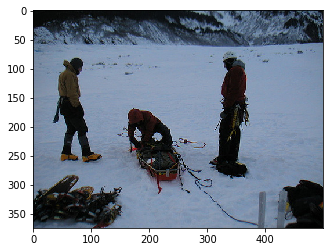

Greedy: people are walking through the snow


In [68]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

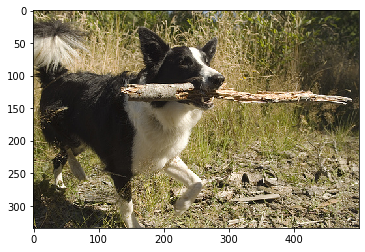

Greedy: black and white dog is running through the grass


In [78]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

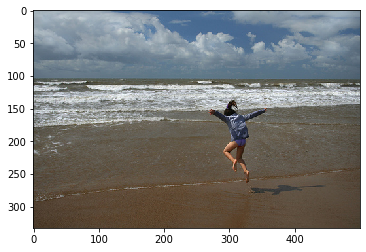

Greedy: young girl in the blue swimsuit is jumping on the beach


In [70]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

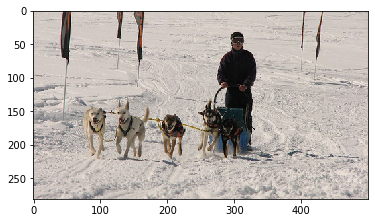

Greedy: dog sledding in the snow


In [82]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

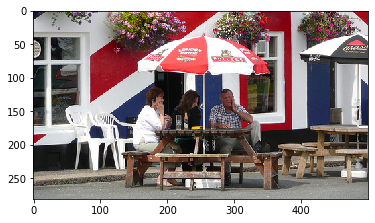

Greedy: group of people are sitting on bench outside of building
1258913059_07c613f7ff.jpg


In [76]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

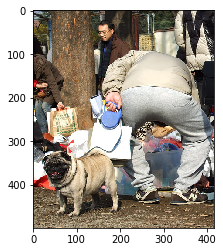

Greedy: man and woman are sitting on bench


In [102]:
image = encoding_test['1394368714_3bc7c19969.jpg'].reshape((1,2048))
x=plt.imread('E://TFM/Flickr8k/Images/1394368714_3bc7c19969.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))